<a id="top"></a>
# Interpreting Convolutional Neural Networks

***

## Learning Goals


**In this tutorial, you will practice analyzing and interpreting a convolutional neural network.**
 This tutorial assumes a basic knowledge of convolutional neural networks. We will utilize the model described in `Classifying_JWST-HST_galaxy_mergers_with_CNNs`, so it is recommended to complete that notebook before reading this one.

## Introduction
Machine learning techniques can be powerful tools for categorizing data and performing data analysis questions. However, machine learning techniques often involve a lot of hidden computation that is not immediately meaningful. The black-box nature of intermediary processes, especially in layered neural networks, can make it difficult to interpret and understand. The goal of this notebook is to familiarize you with some of the various techniques used to make sense of machine learning and convolutional neural networks (CNNs) in particular. CNNs in particular can be very difficult to interpret due to their multi-layered structure and convolutional layers. In this notebook, we will examine two methods of visualizing CNN results (Backpropagation and Grad-CAM) and another method for testing model architecture.

1. Load the data
2. Split the data into training, validation, and testing sets
3. Build and train a model
4. Apply some interpretation technique to understand your results from a physical perspective.


### Dependencies

This notebook uses the following packages:
- `numpy` to handle array functions
- `astropy` for downloading and accessing FITS files
- `matplotlib.pyplot` for plotting data
- `keras` and `tensorflow` for building the CNN
- `sklearn` for some utility functions

If you do not have these packages installed, you can install them using [`pip`](https://pip.pypa.io/en/stable/) or [`conda`](https://docs.conda.io/en/latest/).

Further information about the original model can be found at the [Hello Universe codebase](https://spacetelescope.github.io/hellouniverse/notebooks/hello-universe/Classifying_JWST-HST_galaxy_mergers_with_CNNs/Classifying_JWST-HST_galaxy_mergers_with_CNNs.html).


**Author:**  
Oliver Lin, oliverlin2004@gmail.com

**Additional Contributors:**  
Daisuke Nagai, daisuke.nagai@yale.edu.

Michelle Ntampaka, mntampaka@stsci.edu.

**Published:** 2024-05-08

In [1]:
# arrays
import numpy as np

# fits
from astropy.io import fits
from astropy.utils.data import download_file
from astropy.visualization import simple_norm

# plotting
from matplotlib import pyplot as plt

# keras
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization, Convolution2D, MaxPooling2D
# from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.regularizers import l2

# sklearn
from sklearn.model_selection import train_test_split

# tensorflow for saliency
import tensorflow as tf
import cv2

2025-08-02 19:35:47.731718: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-02 19:35:47.763875: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-02 19:35:47.763900: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-02 19:35:47.764955: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-02 19:35:47.770376: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-02 19:35:47.770849: I tensorflow/core/platform/cpu_feature_guard.cc:1

2025-08-02 19:35:48.480986: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Reloading our Model
To start, we need to reload our model from the previous galaxy classification notebook from the Mikulski Archive for Space Telescopes (MAST). The following code is directly copied over from that notebook. For a quick refresher, the model intakes a FITS file from a high level science product hosted by MAST. There are 15,426 observations in total, each taken with three filters (F814W from the Advanced Camera for Surveys and F160W from the Wide Field Camera 3 on the Hubble Space Telescope (HST), and F160W and F356W from Near Infrared Camera on the James Webb Space Telescope (JWST)). The model then applies a Convolutional Neural Network to classify whether a galaxy has undergone a merger.

In [2]:
version = 'pristine'
file_url = 'https://archive.stsci.edu/hlsps/deepmerge/hlsp_deepmerge_hst-jwst_acs-wfc3-nircam_illustris-z2_f814w-f160w-f356w_v1_sim-'+version+'.fits'
hdu = fits.open(download_file(file_url, cache=True, show_progress=True))

## Build and Compile the Convolutional Model
For the sake of transparency, we will rebuild the model using the same architecture as the original notebook. The model can also be loaded directly by using `save_model` and `load_model` from the [Keras](https://www.tensorflow.org/guide/keras/serialization_and_saving) package. 

In [3]:
X = hdu[0].data
y = hdu[1].data

Following the authors, we will split the data into 70:10:20 ratio of train:validate:test. As above, set the random seed to randomly split the images in a repeatable way. Feel free to try different values!



In [4]:
random_state = 42

X = np.asarray(X).astype('float32')
y = np.asarray(y).astype('float32')

# First split off 30% of the data for validation+testing
X_train, X_split, y_train, y_split = train_test_split(X, y, test_size=0.3, random_state=random_state, shuffle=True)

# Then divide this subset into training and testing sets
X_valid, X_test, y_valid, y_test = train_test_split(X_split, y_split, test_size=0.666, random_state=random_state, shuffle=True)

In [5]:
imsize = np.shape(X_train)[2]

X_train = np.array([np.stack(x, axis=2) for x in X_train])
X_valid = np.array([np.stack(x, axis=2) for x in X_valid])
X_test = np.array([np.stack(x, axis=2) for x in X_test])

### Generate the model architecture (written for Keras 2)

In [6]:
# Define architecture for model
data_shape = np.shape(X)
input_shape = (imsize, imsize, 3)

x_in = Input(shape=input_shape)
c0 = Convolution2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same')(x_in)
b0 = BatchNormalization()(c0)
d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b0)
e0 = Dropout(0.5)(d0)

c1 = Convolution2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same')(e0)
b1 = BatchNormalization()(c1)
d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b1)
e1 = Dropout(0.5)(d1)

c2 = Convolution2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same')(e1)
b2 = BatchNormalization()(c2)
d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b2)
e2 = Dropout(0.5)(d2)

f = Flatten()(e2)
z0 = Dense(64, activation='softmax', kernel_regularizer=l2(0.0001))(f)
z1 = Dense(32, activation='softmax', kernel_regularizer=l2(0.0001))(z0)
y_out = Dense(1, activation='sigmoid')(z1)

cnn = Model(inputs=x_in, outputs=y_out)

### Compile Model

In [7]:
optimizer = 'adam'
fit_metrics = ['accuracy']
loss = 'binary_crossentropy'
cnn.compile(loss=loss, optimizer=optimizer, metrics=fit_metrics)

### Load pretrained weights


In [8]:
file_url = 'https://archive.stsci.edu/hlsps/hellouniverse/hellouniverse_interpretability_best_weights.hdf5'
cnn.load_weights(download_file(file_url, cache=True, show_progress=True))

2025-08-02 19:35:50.825252: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open /home/runner/.astropy/cache/download/url/75479cba1a5e1313befcce7b9c2f3f36/contents: DATA_LOSS: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


## 1. Saliency Maps
We will start by introducing the most popular and well known method of interpreting CNNs. A saliency map can help us identify which pixels are significant to the models final prediction. There are many methods of calculating saliency maps, but the most popular method utilizes gradient backpropagation to determine the significance of pixels at each layer of the model. To calculate the saliency map, the error gradient at each layer is calculated and then fed into the previous layer, repeating until we reach the original image. Then the pixels with the highest gradient values will also have the most effect on the model's activation. This methodology is described in detail by <a href='https://arxiv.org/abs/1312.6034'>Simonyan et al. 2013</a>. 

### Dependencies

`tensorflow.GradientTape()` is used to track the gradient of the function.


In [9]:
# Choose the image to analyze
img_idx = 1

# We can change the index to any number in range of the test set
orig_img = X_test[img_idx]
img = orig_img
img = img.reshape((1, *img.shape))
norm = simple_norm(orig_img, 'log', max_percent=99.75)
scaled_img = norm(orig_img)

In [10]:
images = tf.Variable(img, dtype=float)

# Make a prediction and track gradients
with tf.GradientTape() as tape:
    pred = cnn(images, training=False)
    class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]    
    loss = pred[class_idxs_sorted[0]]

grads = tape.gradient(loss, images)

### Plot the original image and the saliency map

Saliency maps provide an intuitive understanding of how the model works. The hot pixels represent higher activation and more importance. In the below model, the saliency maps demonstrates that the model focuses on the area around the center of the galaxy for the majority of galaxies. Our results are in line with a corroborating result by [Ntampaka et al. 2018](https://arxiv.org/abs/1810.07703), suggesting that the key features of a galaxy are found the ring around the galaxy rather than in the center of the galaxy.

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 91ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.822696e-08..8.880155].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2109969226408994].


Text(0.5, 0.98, 'prediction_val=[[0.44489214]]')

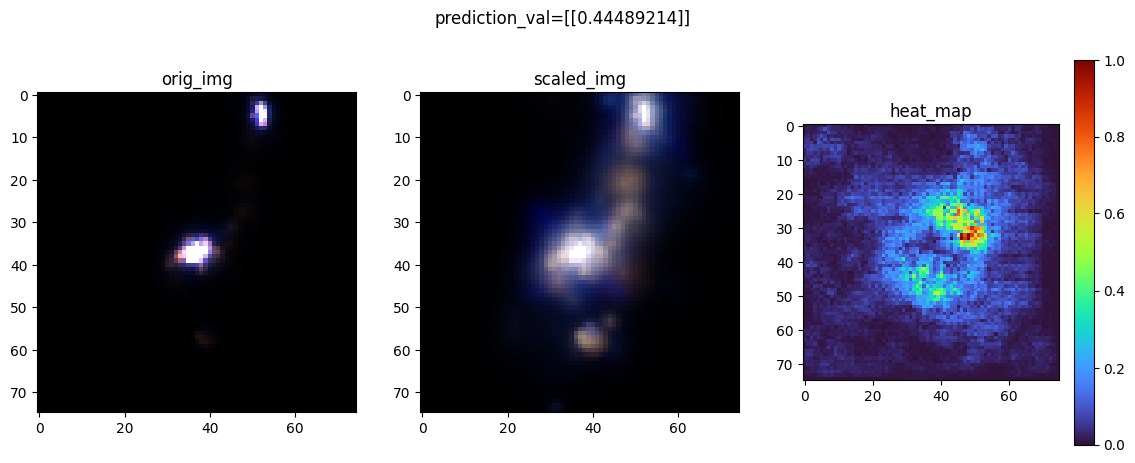

In [11]:
y_pred = cnn.predict(img)

dgrad_abs = tf.math.abs(grads)
dgrad_max_ = np.max(dgrad_abs, axis=3)[0]

# normalize to range between 0 and 1
arr_min, arr_max = np.min(dgrad_max_), np.max(dgrad_max_)
grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)

# Plot the results next to the original image
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

axes[0].imshow(orig_img)
axes[0].set_title("orig_img")
axes[1].imshow(scaled_img)
axes[1].set_title("scaled_img")
i = axes[2].imshow(grad_eval, cmap="turbo")
fig.colorbar(i)
axes[2].set_title("heat_map")
fig.suptitle("prediction_val=" + str(y_pred))

**Image caption**: The above image contains three panels in a horizontal row. The first panel shows the original image of a merging galaxy candidate, the second panel shows a logarithmically-scaled version of the original image, and the third panel shows a heat map of the saliency map.

### Create a stack of saliency images

To understand the overall behavior of our algorithm, we can stack some or all of the saliency maps in the test set to generate an overarching estimate of important pixels. For the sake of simplicity, we will stack the saliency maps for the first 100 images in the test set. Our results once again indicate that the region around a galaxy is particularly important to the model.

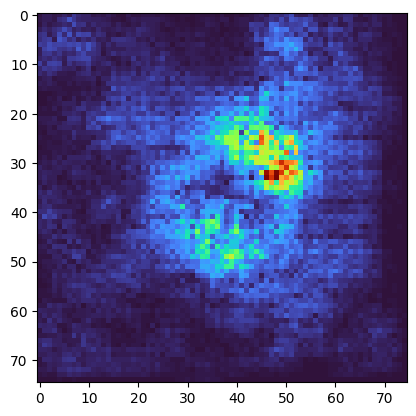

In [12]:
sum_map = np.zeros((75, 75))
# Summing the first 100 saliencies. We can change
# the range to sum more or less saliencies or pick 
# specific ones
for i in range(100):
    img = X_test[img_idx]
    img = img.reshape((1, *img.shape))
    images = tf.Variable(img, dtype=float)

    # Make a prediction and track gradients
    with tf.GradientTape() as tape:
        pred = cnn(images, training=False)
        class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]    
        loss = pred[class_idxs_sorted[0]]

    grads = tape.gradient(loss, images)

    y_pred = cnn.predict(images, verbose=0)

    dgrad_abs = tf.math.abs(grads)
    dgrad_max_ = np.max(dgrad_abs, axis=3)[0]

    # normalize to range between 0 and 1
    arr_min, arr_max = np.min(dgrad_max_), np.max(dgrad_max_)
    grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min)
    sum_map += grad_eval
plt.imshow(sum_map, cmap='turbo')

**Image caption**: The above image contains a single panel, and shows a stacked version of the saliency maps from 100 images.

## 2. Grad-CAM
While gradient backpropagation has historically been the most popular type of saliency map, the highly connected nature of backtracking has been shown to produce high variance under small changes to inputs. As such, gradient backpropagation is extremely sensitive to data manipulation (preprocessing, sensitivity analysis, GANs), raising questions about its reliability and validity. Gradient Class Activation Mapping (Grad-CAM) is an alternative method for generating saliency models that only examines the gradient of the final convolutional layer when producing the map. As a consequence, Grad-CAM maps have lower (coarser) resolution than backpropagation but are far more resilient to small changes and therefore more reliable when tuning a model. A full description of the technique can be found in <a href='https://arxiv.org/abs/1610.02391'>Selveraju et al. 2016</a>.

The code for Grad-CAM comes from a useful tutorial on the subject by Daniel Reiff. For more information, please visit the  <a href='https://towardsdatascience.com/understand-your-algorithm-with-grad-cam-d3b62fce353'>full tutorial</a>.

### Dependencies

`Open_CV` and `astropy.simple_norm` are used to do manipulate the image for display. Alternatively, we could allow Python to automatically clip the image when the heatmap is out of range.

In [13]:
# Choose the image to analyze
img_idx = 1

# We can change the index to any number in range of the test set
orig_img = X_test[img_idx]
img = orig_img
img = img.reshape((1, *img.shape))
norm = simple_norm(orig_img, 'log', max_percent=99.75)
scaled_img = norm(orig_img)

In [14]:
# Note: recompiling the model will change the layer
# name. In that case, you can either restart the 
# kernel or change the layer_name.
# We can also change the layer selected here to pull out any layer of our model
gradModel = Model(inputs=[cnn.inputs], outputs=[cnn.get_layer("conv2d_2").output, cnn.output])

with tf.GradientTape() as tape:
    # get the loss with associated with the prediction
    inputs = tf.cast(X_test, tf.float32)
    (convOutputs, predictions) = gradModel(inputs)
    loss = predictions[:, 0]
    
# use automatic differentiation to compute the gradients
grads = tape.gradient(loss, convOutputs)

# compute the guided gradients by removing all nonpositive
# gradients
castConvOutputs = tf.cast(convOutputs > 0, "float32")
castGrads = tf.cast(grads > 0, "float32")
guidedGrads = castConvOutputs * castGrads * grads

# pick out the convolution and gradient of the chosen image
convOutputs = convOutputs[img_idx]
guidedGrads = guidedGrads[img_idx]

# compute the average of the gradient values, and using them
# as weights, compute the importance of the pieces
weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

# grab the spatial dimensions of the input image and resize
# the output class activation map to match the input image
# dimensions
(w, h) = (X_test.shape[2], X_test.shape[1])
heatmap = cv2.resize(cam.numpy(), (w, h))

# normalize the heatmap such that all values lie in the range
# [0, 1], scale the resulting values to the range [0, 255],
# and then convert to an unsigned 8-bit integer

2025-08-02 19:35:53.813575: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.


2025-08-02 19:35:54.649378: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.
2025-08-02 19:35:54.720612: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.
2025-08-02 19:35:54.760307: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.


2025-08-02 19:35:56.226801: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.822696e-08..8.880155].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2109969226408994].


Text(0.5, 0.98, 'prediction_val=[[0.44489214]]')

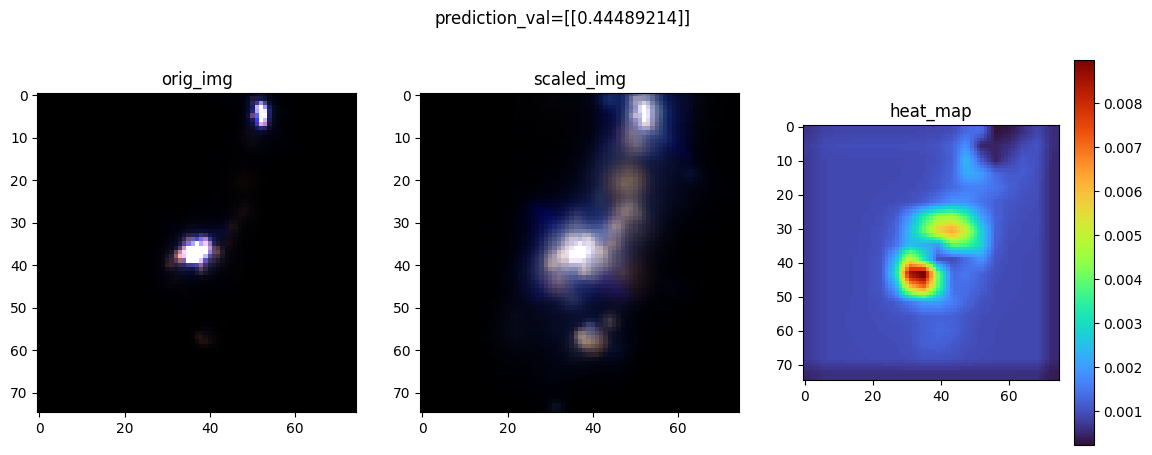

In [15]:
y_pred = cnn.predict(img)

# Plot the results next to the original image
fig, axes = plt.subplots(1, 3, figsize=(14, 5))
axes[0].imshow(orig_img)
axes[0].set_title("orig_img")
axes[1].imshow(scaled_img)
axes[1].set_title("scaled_img")
i = axes[2].imshow(heatmap, cmap="turbo")
fig.colorbar(i)
axes[2].set_title("heat_map")
fig.suptitle("prediction_val=" + str(y_pred))

**Image caption**: The above image contains three panels in a horizontal row. The first panel shows the original image of a merging galaxy candidate, the second panel shows a logarithmically-scaled version of the original image, and the third panel shows a heat map of the grad-cam map.

**The result is very similar** to our saliency map from backpropagation, although the image is coarser and also shows both the top and bottom of the galaxy. We can also play around with the selected layer to calculate the output at different steps in the model and see how activation changes throughout the model.

## 3. RISE Algorithm
The RISE (Randomized Input Sampling for Explanation) Algorithm is another interpretation technique for calculating saliency maps. Instead of calculating gradients from within the model, the RISE implementation works by covering up pieces of the input image, running it through the model, and calculating the average activation in order to determine what parts of the image are most important. As such, this method does not require any access to the inner workings of the model. The algorithm first generates a random sequence of binary grids (called masks), which are placed onto the image. Everything not covered by the mask is removed by multiplying the images together, and the resultant activations are averaged to get our final heatmap. A full description of the algorithm and its variations is provided by <a href='https://arxiv.org/abs/1806.07421'>Petsiuk et al. 2018</a>. 



In [16]:
# Choose the image to analyze
img_idx = 6

# We can change the index to any number in range of the test set
image = X_test[img_idx]

N = 1000  # Number of masks
s = 8     # Size of the grid
p1 = 0.5  # Probability of the cell being set to 1

cell_size = np.ceil(np.array(input_shape[:2]) / s).astype(int)
up_size = (s * cell_size).astype(int)

grid = np.random.rand(N, s, s) < p1
masks = np.empty((N, *input_shape[:2]))

for i in range(N):
    # Randomly place the grid on the image
    x = np.random.randint(0, input_shape[0]-s)
    y = np.random.randint(0, input_shape[1]-s)
    mask = np.pad(grid[i], ((x, input_shape[0]-x-s), (y, input_shape[0]-y-s)), 'constant', constant_values=(0, 0))
    mask = mask[:input_shape[0], :input_shape[1]]
    masks[i] = mask

masks = masks.reshape(-1, *input_shape[:2], 1)

N = len(masks)
pred_masks = cnn.predict(image * masks)
pred_masks = np.expand_dims(pred_masks, axis=-1)
pred_masks = np.expand_dims(pred_masks, axis=-1) # Reshape pred_masks for broadcasting
heatmap = (pred_masks * masks).sum(axis=0)
heatmap = heatmap / N / p1

 1/32 [..............................] - ETA: 0s

 5/32 [===>..........................] - ETA: 0s

 9/32 [=======>......................] - ETA: 0s

13/32 [===========>..................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 1s 15ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00022207294..674.50696].


Text(0.5, 1.0, 'heat_map')

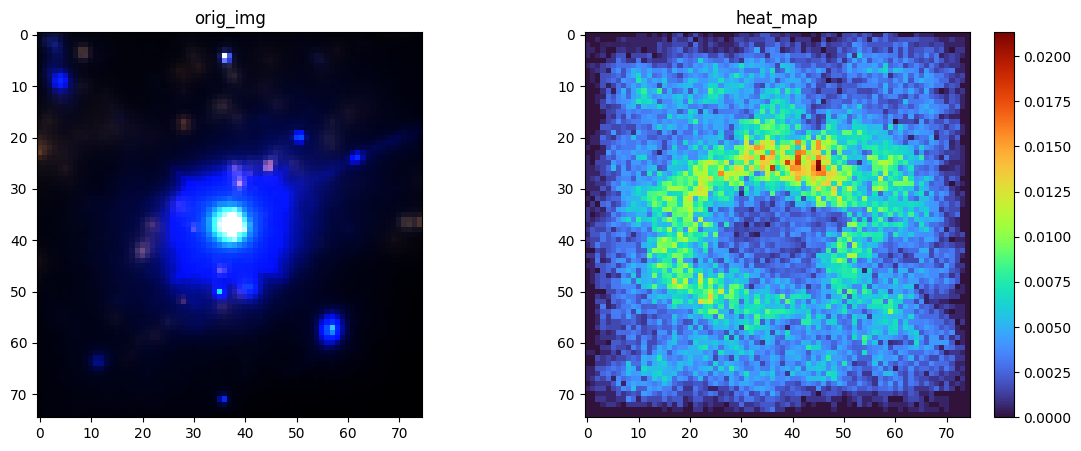

In [17]:
# Plot the results next to the original image
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].imshow(image)
axes[0].set_title("orig_img")
i = axes[1].imshow(heatmap, cmap="turbo")
fig.colorbar(i)
axes[1].set_title("heat_map")

**Image caption**: The above image contains two panels in a horizontal row. The first panel shows the original image of a merginig galaxy candidate, and the second panel shows a heat map of the RISE map.

**When examining the selected image**, we see a ring around the galactic center. Note that this is not the case for all astronomical images, or even all images in this dataset. Try playing around with the selected image to generate different saliency maps. For images where the central feature is relatively small, RISE's occlusion-based methodology can be unreliable.

## 4. Ablation Analysis
Saliency maps provide an intuitive visual understanding of our model's focus and can be useful for understanding the physical relevance of our classification scheme. In order to understand the efficacy of our model's architecture, we can instead use ablation analysis to determine the most important layers of our model. Ablation analysis works by rebuilding our model without a specified layer of interest and testing and comparing the performance of a partial model. Since we are focusing on our model's internal architecture rather than the features of the dataset we are looking at, we want to use this technique when trying to improve the training metrics of our model by editing its layers. This method allows us to determine which layers of the model are most important, or if some layers are hindering the learning capabilities of our mode

In the exercise below, we will build and train four mini-models on the same data set as before. As this is an educational notebook, we will limit the training time of each model to five epochs. Results with these models may vary considerably due to these training constraints, but we highly encourage you to try modifying this section of the notebook for different results (see [Exercises](#Exercises/Extensions))

Note that performing an ablation analysis will require training multiple models with the same architecture. This can be quite compute intensive on personal computers, so if you are running this notebook locally it is recommended that your device be plugged in before running the analysis.

### Dependencies

`Tensorflow` is used build our model and train it.

In [18]:
def create_model(ablate=None):
    x_in = Input(shape=input_shape)
    
    if ablate != 'c0':
        c0 = Convolution2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same')(x_in)
    else:
        c0 = x_in
    b0 = BatchNormalization()(c0)
    d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b0)
    e0 = Dropout(0.5)(d0)

    if ablate != 'c1':
        c1 = Convolution2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same')(e0)
    else:
        c1 = e0
    b1 = BatchNormalization()(c1)
    d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b1)
    e1 = Dropout(0.5)(d1)

    if ablate != 'c2':
        c2 = Convolution2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same')(e1)
    else:
        c2 = e1
    b2 = BatchNormalization()(c2)
    d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b2)
    e2 = Dropout(0.5)(d2)

    f = Flatten()(e2)
    z0 = Dense(64, activation='softmax', kernel_regularizer=l2(0.0001))(f)
    z1 = Dense(32, activation='softmax', kernel_regularizer=l2(0.0001))(z0)
    y_out = Dense(1, activation='sigmoid')(z1)

    cnn = Model(inputs=x_in, outputs=y_out)
    return cnn

**Since ablation analysis requires training multiple models**, it can often be more resource intensive than other methods. However, it can also provide useful information on the way features are organized during training. The following cell can be edited to change how much we want to train our mini-models.

In [19]:
# You can change how much to train each model
# 5 epochs is chosen due to time and computation constraints
num_epochs = 5

# Train the original model
model = create_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test))

# Get baseline performance
baseline_score = model.evaluate(X_test, y_test)

# Ablate each layer and compare performance
layers_to_ablate = ['c0', 'c1', 'c2']
for layer in layers_to_ablate:
    model_ablated = create_model(ablate=layer)
    model_ablated.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model_ablated.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test))
    ablated_score = model_ablated.evaluate(X_test, y_test)
    
    print(f"Performance drop after ablating {layer}: {baseline_score[1] - ablated_score[1]}")

Epoch 1/5


  1/338 [..............................] - ETA: 6:15 - loss: 0.7101 - accuracy: 0.5000

  2/338 [..............................] - ETA: 18s - loss: 0.7089 - accuracy: 0.5312 

  3/338 [..............................] - ETA: 18s - loss: 0.7086 - accuracy: 0.5312

  4/338 [..............................] - ETA: 19s - loss: 0.7088 - accuracy: 0.5156

  5/338 [..............................] - ETA: 18s - loss: 0.7091 - accuracy: 0.5000

  6/338 [..............................] - ETA: 18s - loss: 0.7090 - accuracy: 0.4948

  7/338 [..............................] - ETA: 18s - loss: 0.7079 - accuracy: 0.5179

  8/338 [..............................] - ETA: 18s - loss: 0.7072 - accuracy: 0.5312

  9/338 [..............................] - ETA: 18s - loss: 0.7064 - accuracy: 0.5451

 10/338 [..............................] - ETA: 18s - loss: 0.7063 - accuracy: 0.5406

 11/338 [..............................] - ETA: 18s - loss: 0.7058 - accuracy: 0.5455

 12/338 [>.............................] - ETA: 18s - loss: 0.7055 - accuracy: 0.5469

 13/338 [>.............................] - ETA: 18s - loss: 0.7054 - accuracy: 0.5433

 14/338 [>.............................] - ETA: 18s - loss: 0.7056 - accuracy: 0.5335

 15/338 [>.............................] - ETA: 18s - loss: 0.7050 - accuracy: 0.5417

 16/338 [>.............................] - ETA: 18s - loss: 0.7047 - accuracy: 0.5430

 17/338 [>.............................] - ETA: 18s - loss: 0.7043 - accuracy: 0.5460

 18/338 [>.............................] - ETA: 18s - loss: 0.7046 - accuracy: 0.5347

 19/338 [>.............................] - ETA: 17s - loss: 0.7043 - accuracy: 0.5362

 20/338 [>.............................] - ETA: 17s - loss: 0.7043 - accuracy: 0.5297

 21/338 [>.............................] - ETA: 17s - loss: 0.7040 - accuracy: 0.5312

 22/338 [>.............................] - ETA: 17s - loss: 0.7040 - accuracy: 0.5284

 23/338 [=>............................] - ETA: 17s - loss: 0.7039 - accuracy: 0.5258

 24/338 [=>............................] - ETA: 17s - loss: 0.7035 - accuracy: 0.5286

 25/338 [=>............................] - ETA: 17s - loss: 0.7033 - accuracy: 0.5288

 26/338 [=>............................] - ETA: 17s - loss: 0.7032 - accuracy: 0.5276

 27/338 [=>............................] - ETA: 17s - loss: 0.7030 - accuracy: 0.5278

 28/338 [=>............................] - ETA: 17s - loss: 0.7027 - accuracy: 0.5312

 29/338 [=>............................] - ETA: 17s - loss: 0.7022 - accuracy: 0.5366

 30/338 [=>............................] - ETA: 17s - loss: 0.7021 - accuracy: 0.5365

 31/338 [=>............................] - ETA: 17s - loss: 0.7017 - accuracy: 0.5393

 32/338 [=>............................] - ETA: 17s - loss: 0.7016 - accuracy: 0.5391

 33/338 [=>............................] - ETA: 17s - loss: 0.7015 - accuracy: 0.5369

 34/338 [==>...........................] - ETA: 16s - loss: 0.7012 - accuracy: 0.5395

 35/338 [==>...........................] - ETA: 16s - loss: 0.7010 - accuracy: 0.5402

 36/338 [==>...........................] - ETA: 16s - loss: 0.7009 - accuracy: 0.5399

 37/338 [==>...........................] - ETA: 16s - loss: 0.7007 - accuracy: 0.5405

 38/338 [==>...........................] - ETA: 16s - loss: 0.7007 - accuracy: 0.5395

 39/338 [==>...........................] - ETA: 16s - loss: 0.7005 - accuracy: 0.5393

 40/338 [==>...........................] - ETA: 16s - loss: 0.7005 - accuracy: 0.5375

 41/338 [==>...........................] - ETA: 16s - loss: 0.7003 - accuracy: 0.5396

 42/338 [==>...........................] - ETA: 16s - loss: 0.7001 - accuracy: 0.5394

 43/338 [==>...........................] - ETA: 16s - loss: 0.7001 - accuracy: 0.5385

 44/338 [==>...........................] - ETA: 16s - loss: 0.7001 - accuracy: 0.5362

 45/338 [==>...........................] - ETA: 16s - loss: 0.7000 - accuracy: 0.5354

 46/338 [===>..........................] - ETA: 16s - loss: 0.6997 - accuracy: 0.5380

 47/338 [===>..........................] - ETA: 16s - loss: 0.6998 - accuracy: 0.5346

 48/338 [===>..........................] - ETA: 16s - loss: 0.6997 - accuracy: 0.5352

 49/338 [===>..........................] - ETA: 16s - loss: 0.6996 - accuracy: 0.5357

 50/338 [===>..........................] - ETA: 16s - loss: 0.6994 - accuracy: 0.5369

 51/338 [===>..........................] - ETA: 16s - loss: 0.6994 - accuracy: 0.5343

 52/338 [===>..........................] - ETA: 15s - loss: 0.6995 - accuracy: 0.5319

 53/338 [===>..........................] - ETA: 15s - loss: 0.6994 - accuracy: 0.5312

 54/338 [===>..........................] - ETA: 15s - loss: 0.6993 - accuracy: 0.5318

 55/338 [===>..........................] - ETA: 15s - loss: 0.6991 - accuracy: 0.5330

 56/338 [===>..........................] - ETA: 15s - loss: 0.6991 - accuracy: 0.5329

 57/338 [====>.........................] - ETA: 15s - loss: 0.6987 - accuracy: 0.5373

 58/338 [====>.........................] - ETA: 15s - loss: 0.6987 - accuracy: 0.5361

 59/338 [====>.........................] - ETA: 15s - loss: 0.6985 - accuracy: 0.5376

 60/338 [====>.........................] - ETA: 15s - loss: 0.6986 - accuracy: 0.5354

 61/338 [====>.........................] - ETA: 15s - loss: 0.6987 - accuracy: 0.5328

 62/338 [====>.........................] - ETA: 15s - loss: 0.6987 - accuracy: 0.5318

 63/338 [====>.........................] - ETA: 15s - loss: 0.6986 - accuracy: 0.5317

 64/338 [====>.........................] - ETA: 15s - loss: 0.6985 - accuracy: 0.5317

 65/338 [====>.........................] - ETA: 15s - loss: 0.6984 - accuracy: 0.5332

 66/338 [====>.........................] - ETA: 15s - loss: 0.6982 - accuracy: 0.5341

 67/338 [====>.........................] - ETA: 15s - loss: 0.6983 - accuracy: 0.5326

 68/338 [=====>........................] - ETA: 15s - loss: 0.6983 - accuracy: 0.5312

 69/338 [=====>........................] - ETA: 15s - loss: 0.6982 - accuracy: 0.5317

 70/338 [=====>........................] - ETA: 14s - loss: 0.6982 - accuracy: 0.5308

 71/338 [=====>........................] - ETA: 14s - loss: 0.6983 - accuracy: 0.5290

 72/338 [=====>........................] - ETA: 14s - loss: 0.6982 - accuracy: 0.5286

 73/338 [=====>........................] - ETA: 14s - loss: 0.6982 - accuracy: 0.5287

 74/338 [=====>........................] - ETA: 14s - loss: 0.6983 - accuracy: 0.5262

 75/338 [=====>........................] - ETA: 14s - loss: 0.6982 - accuracy: 0.5263

 76/338 [=====>........................] - ETA: 14s - loss: 0.6981 - accuracy: 0.5267

 77/338 [=====>........................] - ETA: 14s - loss: 0.6981 - accuracy: 0.5268

 78/338 [=====>........................] - ETA: 14s - loss: 0.6980 - accuracy: 0.5272

 79/338 [======>.......................] - ETA: 14s - loss: 0.6980 - accuracy: 0.5261

 80/338 [======>.......................] - ETA: 14s - loss: 0.6980 - accuracy: 0.5258

 81/338 [======>.......................] - ETA: 14s - loss: 0.6978 - accuracy: 0.5274

 82/338 [======>.......................] - ETA: 14s - loss: 0.6977 - accuracy: 0.5286

 83/338 [======>.......................] - ETA: 14s - loss: 0.6977 - accuracy: 0.5279

 84/338 [======>.......................] - ETA: 14s - loss: 0.6978 - accuracy: 0.5264

 85/338 [======>.......................] - ETA: 14s - loss: 0.6978 - accuracy: 0.5257

 86/338 [======>.......................] - ETA: 14s - loss: 0.6977 - accuracy: 0.5262

 87/338 [======>.......................] - ETA: 13s - loss: 0.6978 - accuracy: 0.5244

 88/338 [======>.......................] - ETA: 13s - loss: 0.6977 - accuracy: 0.5241

 89/338 [======>.......................] - ETA: 13s - loss: 0.6978 - accuracy: 0.5221

 90/338 [======>.......................] - ETA: 13s - loss: 0.6977 - accuracy: 0.5229

 91/338 [=======>......................] - ETA: 13s - loss: 0.6976 - accuracy: 0.5237

 92/338 [=======>......................] - ETA: 13s - loss: 0.6975 - accuracy: 0.5245

 93/338 [=======>......................] - ETA: 13s - loss: 0.6975 - accuracy: 0.5242

 94/338 [=======>......................] - ETA: 13s - loss: 0.6975 - accuracy: 0.5236

 95/338 [=======>......................] - ETA: 13s - loss: 0.6975 - accuracy: 0.5237

 96/338 [=======>......................] - ETA: 13s - loss: 0.6975 - accuracy: 0.5231

 97/338 [=======>......................] - ETA: 13s - loss: 0.6973 - accuracy: 0.5245

 98/338 [=======>......................] - ETA: 13s - loss: 0.6972 - accuracy: 0.5258

 99/338 [=======>......................] - ETA: 13s - loss: 0.6972 - accuracy: 0.5249

100/338 [=======>......................] - ETA: 13s - loss: 0.6972 - accuracy: 0.5250

101/338 [=======>......................] - ETA: 13s - loss: 0.6970 - accuracy: 0.5266

102/338 [========>.....................] - ETA: 13s - loss: 0.6971 - accuracy: 0.5260

103/338 [========>.....................] - ETA: 13s - loss: 0.6970 - accuracy: 0.5258

104/338 [========>.....................] - ETA: 13s - loss: 0.6970 - accuracy: 0.5255

105/338 [========>.....................] - ETA: 12s - loss: 0.6969 - accuracy: 0.5262

106/338 [========>.....................] - ETA: 12s - loss: 0.6969 - accuracy: 0.5265

107/338 [========>.....................] - ETA: 12s - loss: 0.6969 - accuracy: 0.5260

108/338 [========>.....................] - ETA: 12s - loss: 0.6969 - accuracy: 0.5255

109/338 [========>.....................] - ETA: 12s - loss: 0.6968 - accuracy: 0.5258

110/338 [========>.....................] - ETA: 12s - loss: 0.6967 - accuracy: 0.5264

111/338 [========>.....................] - ETA: 12s - loss: 0.6967 - accuracy: 0.5273

112/338 [========>.....................] - ETA: 12s - loss: 0.6967 - accuracy: 0.5265

113/338 [=========>....................] - ETA: 12s - loss: 0.6967 - accuracy: 0.5254

114/338 [=========>....................] - ETA: 12s - loss: 0.6967 - accuracy: 0.5252

115/338 [=========>....................] - ETA: 12s - loss: 0.6967 - accuracy: 0.5250

116/338 [=========>....................] - ETA: 12s - loss: 0.6967 - accuracy: 0.5242

117/338 [=========>....................] - ETA: 12s - loss: 0.6966 - accuracy: 0.5248

118/338 [=========>....................] - ETA: 12s - loss: 0.6965 - accuracy: 0.5265

119/338 [=========>....................] - ETA: 12s - loss: 0.6966 - accuracy: 0.5252

120/338 [=========>....................] - ETA: 12s - loss: 0.6965 - accuracy: 0.5253

121/338 [=========>....................] - ETA: 12s - loss: 0.6964 - accuracy: 0.5263

122/338 [=========>....................] - ETA: 12s - loss: 0.6964 - accuracy: 0.5259

123/338 [=========>....................] - ETA: 11s - loss: 0.6964 - accuracy: 0.5257

124/338 [==========>...................] - ETA: 11s - loss: 0.6963 - accuracy: 0.5260

125/338 [==========>...................] - ETA: 11s - loss: 0.6963 - accuracy: 0.5260

126/338 [==========>...................] - ETA: 11s - loss: 0.6962 - accuracy: 0.5273

127/338 [==========>...................] - ETA: 11s - loss: 0.6962 - accuracy: 0.5271

128/338 [==========>...................] - ETA: 11s - loss: 0.6962 - accuracy: 0.5266

129/338 [==========>...................] - ETA: 11s - loss: 0.6963 - accuracy: 0.5252

130/338 [==========>...................] - ETA: 11s - loss: 0.6962 - accuracy: 0.5255

131/338 [==========>...................] - ETA: 11s - loss: 0.6962 - accuracy: 0.5258

132/338 [==========>...................] - ETA: 11s - loss: 0.6961 - accuracy: 0.5265

133/338 [==========>...................] - ETA: 11s - loss: 0.6960 - accuracy: 0.5270

134/338 [==========>...................] - ETA: 11s - loss: 0.6961 - accuracy: 0.5257

135/338 [==========>...................] - ETA: 11s - loss: 0.6961 - accuracy: 0.5257

136/338 [===========>..................] - ETA: 11s - loss: 0.6961 - accuracy: 0.5248

137/338 [===========>..................] - ETA: 11s - loss: 0.6961 - accuracy: 0.5251

138/338 [===========>..................] - ETA: 11s - loss: 0.6960 - accuracy: 0.5258

139/338 [===========>..................] - ETA: 11s - loss: 0.6959 - accuracy: 0.5265

140/338 [===========>..................] - ETA: 11s - loss: 0.6959 - accuracy: 0.5268

141/338 [===========>..................] - ETA: 10s - loss: 0.6959 - accuracy: 0.5257

142/338 [===========>..................] - ETA: 10s - loss: 0.6960 - accuracy: 0.5249

143/338 [===========>..................] - ETA: 10s - loss: 0.6959 - accuracy: 0.5251

144/338 [===========>..................] - ETA: 10s - loss: 0.6959 - accuracy: 0.5247

145/338 [===========>..................] - ETA: 10s - loss: 0.6959 - accuracy: 0.5252

146/338 [===========>..................] - ETA: 10s - loss: 0.6958 - accuracy: 0.5261

147/338 [============>.................] - ETA: 10s - loss: 0.6957 - accuracy: 0.5264

148/338 [============>.................] - ETA: 10s - loss: 0.6958 - accuracy: 0.5253

149/338 [============>.................] - ETA: 10s - loss: 0.6957 - accuracy: 0.5258

150/338 [============>.................] - ETA: 10s - loss: 0.6957 - accuracy: 0.5258

151/338 [============>.................] - ETA: 10s - loss: 0.6956 - accuracy: 0.5273

152/338 [============>.................] - ETA: 10s - loss: 0.6956 - accuracy: 0.5265

153/338 [============>.................] - ETA: 10s - loss: 0.6956 - accuracy: 0.5261

154/338 [============>.................] - ETA: 10s - loss: 0.6956 - accuracy: 0.5258

155/338 [============>.................] - ETA: 10s - loss: 0.6956 - accuracy: 0.5266

156/338 [============>.................] - ETA: 10s - loss: 0.6956 - accuracy: 0.5256

157/338 [============>.................] - ETA: 10s - loss: 0.6956 - accuracy: 0.5257

158/338 [=============>................] - ETA: 10s - loss: 0.6955 - accuracy: 0.5259

159/338 [=============>................] - ETA: 9s - loss: 0.6956 - accuracy: 0.5254 

160/338 [=============>................] - ETA: 9s - loss: 0.6957 - accuracy: 0.5240

161/338 [=============>................] - ETA: 9s - loss: 0.6957 - accuracy: 0.5237

162/338 [=============>................] - ETA: 9s - loss: 0.6957 - accuracy: 0.5230

163/338 [=============>................] - ETA: 9s - loss: 0.6957 - accuracy: 0.5226

164/338 [=============>................] - ETA: 9s - loss: 0.6956 - accuracy: 0.5229

165/338 [=============>................] - ETA: 9s - loss: 0.6956 - accuracy: 0.5237

166/338 [=============>................] - ETA: 9s - loss: 0.6955 - accuracy: 0.5241

167/338 [=============>................] - ETA: 9s - loss: 0.6955 - accuracy: 0.5245

168/338 [=============>................] - ETA: 9s - loss: 0.6954 - accuracy: 0.5246

169/338 [==============>...............] - ETA: 9s - loss: 0.6954 - accuracy: 0.5246

170/338 [==============>...............] - ETA: 9s - loss: 0.6954 - accuracy: 0.5241

171/338 [==============>...............] - ETA: 9s - loss: 0.6954 - accuracy: 0.5239

172/338 [==============>...............] - ETA: 9s - loss: 0.6954 - accuracy: 0.5238

173/338 [==============>...............] - ETA: 9s - loss: 0.6954 - accuracy: 0.5240

174/338 [==============>...............] - ETA: 9s - loss: 0.6954 - accuracy: 0.5233

175/338 [==============>...............] - ETA: 9s - loss: 0.6954 - accuracy: 0.5230

176/338 [==============>...............] - ETA: 9s - loss: 0.6954 - accuracy: 0.5229

177/338 [==============>...............] - ETA: 8s - loss: 0.6953 - accuracy: 0.5244

178/338 [==============>...............] - ETA: 8s - loss: 0.6953 - accuracy: 0.5244

179/338 [==============>...............] - ETA: 8s - loss: 0.6953 - accuracy: 0.5243

180/338 [==============>...............] - ETA: 8s - loss: 0.6952 - accuracy: 0.5245

181/338 [===============>..............] - ETA: 8s - loss: 0.6952 - accuracy: 0.5249

182/338 [===============>..............] - ETA: 8s - loss: 0.6951 - accuracy: 0.5251

183/338 [===============>..............] - ETA: 8s - loss: 0.6951 - accuracy: 0.5254

184/338 [===============>..............] - ETA: 8s - loss: 0.6951 - accuracy: 0.5253

185/338 [===============>..............] - ETA: 8s - loss: 0.6950 - accuracy: 0.5258

186/338 [===============>..............] - ETA: 8s - loss: 0.6950 - accuracy: 0.5259

187/338 [===============>..............] - ETA: 8s - loss: 0.6950 - accuracy: 0.5264

188/338 [===============>..............] - ETA: 8s - loss: 0.6949 - accuracy: 0.5264

189/338 [===============>..............] - ETA: 8s - loss: 0.6949 - accuracy: 0.5263

190/338 [===============>..............] - ETA: 8s - loss: 0.6949 - accuracy: 0.5258

191/338 [===============>..............] - ETA: 8s - loss: 0.6950 - accuracy: 0.5254

192/338 [================>.............] - ETA: 8s - loss: 0.6949 - accuracy: 0.5259

193/338 [================>.............] - ETA: 8s - loss: 0.6950 - accuracy: 0.5248

194/338 [================>.............] - ETA: 8s - loss: 0.6949 - accuracy: 0.5253

195/338 [================>.............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5252

196/338 [================>.............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5252

197/338 [================>.............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5254

198/338 [================>.............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5257

199/338 [================>.............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5262

200/338 [================>.............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5263

201/338 [================>.............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5267

202/338 [================>.............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5266

203/338 [=================>............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5263

204/338 [=================>............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5259

205/338 [=================>............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5261

206/338 [=================>............] - ETA: 7s - loss: 0.6946 - accuracy: 0.5262

207/338 [=================>............] - ETA: 7s - loss: 0.6946 - accuracy: 0.5260

208/338 [=================>............] - ETA: 7s - loss: 0.6946 - accuracy: 0.5258

209/338 [=================>............] - ETA: 7s - loss: 0.6946 - accuracy: 0.5257

210/338 [=================>............] - ETA: 7s - loss: 0.6946 - accuracy: 0.5259

211/338 [=================>............] - ETA: 7s - loss: 0.6946 - accuracy: 0.5259

212/338 [=================>............] - ETA: 7s - loss: 0.6945 - accuracy: 0.5265

213/338 [=================>............] - ETA: 6s - loss: 0.6945 - accuracy: 0.5260

214/338 [=================>............] - ETA: 6s - loss: 0.6946 - accuracy: 0.5251

215/338 [==================>...........] - ETA: 6s - loss: 0.6945 - accuracy: 0.5257

216/338 [==================>...........] - ETA: 6s - loss: 0.6945 - accuracy: 0.5258

217/338 [==================>...........] - ETA: 6s - loss: 0.6945 - accuracy: 0.5256

218/338 [==================>...........] - ETA: 6s - loss: 0.6945 - accuracy: 0.5258

219/338 [==================>...........] - ETA: 6s - loss: 0.6945 - accuracy: 0.5258

220/338 [==================>...........] - ETA: 6s - loss: 0.6945 - accuracy: 0.5253

221/338 [==================>...........] - ETA: 6s - loss: 0.6945 - accuracy: 0.5247

222/338 [==================>...........] - ETA: 6s - loss: 0.6945 - accuracy: 0.5246

223/338 [==================>...........] - ETA: 6s - loss: 0.6945 - accuracy: 0.5251

224/338 [==================>...........] - ETA: 6s - loss: 0.6944 - accuracy: 0.5254

225/338 [==================>...........] - ETA: 6s - loss: 0.6944 - accuracy: 0.5258

226/338 [===================>..........] - ETA: 6s - loss: 0.6943 - accuracy: 0.5263

227/338 [===================>..........] - ETA: 6s - loss: 0.6943 - accuracy: 0.5263

228/338 [===================>..........] - ETA: 6s - loss: 0.6943 - accuracy: 0.5267

229/338 [===================>..........] - ETA: 6s - loss: 0.6942 - accuracy: 0.5276

230/338 [===================>..........] - ETA: 6s - loss: 0.6941 - accuracy: 0.5283

231/338 [===================>..........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5276

232/338 [===================>..........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5271

233/338 [===================>..........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5268

234/338 [===================>..........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5266

235/338 [===================>..........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5267

236/338 [===================>..........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5266

237/338 [====================>.........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5264

238/338 [====================>.........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5268

239/338 [====================>.........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5263

240/338 [====================>.........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5266

241/338 [====================>.........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5267

242/338 [====================>.........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5266

243/338 [====================>.........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5265

244/338 [====================>.........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5264

245/338 [====================>.........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5255

246/338 [====================>.........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5254

247/338 [====================>.........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5258

248/338 [=====================>........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5256

249/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5254

250/338 [=====================>........] - ETA: 4s - loss: 0.6941 - accuracy: 0.5255

251/338 [=====================>........] - ETA: 4s - loss: 0.6941 - accuracy: 0.5258

252/338 [=====================>........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5263

253/338 [=====================>........] - ETA: 4s - loss: 0.6939 - accuracy: 0.5271

254/338 [=====================>........] - ETA: 4s - loss: 0.6939 - accuracy: 0.5269

255/338 [=====================>........] - ETA: 4s - loss: 0.6939 - accuracy: 0.5268

256/338 [=====================>........] - ETA: 4s - loss: 0.6939 - accuracy: 0.5266

257/338 [=====================>........] - ETA: 4s - loss: 0.6939 - accuracy: 0.5268

258/338 [=====================>........] - ETA: 4s - loss: 0.6939 - accuracy: 0.5268

259/338 [=====================>........] - ETA: 4s - loss: 0.6939 - accuracy: 0.5269

260/338 [======================>.......] - ETA: 4s - loss: 0.6938 - accuracy: 0.5270

261/338 [======================>.......] - ETA: 4s - loss: 0.6938 - accuracy: 0.5269

262/338 [======================>.......] - ETA: 4s - loss: 0.6939 - accuracy: 0.5264

263/338 [======================>.......] - ETA: 4s - loss: 0.6939 - accuracy: 0.5265

264/338 [======================>.......] - ETA: 4s - loss: 0.6939 - accuracy: 0.5258

265/338 [======================>.......] - ETA: 4s - loss: 0.6939 - accuracy: 0.5258

266/338 [======================>.......] - ETA: 4s - loss: 0.6939 - accuracy: 0.5261

267/338 [======================>.......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5260

268/338 [======================>.......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5258

269/338 [======================>.......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5257

270/338 [======================>.......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5257

271/338 [=======================>......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5257

272/338 [=======================>......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5253

273/338 [=======================>......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5252

274/338 [=======================>......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5254

275/338 [=======================>......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5258

276/338 [=======================>......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5258

277/338 [=======================>......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5257

278/338 [=======================>......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5252

279/338 [=======================>......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5253

280/338 [=======================>......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5252

281/338 [=======================>......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5252

282/338 [========================>.....] - ETA: 3s - loss: 0.6938 - accuracy: 0.5254

283/338 [========================>.....] - ETA: 3s - loss: 0.6937 - accuracy: 0.5259

284/338 [========================>.....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5264

285/338 [========================>.....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5264

286/338 [========================>.....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5264

287/338 [========================>.....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5264

288/338 [========================>.....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5263

289/338 [========================>.....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5261

290/338 [========================>.....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5261

291/338 [========================>.....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5257

292/338 [========================>.....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5256

293/338 [=========================>....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5252

294/338 [=========================>....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5250

295/338 [=========================>....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5251

296/338 [=========================>....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5252

297/338 [=========================>....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5255

298/338 [=========================>....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5257

299/338 [=========================>....] - ETA: 2s - loss: 0.6935 - accuracy: 0.5258

300/338 [=========================>....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5252

301/338 [=========================>....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5252

302/338 [=========================>....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5250

303/338 [=========================>....] - ETA: 1s - loss: 0.6936 - accuracy: 0.5250

304/338 [=========================>....] - ETA: 1s - loss: 0.6936 - accuracy: 0.5250

305/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5252

306/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5253

307/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5252

308/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5253

309/338 [==========================>...] - ETA: 1s - loss: 0.6934 - accuracy: 0.5255

310/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5253

311/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5251

312/338 [==========================>...] - ETA: 1s - loss: 0.6934 - accuracy: 0.5254

313/338 [==========================>...] - ETA: 1s - loss: 0.6934 - accuracy: 0.5252

314/338 [==========================>...] - ETA: 1s - loss: 0.6934 - accuracy: 0.5251

315/338 [==========================>...] - ETA: 1s - loss: 0.6934 - accuracy: 0.5255

316/338 [===========================>..] - ETA: 1s - loss: 0.6934 - accuracy: 0.5254

317/338 [===========================>..] - ETA: 1s - loss: 0.6933 - accuracy: 0.5258

318/338 [===========================>..] - ETA: 1s - loss: 0.6934 - accuracy: 0.5255

319/338 [===========================>..] - ETA: 1s - loss: 0.6934 - accuracy: 0.5251

320/338 [===========================>..] - ETA: 1s - loss: 0.6934 - accuracy: 0.5254

321/338 [===========================>..] - ETA: 0s - loss: 0.6933 - accuracy: 0.5258

322/338 [===========================>..] - ETA: 0s - loss: 0.6933 - accuracy: 0.5260

323/338 [===========================>..] - ETA: 0s - loss: 0.6933 - accuracy: 0.5260

324/338 [===========================>..] - ETA: 0s - loss: 0.6933 - accuracy: 0.5259

325/338 [===========================>..] - ETA: 0s - loss: 0.6933 - accuracy: 0.5257

326/338 [===========================>..] - ETA: 0s - loss: 0.6933 - accuracy: 0.5260

327/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5257

328/338 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5261

329/338 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5261

330/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5256

331/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5257

332/338 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5258

333/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5256

334/338 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5265

335/338 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5270

336/338 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5271

337/338 [============================>.] - ETA: 0s - loss: 0.6930 - accuracy: 0.5272

338/338 [==============================] - 22s 61ms/step - loss: 0.6930 - accuracy: 0.5271 - val_loss: 0.6906 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 18s - loss: 0.7002 - accuracy: 0.4375

  2/338 [..............................] - ETA: 18s - loss: 0.7015 - accuracy: 0.4219

  3/338 [..............................] - ETA: 18s - loss: 0.6900 - accuracy: 0.5312

  4/338 [..............................] - ETA: 18s - loss: 0.6911 - accuracy: 0.5156

  5/338 [..............................] - ETA: 18s - loss: 0.6898 - accuracy: 0.5250

  6/338 [..............................] - ETA: 18s - loss: 0.6890 - accuracy: 0.5312

  7/338 [..............................] - ETA: 18s - loss: 0.6890 - accuracy: 0.5357

  8/338 [..............................] - ETA: 18s - loss: 0.6872 - accuracy: 0.5469

  9/338 [..............................] - ETA: 18s - loss: 0.6849 - accuracy: 0.5660

 10/338 [..............................] - ETA: 18s - loss: 0.6850 - accuracy: 0.5656

 11/338 [..............................] - ETA: 18s - loss: 0.6851 - accuracy: 0.5653

 12/338 [>.............................] - ETA: 18s - loss: 0.6856 - accuracy: 0.5599

 13/338 [>.............................] - ETA: 18s - loss: 0.6852 - accuracy: 0.5625

 14/338 [>.............................] - ETA: 17s - loss: 0.6859 - accuracy: 0.5580

 15/338 [>.............................] - ETA: 17s - loss: 0.6858 - accuracy: 0.5562

 16/338 [>.............................] - ETA: 17s - loss: 0.6866 - accuracy: 0.5508

 17/338 [>.............................] - ETA: 17s - loss: 0.6859 - accuracy: 0.5588

 18/338 [>.............................] - ETA: 17s - loss: 0.6853 - accuracy: 0.5642

 19/338 [>.............................] - ETA: 17s - loss: 0.6854 - accuracy: 0.5625

 20/338 [>.............................] - ETA: 17s - loss: 0.6851 - accuracy: 0.5641

 21/338 [>.............................] - ETA: 17s - loss: 0.6862 - accuracy: 0.5536

 22/338 [>.............................] - ETA: 17s - loss: 0.6871 - accuracy: 0.5469

 23/338 [=>............................] - ETA: 17s - loss: 0.6872 - accuracy: 0.5448

 24/338 [=>............................] - ETA: 17s - loss: 0.6871 - accuracy: 0.5456

 25/338 [=>............................] - ETA: 17s - loss: 0.6872 - accuracy: 0.5437

 26/338 [=>............................] - ETA: 17s - loss: 0.6871 - accuracy: 0.5421

 27/338 [=>............................] - ETA: 17s - loss: 0.6871 - accuracy: 0.5428

 28/338 [=>............................] - ETA: 17s - loss: 0.6869 - accuracy: 0.5446

 29/338 [=>............................] - ETA: 17s - loss: 0.6868 - accuracy: 0.5442

 30/338 [=>............................] - ETA: 17s - loss: 0.6872 - accuracy: 0.5406

 31/338 [=>............................] - ETA: 16s - loss: 0.6875 - accuracy: 0.5393

 32/338 [=>............................] - ETA: 16s - loss: 0.6874 - accuracy: 0.5391

 33/338 [=>............................] - ETA: 16s - loss: 0.6873 - accuracy: 0.5388

 34/338 [==>...........................] - ETA: 16s - loss: 0.6880 - accuracy: 0.5322

 35/338 [==>...........................] - ETA: 16s - loss: 0.6883 - accuracy: 0.5295

 36/338 [==>...........................] - ETA: 16s - loss: 0.6885 - accuracy: 0.5269

 37/338 [==>...........................] - ETA: 16s - loss: 0.6885 - accuracy: 0.5279

 38/338 [==>...........................] - ETA: 16s - loss: 0.6886 - accuracy: 0.5263

 39/338 [==>...........................] - ETA: 16s - loss: 0.6890 - accuracy: 0.5232

 40/338 [==>...........................] - ETA: 16s - loss: 0.6892 - accuracy: 0.5219

 41/338 [==>...........................] - ETA: 16s - loss: 0.6891 - accuracy: 0.5236

 42/338 [==>...........................] - ETA: 16s - loss: 0.6888 - accuracy: 0.5260

 43/338 [==>...........................] - ETA: 16s - loss: 0.6888 - accuracy: 0.5254

 44/338 [==>...........................] - ETA: 16s - loss: 0.6889 - accuracy: 0.5249

 45/338 [==>...........................] - ETA: 16s - loss: 0.6888 - accuracy: 0.5250

 46/338 [===>..........................] - ETA: 16s - loss: 0.6889 - accuracy: 0.5238

 47/338 [===>..........................] - ETA: 16s - loss: 0.6886 - accuracy: 0.5253

 48/338 [===>..........................] - ETA: 15s - loss: 0.6885 - accuracy: 0.5260

 49/338 [===>..........................] - ETA: 15s - loss: 0.6886 - accuracy: 0.5236

 50/338 [===>..........................] - ETA: 15s - loss: 0.6885 - accuracy: 0.5244

 51/338 [===>..........................] - ETA: 15s - loss: 0.6884 - accuracy: 0.5251

 52/338 [===>..........................] - ETA: 15s - loss: 0.6888 - accuracy: 0.5228

 53/338 [===>..........................] - ETA: 15s - loss: 0.6887 - accuracy: 0.5236

 54/338 [===>..........................] - ETA: 15s - loss: 0.6888 - accuracy: 0.5220

 55/338 [===>..........................] - ETA: 15s - loss: 0.6888 - accuracy: 0.5227

 56/338 [===>..........................] - ETA: 15s - loss: 0.6888 - accuracy: 0.5218

 57/338 [====>.........................] - ETA: 15s - loss: 0.6887 - accuracy: 0.5252

 58/338 [====>.........................] - ETA: 15s - loss: 0.6888 - accuracy: 0.5242

 59/338 [====>.........................] - ETA: 15s - loss: 0.6887 - accuracy: 0.5249

 60/338 [====>.........................] - ETA: 15s - loss: 0.6887 - accuracy: 0.5255

 61/338 [====>.........................] - ETA: 15s - loss: 0.6887 - accuracy: 0.5256

 62/338 [====>.........................] - ETA: 15s - loss: 0.6886 - accuracy: 0.5257

 63/338 [====>.........................] - ETA: 15s - loss: 0.6884 - accuracy: 0.5283

 64/338 [====>.........................] - ETA: 15s - loss: 0.6881 - accuracy: 0.5317

 65/338 [====>.........................] - ETA: 15s - loss: 0.6884 - accuracy: 0.5298

 66/338 [====>.........................] - ETA: 14s - loss: 0.6883 - accuracy: 0.5298

 67/338 [====>.........................] - ETA: 14s - loss: 0.6883 - accuracy: 0.5303

 68/338 [=====>........................] - ETA: 14s - loss: 0.6883 - accuracy: 0.5294

 69/338 [=====>........................] - ETA: 14s - loss: 0.6882 - accuracy: 0.5312

 70/338 [=====>........................] - ETA: 14s - loss: 0.6883 - accuracy: 0.5308

 71/338 [=====>........................] - ETA: 14s - loss: 0.6883 - accuracy: 0.5299

 72/338 [=====>........................] - ETA: 14s - loss: 0.6882 - accuracy: 0.5291

 73/338 [=====>........................] - ETA: 14s - loss: 0.6884 - accuracy: 0.5270

 74/338 [=====>........................] - ETA: 14s - loss: 0.6886 - accuracy: 0.5262

 75/338 [=====>........................] - ETA: 14s - loss: 0.6884 - accuracy: 0.5275

 76/338 [=====>........................] - ETA: 14s - loss: 0.6884 - accuracy: 0.5267

 77/338 [=====>........................] - ETA: 14s - loss: 0.6884 - accuracy: 0.5268

 78/338 [=====>........................] - ETA: 14s - loss: 0.6885 - accuracy: 0.5268

 79/338 [======>.......................] - ETA: 14s - loss: 0.6887 - accuracy: 0.5249

 80/338 [======>.......................] - ETA: 14s - loss: 0.6886 - accuracy: 0.5254

 81/338 [======>.......................] - ETA: 14s - loss: 0.6886 - accuracy: 0.5243

 82/338 [======>.......................] - ETA: 14s - loss: 0.6885 - accuracy: 0.5255

 83/338 [======>.......................] - ETA: 14s - loss: 0.6884 - accuracy: 0.5260

 84/338 [======>.......................] - ETA: 13s - loss: 0.6883 - accuracy: 0.5268

 85/338 [======>.......................] - ETA: 13s - loss: 0.6882 - accuracy: 0.5279

 86/338 [======>.......................] - ETA: 13s - loss: 0.6882 - accuracy: 0.5276

 87/338 [======>.......................] - ETA: 13s - loss: 0.6883 - accuracy: 0.5262

 88/338 [======>.......................] - ETA: 13s - loss: 0.6883 - accuracy: 0.5266

 89/338 [======>.......................] - ETA: 13s - loss: 0.6883 - accuracy: 0.5263

 90/338 [======>.......................] - ETA: 13s - loss: 0.6882 - accuracy: 0.5274

 91/338 [=======>......................] - ETA: 13s - loss: 0.6883 - accuracy: 0.5271

 92/338 [=======>......................] - ETA: 13s - loss: 0.6883 - accuracy: 0.5282

 93/338 [=======>......................] - ETA: 13s - loss: 0.6883 - accuracy: 0.5272

 94/338 [=======>......................] - ETA: 13s - loss: 0.6883 - accuracy: 0.5276

 95/338 [=======>......................] - ETA: 13s - loss: 0.6883 - accuracy: 0.5280

 96/338 [=======>......................] - ETA: 13s - loss: 0.6884 - accuracy: 0.5280

 97/338 [=======>......................] - ETA: 13s - loss: 0.6884 - accuracy: 0.5267

 98/338 [=======>......................] - ETA: 13s - loss: 0.6884 - accuracy: 0.5261

 99/338 [=======>......................] - ETA: 13s - loss: 0.6884 - accuracy: 0.5265

100/338 [=======>......................] - ETA: 13s - loss: 0.6884 - accuracy: 0.5263

101/338 [=======>......................] - ETA: 13s - loss: 0.6883 - accuracy: 0.5272

102/338 [========>.....................] - ETA: 12s - loss: 0.6882 - accuracy: 0.5276

103/338 [========>.....................] - ETA: 12s - loss: 0.6880 - accuracy: 0.5291

104/338 [========>.....................] - ETA: 12s - loss: 0.6880 - accuracy: 0.5294

105/338 [========>.....................] - ETA: 12s - loss: 0.6879 - accuracy: 0.5289

106/338 [========>.....................] - ETA: 12s - loss: 0.6878 - accuracy: 0.5304

107/338 [========>.....................] - ETA: 12s - loss: 0.6878 - accuracy: 0.5301

108/338 [========>.....................] - ETA: 12s - loss: 0.6877 - accuracy: 0.5310

109/338 [========>.....................] - ETA: 12s - loss: 0.6878 - accuracy: 0.5312

110/338 [========>.....................] - ETA: 12s - loss: 0.6876 - accuracy: 0.5324

111/338 [========>.....................] - ETA: 12s - loss: 0.6877 - accuracy: 0.5318

112/338 [========>.....................] - ETA: 12s - loss: 0.6875 - accuracy: 0.5326

113/338 [=========>....................] - ETA: 12s - loss: 0.6875 - accuracy: 0.5335

114/338 [=========>....................] - ETA: 12s - loss: 0.6873 - accuracy: 0.5348

115/338 [=========>....................] - ETA: 12s - loss: 0.6874 - accuracy: 0.5348

116/338 [=========>....................] - ETA: 12s - loss: 0.6876 - accuracy: 0.5326

117/338 [=========>....................] - ETA: 12s - loss: 0.6876 - accuracy: 0.5326

118/338 [=========>....................] - ETA: 12s - loss: 0.6875 - accuracy: 0.5331

119/338 [=========>....................] - ETA: 12s - loss: 0.6876 - accuracy: 0.5326

120/338 [=========>....................] - ETA: 12s - loss: 0.6875 - accuracy: 0.5331

121/338 [=========>....................] - ETA: 11s - loss: 0.6874 - accuracy: 0.5336

122/338 [=========>....................] - ETA: 11s - loss: 0.6875 - accuracy: 0.5330

123/338 [=========>....................] - ETA: 11s - loss: 0.6872 - accuracy: 0.5346

124/338 [==========>...................] - ETA: 11s - loss: 0.6873 - accuracy: 0.5345

125/338 [==========>...................] - ETA: 11s - loss: 0.6873 - accuracy: 0.5347

126/338 [==========>...................] - ETA: 11s - loss: 0.6873 - accuracy: 0.5345

127/338 [==========>...................] - ETA: 11s - loss: 0.6872 - accuracy: 0.5352

128/338 [==========>...................] - ETA: 11s - loss: 0.6870 - accuracy: 0.5364

129/338 [==========>...................] - ETA: 11s - loss: 0.6870 - accuracy: 0.5368

130/338 [==========>...................] - ETA: 11s - loss: 0.6868 - accuracy: 0.5377

131/338 [==========>...................] - ETA: 11s - loss: 0.6869 - accuracy: 0.5370

132/338 [==========>...................] - ETA: 11s - loss: 0.6868 - accuracy: 0.5374

133/338 [==========>...................] - ETA: 11s - loss: 0.6868 - accuracy: 0.5371

134/338 [==========>...................] - ETA: 11s - loss: 0.6868 - accuracy: 0.5375

135/338 [==========>...................] - ETA: 11s - loss: 0.6869 - accuracy: 0.5368

136/338 [===========>..................] - ETA: 11s - loss: 0.6869 - accuracy: 0.5368

137/338 [===========>..................] - ETA: 11s - loss: 0.6870 - accuracy: 0.5360

138/338 [===========>..................] - ETA: 11s - loss: 0.6872 - accuracy: 0.5349

139/338 [===========>..................] - ETA: 10s - loss: 0.6872 - accuracy: 0.5346

140/338 [===========>..................] - ETA: 10s - loss: 0.6872 - accuracy: 0.5348

141/338 [===========>..................] - ETA: 10s - loss: 0.6872 - accuracy: 0.5348

142/338 [===========>..................] - ETA: 10s - loss: 0.6872 - accuracy: 0.5343

143/338 [===========>..................] - ETA: 10s - loss: 0.6871 - accuracy: 0.5345

144/338 [===========>..................] - ETA: 10s - loss: 0.6872 - accuracy: 0.5341

145/338 [===========>..................] - ETA: 10s - loss: 0.6872 - accuracy: 0.5338

146/338 [===========>..................] - ETA: 10s - loss: 0.6873 - accuracy: 0.5332

147/338 [============>.................] - ETA: 10s - loss: 0.6874 - accuracy: 0.5325

148/338 [============>.................] - ETA: 10s - loss: 0.6875 - accuracy: 0.5323

149/338 [============>.................] - ETA: 10s - loss: 0.6873 - accuracy: 0.5327

150/338 [============>.................] - ETA: 10s - loss: 0.6874 - accuracy: 0.5331

151/338 [============>.................] - ETA: 10s - loss: 0.6873 - accuracy: 0.5331

152/338 [============>.................] - ETA: 10s - loss: 0.6875 - accuracy: 0.5317

153/338 [============>.................] - ETA: 10s - loss: 0.6873 - accuracy: 0.5323

154/338 [============>.................] - ETA: 10s - loss: 0.6872 - accuracy: 0.5333

155/338 [============>.................] - ETA: 10s - loss: 0.6873 - accuracy: 0.5323

156/338 [============>.................] - ETA: 10s - loss: 0.6873 - accuracy: 0.5321

157/338 [============>.................] - ETA: 9s - loss: 0.6874 - accuracy: 0.5318 

158/338 [=============>................] - ETA: 9s - loss: 0.6874 - accuracy: 0.5316

159/338 [=============>................] - ETA: 9s - loss: 0.6874 - accuracy: 0.5311

160/338 [=============>................] - ETA: 9s - loss: 0.6873 - accuracy: 0.5311

161/338 [=============>................] - ETA: 9s - loss: 0.6873 - accuracy: 0.5307

162/338 [=============>................] - ETA: 9s - loss: 0.6873 - accuracy: 0.5311

163/338 [=============>................] - ETA: 9s - loss: 0.6872 - accuracy: 0.5314

164/338 [=============>................] - ETA: 9s - loss: 0.6873 - accuracy: 0.5311

165/338 [=============>................] - ETA: 9s - loss: 0.6872 - accuracy: 0.5314

166/338 [=============>................] - ETA: 9s - loss: 0.6873 - accuracy: 0.5309

167/338 [=============>................] - ETA: 9s - loss: 0.6873 - accuracy: 0.5305

168/338 [=============>................] - ETA: 9s - loss: 0.6873 - accuracy: 0.5305

169/338 [==============>...............] - ETA: 9s - loss: 0.6873 - accuracy: 0.5307

170/338 [==============>...............] - ETA: 9s - loss: 0.6872 - accuracy: 0.5311

171/338 [==============>...............] - ETA: 9s - loss: 0.6872 - accuracy: 0.5316

172/338 [==============>...............] - ETA: 9s - loss: 0.6872 - accuracy: 0.5311

173/338 [==============>...............] - ETA: 9s - loss: 0.6872 - accuracy: 0.5316

174/338 [==============>...............] - ETA: 9s - loss: 0.6872 - accuracy: 0.5318

175/338 [==============>...............] - ETA: 8s - loss: 0.6872 - accuracy: 0.5318

176/338 [==============>...............] - ETA: 8s - loss: 0.6872 - accuracy: 0.5321

177/338 [==============>...............] - ETA: 8s - loss: 0.6872 - accuracy: 0.5323

178/338 [==============>...............] - ETA: 8s - loss: 0.6872 - accuracy: 0.5316

179/338 [==============>...............] - ETA: 8s - loss: 0.6872 - accuracy: 0.5318

180/338 [==============>...............] - ETA: 8s - loss: 0.6873 - accuracy: 0.5307

181/338 [===============>..............] - ETA: 8s - loss: 0.6874 - accuracy: 0.5306

182/338 [===============>..............] - ETA: 8s - loss: 0.6874 - accuracy: 0.5304

183/338 [===============>..............] - ETA: 8s - loss: 0.6874 - accuracy: 0.5311

184/338 [===============>..............] - ETA: 8s - loss: 0.6874 - accuracy: 0.5304

185/338 [===============>..............] - ETA: 8s - loss: 0.6874 - accuracy: 0.5301

186/338 [===============>..............] - ETA: 8s - loss: 0.6875 - accuracy: 0.5289

187/338 [===============>..............] - ETA: 8s - loss: 0.6875 - accuracy: 0.5292

188/338 [===============>..............] - ETA: 8s - loss: 0.6875 - accuracy: 0.5291

189/338 [===============>..............] - ETA: 8s - loss: 0.6874 - accuracy: 0.5301

190/338 [===============>..............] - ETA: 8s - loss: 0.6874 - accuracy: 0.5304

191/338 [===============>..............] - ETA: 8s - loss: 0.6875 - accuracy: 0.5296

192/338 [================>.............] - ETA: 8s - loss: 0.6875 - accuracy: 0.5296

193/338 [================>.............] - ETA: 7s - loss: 0.6874 - accuracy: 0.5304

194/338 [================>.............] - ETA: 7s - loss: 0.6874 - accuracy: 0.5303

195/338 [================>.............] - ETA: 7s - loss: 0.6874 - accuracy: 0.5300

196/338 [================>.............] - ETA: 7s - loss: 0.6873 - accuracy: 0.5301

197/338 [================>.............] - ETA: 7s - loss: 0.6874 - accuracy: 0.5305

198/338 [================>.............] - ETA: 7s - loss: 0.6874 - accuracy: 0.5303

199/338 [================>.............] - ETA: 7s - loss: 0.6874 - accuracy: 0.5297

200/338 [================>.............] - ETA: 7s - loss: 0.6874 - accuracy: 0.5298

201/338 [================>.............] - ETA: 7s - loss: 0.6874 - accuracy: 0.5294

202/338 [================>.............] - ETA: 7s - loss: 0.6874 - accuracy: 0.5291

203/338 [=================>............] - ETA: 7s - loss: 0.6874 - accuracy: 0.5296

204/338 [=================>............] - ETA: 7s - loss: 0.6873 - accuracy: 0.5294

205/338 [=================>............] - ETA: 7s - loss: 0.6874 - accuracy: 0.5287

206/338 [=================>............] - ETA: 7s - loss: 0.6874 - accuracy: 0.5282

207/338 [=================>............] - ETA: 7s - loss: 0.6874 - accuracy: 0.5275

208/338 [=================>............] - ETA: 7s - loss: 0.6874 - accuracy: 0.5275

209/338 [=================>............] - ETA: 7s - loss: 0.6874 - accuracy: 0.5277

210/338 [=================>............] - ETA: 7s - loss: 0.6875 - accuracy: 0.5277

211/338 [=================>............] - ETA: 6s - loss: 0.6875 - accuracy: 0.5278

212/338 [=================>............] - ETA: 6s - loss: 0.6875 - accuracy: 0.5271

213/338 [=================>............] - ETA: 6s - loss: 0.6875 - accuracy: 0.5267

214/338 [=================>............] - ETA: 6s - loss: 0.6874 - accuracy: 0.5269

215/338 [==================>...........] - ETA: 6s - loss: 0.6874 - accuracy: 0.5270

216/338 [==================>...........] - ETA: 6s - loss: 0.6875 - accuracy: 0.5269

217/338 [==================>...........] - ETA: 6s - loss: 0.6874 - accuracy: 0.5269

218/338 [==================>...........] - ETA: 6s - loss: 0.6875 - accuracy: 0.5262

219/338 [==================>...........] - ETA: 6s - loss: 0.6874 - accuracy: 0.5264

220/338 [==================>...........] - ETA: 6s - loss: 0.6873 - accuracy: 0.5273

221/338 [==================>...........] - ETA: 6s - loss: 0.6873 - accuracy: 0.5274

222/338 [==================>...........] - ETA: 6s - loss: 0.6873 - accuracy: 0.5276

223/338 [==================>...........] - ETA: 6s - loss: 0.6872 - accuracy: 0.5277

224/338 [==================>...........] - ETA: 6s - loss: 0.6873 - accuracy: 0.5272

225/338 [==================>...........] - ETA: 6s - loss: 0.6873 - accuracy: 0.5264

226/338 [===================>..........] - ETA: 6s - loss: 0.6873 - accuracy: 0.5263

227/338 [===================>..........] - ETA: 6s - loss: 0.6873 - accuracy: 0.5262

228/338 [===================>..........] - ETA: 6s - loss: 0.6873 - accuracy: 0.5267

229/338 [===================>..........] - ETA: 6s - loss: 0.6872 - accuracy: 0.5266

230/338 [===================>..........] - ETA: 5s - loss: 0.6873 - accuracy: 0.5262

231/338 [===================>..........] - ETA: 5s - loss: 0.6872 - accuracy: 0.5265

232/338 [===================>..........] - ETA: 5s - loss: 0.6872 - accuracy: 0.5267

233/338 [===================>..........] - ETA: 5s - loss: 0.6871 - accuracy: 0.5267

234/338 [===================>..........] - ETA: 5s - loss: 0.6871 - accuracy: 0.5270

235/338 [===================>..........] - ETA: 5s - loss: 0.6870 - accuracy: 0.5275

236/338 [===================>..........] - ETA: 5s - loss: 0.6870 - accuracy: 0.5274

237/338 [====================>.........] - ETA: 5s - loss: 0.6869 - accuracy: 0.5278

238/338 [====================>.........] - ETA: 5s - loss: 0.6870 - accuracy: 0.5272

239/338 [====================>.........] - ETA: 5s - loss: 0.6869 - accuracy: 0.5272

240/338 [====================>.........] - ETA: 5s - loss: 0.6870 - accuracy: 0.5270

241/338 [====================>.........] - ETA: 5s - loss: 0.6869 - accuracy: 0.5277

242/338 [====================>.........] - ETA: 5s - loss: 0.6869 - accuracy: 0.5272

243/338 [====================>.........] - ETA: 5s - loss: 0.6869 - accuracy: 0.5271

244/338 [====================>.........] - ETA: 5s - loss: 0.6869 - accuracy: 0.5270

245/338 [====================>.........] - ETA: 5s - loss: 0.6869 - accuracy: 0.5272

246/338 [====================>.........] - ETA: 5s - loss: 0.6869 - accuracy: 0.5273

247/338 [====================>.........] - ETA: 5s - loss: 0.6868 - accuracy: 0.5276

248/338 [=====================>........] - ETA: 4s - loss: 0.6869 - accuracy: 0.5272

249/338 [=====================>........] - ETA: 4s - loss: 0.6868 - accuracy: 0.5274

250/338 [=====================>........] - ETA: 4s - loss: 0.6868 - accuracy: 0.5274

251/338 [=====================>........] - ETA: 4s - loss: 0.6868 - accuracy: 0.5271

252/338 [=====================>........] - ETA: 4s - loss: 0.6868 - accuracy: 0.5272

253/338 [=====================>........] - ETA: 4s - loss: 0.6868 - accuracy: 0.5271

254/338 [=====================>........] - ETA: 4s - loss: 0.6869 - accuracy: 0.5265

255/338 [=====================>........] - ETA: 4s - loss: 0.6869 - accuracy: 0.5262

256/338 [=====================>........] - ETA: 4s - loss: 0.6869 - accuracy: 0.5260

257/338 [=====================>........] - ETA: 4s - loss: 0.6869 - accuracy: 0.5257

258/338 [=====================>........] - ETA: 4s - loss: 0.6869 - accuracy: 0.5256

259/338 [=====================>........] - ETA: 4s - loss: 0.6868 - accuracy: 0.5263

260/338 [======================>.......] - ETA: 4s - loss: 0.6868 - accuracy: 0.5272

261/338 [======================>.......] - ETA: 4s - loss: 0.6868 - accuracy: 0.5268

262/338 [======================>.......] - ETA: 4s - loss: 0.6867 - accuracy: 0.5271

263/338 [======================>.......] - ETA: 4s - loss: 0.6867 - accuracy: 0.5279

264/338 [======================>.......] - ETA: 4s - loss: 0.6867 - accuracy: 0.5279

265/338 [======================>.......] - ETA: 4s - loss: 0.6867 - accuracy: 0.5272

266/338 [======================>.......] - ETA: 3s - loss: 0.6867 - accuracy: 0.5271

267/338 [======================>.......] - ETA: 3s - loss: 0.6867 - accuracy: 0.5273

268/338 [======================>.......] - ETA: 3s - loss: 0.6867 - accuracy: 0.5269

269/338 [======================>.......] - ETA: 3s - loss: 0.6867 - accuracy: 0.5267

270/338 [======================>.......] - ETA: 3s - loss: 0.6867 - accuracy: 0.5266

271/338 [=======================>......] - ETA: 3s - loss: 0.6867 - accuracy: 0.5264

272/338 [=======================>......] - ETA: 3s - loss: 0.6867 - accuracy: 0.5263

273/338 [=======================>......] - ETA: 3s - loss: 0.6866 - accuracy: 0.5270

274/338 [=======================>......] - ETA: 3s - loss: 0.6866 - accuracy: 0.5274

275/338 [=======================>......] - ETA: 3s - loss: 0.6866 - accuracy: 0.5277

276/338 [=======================>......] - ETA: 3s - loss: 0.6866 - accuracy: 0.5273

277/338 [=======================>......] - ETA: 3s - loss: 0.6866 - accuracy: 0.5274

278/338 [=======================>......] - ETA: 3s - loss: 0.6866 - accuracy: 0.5278

279/338 [=======================>......] - ETA: 3s - loss: 0.6865 - accuracy: 0.5279

280/338 [=======================>......] - ETA: 3s - loss: 0.6866 - accuracy: 0.5278

281/338 [=======================>......] - ETA: 3s - loss: 0.6866 - accuracy: 0.5281

282/338 [========================>.....] - ETA: 3s - loss: 0.6865 - accuracy: 0.5285

283/338 [========================>.....] - ETA: 3s - loss: 0.6865 - accuracy: 0.5290

284/338 [========================>.....] - ETA: 2s - loss: 0.6865 - accuracy: 0.5292

285/338 [========================>.....] - ETA: 2s - loss: 0.6865 - accuracy: 0.5295

286/338 [========================>.....] - ETA: 2s - loss: 0.6865 - accuracy: 0.5292

287/338 [========================>.....] - ETA: 2s - loss: 0.6865 - accuracy: 0.5293

288/338 [========================>.....] - ETA: 2s - loss: 0.6865 - accuracy: 0.5299

289/338 [========================>.....] - ETA: 2s - loss: 0.6864 - accuracy: 0.5306

290/338 [========================>.....] - ETA: 2s - loss: 0.6864 - accuracy: 0.5310

291/338 [========================>.....] - ETA: 2s - loss: 0.6864 - accuracy: 0.5306

292/338 [========================>.....] - ETA: 2s - loss: 0.6864 - accuracy: 0.5307

293/338 [=========================>....] - ETA: 2s - loss: 0.6865 - accuracy: 0.5307

294/338 [=========================>....] - ETA: 2s - loss: 0.6865 - accuracy: 0.5307

295/338 [=========================>....] - ETA: 2s - loss: 0.6864 - accuracy: 0.5312

296/338 [=========================>....] - ETA: 2s - loss: 0.6864 - accuracy: 0.5312

297/338 [=========================>....] - ETA: 2s - loss: 0.6864 - accuracy: 0.5320

298/338 [=========================>....] - ETA: 2s - loss: 0.6864 - accuracy: 0.5324

299/338 [=========================>....] - ETA: 2s - loss: 0.6863 - accuracy: 0.5327

300/338 [=========================>....] - ETA: 2s - loss: 0.6863 - accuracy: 0.5330

301/338 [=========================>....] - ETA: 2s - loss: 0.6863 - accuracy: 0.5333

302/338 [=========================>....] - ETA: 1s - loss: 0.6863 - accuracy: 0.5335

303/338 [=========================>....] - ETA: 1s - loss: 0.6863 - accuracy: 0.5336

304/338 [=========================>....] - ETA: 1s - loss: 0.6862 - accuracy: 0.5336

305/338 [==========================>...] - ETA: 1s - loss: 0.6862 - accuracy: 0.5333

306/338 [==========================>...] - ETA: 1s - loss: 0.6862 - accuracy: 0.5329

307/338 [==========================>...] - ETA: 1s - loss: 0.6862 - accuracy: 0.5329

308/338 [==========================>...] - ETA: 1s - loss: 0.6862 - accuracy: 0.5331

309/338 [==========================>...] - ETA: 1s - loss: 0.6862 - accuracy: 0.5334

310/338 [==========================>...] - ETA: 1s - loss: 0.6862 - accuracy: 0.5334

311/338 [==========================>...] - ETA: 1s - loss: 0.6863 - accuracy: 0.5332

312/338 [==========================>...] - ETA: 1s - loss: 0.6862 - accuracy: 0.5331

313/338 [==========================>...] - ETA: 1s - loss: 0.6862 - accuracy: 0.5330

314/338 [==========================>...] - ETA: 1s - loss: 0.6862 - accuracy: 0.5327

315/338 [==========================>...] - ETA: 1s - loss: 0.6862 - accuracy: 0.5327

316/338 [===========================>..] - ETA: 1s - loss: 0.6862 - accuracy: 0.5329

317/338 [===========================>..] - ETA: 1s - loss: 0.6861 - accuracy: 0.5326

318/338 [===========================>..] - ETA: 1s - loss: 0.6861 - accuracy: 0.5325

319/338 [===========================>..] - ETA: 1s - loss: 0.6861 - accuracy: 0.5329

320/338 [===========================>..] - ETA: 0s - loss: 0.6862 - accuracy: 0.5323

321/338 [===========================>..] - ETA: 0s - loss: 0.6862 - accuracy: 0.5324

322/338 [===========================>..] - ETA: 0s - loss: 0.6862 - accuracy: 0.5323

323/338 [===========================>..] - ETA: 0s - loss: 0.6861 - accuracy: 0.5326

324/338 [===========================>..] - ETA: 0s - loss: 0.6860 - accuracy: 0.5325

325/338 [===========================>..] - ETA: 0s - loss: 0.6860 - accuracy: 0.5322

326/338 [===========================>..] - ETA: 0s - loss: 0.6860 - accuracy: 0.5322

327/338 [============================>.] - ETA: 0s - loss: 0.6860 - accuracy: 0.5319

328/338 [============================>.] - ETA: 0s - loss: 0.6860 - accuracy: 0.5319

329/338 [============================>.] - ETA: 0s - loss: 0.6860 - accuracy: 0.5322

330/338 [============================>.] - ETA: 0s - loss: 0.6860 - accuracy: 0.5324

331/338 [============================>.] - ETA: 0s - loss: 0.6859 - accuracy: 0.5326

332/338 [============================>.] - ETA: 0s - loss: 0.6859 - accuracy: 0.5321

333/338 [============================>.] - ETA: 0s - loss: 0.6859 - accuracy: 0.5322

334/338 [============================>.] - ETA: 0s - loss: 0.6859 - accuracy: 0.5325

335/338 [============================>.] - ETA: 0s - loss: 0.6860 - accuracy: 0.5323

336/338 [============================>.] - ETA: 0s - loss: 0.6860 - accuracy: 0.5321

337/338 [============================>.] - ETA: 0s - loss: 0.6860 - accuracy: 0.5325

338/338 [==============================] - 21s 63ms/step - loss: 0.6859 - accuracy: 0.5326 - val_loss: 0.6873 - val_accuracy: 0.5897


Epoch 3/5


  1/338 [..............................] - ETA: 18s - loss: 0.6899 - accuracy: 0.5312

  2/338 [..............................] - ETA: 18s - loss: 0.6819 - accuracy: 0.5938

  3/338 [..............................] - ETA: 18s - loss: 0.6880 - accuracy: 0.5625

  4/338 [..............................] - ETA: 18s - loss: 0.6850 - accuracy: 0.5938

  5/338 [..............................] - ETA: 18s - loss: 0.6870 - accuracy: 0.5750

  6/338 [..............................] - ETA: 18s - loss: 0.6842 - accuracy: 0.5781

  7/338 [..............................] - ETA: 18s - loss: 0.6853 - accuracy: 0.5625

  8/338 [..............................] - ETA: 18s - loss: 0.6839 - accuracy: 0.5742

  9/338 [..............................] - ETA: 18s - loss: 0.6832 - accuracy: 0.5660

 10/338 [..............................] - ETA: 17s - loss: 0.6829 - accuracy: 0.5719

 11/338 [..............................] - ETA: 17s - loss: 0.6838 - accuracy: 0.5767

 12/338 [>.............................] - ETA: 17s - loss: 0.6844 - accuracy: 0.5729

 13/338 [>.............................] - ETA: 17s - loss: 0.6835 - accuracy: 0.5793

 14/338 [>.............................] - ETA: 17s - loss: 0.6835 - accuracy: 0.5759

 15/338 [>.............................] - ETA: 17s - loss: 0.6837 - accuracy: 0.5771

 16/338 [>.............................] - ETA: 17s - loss: 0.6838 - accuracy: 0.5801

 17/338 [>.............................] - ETA: 17s - loss: 0.6835 - accuracy: 0.5772

 18/338 [>.............................] - ETA: 17s - loss: 0.6832 - accuracy: 0.5816

 19/338 [>.............................] - ETA: 17s - loss: 0.6837 - accuracy: 0.5839

 20/338 [>.............................] - ETA: 17s - loss: 0.6834 - accuracy: 0.5891

 21/338 [>.............................] - ETA: 17s - loss: 0.6835 - accuracy: 0.5923

 22/338 [>.............................] - ETA: 17s - loss: 0.6827 - accuracy: 0.5980

 23/338 [=>............................] - ETA: 17s - loss: 0.6833 - accuracy: 0.5951

 24/338 [=>............................] - ETA: 17s - loss: 0.6836 - accuracy: 0.5924

 25/338 [=>............................] - ETA: 17s - loss: 0.6836 - accuracy: 0.5925

 26/338 [=>............................] - ETA: 17s - loss: 0.6834 - accuracy: 0.5913

 27/338 [=>............................] - ETA: 17s - loss: 0.6835 - accuracy: 0.5914

 28/338 [=>............................] - ETA: 17s - loss: 0.6837 - accuracy: 0.5938

 29/338 [=>............................] - ETA: 16s - loss: 0.6835 - accuracy: 0.5970

 30/338 [=>............................] - ETA: 16s - loss: 0.6829 - accuracy: 0.5990

 31/338 [=>............................] - ETA: 16s - loss: 0.6828 - accuracy: 0.5988

 32/338 [=>............................] - ETA: 16s - loss: 0.6827 - accuracy: 0.5996

 33/338 [=>............................] - ETA: 16s - loss: 0.6827 - accuracy: 0.5994

 34/338 [==>...........................] - ETA: 16s - loss: 0.6825 - accuracy: 0.6002

 35/338 [==>...........................] - ETA: 16s - loss: 0.6824 - accuracy: 0.6000

 36/338 [==>...........................] - ETA: 16s - loss: 0.6833 - accuracy: 0.5955

 37/338 [==>...........................] - ETA: 16s - loss: 0.6831 - accuracy: 0.5997

 38/338 [==>...........................] - ETA: 16s - loss: 0.6830 - accuracy: 0.6012

 39/338 [==>...........................] - ETA: 16s - loss: 0.6831 - accuracy: 0.5954

 40/338 [==>...........................] - ETA: 16s - loss: 0.6834 - accuracy: 0.5930

 41/338 [==>...........................] - ETA: 16s - loss: 0.6830 - accuracy: 0.5953

 42/338 [==>...........................] - ETA: 16s - loss: 0.6829 - accuracy: 0.5960

 43/338 [==>...........................] - ETA: 16s - loss: 0.6830 - accuracy: 0.5967

 44/338 [==>...........................] - ETA: 16s - loss: 0.6831 - accuracy: 0.5959

 45/338 [==>...........................] - ETA: 16s - loss: 0.6830 - accuracy: 0.5958

 46/338 [===>..........................] - ETA: 16s - loss: 0.6826 - accuracy: 0.5992

 47/338 [===>..........................] - ETA: 15s - loss: 0.6832 - accuracy: 0.5977

 48/338 [===>..........................] - ETA: 15s - loss: 0.6831 - accuracy: 0.5983

 49/338 [===>..........................] - ETA: 15s - loss: 0.6829 - accuracy: 0.5989

 50/338 [===>..........................] - ETA: 15s - loss: 0.6831 - accuracy: 0.5975

 51/338 [===>..........................] - ETA: 15s - loss: 0.6828 - accuracy: 0.5993

 52/338 [===>..........................] - ETA: 15s - loss: 0.6825 - accuracy: 0.5986

 53/338 [===>..........................] - ETA: 15s - loss: 0.6823 - accuracy: 0.6020

 54/338 [===>..........................] - ETA: 15s - loss: 0.6823 - accuracy: 0.6007

 55/338 [===>..........................] - ETA: 15s - loss: 0.6822 - accuracy: 0.6017

 56/338 [===>..........................] - ETA: 15s - loss: 0.6824 - accuracy: 0.6010

 57/338 [====>.........................] - ETA: 15s - loss: 0.6822 - accuracy: 0.6009

 58/338 [====>.........................] - ETA: 15s - loss: 0.6822 - accuracy: 0.6018

 59/338 [====>.........................] - ETA: 15s - loss: 0.6823 - accuracy: 0.6006

 60/338 [====>.........................] - ETA: 15s - loss: 0.6824 - accuracy: 0.6031

 61/338 [====>.........................] - ETA: 15s - loss: 0.6826 - accuracy: 0.6004

 62/338 [====>.........................] - ETA: 15s - loss: 0.6826 - accuracy: 0.6008

 63/338 [====>.........................] - ETA: 15s - loss: 0.6826 - accuracy: 0.6007

 64/338 [====>.........................] - ETA: 15s - loss: 0.6824 - accuracy: 0.6021

 65/338 [====>.........................] - ETA: 15s - loss: 0.6825 - accuracy: 0.6029

 66/338 [====>.........................] - ETA: 14s - loss: 0.6824 - accuracy: 0.6042

 67/338 [====>.........................] - ETA: 14s - loss: 0.6822 - accuracy: 0.6049

 68/338 [=====>........................] - ETA: 14s - loss: 0.6823 - accuracy: 0.6039

 69/338 [=====>........................] - ETA: 14s - loss: 0.6824 - accuracy: 0.6033

 70/338 [=====>........................] - ETA: 14s - loss: 0.6825 - accuracy: 0.6018

 71/338 [=====>........................] - ETA: 14s - loss: 0.6825 - accuracy: 0.6008

 72/338 [=====>........................] - ETA: 14s - loss: 0.6825 - accuracy: 0.6007

 73/338 [=====>........................] - ETA: 14s - loss: 0.6824 - accuracy: 0.6019

 74/338 [=====>........................] - ETA: 14s - loss: 0.6825 - accuracy: 0.6022

 75/338 [=====>........................] - ETA: 14s - loss: 0.6823 - accuracy: 0.6042

 76/338 [=====>........................] - ETA: 14s - loss: 0.6820 - accuracy: 0.6057

 77/338 [=====>........................] - ETA: 14s - loss: 0.6818 - accuracy: 0.6067

 78/338 [=====>........................] - ETA: 14s - loss: 0.6817 - accuracy: 0.6082

 79/338 [======>.......................] - ETA: 14s - loss: 0.6815 - accuracy: 0.6076

 80/338 [======>.......................] - ETA: 14s - loss: 0.6813 - accuracy: 0.6094

 81/338 [======>.......................] - ETA: 14s - loss: 0.6813 - accuracy: 0.6096

 82/338 [======>.......................] - ETA: 14s - loss: 0.6810 - accuracy: 0.6109

 83/338 [======>.......................] - ETA: 14s - loss: 0.6811 - accuracy: 0.6107

 84/338 [======>.......................] - ETA: 13s - loss: 0.6812 - accuracy: 0.6090

 85/338 [======>.......................] - ETA: 13s - loss: 0.6808 - accuracy: 0.6118

 86/338 [======>.......................] - ETA: 13s - loss: 0.6807 - accuracy: 0.6123

 87/338 [======>.......................] - ETA: 13s - loss: 0.6809 - accuracy: 0.6117

 88/338 [======>.......................] - ETA: 13s - loss: 0.6807 - accuracy: 0.6122

 89/338 [======>.......................] - ETA: 13s - loss: 0.6806 - accuracy: 0.6127

 90/338 [======>.......................] - ETA: 13s - loss: 0.6808 - accuracy: 0.6111

 91/338 [=======>......................] - ETA: 13s - loss: 0.6810 - accuracy: 0.6106

 92/338 [=======>......................] - ETA: 13s - loss: 0.6812 - accuracy: 0.6097

 93/338 [=======>......................] - ETA: 13s - loss: 0.6812 - accuracy: 0.6099

 94/338 [=======>......................] - ETA: 13s - loss: 0.6812 - accuracy: 0.6090

 95/338 [=======>......................] - ETA: 13s - loss: 0.6811 - accuracy: 0.6095

 96/338 [=======>......................] - ETA: 13s - loss: 0.6807 - accuracy: 0.6113

 97/338 [=======>......................] - ETA: 13s - loss: 0.6804 - accuracy: 0.6134

 98/338 [=======>......................] - ETA: 13s - loss: 0.6803 - accuracy: 0.6135

 99/338 [=======>......................] - ETA: 13s - loss: 0.6805 - accuracy: 0.6130

100/338 [=======>......................] - ETA: 13s - loss: 0.6805 - accuracy: 0.6131

101/338 [=======>......................] - ETA: 13s - loss: 0.6808 - accuracy: 0.6123

102/338 [========>.....................] - ETA: 12s - loss: 0.6804 - accuracy: 0.6134

103/338 [========>.....................] - ETA: 12s - loss: 0.6803 - accuracy: 0.6141

104/338 [========>.....................] - ETA: 12s - loss: 0.6804 - accuracy: 0.6133

105/338 [========>.....................] - ETA: 12s - loss: 0.6807 - accuracy: 0.6119

106/338 [========>.....................] - ETA: 12s - loss: 0.6808 - accuracy: 0.6111

107/338 [========>.....................] - ETA: 12s - loss: 0.6808 - accuracy: 0.6107

108/338 [========>.....................] - ETA: 12s - loss: 0.6806 - accuracy: 0.6114

109/338 [========>.....................] - ETA: 12s - loss: 0.6811 - accuracy: 0.6092

110/338 [========>.....................] - ETA: 12s - loss: 0.6811 - accuracy: 0.6094

111/338 [========>.....................] - ETA: 12s - loss: 0.6814 - accuracy: 0.6084

112/338 [========>.....................] - ETA: 12s - loss: 0.6816 - accuracy: 0.6074

113/338 [=========>....................] - ETA: 12s - loss: 0.6816 - accuracy: 0.6073

114/338 [=========>....................] - ETA: 12s - loss: 0.6816 - accuracy: 0.6069

115/338 [=========>....................] - ETA: 12s - loss: 0.6816 - accuracy: 0.6071

116/338 [=========>....................] - ETA: 12s - loss: 0.6816 - accuracy: 0.6070

117/338 [=========>....................] - ETA: 12s - loss: 0.6816 - accuracy: 0.6071

118/338 [=========>....................] - ETA: 12s - loss: 0.6816 - accuracy: 0.6070

119/338 [=========>....................] - ETA: 12s - loss: 0.6815 - accuracy: 0.6077

120/338 [=========>....................] - ETA: 11s - loss: 0.6812 - accuracy: 0.6091

121/338 [=========>....................] - ETA: 11s - loss: 0.6813 - accuracy: 0.6087

122/338 [=========>....................] - ETA: 11s - loss: 0.6812 - accuracy: 0.6094

123/338 [=========>....................] - ETA: 11s - loss: 0.6811 - accuracy: 0.6100

124/338 [==========>...................] - ETA: 11s - loss: 0.6811 - accuracy: 0.6101

125/338 [==========>...................] - ETA: 11s - loss: 0.6809 - accuracy: 0.6110

126/338 [==========>...................] - ETA: 11s - loss: 0.6809 - accuracy: 0.6114

127/338 [==========>...................] - ETA: 11s - loss: 0.6809 - accuracy: 0.6112

128/338 [==========>...................] - ETA: 11s - loss: 0.6808 - accuracy: 0.6116

129/338 [==========>...................] - ETA: 11s - loss: 0.6808 - accuracy: 0.6112

130/338 [==========>...................] - ETA: 11s - loss: 0.6805 - accuracy: 0.6127

131/338 [==========>...................] - ETA: 11s - loss: 0.6805 - accuracy: 0.6131

132/338 [==========>...................] - ETA: 11s - loss: 0.6805 - accuracy: 0.6122

133/338 [==========>...................] - ETA: 11s - loss: 0.6806 - accuracy: 0.6114

134/338 [==========>...................] - ETA: 11s - loss: 0.6807 - accuracy: 0.6108

135/338 [==========>...................] - ETA: 11s - loss: 0.6805 - accuracy: 0.6120

136/338 [===========>..................] - ETA: 11s - loss: 0.6805 - accuracy: 0.6114

137/338 [===========>..................] - ETA: 11s - loss: 0.6805 - accuracy: 0.6113

138/338 [===========>..................] - ETA: 11s - loss: 0.6804 - accuracy: 0.6119

139/338 [===========>..................] - ETA: 10s - loss: 0.6803 - accuracy: 0.6126

140/338 [===========>..................] - ETA: 10s - loss: 0.6803 - accuracy: 0.6132

141/338 [===========>..................] - ETA: 10s - loss: 0.6802 - accuracy: 0.6135

142/338 [===========>..................] - ETA: 10s - loss: 0.6801 - accuracy: 0.6144

143/338 [===========>..................] - ETA: 10s - loss: 0.6800 - accuracy: 0.6149

144/338 [===========>..................] - ETA: 10s - loss: 0.6800 - accuracy: 0.6157

145/338 [===========>..................] - ETA: 10s - loss: 0.6799 - accuracy: 0.6162

146/338 [===========>..................] - ETA: 10s - loss: 0.6799 - accuracy: 0.6162

147/338 [============>.................] - ETA: 10s - loss: 0.6800 - accuracy: 0.6156

148/338 [============>.................] - ETA: 10s - loss: 0.6800 - accuracy: 0.6147

149/338 [============>.................] - ETA: 10s - loss: 0.6801 - accuracy: 0.6143

150/338 [============>.................] - ETA: 10s - loss: 0.6800 - accuracy: 0.6150

151/338 [============>.................] - ETA: 10s - loss: 0.6801 - accuracy: 0.6144

152/338 [============>.................] - ETA: 10s - loss: 0.6800 - accuracy: 0.6151

153/338 [============>.................] - ETA: 10s - loss: 0.6800 - accuracy: 0.6150

154/338 [============>.................] - ETA: 10s - loss: 0.6799 - accuracy: 0.6157

155/338 [============>.................] - ETA: 10s - loss: 0.6800 - accuracy: 0.6151

156/338 [============>.................] - ETA: 10s - loss: 0.6801 - accuracy: 0.6146

157/338 [============>.................] - ETA: 9s - loss: 0.6799 - accuracy: 0.6156 

158/338 [=============>................] - ETA: 9s - loss: 0.6797 - accuracy: 0.6167

159/338 [=============>................] - ETA: 9s - loss: 0.6796 - accuracy: 0.6169

160/338 [=============>................] - ETA: 9s - loss: 0.6796 - accuracy: 0.6166

161/338 [=============>................] - ETA: 9s - loss: 0.6796 - accuracy: 0.6167

162/338 [=============>................] - ETA: 9s - loss: 0.6796 - accuracy: 0.6165

163/338 [=============>................] - ETA: 9s - loss: 0.6797 - accuracy: 0.6166

164/338 [=============>................] - ETA: 9s - loss: 0.6794 - accuracy: 0.6176

165/338 [=============>................] - ETA: 9s - loss: 0.6794 - accuracy: 0.6180

166/338 [=============>................] - ETA: 9s - loss: 0.6793 - accuracy: 0.6177

167/338 [=============>................] - ETA: 9s - loss: 0.6793 - accuracy: 0.6173

168/338 [=============>................] - ETA: 9s - loss: 0.6793 - accuracy: 0.6174

169/338 [==============>...............] - ETA: 9s - loss: 0.6793 - accuracy: 0.6172

170/338 [==============>...............] - ETA: 9s - loss: 0.6793 - accuracy: 0.6175

171/338 [==============>...............] - ETA: 9s - loss: 0.6795 - accuracy: 0.6166

172/338 [==============>...............] - ETA: 9s - loss: 0.6796 - accuracy: 0.6156

173/338 [==============>...............] - ETA: 9s - loss: 0.6796 - accuracy: 0.6152

174/338 [==============>...............] - ETA: 9s - loss: 0.6798 - accuracy: 0.6144

175/338 [==============>...............] - ETA: 8s - loss: 0.6798 - accuracy: 0.6143

176/338 [==============>...............] - ETA: 8s - loss: 0.6799 - accuracy: 0.6142

177/338 [==============>...............] - ETA: 8s - loss: 0.6799 - accuracy: 0.6139

178/338 [==============>...............] - ETA: 8s - loss: 0.6799 - accuracy: 0.6141

179/338 [==============>...............] - ETA: 8s - loss: 0.6801 - accuracy: 0.6133

180/338 [==============>...............] - ETA: 8s - loss: 0.6802 - accuracy: 0.6130

181/338 [===============>..............] - ETA: 8s - loss: 0.6800 - accuracy: 0.6138

182/338 [===============>..............] - ETA: 8s - loss: 0.6800 - accuracy: 0.6142

183/338 [===============>..............] - ETA: 8s - loss: 0.6800 - accuracy: 0.6141

184/338 [===============>..............] - ETA: 8s - loss: 0.6799 - accuracy: 0.6143

185/338 [===============>..............] - ETA: 8s - loss: 0.6799 - accuracy: 0.6140

186/338 [===============>..............] - ETA: 8s - loss: 0.6799 - accuracy: 0.6141

187/338 [===============>..............] - ETA: 8s - loss: 0.6799 - accuracy: 0.6141

188/338 [===============>..............] - ETA: 8s - loss: 0.6800 - accuracy: 0.6134

189/338 [===============>..............] - ETA: 8s - loss: 0.6800 - accuracy: 0.6133

190/338 [===============>..............] - ETA: 8s - loss: 0.6801 - accuracy: 0.6125

191/338 [===============>..............] - ETA: 8s - loss: 0.6800 - accuracy: 0.6132

192/338 [================>.............] - ETA: 8s - loss: 0.6799 - accuracy: 0.6138

193/338 [================>.............] - ETA: 7s - loss: 0.6799 - accuracy: 0.6137

194/338 [================>.............] - ETA: 7s - loss: 0.6800 - accuracy: 0.6132

195/338 [================>.............] - ETA: 7s - loss: 0.6803 - accuracy: 0.6120

196/338 [================>.............] - ETA: 7s - loss: 0.6804 - accuracy: 0.6116

197/338 [================>.............] - ETA: 7s - loss: 0.6804 - accuracy: 0.6114

198/338 [================>.............] - ETA: 7s - loss: 0.6804 - accuracy: 0.6113

199/338 [================>.............] - ETA: 7s - loss: 0.6803 - accuracy: 0.6120

200/338 [================>.............] - ETA: 7s - loss: 0.6804 - accuracy: 0.6111

201/338 [================>.............] - ETA: 7s - loss: 0.6802 - accuracy: 0.6121

202/338 [================>.............] - ETA: 7s - loss: 0.6801 - accuracy: 0.6126

203/338 [=================>............] - ETA: 7s - loss: 0.6801 - accuracy: 0.6130

204/338 [=================>............] - ETA: 7s - loss: 0.6798 - accuracy: 0.6140

205/338 [=================>............] - ETA: 7s - loss: 0.6797 - accuracy: 0.6145

206/338 [=================>............] - ETA: 7s - loss: 0.6795 - accuracy: 0.6153

207/338 [=================>............] - ETA: 7s - loss: 0.6795 - accuracy: 0.6152

208/338 [=================>............] - ETA: 7s - loss: 0.6796 - accuracy: 0.6149

209/338 [=================>............] - ETA: 7s - loss: 0.6796 - accuracy: 0.6147

210/338 [=================>............] - ETA: 7s - loss: 0.6796 - accuracy: 0.6146

211/338 [=================>............] - ETA: 6s - loss: 0.6797 - accuracy: 0.6140

212/338 [=================>............] - ETA: 6s - loss: 0.6796 - accuracy: 0.6141

213/338 [=================>............] - ETA: 6s - loss: 0.6797 - accuracy: 0.6137

214/338 [=================>............] - ETA: 6s - loss: 0.6798 - accuracy: 0.6133

215/338 [==================>...........] - ETA: 6s - loss: 0.6798 - accuracy: 0.6131

216/338 [==================>...........] - ETA: 6s - loss: 0.6797 - accuracy: 0.6139

217/338 [==================>...........] - ETA: 6s - loss: 0.6796 - accuracy: 0.6141

218/338 [==================>...........] - ETA: 6s - loss: 0.6797 - accuracy: 0.6141

219/338 [==================>...........] - ETA: 6s - loss: 0.6794 - accuracy: 0.6152

220/338 [==================>...........] - ETA: 6s - loss: 0.6794 - accuracy: 0.6151

221/338 [==================>...........] - ETA: 6s - loss: 0.6793 - accuracy: 0.6157

222/338 [==================>...........] - ETA: 6s - loss: 0.6791 - accuracy: 0.6164

223/338 [==================>...........] - ETA: 6s - loss: 0.6791 - accuracy: 0.6163

224/338 [==================>...........] - ETA: 6s - loss: 0.6790 - accuracy: 0.6169

225/338 [==================>...........] - ETA: 6s - loss: 0.6789 - accuracy: 0.6172

226/338 [===================>..........] - ETA: 6s - loss: 0.6789 - accuracy: 0.6170

227/338 [===================>..........] - ETA: 6s - loss: 0.6788 - accuracy: 0.6174

228/338 [===================>..........] - ETA: 6s - loss: 0.6788 - accuracy: 0.6172

229/338 [===================>..........] - ETA: 6s - loss: 0.6787 - accuracy: 0.6176

230/338 [===================>..........] - ETA: 5s - loss: 0.6788 - accuracy: 0.6175

231/338 [===================>..........] - ETA: 5s - loss: 0.6788 - accuracy: 0.6173

232/338 [===================>..........] - ETA: 5s - loss: 0.6788 - accuracy: 0.6172

233/338 [===================>..........] - ETA: 5s - loss: 0.6787 - accuracy: 0.6174

234/338 [===================>..........] - ETA: 5s - loss: 0.6788 - accuracy: 0.6169

235/338 [===================>..........] - ETA: 5s - loss: 0.6790 - accuracy: 0.6166

236/338 [===================>..........] - ETA: 5s - loss: 0.6788 - accuracy: 0.6173

237/338 [====================>.........] - ETA: 5s - loss: 0.6788 - accuracy: 0.6175

238/338 [====================>.........] - ETA: 5s - loss: 0.6787 - accuracy: 0.6175

239/338 [====================>.........] - ETA: 5s - loss: 0.6787 - accuracy: 0.6173

240/338 [====================>.........] - ETA: 5s - loss: 0.6787 - accuracy: 0.6173

241/338 [====================>.........] - ETA: 5s - loss: 0.6785 - accuracy: 0.6177

242/338 [====================>.........] - ETA: 5s - loss: 0.6785 - accuracy: 0.6182

243/338 [====================>.........] - ETA: 5s - loss: 0.6785 - accuracy: 0.6182

244/338 [====================>.........] - ETA: 5s - loss: 0.6784 - accuracy: 0.6180

245/338 [====================>.........] - ETA: 5s - loss: 0.6785 - accuracy: 0.6176

246/338 [====================>.........] - ETA: 5s - loss: 0.6786 - accuracy: 0.6173

247/338 [====================>.........] - ETA: 5s - loss: 0.6786 - accuracy: 0.6173

248/338 [=====================>........] - ETA: 4s - loss: 0.6786 - accuracy: 0.6174

249/338 [=====================>........] - ETA: 4s - loss: 0.6784 - accuracy: 0.6183

250/338 [=====================>........] - ETA: 4s - loss: 0.6784 - accuracy: 0.6181

251/338 [=====================>........] - ETA: 4s - loss: 0.6783 - accuracy: 0.6183

252/338 [=====================>........] - ETA: 4s - loss: 0.6784 - accuracy: 0.6181

253/338 [=====================>........] - ETA: 4s - loss: 0.6784 - accuracy: 0.6180

254/338 [=====================>........] - ETA: 4s - loss: 0.6784 - accuracy: 0.6177

255/338 [=====================>........] - ETA: 4s - loss: 0.6785 - accuracy: 0.6175

256/338 [=====================>........] - ETA: 4s - loss: 0.6784 - accuracy: 0.6174

257/338 [=====================>........] - ETA: 4s - loss: 0.6783 - accuracy: 0.6177

258/338 [=====================>........] - ETA: 4s - loss: 0.6783 - accuracy: 0.6177

259/338 [=====================>........] - ETA: 4s - loss: 0.6783 - accuracy: 0.6176

260/338 [======================>.......] - ETA: 4s - loss: 0.6783 - accuracy: 0.6175

261/338 [======================>.......] - ETA: 4s - loss: 0.6783 - accuracy: 0.6176

262/338 [======================>.......] - ETA: 4s - loss: 0.6782 - accuracy: 0.6180

263/338 [======================>.......] - ETA: 4s - loss: 0.6783 - accuracy: 0.6175

264/338 [======================>.......] - ETA: 4s - loss: 0.6784 - accuracy: 0.6172

265/338 [======================>.......] - ETA: 4s - loss: 0.6783 - accuracy: 0.6175

266/338 [======================>.......] - ETA: 3s - loss: 0.6783 - accuracy: 0.6170

267/338 [======================>.......] - ETA: 3s - loss: 0.6783 - accuracy: 0.6173

268/338 [======================>.......] - ETA: 3s - loss: 0.6783 - accuracy: 0.6174

269/338 [======================>.......] - ETA: 3s - loss: 0.6783 - accuracy: 0.6174

270/338 [======================>.......] - ETA: 3s - loss: 0.6784 - accuracy: 0.6169

271/338 [=======================>......] - ETA: 3s - loss: 0.6783 - accuracy: 0.6170

272/338 [=======================>......] - ETA: 3s - loss: 0.6783 - accuracy: 0.6172

273/338 [=======================>......] - ETA: 3s - loss: 0.6783 - accuracy: 0.6166

274/338 [=======================>......] - ETA: 3s - loss: 0.6782 - accuracy: 0.6169

275/338 [=======================>......] - ETA: 3s - loss: 0.6783 - accuracy: 0.6167

276/338 [=======================>......] - ETA: 3s - loss: 0.6781 - accuracy: 0.6173

277/338 [=======================>......] - ETA: 3s - loss: 0.6781 - accuracy: 0.6176

278/338 [=======================>......] - ETA: 3s - loss: 0.6781 - accuracy: 0.6174

279/338 [=======================>......] - ETA: 3s - loss: 0.6780 - accuracy: 0.6176

280/338 [=======================>......] - ETA: 3s - loss: 0.6781 - accuracy: 0.6174

281/338 [=======================>......] - ETA: 3s - loss: 0.6780 - accuracy: 0.6178

282/338 [========================>.....] - ETA: 3s - loss: 0.6779 - accuracy: 0.6179

283/338 [========================>.....] - ETA: 3s - loss: 0.6780 - accuracy: 0.6173

284/338 [========================>.....] - ETA: 2s - loss: 0.6779 - accuracy: 0.6176

285/338 [========================>.....] - ETA: 2s - loss: 0.6779 - accuracy: 0.6175

286/338 [========================>.....] - ETA: 2s - loss: 0.6780 - accuracy: 0.6171

287/338 [========================>.....] - ETA: 2s - loss: 0.6780 - accuracy: 0.6174

288/338 [========================>.....] - ETA: 2s - loss: 0.6779 - accuracy: 0.6177

289/338 [========================>.....] - ETA: 2s - loss: 0.6779 - accuracy: 0.6175

290/338 [========================>.....] - ETA: 2s - loss: 0.6779 - accuracy: 0.6175

291/338 [========================>.....] - ETA: 2s - loss: 0.6780 - accuracy: 0.6168

292/338 [========================>.....] - ETA: 2s - loss: 0.6780 - accuracy: 0.6168

293/338 [=========================>....] - ETA: 2s - loss: 0.6778 - accuracy: 0.6173

294/338 [=========================>....] - ETA: 2s - loss: 0.6778 - accuracy: 0.6169

295/338 [=========================>....] - ETA: 2s - loss: 0.6778 - accuracy: 0.6169

296/338 [=========================>....] - ETA: 2s - loss: 0.6778 - accuracy: 0.6170

297/338 [=========================>....] - ETA: 2s - loss: 0.6778 - accuracy: 0.6167

298/338 [=========================>....] - ETA: 2s - loss: 0.6779 - accuracy: 0.6163

299/338 [=========================>....] - ETA: 2s - loss: 0.6778 - accuracy: 0.6164

300/338 [=========================>....] - ETA: 2s - loss: 0.6778 - accuracy: 0.6164

301/338 [=========================>....] - ETA: 2s - loss: 0.6777 - accuracy: 0.6167

302/338 [=========================>....] - ETA: 1s - loss: 0.6776 - accuracy: 0.6169

303/338 [=========================>....] - ETA: 1s - loss: 0.6776 - accuracy: 0.6167

304/338 [=========================>....] - ETA: 1s - loss: 0.6775 - accuracy: 0.6172

305/338 [==========================>...] - ETA: 1s - loss: 0.6775 - accuracy: 0.6169

306/338 [==========================>...] - ETA: 1s - loss: 0.6775 - accuracy: 0.6168

307/338 [==========================>...] - ETA: 1s - loss: 0.6776 - accuracy: 0.6168

308/338 [==========================>...] - ETA: 1s - loss: 0.6775 - accuracy: 0.6170

309/338 [==========================>...] - ETA: 1s - loss: 0.6773 - accuracy: 0.6177

310/338 [==========================>...] - ETA: 1s - loss: 0.6772 - accuracy: 0.6177

311/338 [==========================>...] - ETA: 1s - loss: 0.6771 - accuracy: 0.6180

312/338 [==========================>...] - ETA: 1s - loss: 0.6772 - accuracy: 0.6178

313/338 [==========================>...] - ETA: 1s - loss: 0.6772 - accuracy: 0.6179

314/338 [==========================>...] - ETA: 1s - loss: 0.6771 - accuracy: 0.6178

315/338 [==========================>...] - ETA: 1s - loss: 0.6771 - accuracy: 0.6180

316/338 [===========================>..] - ETA: 1s - loss: 0.6769 - accuracy: 0.6186

317/338 [===========================>..] - ETA: 1s - loss: 0.6769 - accuracy: 0.6185

318/338 [===========================>..] - ETA: 1s - loss: 0.6769 - accuracy: 0.6185

319/338 [===========================>..] - ETA: 1s - loss: 0.6769 - accuracy: 0.6186

320/338 [===========================>..] - ETA: 0s - loss: 0.6769 - accuracy: 0.6185

321/338 [===========================>..] - ETA: 0s - loss: 0.6769 - accuracy: 0.6183

322/338 [===========================>..] - ETA: 0s - loss: 0.6768 - accuracy: 0.6185

323/338 [===========================>..] - ETA: 0s - loss: 0.6769 - accuracy: 0.6184

324/338 [===========================>..] - ETA: 0s - loss: 0.6769 - accuracy: 0.6184

325/338 [===========================>..] - ETA: 0s - loss: 0.6769 - accuracy: 0.6182

326/338 [===========================>..] - ETA: 0s - loss: 0.6770 - accuracy: 0.6179

327/338 [============================>.] - ETA: 0s - loss: 0.6770 - accuracy: 0.6178

328/338 [============================>.] - ETA: 0s - loss: 0.6771 - accuracy: 0.6177

329/338 [============================>.] - ETA: 0s - loss: 0.6771 - accuracy: 0.6175

330/338 [============================>.] - ETA: 0s - loss: 0.6771 - accuracy: 0.6173

331/338 [============================>.] - ETA: 0s - loss: 0.6769 - accuracy: 0.6181

332/338 [============================>.] - ETA: 0s - loss: 0.6768 - accuracy: 0.6184

333/338 [============================>.] - ETA: 0s - loss: 0.6769 - accuracy: 0.6182

334/338 [============================>.] - ETA: 0s - loss: 0.6769 - accuracy: 0.6184

335/338 [============================>.] - ETA: 0s - loss: 0.6769 - accuracy: 0.6183

336/338 [============================>.] - ETA: 0s - loss: 0.6768 - accuracy: 0.6187

337/338 [============================>.] - ETA: 0s - loss: 0.6767 - accuracy: 0.6188

338/338 [==============================] - 20s 59ms/step - loss: 0.6766 - accuracy: 0.6189 - val_loss: 0.6742 - val_accuracy: 0.6069


Epoch 4/5


  1/338 [..............................] - ETA: 18s - loss: 0.6260 - accuracy: 0.7500

  2/338 [..............................] - ETA: 18s - loss: 0.6616 - accuracy: 0.6719

  3/338 [..............................] - ETA: 18s - loss: 0.6731 - accuracy: 0.6458

  4/338 [..............................] - ETA: 18s - loss: 0.6657 - accuracy: 0.6641

  5/338 [..............................] - ETA: 18s - loss: 0.6619 - accuracy: 0.6687

  6/338 [..............................] - ETA: 18s - loss: 0.6620 - accuracy: 0.6667

  7/338 [..............................] - ETA: 18s - loss: 0.6706 - accuracy: 0.6429

  8/338 [..............................] - ETA: 18s - loss: 0.6764 - accuracy: 0.6289

  9/338 [..............................] - ETA: 18s - loss: 0.6749 - accuracy: 0.6285

 10/338 [..............................] - ETA: 18s - loss: 0.6721 - accuracy: 0.6375

 11/338 [..............................] - ETA: 18s - loss: 0.6721 - accuracy: 0.6307

 12/338 [>.............................] - ETA: 17s - loss: 0.6743 - accuracy: 0.6224

 13/338 [>.............................] - ETA: 17s - loss: 0.6748 - accuracy: 0.6202

 14/338 [>.............................] - ETA: 17s - loss: 0.6756 - accuracy: 0.6183

 15/338 [>.............................] - ETA: 17s - loss: 0.6733 - accuracy: 0.6271

 16/338 [>.............................] - ETA: 17s - loss: 0.6760 - accuracy: 0.6191

 17/338 [>.............................] - ETA: 17s - loss: 0.6757 - accuracy: 0.6195

 18/338 [>.............................] - ETA: 17s - loss: 0.6774 - accuracy: 0.6128

 19/338 [>.............................] - ETA: 17s - loss: 0.6759 - accuracy: 0.6168

 20/338 [>.............................] - ETA: 17s - loss: 0.6766 - accuracy: 0.6141

 21/338 [>.............................] - ETA: 17s - loss: 0.6780 - accuracy: 0.6086

 22/338 [>.............................] - ETA: 17s - loss: 0.6787 - accuracy: 0.6051

 23/338 [=>............................] - ETA: 17s - loss: 0.6782 - accuracy: 0.6073

 24/338 [=>............................] - ETA: 17s - loss: 0.6755 - accuracy: 0.6172

 25/338 [=>............................] - ETA: 17s - loss: 0.6759 - accuracy: 0.6150

 26/338 [=>............................] - ETA: 17s - loss: 0.6756 - accuracy: 0.6142

 27/338 [=>............................] - ETA: 17s - loss: 0.6759 - accuracy: 0.6157

 28/338 [=>............................] - ETA: 17s - loss: 0.6747 - accuracy: 0.6205

 29/338 [=>............................] - ETA: 17s - loss: 0.6746 - accuracy: 0.6218

 30/338 [=>............................] - ETA: 16s - loss: 0.6735 - accuracy: 0.6260

 31/338 [=>............................] - ETA: 16s - loss: 0.6725 - accuracy: 0.6300

 32/338 [=>............................] - ETA: 16s - loss: 0.6717 - accuracy: 0.6328

 33/338 [=>............................] - ETA: 16s - loss: 0.6719 - accuracy: 0.6326

 34/338 [==>...........................] - ETA: 16s - loss: 0.6727 - accuracy: 0.6305

 35/338 [==>...........................] - ETA: 16s - loss: 0.6719 - accuracy: 0.6321

 36/338 [==>...........................] - ETA: 16s - loss: 0.6701 - accuracy: 0.6380

 37/338 [==>...........................] - ETA: 16s - loss: 0.6693 - accuracy: 0.6410

 38/338 [==>...........................] - ETA: 16s - loss: 0.6694 - accuracy: 0.6390

 39/338 [==>...........................] - ETA: 16s - loss: 0.6693 - accuracy: 0.6386

 40/338 [==>...........................] - ETA: 16s - loss: 0.6694 - accuracy: 0.6375

 41/338 [==>...........................] - ETA: 16s - loss: 0.6706 - accuracy: 0.6341

 42/338 [==>...........................] - ETA: 16s - loss: 0.6708 - accuracy: 0.6339

 43/338 [==>...........................] - ETA: 16s - loss: 0.6709 - accuracy: 0.6330

 44/338 [==>...........................] - ETA: 16s - loss: 0.6701 - accuracy: 0.6357

 45/338 [==>...........................] - ETA: 16s - loss: 0.6708 - accuracy: 0.6333

 46/338 [===>..........................] - ETA: 16s - loss: 0.6707 - accuracy: 0.6325

 47/338 [===>..........................] - ETA: 16s - loss: 0.6702 - accuracy: 0.6343

 48/338 [===>..........................] - ETA: 15s - loss: 0.6700 - accuracy: 0.6348

 49/338 [===>..........................] - ETA: 15s - loss: 0.6714 - accuracy: 0.6301

 50/338 [===>..........................] - ETA: 15s - loss: 0.6718 - accuracy: 0.6281

 51/338 [===>..........................] - ETA: 15s - loss: 0.6717 - accuracy: 0.6281

 52/338 [===>..........................] - ETA: 15s - loss: 0.6714 - accuracy: 0.6286

 53/338 [===>..........................] - ETA: 15s - loss: 0.6709 - accuracy: 0.6303

 54/338 [===>..........................] - ETA: 15s - loss: 0.6708 - accuracy: 0.6308

 55/338 [===>..........................] - ETA: 15s - loss: 0.6700 - accuracy: 0.6335

 56/338 [===>..........................] - ETA: 15s - loss: 0.6701 - accuracy: 0.6334

 57/338 [====>.........................] - ETA: 15s - loss: 0.6696 - accuracy: 0.6349

 58/338 [====>.........................] - ETA: 15s - loss: 0.6693 - accuracy: 0.6358

 59/338 [====>.........................] - ETA: 15s - loss: 0.6693 - accuracy: 0.6356

 60/338 [====>.........................] - ETA: 15s - loss: 0.6688 - accuracy: 0.6375

 61/338 [====>.........................] - ETA: 15s - loss: 0.6687 - accuracy: 0.6378

 62/338 [====>.........................] - ETA: 15s - loss: 0.6688 - accuracy: 0.6376

 63/338 [====>.........................] - ETA: 15s - loss: 0.6693 - accuracy: 0.6359

 64/338 [====>.........................] - ETA: 15s - loss: 0.6694 - accuracy: 0.6348

 65/338 [====>.........................] - ETA: 15s - loss: 0.6694 - accuracy: 0.6346

 66/338 [====>.........................] - ETA: 14s - loss: 0.6685 - accuracy: 0.6378

 67/338 [====>.........................] - ETA: 14s - loss: 0.6689 - accuracy: 0.6367

 68/338 [=====>........................] - ETA: 14s - loss: 0.6691 - accuracy: 0.6360

 69/338 [=====>........................] - ETA: 14s - loss: 0.6693 - accuracy: 0.6345

 70/338 [=====>........................] - ETA: 14s - loss: 0.6694 - accuracy: 0.6339

 71/338 [=====>........................] - ETA: 14s - loss: 0.6693 - accuracy: 0.6342

 72/338 [=====>........................] - ETA: 14s - loss: 0.6693 - accuracy: 0.6341

 73/338 [=====>........................] - ETA: 14s - loss: 0.6691 - accuracy: 0.6348

 74/338 [=====>........................] - ETA: 14s - loss: 0.6689 - accuracy: 0.6356

 75/338 [=====>........................] - ETA: 14s - loss: 0.6692 - accuracy: 0.6346

 76/338 [=====>........................] - ETA: 14s - loss: 0.6689 - accuracy: 0.6357

 77/338 [=====>........................] - ETA: 14s - loss: 0.6686 - accuracy: 0.6368

 78/338 [=====>........................] - ETA: 14s - loss: 0.6681 - accuracy: 0.6386

 79/338 [======>.......................] - ETA: 14s - loss: 0.6678 - accuracy: 0.6400

 80/338 [======>.......................] - ETA: 14s - loss: 0.6679 - accuracy: 0.6398

 81/338 [======>.......................] - ETA: 14s - loss: 0.6682 - accuracy: 0.6397

 82/338 [======>.......................] - ETA: 14s - loss: 0.6678 - accuracy: 0.6402

 83/338 [======>.......................] - ETA: 14s - loss: 0.6677 - accuracy: 0.6401

 84/338 [======>.......................] - ETA: 14s - loss: 0.6672 - accuracy: 0.6417

 85/338 [======>.......................] - ETA: 13s - loss: 0.6669 - accuracy: 0.6426

 86/338 [======>.......................] - ETA: 13s - loss: 0.6673 - accuracy: 0.6410

 87/338 [======>.......................] - ETA: 13s - loss: 0.6671 - accuracy: 0.6415

 88/338 [======>.......................] - ETA: 13s - loss: 0.6671 - accuracy: 0.6413

 89/338 [======>.......................] - ETA: 13s - loss: 0.6667 - accuracy: 0.6422

 90/338 [======>.......................] - ETA: 13s - loss: 0.6668 - accuracy: 0.6420

 91/338 [=======>......................] - ETA: 13s - loss: 0.6670 - accuracy: 0.6415

 92/338 [=======>......................] - ETA: 13s - loss: 0.6669 - accuracy: 0.6416

 93/338 [=======>......................] - ETA: 13s - loss: 0.6674 - accuracy: 0.6401

 94/338 [=======>......................] - ETA: 13s - loss: 0.6676 - accuracy: 0.6393

 95/338 [=======>......................] - ETA: 13s - loss: 0.6676 - accuracy: 0.6391

 96/338 [=======>......................] - ETA: 13s - loss: 0.6680 - accuracy: 0.6374

 97/338 [=======>......................] - ETA: 13s - loss: 0.6680 - accuracy: 0.6376

 98/338 [=======>......................] - ETA: 13s - loss: 0.6682 - accuracy: 0.6368

 99/338 [=======>......................] - ETA: 13s - loss: 0.6680 - accuracy: 0.6367

100/338 [=======>......................] - ETA: 13s - loss: 0.6683 - accuracy: 0.6356

101/338 [=======>......................] - ETA: 13s - loss: 0.6682 - accuracy: 0.6358

102/338 [========>.....................] - ETA: 12s - loss: 0.6681 - accuracy: 0.6357

103/338 [========>.....................] - ETA: 12s - loss: 0.6678 - accuracy: 0.6368

104/338 [========>.....................] - ETA: 12s - loss: 0.6676 - accuracy: 0.6373

105/338 [========>.....................] - ETA: 12s - loss: 0.6679 - accuracy: 0.6366

106/338 [========>.....................] - ETA: 12s - loss: 0.6680 - accuracy: 0.6362

107/338 [========>.....................] - ETA: 12s - loss: 0.6679 - accuracy: 0.6364

108/338 [========>.....................] - ETA: 12s - loss: 0.6677 - accuracy: 0.6369

109/338 [========>.....................] - ETA: 12s - loss: 0.6680 - accuracy: 0.6356

110/338 [========>.....................] - ETA: 12s - loss: 0.6678 - accuracy: 0.6364

111/338 [========>.....................] - ETA: 12s - loss: 0.6680 - accuracy: 0.6354

112/338 [========>.....................] - ETA: 12s - loss: 0.6680 - accuracy: 0.6353

113/338 [=========>....................] - ETA: 12s - loss: 0.6680 - accuracy: 0.6355

114/338 [=========>....................] - ETA: 12s - loss: 0.6679 - accuracy: 0.6360

115/338 [=========>....................] - ETA: 12s - loss: 0.6674 - accuracy: 0.6375

116/338 [=========>....................] - ETA: 12s - loss: 0.6676 - accuracy: 0.6366

117/338 [=========>....................] - ETA: 12s - loss: 0.6672 - accuracy: 0.6381

118/338 [=========>....................] - ETA: 12s - loss: 0.6669 - accuracy: 0.6388

119/338 [=========>....................] - ETA: 12s - loss: 0.6670 - accuracy: 0.6387

120/338 [=========>....................] - ETA: 11s - loss: 0.6669 - accuracy: 0.6385

121/338 [=========>....................] - ETA: 11s - loss: 0.6669 - accuracy: 0.6387

122/338 [=========>....................] - ETA: 11s - loss: 0.6676 - accuracy: 0.6365

123/338 [=========>....................] - ETA: 11s - loss: 0.6674 - accuracy: 0.6369

124/338 [==========>...................] - ETA: 11s - loss: 0.6674 - accuracy: 0.6368

125/338 [==========>...................] - ETA: 11s - loss: 0.6674 - accuracy: 0.6367

126/338 [==========>...................] - ETA: 11s - loss: 0.6677 - accuracy: 0.6359

127/338 [==========>...................] - ETA: 11s - loss: 0.6675 - accuracy: 0.6363

128/338 [==========>...................] - ETA: 11s - loss: 0.6675 - accuracy: 0.6365

129/338 [==========>...................] - ETA: 11s - loss: 0.6673 - accuracy: 0.6369

130/338 [==========>...................] - ETA: 11s - loss: 0.6675 - accuracy: 0.6361

131/338 [==========>...................] - ETA: 11s - loss: 0.6674 - accuracy: 0.6365

132/338 [==========>...................] - ETA: 11s - loss: 0.6672 - accuracy: 0.6368

133/338 [==========>...................] - ETA: 11s - loss: 0.6672 - accuracy: 0.6370

134/338 [==========>...................] - ETA: 11s - loss: 0.6672 - accuracy: 0.6369

135/338 [==========>...................] - ETA: 11s - loss: 0.6670 - accuracy: 0.6373

136/338 [===========>..................] - ETA: 11s - loss: 0.6674 - accuracy: 0.6360

137/338 [===========>..................] - ETA: 11s - loss: 0.6676 - accuracy: 0.6355

138/338 [===========>..................] - ETA: 11s - loss: 0.6674 - accuracy: 0.6359

139/338 [===========>..................] - ETA: 10s - loss: 0.6674 - accuracy: 0.6360

140/338 [===========>..................] - ETA: 10s - loss: 0.6674 - accuracy: 0.6359

141/338 [===========>..................] - ETA: 10s - loss: 0.6673 - accuracy: 0.6361

142/338 [===========>..................] - ETA: 10s - loss: 0.6672 - accuracy: 0.6364

143/338 [===========>..................] - ETA: 10s - loss: 0.6674 - accuracy: 0.6359

144/338 [===========>..................] - ETA: 10s - loss: 0.6676 - accuracy: 0.6352

145/338 [===========>..................] - ETA: 10s - loss: 0.6678 - accuracy: 0.6347

146/338 [===========>..................] - ETA: 10s - loss: 0.6678 - accuracy: 0.6348

147/338 [============>.................] - ETA: 10s - loss: 0.6680 - accuracy: 0.6337

148/338 [============>.................] - ETA: 10s - loss: 0.6679 - accuracy: 0.6341

149/338 [============>.................] - ETA: 10s - loss: 0.6679 - accuracy: 0.6340

150/338 [============>.................] - ETA: 10s - loss: 0.6680 - accuracy: 0.6338

151/338 [============>.................] - ETA: 10s - loss: 0.6679 - accuracy: 0.6341

152/338 [============>.................] - ETA: 10s - loss: 0.6680 - accuracy: 0.6336

153/338 [============>.................] - ETA: 10s - loss: 0.6680 - accuracy: 0.6336

154/338 [============>.................] - ETA: 10s - loss: 0.6681 - accuracy: 0.6335

155/338 [============>.................] - ETA: 10s - loss: 0.6680 - accuracy: 0.6337

156/338 [============>.................] - ETA: 10s - loss: 0.6678 - accuracy: 0.6344

157/338 [============>.................] - ETA: 9s - loss: 0.6681 - accuracy: 0.6332 

158/338 [=============>................] - ETA: 9s - loss: 0.6683 - accuracy: 0.6325

159/338 [=============>................] - ETA: 9s - loss: 0.6682 - accuracy: 0.6327

160/338 [=============>................] - ETA: 9s - loss: 0.6686 - accuracy: 0.6313

161/338 [=============>................] - ETA: 9s - loss: 0.6686 - accuracy: 0.6314

162/338 [=============>................] - ETA: 9s - loss: 0.6686 - accuracy: 0.6316

163/338 [=============>................] - ETA: 9s - loss: 0.6687 - accuracy: 0.6311

164/338 [=============>................] - ETA: 9s - loss: 0.6685 - accuracy: 0.6317

165/338 [=============>................] - ETA: 9s - loss: 0.6684 - accuracy: 0.6318

166/338 [=============>................] - ETA: 9s - loss: 0.6684 - accuracy: 0.6322

167/338 [=============>................] - ETA: 9s - loss: 0.6682 - accuracy: 0.6327

168/338 [=============>................] - ETA: 9s - loss: 0.6683 - accuracy: 0.6323

169/338 [==============>...............] - ETA: 9s - loss: 0.6683 - accuracy: 0.6322

170/338 [==============>...............] - ETA: 9s - loss: 0.6684 - accuracy: 0.6318

171/338 [==============>...............] - ETA: 9s - loss: 0.6685 - accuracy: 0.6316

172/338 [==============>...............] - ETA: 9s - loss: 0.6683 - accuracy: 0.6319

173/338 [==============>...............] - ETA: 9s - loss: 0.6686 - accuracy: 0.6311

174/338 [==============>...............] - ETA: 9s - loss: 0.6685 - accuracy: 0.6313

175/338 [==============>...............] - ETA: 8s - loss: 0.6685 - accuracy: 0.6313

176/338 [==============>...............] - ETA: 8s - loss: 0.6683 - accuracy: 0.6316

177/338 [==============>...............] - ETA: 8s - loss: 0.6684 - accuracy: 0.6314

178/338 [==============>...............] - ETA: 8s - loss: 0.6685 - accuracy: 0.6310

179/338 [==============>...............] - ETA: 8s - loss: 0.6683 - accuracy: 0.6316

180/338 [==============>...............] - ETA: 8s - loss: 0.6681 - accuracy: 0.6319

181/338 [===============>..............] - ETA: 8s - loss: 0.6683 - accuracy: 0.6314

182/338 [===============>..............] - ETA: 8s - loss: 0.6683 - accuracy: 0.6314

183/338 [===============>..............] - ETA: 8s - loss: 0.6681 - accuracy: 0.6317

184/338 [===============>..............] - ETA: 8s - loss: 0.6678 - accuracy: 0.6325

185/338 [===============>..............] - ETA: 8s - loss: 0.6677 - accuracy: 0.6328

186/338 [===============>..............] - ETA: 8s - loss: 0.6678 - accuracy: 0.6324

187/338 [===============>..............] - ETA: 8s - loss: 0.6677 - accuracy: 0.6327

188/338 [===============>..............] - ETA: 8s - loss: 0.6676 - accuracy: 0.6330

189/338 [===============>..............] - ETA: 8s - loss: 0.6673 - accuracy: 0.6338

190/338 [===============>..............] - ETA: 8s - loss: 0.6672 - accuracy: 0.6342

191/338 [===============>..............] - ETA: 8s - loss: 0.6669 - accuracy: 0.6350

192/338 [================>.............] - ETA: 8s - loss: 0.6670 - accuracy: 0.6346

193/338 [================>.............] - ETA: 7s - loss: 0.6669 - accuracy: 0.6347

194/338 [================>.............] - ETA: 7s - loss: 0.6671 - accuracy: 0.6343

195/338 [================>.............] - ETA: 7s - loss: 0.6672 - accuracy: 0.6337

196/338 [================>.............] - ETA: 7s - loss: 0.6674 - accuracy: 0.6333

197/338 [================>.............] - ETA: 7s - loss: 0.6679 - accuracy: 0.6317

198/338 [================>.............] - ETA: 7s - loss: 0.6681 - accuracy: 0.6313

199/338 [================>.............] - ETA: 7s - loss: 0.6680 - accuracy: 0.6314

200/338 [================>.............] - ETA: 7s - loss: 0.6680 - accuracy: 0.6316

201/338 [================>.............] - ETA: 7s - loss: 0.6679 - accuracy: 0.6320

202/338 [================>.............] - ETA: 7s - loss: 0.6679 - accuracy: 0.6318

203/338 [=================>............] - ETA: 7s - loss: 0.6682 - accuracy: 0.6310

204/338 [=================>............] - ETA: 7s - loss: 0.6682 - accuracy: 0.6310

205/338 [=================>............] - ETA: 7s - loss: 0.6681 - accuracy: 0.6311

206/338 [=================>............] - ETA: 7s - loss: 0.6680 - accuracy: 0.6314

207/338 [=================>............] - ETA: 7s - loss: 0.6680 - accuracy: 0.6310

208/338 [=================>............] - ETA: 7s - loss: 0.6679 - accuracy: 0.6312

209/338 [=================>............] - ETA: 7s - loss: 0.6681 - accuracy: 0.6305

210/338 [=================>............] - ETA: 7s - loss: 0.6680 - accuracy: 0.6308

211/338 [=================>............] - ETA: 6s - loss: 0.6679 - accuracy: 0.6309

212/338 [=================>............] - ETA: 6s - loss: 0.6677 - accuracy: 0.6315

213/338 [=================>............] - ETA: 6s - loss: 0.6677 - accuracy: 0.6317

214/338 [=================>............] - ETA: 6s - loss: 0.6676 - accuracy: 0.6319

215/338 [==================>...........] - ETA: 6s - loss: 0.6677 - accuracy: 0.6317

216/338 [==================>...........] - ETA: 6s - loss: 0.6674 - accuracy: 0.6322

217/338 [==================>...........] - ETA: 6s - loss: 0.6676 - accuracy: 0.6319

218/338 [==================>...........] - ETA: 6s - loss: 0.6674 - accuracy: 0.6323

219/338 [==================>...........] - ETA: 6s - loss: 0.6673 - accuracy: 0.6326

220/338 [==================>...........] - ETA: 6s - loss: 0.6675 - accuracy: 0.6320

221/338 [==================>...........] - ETA: 6s - loss: 0.6677 - accuracy: 0.6314

222/338 [==================>...........] - ETA: 6s - loss: 0.6678 - accuracy: 0.6311

223/338 [==================>...........] - ETA: 6s - loss: 0.6678 - accuracy: 0.6309

224/338 [==================>...........] - ETA: 6s - loss: 0.6679 - accuracy: 0.6307

225/338 [==================>...........] - ETA: 6s - loss: 0.6678 - accuracy: 0.6310

226/338 [===================>..........] - ETA: 6s - loss: 0.6679 - accuracy: 0.6308

227/338 [===================>..........] - ETA: 6s - loss: 0.6678 - accuracy: 0.6309

228/338 [===================>..........] - ETA: 6s - loss: 0.6677 - accuracy: 0.6310

229/338 [===================>..........] - ETA: 5s - loss: 0.6678 - accuracy: 0.6307

230/338 [===================>..........] - ETA: 5s - loss: 0.6678 - accuracy: 0.6307

231/338 [===================>..........] - ETA: 5s - loss: 0.6677 - accuracy: 0.6311

232/338 [===================>..........] - ETA: 5s - loss: 0.6676 - accuracy: 0.6312

233/338 [===================>..........] - ETA: 5s - loss: 0.6678 - accuracy: 0.6306

234/338 [===================>..........] - ETA: 5s - loss: 0.6677 - accuracy: 0.6309

235/338 [===================>..........] - ETA: 5s - loss: 0.6676 - accuracy: 0.6311

236/338 [===================>..........] - ETA: 5s - loss: 0.6677 - accuracy: 0.6308

237/338 [====================>.........] - ETA: 5s - loss: 0.6676 - accuracy: 0.6309

238/338 [====================>.........] - ETA: 5s - loss: 0.6677 - accuracy: 0.6308

239/338 [====================>.........] - ETA: 5s - loss: 0.6675 - accuracy: 0.6311

240/338 [====================>.........] - ETA: 5s - loss: 0.6673 - accuracy: 0.6314

241/338 [====================>.........] - ETA: 5s - loss: 0.6673 - accuracy: 0.6316

242/338 [====================>.........] - ETA: 5s - loss: 0.6676 - accuracy: 0.6308

243/338 [====================>.........] - ETA: 5s - loss: 0.6676 - accuracy: 0.6307

244/338 [====================>.........] - ETA: 5s - loss: 0.6675 - accuracy: 0.6310

245/338 [====================>.........] - ETA: 5s - loss: 0.6674 - accuracy: 0.6309

246/338 [====================>.........] - ETA: 5s - loss: 0.6673 - accuracy: 0.6311

247/338 [====================>.........] - ETA: 5s - loss: 0.6676 - accuracy: 0.6304

248/338 [=====================>........] - ETA: 4s - loss: 0.6679 - accuracy: 0.6298

249/338 [=====================>........] - ETA: 4s - loss: 0.6678 - accuracy: 0.6300

250/338 [=====================>........] - ETA: 4s - loss: 0.6678 - accuracy: 0.6301

251/338 [=====================>........] - ETA: 4s - loss: 0.6678 - accuracy: 0.6301

252/338 [=====================>........] - ETA: 4s - loss: 0.6675 - accuracy: 0.6308

253/338 [=====================>........] - ETA: 4s - loss: 0.6675 - accuracy: 0.6307

254/338 [=====================>........] - ETA: 4s - loss: 0.6675 - accuracy: 0.6307

255/338 [=====================>........] - ETA: 4s - loss: 0.6673 - accuracy: 0.6311

256/338 [=====================>........] - ETA: 4s - loss: 0.6673 - accuracy: 0.6311

257/338 [=====================>........] - ETA: 4s - loss: 0.6672 - accuracy: 0.6313

258/338 [=====================>........] - ETA: 4s - loss: 0.6673 - accuracy: 0.6312

259/338 [=====================>........] - ETA: 4s - loss: 0.6674 - accuracy: 0.6309

260/338 [======================>.......] - ETA: 4s - loss: 0.6675 - accuracy: 0.6305

261/338 [======================>.......] - ETA: 4s - loss: 0.6676 - accuracy: 0.6304

262/338 [======================>.......] - ETA: 4s - loss: 0.6676 - accuracy: 0.6304

263/338 [======================>.......] - ETA: 4s - loss: 0.6676 - accuracy: 0.6303

264/338 [======================>.......] - ETA: 4s - loss: 0.6677 - accuracy: 0.6300

265/338 [======================>.......] - ETA: 4s - loss: 0.6675 - accuracy: 0.6304

266/338 [======================>.......] - ETA: 3s - loss: 0.6673 - accuracy: 0.6311

267/338 [======================>.......] - ETA: 3s - loss: 0.6674 - accuracy: 0.6310

268/338 [======================>.......] - ETA: 3s - loss: 0.6673 - accuracy: 0.6312

269/338 [======================>.......] - ETA: 3s - loss: 0.6673 - accuracy: 0.6312

270/338 [======================>.......] - ETA: 3s - loss: 0.6674 - accuracy: 0.6309

271/338 [=======================>......] - ETA: 3s - loss: 0.6673 - accuracy: 0.6311

272/338 [=======================>......] - ETA: 3s - loss: 0.6672 - accuracy: 0.6313

273/338 [=======================>......] - ETA: 3s - loss: 0.6672 - accuracy: 0.6315

274/338 [=======================>......] - ETA: 3s - loss: 0.6673 - accuracy: 0.6312

275/338 [=======================>......] - ETA: 3s - loss: 0.6673 - accuracy: 0.6313

276/338 [=======================>......] - ETA: 3s - loss: 0.6671 - accuracy: 0.6317

277/338 [=======================>......] - ETA: 3s - loss: 0.6671 - accuracy: 0.6318

278/338 [=======================>......] - ETA: 3s - loss: 0.6672 - accuracy: 0.6315

279/338 [=======================>......] - ETA: 3s - loss: 0.6671 - accuracy: 0.6316

280/338 [=======================>......] - ETA: 3s - loss: 0.6671 - accuracy: 0.6318

281/338 [=======================>......] - ETA: 3s - loss: 0.6670 - accuracy: 0.6319

282/338 [========================>.....] - ETA: 3s - loss: 0.6671 - accuracy: 0.6316

283/338 [========================>.....] - ETA: 3s - loss: 0.6669 - accuracy: 0.6320

284/338 [========================>.....] - ETA: 2s - loss: 0.6670 - accuracy: 0.6316

285/338 [========================>.....] - ETA: 2s - loss: 0.6672 - accuracy: 0.6309

286/338 [========================>.....] - ETA: 2s - loss: 0.6672 - accuracy: 0.6309

287/338 [========================>.....] - ETA: 2s - loss: 0.6672 - accuracy: 0.6308

288/338 [========================>.....] - ETA: 2s - loss: 0.6672 - accuracy: 0.6305

289/338 [========================>.....] - ETA: 2s - loss: 0.6674 - accuracy: 0.6301

290/338 [========================>.....] - ETA: 2s - loss: 0.6674 - accuracy: 0.6301

291/338 [========================>.....] - ETA: 2s - loss: 0.6674 - accuracy: 0.6300

292/338 [========================>.....] - ETA: 2s - loss: 0.6675 - accuracy: 0.6299

293/338 [=========================>....] - ETA: 2s - loss: 0.6676 - accuracy: 0.6296

294/338 [=========================>....] - ETA: 2s - loss: 0.6677 - accuracy: 0.6295

295/338 [=========================>....] - ETA: 2s - loss: 0.6677 - accuracy: 0.6296

296/338 [=========================>....] - ETA: 2s - loss: 0.6676 - accuracy: 0.6299

297/338 [=========================>....] - ETA: 2s - loss: 0.6673 - accuracy: 0.6307

298/338 [=========================>....] - ETA: 2s - loss: 0.6671 - accuracy: 0.6311

299/338 [=========================>....] - ETA: 2s - loss: 0.6671 - accuracy: 0.6312

300/338 [=========================>....] - ETA: 2s - loss: 0.6671 - accuracy: 0.6313

301/338 [=========================>....] - ETA: 2s - loss: 0.6671 - accuracy: 0.6311

302/338 [=========================>....] - ETA: 1s - loss: 0.6671 - accuracy: 0.6310

303/338 [=========================>....] - ETA: 1s - loss: 0.6671 - accuracy: 0.6311

304/338 [=========================>....] - ETA: 1s - loss: 0.6670 - accuracy: 0.6312

305/338 [==========================>...] - ETA: 1s - loss: 0.6669 - accuracy: 0.6315

306/338 [==========================>...] - ETA: 1s - loss: 0.6669 - accuracy: 0.6313

307/338 [==========================>...] - ETA: 1s - loss: 0.6669 - accuracy: 0.6314

308/338 [==========================>...] - ETA: 1s - loss: 0.6669 - accuracy: 0.6315

309/338 [==========================>...] - ETA: 1s - loss: 0.6668 - accuracy: 0.6318

310/338 [==========================>...] - ETA: 1s - loss: 0.6666 - accuracy: 0.6322

311/338 [==========================>...] - ETA: 1s - loss: 0.6666 - accuracy: 0.6322

312/338 [==========================>...] - ETA: 1s - loss: 0.6667 - accuracy: 0.6318

313/338 [==========================>...] - ETA: 1s - loss: 0.6666 - accuracy: 0.6322

314/338 [==========================>...] - ETA: 1s - loss: 0.6667 - accuracy: 0.6319

315/338 [==========================>...] - ETA: 1s - loss: 0.6667 - accuracy: 0.6319

316/338 [===========================>..] - ETA: 1s - loss: 0.6664 - accuracy: 0.6325

317/338 [===========================>..] - ETA: 1s - loss: 0.6665 - accuracy: 0.6323

318/338 [===========================>..] - ETA: 1s - loss: 0.6664 - accuracy: 0.6324

319/338 [===========================>..] - ETA: 1s - loss: 0.6663 - accuracy: 0.6326

320/338 [===========================>..] - ETA: 0s - loss: 0.6663 - accuracy: 0.6326

321/338 [===========================>..] - ETA: 0s - loss: 0.6665 - accuracy: 0.6321

322/338 [===========================>..] - ETA: 0s - loss: 0.6667 - accuracy: 0.6315

323/338 [===========================>..] - ETA: 0s - loss: 0.6667 - accuracy: 0.6317

324/338 [===========================>..] - ETA: 0s - loss: 0.6668 - accuracy: 0.6315

325/338 [===========================>..] - ETA: 0s - loss: 0.6669 - accuracy: 0.6312

326/338 [===========================>..] - ETA: 0s - loss: 0.6668 - accuracy: 0.6313

327/338 [============================>.] - ETA: 0s - loss: 0.6669 - accuracy: 0.6310

328/338 [============================>.] - ETA: 0s - loss: 0.6667 - accuracy: 0.6316

329/338 [============================>.] - ETA: 0s - loss: 0.6667 - accuracy: 0.6314

330/338 [============================>.] - ETA: 0s - loss: 0.6668 - accuracy: 0.6311

331/338 [============================>.] - ETA: 0s - loss: 0.6669 - accuracy: 0.6309

332/338 [============================>.] - ETA: 0s - loss: 0.6669 - accuracy: 0.6308

333/338 [============================>.] - ETA: 0s - loss: 0.6669 - accuracy: 0.6307

334/338 [============================>.] - ETA: 0s - loss: 0.6669 - accuracy: 0.6307

335/338 [============================>.] - ETA: 0s - loss: 0.6668 - accuracy: 0.6309

336/338 [============================>.] - ETA: 0s - loss: 0.6667 - accuracy: 0.6310

337/338 [============================>.] - ETA: 0s - loss: 0.6668 - accuracy: 0.6307

338/338 [==============================] - 20s 59ms/step - loss: 0.6668 - accuracy: 0.6309 - val_loss: 0.7095 - val_accuracy: 0.5112


Epoch 5/5


  1/338 [..............................] - ETA: 18s - loss: 0.6209 - accuracy: 0.7500

  2/338 [..............................] - ETA: 18s - loss: 0.6366 - accuracy: 0.7031

  3/338 [..............................] - ETA: 18s - loss: 0.6613 - accuracy: 0.6354

  4/338 [..............................] - ETA: 18s - loss: 0.6651 - accuracy: 0.6172

  5/338 [..............................] - ETA: 18s - loss: 0.6732 - accuracy: 0.6000

  6/338 [..............................] - ETA: 18s - loss: 0.6666 - accuracy: 0.6146

  7/338 [..............................] - ETA: 18s - loss: 0.6591 - accuracy: 0.6339

  8/338 [..............................] - ETA: 18s - loss: 0.6515 - accuracy: 0.6562

  9/338 [..............................] - ETA: 18s - loss: 0.6496 - accuracy: 0.6632

 10/338 [..............................] - ETA: 17s - loss: 0.6509 - accuracy: 0.6594

 11/338 [..............................] - ETA: 17s - loss: 0.6508 - accuracy: 0.6591

 12/338 [>.............................] - ETA: 17s - loss: 0.6502 - accuracy: 0.6589

 13/338 [>.............................] - ETA: 17s - loss: 0.6497 - accuracy: 0.6611

 14/338 [>.............................] - ETA: 17s - loss: 0.6521 - accuracy: 0.6518

 15/338 [>.............................] - ETA: 17s - loss: 0.6523 - accuracy: 0.6500

 16/338 [>.............................] - ETA: 17s - loss: 0.6532 - accuracy: 0.6484

 17/338 [>.............................] - ETA: 17s - loss: 0.6532 - accuracy: 0.6489

 18/338 [>.............................] - ETA: 17s - loss: 0.6503 - accuracy: 0.6562

 19/338 [>.............................] - ETA: 17s - loss: 0.6513 - accuracy: 0.6546

 20/338 [>.............................] - ETA: 17s - loss: 0.6504 - accuracy: 0.6578

 21/338 [>.............................] - ETA: 17s - loss: 0.6491 - accuracy: 0.6607

 22/338 [>.............................] - ETA: 17s - loss: 0.6507 - accuracy: 0.6577

 23/338 [=>............................] - ETA: 17s - loss: 0.6502 - accuracy: 0.6590

 24/338 [=>............................] - ETA: 17s - loss: 0.6487 - accuracy: 0.6641

 25/338 [=>............................] - ETA: 17s - loss: 0.6484 - accuracy: 0.6650

 26/338 [=>............................] - ETA: 17s - loss: 0.6486 - accuracy: 0.6647

 27/338 [=>............................] - ETA: 17s - loss: 0.6479 - accuracy: 0.6667

 28/338 [=>............................] - ETA: 17s - loss: 0.6499 - accuracy: 0.6607

 29/338 [=>............................] - ETA: 17s - loss: 0.6509 - accuracy: 0.6584

 30/338 [=>............................] - ETA: 16s - loss: 0.6503 - accuracy: 0.6604

 31/338 [=>............................] - ETA: 16s - loss: 0.6510 - accuracy: 0.6593

 32/338 [=>............................] - ETA: 16s - loss: 0.6507 - accuracy: 0.6592

 33/338 [=>............................] - ETA: 16s - loss: 0.6505 - accuracy: 0.6600

 34/338 [==>...........................] - ETA: 16s - loss: 0.6500 - accuracy: 0.6618

 35/338 [==>...........................] - ETA: 16s - loss: 0.6512 - accuracy: 0.6598

 36/338 [==>...........................] - ETA: 16s - loss: 0.6511 - accuracy: 0.6606

 37/338 [==>...........................] - ETA: 16s - loss: 0.6504 - accuracy: 0.6622

 38/338 [==>...........................] - ETA: 16s - loss: 0.6489 - accuracy: 0.6653

 39/338 [==>...........................] - ETA: 16s - loss: 0.6491 - accuracy: 0.6643

 40/338 [==>...........................] - ETA: 16s - loss: 0.6499 - accuracy: 0.6625

 41/338 [==>...........................] - ETA: 16s - loss: 0.6501 - accuracy: 0.6639

 42/338 [==>...........................] - ETA: 16s - loss: 0.6512 - accuracy: 0.6600

 43/338 [==>...........................] - ETA: 16s - loss: 0.6519 - accuracy: 0.6584

 44/338 [==>...........................] - ETA: 16s - loss: 0.6519 - accuracy: 0.6591

 45/338 [==>...........................] - ETA: 16s - loss: 0.6517 - accuracy: 0.6597

 46/338 [===>..........................] - ETA: 16s - loss: 0.6508 - accuracy: 0.6624

 47/338 [===>..........................] - ETA: 16s - loss: 0.6500 - accuracy: 0.6642

 48/338 [===>..........................] - ETA: 15s - loss: 0.6503 - accuracy: 0.6641

 49/338 [===>..........................] - ETA: 15s - loss: 0.6501 - accuracy: 0.6645

 50/338 [===>..........................] - ETA: 15s - loss: 0.6502 - accuracy: 0.6644

 51/338 [===>..........................] - ETA: 15s - loss: 0.6512 - accuracy: 0.6624

 52/338 [===>..........................] - ETA: 15s - loss: 0.6510 - accuracy: 0.6629

 53/338 [===>..........................] - ETA: 15s - loss: 0.6504 - accuracy: 0.6645

 54/338 [===>..........................] - ETA: 15s - loss: 0.6499 - accuracy: 0.6661

 55/338 [===>..........................] - ETA: 15s - loss: 0.6497 - accuracy: 0.6665

 56/338 [===>..........................] - ETA: 15s - loss: 0.6501 - accuracy: 0.6657

 57/338 [====>.........................] - ETA: 15s - loss: 0.6506 - accuracy: 0.6645

 58/338 [====>.........................] - ETA: 15s - loss: 0.6509 - accuracy: 0.6633

 59/338 [====>.........................] - ETA: 15s - loss: 0.6511 - accuracy: 0.6631

 60/338 [====>.........................] - ETA: 15s - loss: 0.6513 - accuracy: 0.6630

 61/338 [====>.........................] - ETA: 15s - loss: 0.6511 - accuracy: 0.6634

 62/338 [====>.........................] - ETA: 15s - loss: 0.6507 - accuracy: 0.6638

 63/338 [====>.........................] - ETA: 15s - loss: 0.6506 - accuracy: 0.6642

 64/338 [====>.........................] - ETA: 15s - loss: 0.6519 - accuracy: 0.6611

 65/338 [====>.........................] - ETA: 15s - loss: 0.6526 - accuracy: 0.6596

 66/338 [====>.........................] - ETA: 14s - loss: 0.6522 - accuracy: 0.6605

 67/338 [====>.........................] - ETA: 14s - loss: 0.6524 - accuracy: 0.6600

 68/338 [=====>........................] - ETA: 14s - loss: 0.6526 - accuracy: 0.6595

 69/338 [=====>........................] - ETA: 14s - loss: 0.6529 - accuracy: 0.6590

 70/338 [=====>........................] - ETA: 14s - loss: 0.6536 - accuracy: 0.6576

 71/338 [=====>........................] - ETA: 14s - loss: 0.6539 - accuracy: 0.6571

 72/338 [=====>........................] - ETA: 14s - loss: 0.6543 - accuracy: 0.6558

 73/338 [=====>........................] - ETA: 14s - loss: 0.6546 - accuracy: 0.6545

 74/338 [=====>........................] - ETA: 14s - loss: 0.6546 - accuracy: 0.6546

 75/338 [=====>........................] - ETA: 14s - loss: 0.6550 - accuracy: 0.6538

 76/338 [=====>........................] - ETA: 14s - loss: 0.6554 - accuracy: 0.6530

 77/338 [=====>........................] - ETA: 14s - loss: 0.6556 - accuracy: 0.6522

 78/338 [=====>........................] - ETA: 14s - loss: 0.6559 - accuracy: 0.6514

 79/338 [======>.......................] - ETA: 14s - loss: 0.6555 - accuracy: 0.6527

 80/338 [======>.......................] - ETA: 14s - loss: 0.6561 - accuracy: 0.6512

 81/338 [======>.......................] - ETA: 14s - loss: 0.6564 - accuracy: 0.6505

 82/338 [======>.......................] - ETA: 14s - loss: 0.6557 - accuracy: 0.6521

 83/338 [======>.......................] - ETA: 14s - loss: 0.6559 - accuracy: 0.6514

 84/338 [======>.......................] - ETA: 13s - loss: 0.6561 - accuracy: 0.6507

 85/338 [======>.......................] - ETA: 13s - loss: 0.6552 - accuracy: 0.6529

 86/338 [======>.......................] - ETA: 13s - loss: 0.6545 - accuracy: 0.6548

 87/338 [======>.......................] - ETA: 13s - loss: 0.6540 - accuracy: 0.6559

 88/338 [======>.......................] - ETA: 13s - loss: 0.6539 - accuracy: 0.6562

 89/338 [======>.......................] - ETA: 13s - loss: 0.6539 - accuracy: 0.6562

 90/338 [======>.......................] - ETA: 13s - loss: 0.6541 - accuracy: 0.6556

 91/338 [=======>......................] - ETA: 13s - loss: 0.6539 - accuracy: 0.6562

 92/338 [=======>......................] - ETA: 13s - loss: 0.6543 - accuracy: 0.6556

 93/338 [=======>......................] - ETA: 13s - loss: 0.6537 - accuracy: 0.6573

 94/338 [=======>......................] - ETA: 13s - loss: 0.6533 - accuracy: 0.6579

 95/338 [=======>......................] - ETA: 13s - loss: 0.6531 - accuracy: 0.6582

 96/338 [=======>......................] - ETA: 13s - loss: 0.6538 - accuracy: 0.6569

 97/338 [=======>......................] - ETA: 13s - loss: 0.6540 - accuracy: 0.6562

 98/338 [=======>......................] - ETA: 13s - loss: 0.6542 - accuracy: 0.6556

 99/338 [=======>......................] - ETA: 13s - loss: 0.6537 - accuracy: 0.6569

100/338 [=======>......................] - ETA: 13s - loss: 0.6541 - accuracy: 0.6559

101/338 [=======>......................] - ETA: 13s - loss: 0.6540 - accuracy: 0.6559

102/338 [========>.....................] - ETA: 12s - loss: 0.6540 - accuracy: 0.6556

103/338 [========>.....................] - ETA: 12s - loss: 0.6540 - accuracy: 0.6556

104/338 [========>.....................] - ETA: 12s - loss: 0.6541 - accuracy: 0.6550

105/338 [========>.....................] - ETA: 12s - loss: 0.6551 - accuracy: 0.6527

106/338 [========>.....................] - ETA: 12s - loss: 0.6551 - accuracy: 0.6524

107/338 [========>.....................] - ETA: 12s - loss: 0.6545 - accuracy: 0.6536

108/338 [========>.....................] - ETA: 12s - loss: 0.6544 - accuracy: 0.6539

109/338 [========>.....................] - ETA: 12s - loss: 0.6545 - accuracy: 0.6537

110/338 [========>.....................] - ETA: 12s - loss: 0.6549 - accuracy: 0.6526

111/338 [========>.....................] - ETA: 12s - loss: 0.6550 - accuracy: 0.6523

112/338 [========>.....................] - ETA: 12s - loss: 0.6558 - accuracy: 0.6509

113/338 [=========>....................] - ETA: 12s - loss: 0.6557 - accuracy: 0.6504

114/338 [=========>....................] - ETA: 12s - loss: 0.6558 - accuracy: 0.6499

115/338 [=========>....................] - ETA: 12s - loss: 0.6557 - accuracy: 0.6503

116/338 [=========>....................] - ETA: 12s - loss: 0.6559 - accuracy: 0.6498

117/338 [=========>....................] - ETA: 12s - loss: 0.6559 - accuracy: 0.6498

118/338 [=========>....................] - ETA: 12s - loss: 0.6559 - accuracy: 0.6496

119/338 [=========>....................] - ETA: 12s - loss: 0.6560 - accuracy: 0.6494

120/338 [=========>....................] - ETA: 12s - loss: 0.6560 - accuracy: 0.6495

121/338 [=========>....................] - ETA: 11s - loss: 0.6566 - accuracy: 0.6482

122/338 [=========>....................] - ETA: 11s - loss: 0.6565 - accuracy: 0.6483

123/338 [=========>....................] - ETA: 11s - loss: 0.6565 - accuracy: 0.6481

124/338 [==========>...................] - ETA: 11s - loss: 0.6564 - accuracy: 0.6484

125/338 [==========>...................] - ETA: 11s - loss: 0.6564 - accuracy: 0.6488

126/338 [==========>...................] - ETA: 11s - loss: 0.6563 - accuracy: 0.6488

127/338 [==========>...................] - ETA: 11s - loss: 0.6562 - accuracy: 0.6491

128/338 [==========>...................] - ETA: 11s - loss: 0.6564 - accuracy: 0.6489

129/338 [==========>...................] - ETA: 11s - loss: 0.6568 - accuracy: 0.6480

130/338 [==========>...................] - ETA: 11s - loss: 0.6563 - accuracy: 0.6490

131/338 [==========>...................] - ETA: 11s - loss: 0.6564 - accuracy: 0.6491

132/338 [==========>...................] - ETA: 11s - loss: 0.6564 - accuracy: 0.6491

133/338 [==========>...................] - ETA: 11s - loss: 0.6561 - accuracy: 0.6501

134/338 [==========>...................] - ETA: 11s - loss: 0.6563 - accuracy: 0.6495

135/338 [==========>...................] - ETA: 11s - loss: 0.6565 - accuracy: 0.6491

136/338 [===========>..................] - ETA: 11s - loss: 0.6563 - accuracy: 0.6496

137/338 [===========>..................] - ETA: 11s - loss: 0.6565 - accuracy: 0.6494

138/338 [===========>..................] - ETA: 11s - loss: 0.6562 - accuracy: 0.6499

139/338 [===========>..................] - ETA: 10s - loss: 0.6559 - accuracy: 0.6506

140/338 [===========>..................] - ETA: 10s - loss: 0.6559 - accuracy: 0.6507

141/338 [===========>..................] - ETA: 10s - loss: 0.6556 - accuracy: 0.6514

142/338 [===========>..................] - ETA: 10s - loss: 0.6560 - accuracy: 0.6503

143/338 [===========>..................] - ETA: 10s - loss: 0.6559 - accuracy: 0.6508

144/338 [===========>..................] - ETA: 10s - loss: 0.6557 - accuracy: 0.6510

145/338 [===========>..................] - ETA: 10s - loss: 0.6556 - accuracy: 0.6513

146/338 [===========>..................] - ETA: 10s - loss: 0.6556 - accuracy: 0.6511

147/338 [============>.................] - ETA: 10s - loss: 0.6559 - accuracy: 0.6505

148/338 [============>.................] - ETA: 10s - loss: 0.6557 - accuracy: 0.6510

149/338 [============>.................] - ETA: 10s - loss: 0.6555 - accuracy: 0.6514

150/338 [============>.................] - ETA: 10s - loss: 0.6553 - accuracy: 0.6519

151/338 [============>.................] - ETA: 10s - loss: 0.6555 - accuracy: 0.6515

152/338 [============>.................] - ETA: 10s - loss: 0.6554 - accuracy: 0.6517

153/338 [============>.................] - ETA: 10s - loss: 0.6552 - accuracy: 0.6520

154/338 [============>.................] - ETA: 10s - loss: 0.6547 - accuracy: 0.6530

155/338 [============>.................] - ETA: 10s - loss: 0.6547 - accuracy: 0.6530

156/338 [============>.................] - ETA: 10s - loss: 0.6548 - accuracy: 0.6528

157/338 [============>.................] - ETA: 9s - loss: 0.6553 - accuracy: 0.6519 

158/338 [=============>................] - ETA: 9s - loss: 0.6555 - accuracy: 0.6513

159/338 [=============>................] - ETA: 9s - loss: 0.6558 - accuracy: 0.6506

160/338 [=============>................] - ETA: 9s - loss: 0.6559 - accuracy: 0.6504

161/338 [=============>................] - ETA: 9s - loss: 0.6563 - accuracy: 0.6497

162/338 [=============>................] - ETA: 9s - loss: 0.6562 - accuracy: 0.6497

163/338 [=============>................] - ETA: 9s - loss: 0.6564 - accuracy: 0.6492

164/338 [=============>................] - ETA: 9s - loss: 0.6563 - accuracy: 0.6492

165/338 [=============>................] - ETA: 9s - loss: 0.6563 - accuracy: 0.6492

166/338 [=============>................] - ETA: 9s - loss: 0.6565 - accuracy: 0.6487

167/338 [=============>................] - ETA: 9s - loss: 0.6568 - accuracy: 0.6480

168/338 [=============>................] - ETA: 9s - loss: 0.6572 - accuracy: 0.6469

169/338 [==============>...............] - ETA: 9s - loss: 0.6568 - accuracy: 0.6477

170/338 [==============>...............] - ETA: 9s - loss: 0.6568 - accuracy: 0.6476

171/338 [==============>...............] - ETA: 9s - loss: 0.6569 - accuracy: 0.6475

172/338 [==============>...............] - ETA: 9s - loss: 0.6568 - accuracy: 0.6477

173/338 [==============>...............] - ETA: 9s - loss: 0.6572 - accuracy: 0.6469

174/338 [==============>...............] - ETA: 9s - loss: 0.6573 - accuracy: 0.6464

175/338 [==============>...............] - ETA: 8s - loss: 0.6575 - accuracy: 0.6461

176/338 [==============>...............] - ETA: 8s - loss: 0.6576 - accuracy: 0.6458

177/338 [==============>...............] - ETA: 8s - loss: 0.6574 - accuracy: 0.6462

178/338 [==============>...............] - ETA: 8s - loss: 0.6576 - accuracy: 0.6454

179/338 [==============>...............] - ETA: 8s - loss: 0.6572 - accuracy: 0.6461

180/338 [==============>...............] - ETA: 8s - loss: 0.6571 - accuracy: 0.6462

181/338 [===============>..............] - ETA: 8s - loss: 0.6569 - accuracy: 0.6466

182/338 [===============>..............] - ETA: 8s - loss: 0.6571 - accuracy: 0.6463

183/338 [===============>..............] - ETA: 8s - loss: 0.6566 - accuracy: 0.6472

184/338 [===============>..............] - ETA: 8s - loss: 0.6567 - accuracy: 0.6471

185/338 [===============>..............] - ETA: 8s - loss: 0.6570 - accuracy: 0.6466

186/338 [===============>..............] - ETA: 8s - loss: 0.6569 - accuracy: 0.6467

187/338 [===============>..............] - ETA: 8s - loss: 0.6567 - accuracy: 0.6471

188/338 [===============>..............] - ETA: 8s - loss: 0.6568 - accuracy: 0.6471

189/338 [===============>..............] - ETA: 8s - loss: 0.6566 - accuracy: 0.6475

190/338 [===============>..............] - ETA: 8s - loss: 0.6566 - accuracy: 0.6477

191/338 [===============>..............] - ETA: 8s - loss: 0.6565 - accuracy: 0.6477

192/338 [================>.............] - ETA: 8s - loss: 0.6565 - accuracy: 0.6479

193/338 [================>.............] - ETA: 8s - loss: 0.6566 - accuracy: 0.6475

194/338 [================>.............] - ETA: 7s - loss: 0.6566 - accuracy: 0.6476

195/338 [================>.............] - ETA: 7s - loss: 0.6569 - accuracy: 0.6471

196/338 [================>.............] - ETA: 7s - loss: 0.6571 - accuracy: 0.6467

197/338 [================>.............] - ETA: 7s - loss: 0.6570 - accuracy: 0.6469

198/338 [================>.............] - ETA: 7s - loss: 0.6566 - accuracy: 0.6479

199/338 [================>.............] - ETA: 7s - loss: 0.6564 - accuracy: 0.6486

200/338 [================>.............] - ETA: 7s - loss: 0.6559 - accuracy: 0.6495

201/338 [================>.............] - ETA: 7s - loss: 0.6559 - accuracy: 0.6494

202/338 [================>.............] - ETA: 7s - loss: 0.6558 - accuracy: 0.6499

203/338 [=================>............] - ETA: 7s - loss: 0.6558 - accuracy: 0.6498

204/338 [=================>............] - ETA: 7s - loss: 0.6559 - accuracy: 0.6497

205/338 [=================>............] - ETA: 7s - loss: 0.6560 - accuracy: 0.6494

206/338 [=================>............] - ETA: 7s - loss: 0.6557 - accuracy: 0.6499

207/338 [=================>............] - ETA: 7s - loss: 0.6557 - accuracy: 0.6498

208/338 [=================>............] - ETA: 7s - loss: 0.6559 - accuracy: 0.6495

209/338 [=================>............] - ETA: 7s - loss: 0.6560 - accuracy: 0.6491

210/338 [=================>............] - ETA: 7s - loss: 0.6563 - accuracy: 0.6487

211/338 [=================>............] - ETA: 7s - loss: 0.6566 - accuracy: 0.6478

212/338 [=================>............] - ETA: 6s - loss: 0.6566 - accuracy: 0.6478

213/338 [=================>............] - ETA: 6s - loss: 0.6569 - accuracy: 0.6472

214/338 [=================>............] - ETA: 6s - loss: 0.6571 - accuracy: 0.6469

215/338 [==================>...........] - ETA: 6s - loss: 0.6572 - accuracy: 0.6465

216/338 [==================>...........] - ETA: 6s - loss: 0.6572 - accuracy: 0.6466

217/338 [==================>...........] - ETA: 6s - loss: 0.6572 - accuracy: 0.6465

218/338 [==================>...........] - ETA: 6s - loss: 0.6574 - accuracy: 0.6462

219/338 [==================>...........] - ETA: 6s - loss: 0.6572 - accuracy: 0.6465

220/338 [==================>...........] - ETA: 6s - loss: 0.6576 - accuracy: 0.6457

221/338 [==================>...........] - ETA: 6s - loss: 0.6576 - accuracy: 0.6456

222/338 [==================>...........] - ETA: 6s - loss: 0.6574 - accuracy: 0.6460

223/338 [==================>...........] - ETA: 6s - loss: 0.6573 - accuracy: 0.6463

224/338 [==================>...........] - ETA: 6s - loss: 0.6570 - accuracy: 0.6469

225/338 [==================>...........] - ETA: 6s - loss: 0.6570 - accuracy: 0.6468

226/338 [===================>..........] - ETA: 6s - loss: 0.6570 - accuracy: 0.6467

227/338 [===================>..........] - ETA: 6s - loss: 0.6571 - accuracy: 0.6466

228/338 [===================>..........] - ETA: 6s - loss: 0.6571 - accuracy: 0.6467

229/338 [===================>..........] - ETA: 6s - loss: 0.6572 - accuracy: 0.6464

230/338 [===================>..........] - ETA: 5s - loss: 0.6573 - accuracy: 0.6461

231/338 [===================>..........] - ETA: 5s - loss: 0.6571 - accuracy: 0.6462

232/338 [===================>..........] - ETA: 5s - loss: 0.6574 - accuracy: 0.6457

233/338 [===================>..........] - ETA: 5s - loss: 0.6576 - accuracy: 0.6454

234/338 [===================>..........] - ETA: 5s - loss: 0.6574 - accuracy: 0.6457

235/338 [===================>..........] - ETA: 5s - loss: 0.6576 - accuracy: 0.6453

236/338 [===================>..........] - ETA: 5s - loss: 0.6577 - accuracy: 0.6451

237/338 [====================>.........] - ETA: 5s - loss: 0.6576 - accuracy: 0.6452

238/338 [====================>.........] - ETA: 5s - loss: 0.6574 - accuracy: 0.6457

239/338 [====================>.........] - ETA: 5s - loss: 0.6572 - accuracy: 0.6462

240/338 [====================>.........] - ETA: 5s - loss: 0.6574 - accuracy: 0.6457

241/338 [====================>.........] - ETA: 5s - loss: 0.6577 - accuracy: 0.6451

242/338 [====================>.........] - ETA: 5s - loss: 0.6578 - accuracy: 0.6449

243/338 [====================>.........] - ETA: 5s - loss: 0.6579 - accuracy: 0.6448

244/338 [====================>.........] - ETA: 5s - loss: 0.6579 - accuracy: 0.6449

245/338 [====================>.........] - ETA: 5s - loss: 0.6580 - accuracy: 0.6445

246/338 [====================>.........] - ETA: 5s - loss: 0.6576 - accuracy: 0.6453

247/338 [====================>.........] - ETA: 5s - loss: 0.6575 - accuracy: 0.6455

248/338 [=====================>........] - ETA: 4s - loss: 0.6575 - accuracy: 0.6455

249/338 [=====================>........] - ETA: 4s - loss: 0.6574 - accuracy: 0.6457

250/338 [=====================>........] - ETA: 4s - loss: 0.6577 - accuracy: 0.6453

251/338 [=====================>........] - ETA: 4s - loss: 0.6577 - accuracy: 0.6453

252/338 [=====================>........] - ETA: 4s - loss: 0.6576 - accuracy: 0.6455

253/338 [=====================>........] - ETA: 4s - loss: 0.6577 - accuracy: 0.6454

254/338 [=====================>........] - ETA: 4s - loss: 0.6575 - accuracy: 0.6455

255/338 [=====================>........] - ETA: 4s - loss: 0.6577 - accuracy: 0.6452

256/338 [=====================>........] - ETA: 4s - loss: 0.6577 - accuracy: 0.6453

257/338 [=====================>........] - ETA: 4s - loss: 0.6576 - accuracy: 0.6454

258/338 [=====================>........] - ETA: 4s - loss: 0.6573 - accuracy: 0.6458

259/338 [=====================>........] - ETA: 4s - loss: 0.6576 - accuracy: 0.6453

260/338 [======================>.......] - ETA: 4s - loss: 0.6575 - accuracy: 0.6456

261/338 [======================>.......] - ETA: 4s - loss: 0.6574 - accuracy: 0.6456

262/338 [======================>.......] - ETA: 4s - loss: 0.6574 - accuracy: 0.6456

263/338 [======================>.......] - ETA: 4s - loss: 0.6575 - accuracy: 0.6452

264/338 [======================>.......] - ETA: 4s - loss: 0.6574 - accuracy: 0.6452

265/338 [======================>.......] - ETA: 4s - loss: 0.6572 - accuracy: 0.6458

266/338 [======================>.......] - ETA: 3s - loss: 0.6571 - accuracy: 0.6459

267/338 [======================>.......] - ETA: 3s - loss: 0.6572 - accuracy: 0.6456

268/338 [======================>.......] - ETA: 3s - loss: 0.6572 - accuracy: 0.6455

269/338 [======================>.......] - ETA: 3s - loss: 0.6570 - accuracy: 0.6458

270/338 [======================>.......] - ETA: 3s - loss: 0.6572 - accuracy: 0.6455

271/338 [=======================>......] - ETA: 3s - loss: 0.6573 - accuracy: 0.6452

272/338 [=======================>......] - ETA: 3s - loss: 0.6574 - accuracy: 0.6448

273/338 [=======================>......] - ETA: 3s - loss: 0.6576 - accuracy: 0.6446

274/338 [=======================>......] - ETA: 3s - loss: 0.6574 - accuracy: 0.6450

275/338 [=======================>......] - ETA: 3s - loss: 0.6572 - accuracy: 0.6453

276/338 [=======================>......] - ETA: 3s - loss: 0.6574 - accuracy: 0.6450

277/338 [=======================>......] - ETA: 3s - loss: 0.6576 - accuracy: 0.6447

278/338 [=======================>......] - ETA: 3s - loss: 0.6576 - accuracy: 0.6447

279/338 [=======================>......] - ETA: 3s - loss: 0.6577 - accuracy: 0.6445

280/338 [=======================>......] - ETA: 3s - loss: 0.6577 - accuracy: 0.6443

281/338 [=======================>......] - ETA: 3s - loss: 0.6574 - accuracy: 0.6449

282/338 [========================>.....] - ETA: 3s - loss: 0.6578 - accuracy: 0.6439

283/338 [========================>.....] - ETA: 3s - loss: 0.6579 - accuracy: 0.6438

284/338 [========================>.....] - ETA: 2s - loss: 0.6577 - accuracy: 0.6441

285/338 [========================>.....] - ETA: 2s - loss: 0.6579 - accuracy: 0.6436

286/338 [========================>.....] - ETA: 2s - loss: 0.6578 - accuracy: 0.6440

287/338 [========================>.....] - ETA: 2s - loss: 0.6579 - accuracy: 0.6438

288/338 [========================>.....] - ETA: 2s - loss: 0.6579 - accuracy: 0.6439

289/338 [========================>.....] - ETA: 2s - loss: 0.6577 - accuracy: 0.6441

290/338 [========================>.....] - ETA: 2s - loss: 0.6577 - accuracy: 0.6442

291/338 [========================>.....] - ETA: 2s - loss: 0.6578 - accuracy: 0.6443

292/338 [========================>.....] - ETA: 2s - loss: 0.6579 - accuracy: 0.6440

293/338 [=========================>....] - ETA: 2s - loss: 0.6578 - accuracy: 0.6443

294/338 [=========================>....] - ETA: 2s - loss: 0.6578 - accuracy: 0.6443

295/338 [=========================>....] - ETA: 2s - loss: 0.6579 - accuracy: 0.6441

296/338 [=========================>....] - ETA: 2s - loss: 0.6579 - accuracy: 0.6442

297/338 [=========================>....] - ETA: 2s - loss: 0.6577 - accuracy: 0.6445

298/338 [=========================>....] - ETA: 2s - loss: 0.6575 - accuracy: 0.6449

299/338 [=========================>....] - ETA: 2s - loss: 0.6574 - accuracy: 0.6451

300/338 [=========================>....] - ETA: 2s - loss: 0.6574 - accuracy: 0.6450

301/338 [=========================>....] - ETA: 2s - loss: 0.6576 - accuracy: 0.6444

302/338 [=========================>....] - ETA: 1s - loss: 0.6577 - accuracy: 0.6442

303/338 [=========================>....] - ETA: 1s - loss: 0.6578 - accuracy: 0.6440

304/338 [=========================>....] - ETA: 1s - loss: 0.6579 - accuracy: 0.6437

305/338 [==========================>...] - ETA: 1s - loss: 0.6578 - accuracy: 0.6439

306/338 [==========================>...] - ETA: 1s - loss: 0.6579 - accuracy: 0.6437

307/338 [==========================>...] - ETA: 1s - loss: 0.6581 - accuracy: 0.6433

308/338 [==========================>...] - ETA: 1s - loss: 0.6579 - accuracy: 0.6438

309/338 [==========================>...] - ETA: 1s - loss: 0.6577 - accuracy: 0.6440

310/338 [==========================>...] - ETA: 1s - loss: 0.6576 - accuracy: 0.6443

311/338 [==========================>...] - ETA: 1s - loss: 0.6576 - accuracy: 0.6442

312/338 [==========================>...] - ETA: 1s - loss: 0.6576 - accuracy: 0.6441

313/338 [==========================>...] - ETA: 1s - loss: 0.6575 - accuracy: 0.6443

314/338 [==========================>...] - ETA: 1s - loss: 0.6575 - accuracy: 0.6443

315/338 [==========================>...] - ETA: 1s - loss: 0.6577 - accuracy: 0.6440

316/338 [===========================>..] - ETA: 1s - loss: 0.6576 - accuracy: 0.6442

317/338 [===========================>..] - ETA: 1s - loss: 0.6575 - accuracy: 0.6443

318/338 [===========================>..] - ETA: 1s - loss: 0.6577 - accuracy: 0.6440

319/338 [===========================>..] - ETA: 1s - loss: 0.6576 - accuracy: 0.6441

320/338 [===========================>..] - ETA: 0s - loss: 0.6576 - accuracy: 0.6442

321/338 [===========================>..] - ETA: 0s - loss: 0.6577 - accuracy: 0.6439

322/338 [===========================>..] - ETA: 0s - loss: 0.6577 - accuracy: 0.6440

323/338 [===========================>..] - ETA: 0s - loss: 0.6578 - accuracy: 0.6438

324/338 [===========================>..] - ETA: 0s - loss: 0.6579 - accuracy: 0.6434

325/338 [===========================>..] - ETA: 0s - loss: 0.6578 - accuracy: 0.6438

326/338 [===========================>..] - ETA: 0s - loss: 0.6577 - accuracy: 0.6438

327/338 [============================>.] - ETA: 0s - loss: 0.6578 - accuracy: 0.6436

328/338 [============================>.] - ETA: 0s - loss: 0.6579 - accuracy: 0.6433

329/338 [============================>.] - ETA: 0s - loss: 0.6580 - accuracy: 0.6433

330/338 [============================>.] - ETA: 0s - loss: 0.6581 - accuracy: 0.6431

331/338 [============================>.] - ETA: 0s - loss: 0.6581 - accuracy: 0.6430

332/338 [============================>.] - ETA: 0s - loss: 0.6580 - accuracy: 0.6433

333/338 [============================>.] - ETA: 0s - loss: 0.6581 - accuracy: 0.6431

334/338 [============================>.] - ETA: 0s - loss: 0.6580 - accuracy: 0.6432

335/338 [============================>.] - ETA: 0s - loss: 0.6580 - accuracy: 0.6433

336/338 [============================>.] - ETA: 0s - loss: 0.6580 - accuracy: 0.6431

337/338 [============================>.] - ETA: 0s - loss: 0.6581 - accuracy: 0.6431

338/338 [==============================] - 20s 59ms/step - loss: 0.6581 - accuracy: 0.6432 - val_loss: 0.6921 - val_accuracy: 0.5709


 1/97 [..............................] - ETA: 2s - loss: 0.6262 - accuracy: 0.6875

 5/97 [>.............................] - ETA: 1s - loss: 0.6810 - accuracy: 0.5875

 9/97 [=>............................] - ETA: 1s - loss: 0.6895 - accuracy: 0.5694

13/97 [===>..........................] - ETA: 1s - loss: 0.6955 - accuracy: 0.5601

17/97 [====>.........................] - ETA: 1s - loss: 0.6915 - accuracy: 0.5717

21/97 [=====>........................] - ETA: 1s - loss: 0.6938 - accuracy: 0.5655

25/97 [======>.......................] - ETA: 1s - loss: 0.6995 - accuracy: 0.5525

29/97 [=======>......................] - ETA: 1s - loss: 0.7010 - accuracy: 0.5485

33/97 [=========>....................] - ETA: 0s - loss: 0.7004 - accuracy: 0.5492

37/97 [==========>...................] - ETA: 0s - loss: 0.6963 - accuracy: 0.5574

41/97 [===========>..................] - ETA: 0s - loss: 0.6966 - accuracy: 0.5579

45/97 [============>.................] - ETA: 0s - loss: 0.6977 - accuracy: 0.5562

49/97 [==============>...............] - ETA: 0s - loss: 0.6980 - accuracy: 0.5555

53/97 [===============>..............] - ETA: 0s - loss: 0.6951 - accuracy: 0.5625

57/97 [================>.............] - ETA: 0s - loss: 0.6931 - accuracy: 0.5674

61/97 [=================>............] - ETA: 0s - loss: 0.6957 - accuracy: 0.5620

65/97 [===================>..........] - ETA: 0s - loss: 0.6961 - accuracy: 0.5615

69/97 [====================>.........] - ETA: 0s - loss: 0.6951 - accuracy: 0.5634

73/97 [=====================>........] - ETA: 0s - loss: 0.6939 - accuracy: 0.5659

77/97 [======================>.......] - ETA: 0s - loss: 0.6942 - accuracy: 0.5657

81/97 [========================>.....] - ETA: 0s - loss: 0.6935 - accuracy: 0.5675

85/97 [=========================>....] - ETA: 0s - loss: 0.6932 - accuracy: 0.5680

89/97 [==========================>...] - ETA: 0s - loss: 0.6927 - accuracy: 0.5695

93/97 [===========================>..] - ETA: 0s - loss: 0.6925 - accuracy: 0.5706

97/97 [==============================] - ETA: 0s - loss: 0.6921 - accuracy: 0.5709

97/97 [==============================] - 2s 15ms/step - loss: 0.6921 - accuracy: 0.5709


Epoch 1/5


  1/338 [..............................] - ETA: 5:22 - loss: 0.7114 - accuracy: 0.4688

  3/338 [..............................] - ETA: 11s - loss: 0.7107 - accuracy: 0.4792 

  5/338 [..............................] - ETA: 11s - loss: 0.7095 - accuracy: 0.4938

  7/338 [..............................] - ETA: 11s - loss: 0.7090 - accuracy: 0.4911

  9/338 [..............................] - ETA: 11s - loss: 0.7090 - accuracy: 0.4757

 11/338 [..............................] - ETA: 10s - loss: 0.7080 - accuracy: 0.4886

 13/338 [>.............................] - ETA: 10s - loss: 0.7077 - accuracy: 0.4832

 15/338 [>.............................] - ETA: 10s - loss: 0.7076 - accuracy: 0.4688

 17/338 [>.............................] - ETA: 10s - loss: 0.7070 - accuracy: 0.4743

 19/338 [>.............................] - ETA: 10s - loss: 0.7066 - accuracy: 0.4704

 21/338 [>.............................] - ETA: 10s - loss: 0.7061 - accuracy: 0.4717

 23/338 [=>............................] - ETA: 10s - loss: 0.7057 - accuracy: 0.4715

 25/338 [=>............................] - ETA: 10s - loss: 0.7053 - accuracy: 0.4688

 27/338 [=>............................] - ETA: 10s - loss: 0.7051 - accuracy: 0.4606

 29/338 [=>............................] - ETA: 10s - loss: 0.7046 - accuracy: 0.4623

 31/338 [=>............................] - ETA: 10s - loss: 0.7042 - accuracy: 0.4677

 33/338 [=>............................] - ETA: 10s - loss: 0.7039 - accuracy: 0.4669

 35/338 [==>...........................] - ETA: 10s - loss: 0.7036 - accuracy: 0.4652

 37/338 [==>...........................] - ETA: 10s - loss: 0.7033 - accuracy: 0.4654

 39/338 [==>...........................] - ETA: 10s - loss: 0.7030 - accuracy: 0.4679

 41/338 [==>...........................] - ETA: 10s - loss: 0.7027 - accuracy: 0.4726

 43/338 [==>...........................] - ETA: 9s - loss: 0.7024 - accuracy: 0.4797 

 45/338 [==>...........................] - ETA: 9s - loss: 0.7021 - accuracy: 0.4799

 47/338 [===>..........................] - ETA: 9s - loss: 0.7019 - accuracy: 0.4834

 49/338 [===>..........................] - ETA: 9s - loss: 0.7016 - accuracy: 0.4904

 51/338 [===>..........................] - ETA: 9s - loss: 0.7014 - accuracy: 0.4908

 53/338 [===>..........................] - ETA: 9s - loss: 0.7012 - accuracy: 0.4912

 55/338 [===>..........................] - ETA: 9s - loss: 0.7010 - accuracy: 0.4892

 57/338 [====>.........................] - ETA: 9s - loss: 0.7008 - accuracy: 0.4951

 59/338 [====>.........................] - ETA: 9s - loss: 0.7006 - accuracy: 0.4989

 61/338 [====>.........................] - ETA: 9s - loss: 0.7004 - accuracy: 0.5010

 63/338 [====>.........................] - ETA: 9s - loss: 0.7002 - accuracy: 0.5045

 65/338 [====>.........................] - ETA: 9s - loss: 0.7001 - accuracy: 0.5048

 67/338 [====>.........................] - ETA: 9s - loss: 0.6999 - accuracy: 0.5047

 69/338 [=====>........................] - ETA: 9s - loss: 0.6999 - accuracy: 0.5036

 71/338 [=====>........................] - ETA: 9s - loss: 0.6997 - accuracy: 0.5057

 73/338 [=====>........................] - ETA: 8s - loss: 0.6995 - accuracy: 0.5073

 75/338 [=====>........................] - ETA: 8s - loss: 0.6994 - accuracy: 0.5075

 77/338 [=====>........................] - ETA: 8s - loss: 0.6992 - accuracy: 0.5077

 79/338 [======>.......................] - ETA: 8s - loss: 0.6992 - accuracy: 0.5059

 81/338 [======>.......................] - ETA: 8s - loss: 0.6991 - accuracy: 0.5054

 83/338 [======>.......................] - ETA: 8s - loss: 0.6989 - accuracy: 0.5068

 85/338 [======>.......................] - ETA: 8s - loss: 0.6987 - accuracy: 0.5107

 87/338 [======>.......................] - ETA: 8s - loss: 0.6986 - accuracy: 0.5122

 89/338 [======>.......................] - ETA: 8s - loss: 0.6985 - accuracy: 0.5112

 91/338 [=======>......................] - ETA: 8s - loss: 0.6984 - accuracy: 0.5124

 93/338 [=======>......................] - ETA: 8s - loss: 0.6982 - accuracy: 0.5138

 95/338 [=======>......................] - ETA: 8s - loss: 0.6981 - accuracy: 0.5141

 97/338 [=======>......................] - ETA: 8s - loss: 0.6980 - accuracy: 0.5145

 99/338 [=======>......................] - ETA: 8s - loss: 0.6979 - accuracy: 0.5155

101/338 [=======>......................] - ETA: 8s - loss: 0.6978 - accuracy: 0.5152

103/338 [========>.....................] - ETA: 7s - loss: 0.6977 - accuracy: 0.5149

105/338 [========>.....................] - ETA: 7s - loss: 0.6976 - accuracy: 0.5155

107/338 [========>.....................] - ETA: 7s - loss: 0.6975 - accuracy: 0.5166

109/338 [========>.....................] - ETA: 7s - loss: 0.6975 - accuracy: 0.5161

111/338 [========>.....................] - ETA: 7s - loss: 0.6973 - accuracy: 0.5169

113/338 [=========>....................] - ETA: 7s - loss: 0.6973 - accuracy: 0.5174

115/338 [=========>....................] - ETA: 7s - loss: 0.6971 - accuracy: 0.5182

117/338 [=========>....................] - ETA: 7s - loss: 0.6972 - accuracy: 0.5168

119/338 [=========>....................] - ETA: 7s - loss: 0.6970 - accuracy: 0.5186

121/338 [=========>....................] - ETA: 7s - loss: 0.6969 - accuracy: 0.5186

123/338 [=========>....................] - ETA: 7s - loss: 0.6969 - accuracy: 0.5185

125/338 [==========>...................] - ETA: 7s - loss: 0.6968 - accuracy: 0.5182

127/338 [==========>...................] - ETA: 7s - loss: 0.6967 - accuracy: 0.5197

129/338 [==========>...................] - ETA: 7s - loss: 0.6967 - accuracy: 0.5191

131/338 [==========>...................] - ETA: 6s - loss: 0.6965 - accuracy: 0.5208

133/338 [==========>...................] - ETA: 6s - loss: 0.6965 - accuracy: 0.5207

135/338 [==========>...................] - ETA: 6s - loss: 0.6964 - accuracy: 0.5213

137/338 [===========>..................] - ETA: 6s - loss: 0.6962 - accuracy: 0.5226

139/338 [===========>..................] - ETA: 6s - loss: 0.6962 - accuracy: 0.5225

141/338 [===========>..................] - ETA: 6s - loss: 0.6960 - accuracy: 0.5239

143/338 [===========>..................] - ETA: 6s - loss: 0.6960 - accuracy: 0.5236

145/338 [===========>..................] - ETA: 6s - loss: 0.6959 - accuracy: 0.5241

147/338 [============>.................] - ETA: 6s - loss: 0.6957 - accuracy: 0.5257

149/338 [============>.................] - ETA: 6s - loss: 0.6956 - accuracy: 0.5264

151/338 [============>.................] - ETA: 6s - loss: 0.6956 - accuracy: 0.5257

153/338 [============>.................] - ETA: 6s - loss: 0.6956 - accuracy: 0.5257

155/338 [============>.................] - ETA: 6s - loss: 0.6957 - accuracy: 0.5244

157/338 [============>.................] - ETA: 6s - loss: 0.6957 - accuracy: 0.5239

159/338 [=============>................] - ETA: 6s - loss: 0.6955 - accuracy: 0.5254

161/338 [=============>................] - ETA: 5s - loss: 0.6954 - accuracy: 0.5260

163/338 [=============>................] - ETA: 5s - loss: 0.6953 - accuracy: 0.5268

165/338 [=============>................] - ETA: 5s - loss: 0.6950 - accuracy: 0.5286

167/338 [=============>................] - ETA: 5s - loss: 0.6950 - accuracy: 0.5281

169/338 [==============>...............] - ETA: 5s - loss: 0.6951 - accuracy: 0.5270

171/338 [==============>...............] - ETA: 5s - loss: 0.6951 - accuracy: 0.5269

173/338 [==============>...............] - ETA: 5s - loss: 0.6952 - accuracy: 0.5257

175/338 [==============>...............] - ETA: 5s - loss: 0.6951 - accuracy: 0.5261

177/338 [==============>...............] - ETA: 5s - loss: 0.6950 - accuracy: 0.5268

179/338 [==============>...............] - ETA: 5s - loss: 0.6950 - accuracy: 0.5265

181/338 [===============>..............] - ETA: 5s - loss: 0.6950 - accuracy: 0.5257

183/338 [===============>..............] - ETA: 5s - loss: 0.6950 - accuracy: 0.5254

185/338 [===============>..............] - ETA: 5s - loss: 0.6951 - accuracy: 0.5243

187/338 [===============>..............] - ETA: 5s - loss: 0.6951 - accuracy: 0.5239

189/338 [===============>..............] - ETA: 5s - loss: 0.6951 - accuracy: 0.5238

191/338 [===============>..............] - ETA: 4s - loss: 0.6950 - accuracy: 0.5237

193/338 [================>.............] - ETA: 4s - loss: 0.6949 - accuracy: 0.5244

195/338 [================>.............] - ETA: 4s - loss: 0.6949 - accuracy: 0.5245

197/338 [================>.............] - ETA: 4s - loss: 0.6949 - accuracy: 0.5244

199/338 [================>.............] - ETA: 4s - loss: 0.6949 - accuracy: 0.5242

201/338 [================>.............] - ETA: 4s - loss: 0.6948 - accuracy: 0.5244

203/338 [=================>............] - ETA: 4s - loss: 0.6948 - accuracy: 0.5245

205/338 [=================>............] - ETA: 4s - loss: 0.6948 - accuracy: 0.5245

207/338 [=================>............] - ETA: 4s - loss: 0.6948 - accuracy: 0.5237

209/338 [=================>............] - ETA: 4s - loss: 0.6948 - accuracy: 0.5236

211/338 [=================>............] - ETA: 4s - loss: 0.6947 - accuracy: 0.5243

213/338 [=================>............] - ETA: 4s - loss: 0.6947 - accuracy: 0.5236

215/338 [==================>...........] - ETA: 4s - loss: 0.6946 - accuracy: 0.5241

217/338 [==================>...........] - ETA: 4s - loss: 0.6946 - accuracy: 0.5242

219/338 [==================>...........] - ETA: 4s - loss: 0.6946 - accuracy: 0.5247

221/338 [==================>...........] - ETA: 3s - loss: 0.6945 - accuracy: 0.5246

223/338 [==================>...........] - ETA: 3s - loss: 0.6946 - accuracy: 0.5240

225/338 [==================>...........] - ETA: 3s - loss: 0.6945 - accuracy: 0.5243

227/338 [===================>..........] - ETA: 3s - loss: 0.6945 - accuracy: 0.5246

229/338 [===================>..........] - ETA: 3s - loss: 0.6945 - accuracy: 0.5243

231/338 [===================>..........] - ETA: 3s - loss: 0.6944 - accuracy: 0.5244

233/338 [===================>..........] - ETA: 3s - loss: 0.6944 - accuracy: 0.5248

235/338 [===================>..........] - ETA: 3s - loss: 0.6944 - accuracy: 0.5243

237/338 [====================>.........] - ETA: 3s - loss: 0.6944 - accuracy: 0.5244

239/338 [====================>.........] - ETA: 3s - loss: 0.6943 - accuracy: 0.5243

241/338 [====================>.........] - ETA: 3s - loss: 0.6943 - accuracy: 0.5244

243/338 [====================>.........] - ETA: 3s - loss: 0.6943 - accuracy: 0.5246

245/338 [====================>.........] - ETA: 3s - loss: 0.6942 - accuracy: 0.5253

247/338 [====================>.........] - ETA: 3s - loss: 0.6942 - accuracy: 0.5245

249/338 [=====================>........] - ETA: 3s - loss: 0.6942 - accuracy: 0.5247

251/338 [=====================>........] - ETA: 2s - loss: 0.6942 - accuracy: 0.5243

253/338 [=====================>........] - ETA: 2s - loss: 0.6942 - accuracy: 0.5242

255/338 [=====================>........] - ETA: 2s - loss: 0.6942 - accuracy: 0.5245

257/338 [=====================>........] - ETA: 2s - loss: 0.6942 - accuracy: 0.5242

259/338 [=====================>........] - ETA: 2s - loss: 0.6941 - accuracy: 0.5241

261/338 [======================>.......] - ETA: 2s - loss: 0.6941 - accuracy: 0.5237

263/338 [======================>.......] - ETA: 2s - loss: 0.6941 - accuracy: 0.5235

265/338 [======================>.......] - ETA: 2s - loss: 0.6942 - accuracy: 0.5232

267/338 [======================>.......] - ETA: 2s - loss: 0.6941 - accuracy: 0.5235

269/338 [======================>.......] - ETA: 2s - loss: 0.6941 - accuracy: 0.5232

271/338 [=======================>......] - ETA: 2s - loss: 0.6941 - accuracy: 0.5227

273/338 [=======================>......] - ETA: 2s - loss: 0.6941 - accuracy: 0.5231

275/338 [=======================>......] - ETA: 2s - loss: 0.6941 - accuracy: 0.5220

277/338 [=======================>......] - ETA: 2s - loss: 0.6941 - accuracy: 0.5220

279/338 [=======================>......] - ETA: 1s - loss: 0.6942 - accuracy: 0.5211

281/338 [=======================>......] - ETA: 1s - loss: 0.6941 - accuracy: 0.5214

283/338 [========================>.....] - ETA: 1s - loss: 0.6941 - accuracy: 0.5215

285/338 [========================>.....] - ETA: 1s - loss: 0.6940 - accuracy: 0.5215

287/338 [========================>.....] - ETA: 1s - loss: 0.6940 - accuracy: 0.5215

289/338 [========================>.....] - ETA: 1s - loss: 0.6940 - accuracy: 0.5213

291/338 [========================>.....] - ETA: 1s - loss: 0.6940 - accuracy: 0.5218

293/338 [=========================>....] - ETA: 1s - loss: 0.6939 - accuracy: 0.5219

295/338 [=========================>....] - ETA: 1s - loss: 0.6940 - accuracy: 0.5213

297/338 [=========================>....] - ETA: 1s - loss: 0.6940 - accuracy: 0.5209

299/338 [=========================>....] - ETA: 1s - loss: 0.6939 - accuracy: 0.5209

301/338 [=========================>....] - ETA: 1s - loss: 0.6939 - accuracy: 0.5210

303/338 [=========================>....] - ETA: 1s - loss: 0.6939 - accuracy: 0.5204

305/338 [==========================>...] - ETA: 1s - loss: 0.6939 - accuracy: 0.5200

307/338 [==========================>...] - ETA: 1s - loss: 0.6939 - accuracy: 0.5201

309/338 [==========================>...] - ETA: 0s - loss: 0.6938 - accuracy: 0.5204

311/338 [==========================>...] - ETA: 0s - loss: 0.6938 - accuracy: 0.5206

313/338 [==========================>...] - ETA: 0s - loss: 0.6938 - accuracy: 0.5205

315/338 [==========================>...] - ETA: 0s - loss: 0.6938 - accuracy: 0.5204

317/338 [===========================>..] - ETA: 0s - loss: 0.6938 - accuracy: 0.5201

319/338 [===========================>..] - ETA: 0s - loss: 0.6937 - accuracy: 0.5204

321/338 [===========================>..] - ETA: 0s - loss: 0.6937 - accuracy: 0.5206

323/338 [===========================>..] - ETA: 0s - loss: 0.6937 - accuracy: 0.5208

325/338 [===========================>..] - ETA: 0s - loss: 0.6937 - accuracy: 0.5201

327/338 [============================>.] - ETA: 0s - loss: 0.6936 - accuracy: 0.5211

329/338 [============================>.] - ETA: 0s - loss: 0.6936 - accuracy: 0.5211

331/338 [============================>.] - ETA: 0s - loss: 0.6936 - accuracy: 0.5212

333/338 [============================>.] - ETA: 0s - loss: 0.6936 - accuracy: 0.5209

335/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5213

337/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5211

338/338 [==============================] - 13s 36ms/step - loss: 0.6936 - accuracy: 0.5208 - val_loss: 0.6905 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 11s - loss: 0.6866 - accuracy: 0.5625

  3/338 [..............................] - ETA: 11s - loss: 0.6924 - accuracy: 0.4896

  5/338 [..............................] - ETA: 11s - loss: 0.6909 - accuracy: 0.5188

  7/338 [..............................] - ETA: 11s - loss: 0.6880 - accuracy: 0.5536

  9/338 [..............................] - ETA: 11s - loss: 0.6891 - accuracy: 0.5451

 11/338 [..............................] - ETA: 11s - loss: 0.6902 - accuracy: 0.5284

 13/338 [>.............................] - ETA: 11s - loss: 0.6900 - accuracy: 0.5288

 15/338 [>.............................] - ETA: 11s - loss: 0.6890 - accuracy: 0.5437

 17/338 [>.............................] - ETA: 11s - loss: 0.6884 - accuracy: 0.5496

 19/338 [>.............................] - ETA: 10s - loss: 0.6892 - accuracy: 0.5378

 21/338 [>.............................] - ETA: 10s - loss: 0.6888 - accuracy: 0.5432

 23/338 [=>............................] - ETA: 10s - loss: 0.6896 - accuracy: 0.5326

 25/338 [=>............................] - ETA: 10s - loss: 0.6897 - accuracy: 0.5325

 27/338 [=>............................] - ETA: 10s - loss: 0.6903 - accuracy: 0.5289

 29/338 [=>............................] - ETA: 10s - loss: 0.6912 - accuracy: 0.5183

 31/338 [=>............................] - ETA: 10s - loss: 0.6908 - accuracy: 0.5232

 33/338 [=>............................] - ETA: 10s - loss: 0.6908 - accuracy: 0.5227

 35/338 [==>...........................] - ETA: 10s - loss: 0.6904 - accuracy: 0.5259

 37/338 [==>...........................] - ETA: 10s - loss: 0.6903 - accuracy: 0.5262

 39/338 [==>...........................] - ETA: 10s - loss: 0.6904 - accuracy: 0.5240

 41/338 [==>...........................] - ETA: 10s - loss: 0.6901 - accuracy: 0.5267

 43/338 [==>...........................] - ETA: 10s - loss: 0.6899 - accuracy: 0.5283

 45/338 [==>...........................] - ETA: 10s - loss: 0.6899 - accuracy: 0.5278

 47/338 [===>..........................] - ETA: 9s - loss: 0.6897 - accuracy: 0.5299 

 49/338 [===>..........................] - ETA: 9s - loss: 0.6894 - accuracy: 0.5332

 51/338 [===>..........................] - ETA: 9s - loss: 0.6893 - accuracy: 0.5343

 53/338 [===>..........................] - ETA: 9s - loss: 0.6893 - accuracy: 0.5330

 55/338 [===>..........................] - ETA: 9s - loss: 0.6892 - accuracy: 0.5335

 57/338 [====>.........................] - ETA: 9s - loss: 0.6891 - accuracy: 0.5362

 59/338 [====>.........................] - ETA: 9s - loss: 0.6888 - accuracy: 0.5381

 61/338 [====>.........................] - ETA: 9s - loss: 0.6891 - accuracy: 0.5348

 63/338 [====>.........................] - ETA: 9s - loss: 0.6895 - accuracy: 0.5317

 65/338 [====>.........................] - ETA: 9s - loss: 0.6895 - accuracy: 0.5317

 67/338 [====>.........................] - ETA: 9s - loss: 0.6896 - accuracy: 0.5312

 69/338 [=====>........................] - ETA: 9s - loss: 0.6894 - accuracy: 0.5322

 71/338 [=====>........................] - ETA: 9s - loss: 0.6894 - accuracy: 0.5330

 73/338 [=====>........................] - ETA: 9s - loss: 0.6895 - accuracy: 0.5312

 75/338 [=====>........................] - ETA: 8s - loss: 0.6896 - accuracy: 0.5300

 77/338 [=====>........................] - ETA: 8s - loss: 0.6894 - accuracy: 0.5321

 79/338 [======>.......................] - ETA: 8s - loss: 0.6892 - accuracy: 0.5320

 81/338 [======>.......................] - ETA: 8s - loss: 0.6892 - accuracy: 0.5312

 83/338 [======>.......................] - ETA: 8s - loss: 0.6894 - accuracy: 0.5282

 85/338 [======>.......................] - ETA: 8s - loss: 0.6894 - accuracy: 0.5276

 87/338 [======>.......................] - ETA: 8s - loss: 0.6891 - accuracy: 0.5295

 89/338 [======>.......................] - ETA: 8s - loss: 0.6891 - accuracy: 0.5288

 91/338 [=======>......................] - ETA: 8s - loss: 0.6890 - accuracy: 0.5306

 93/338 [=======>......................] - ETA: 8s - loss: 0.6889 - accuracy: 0.5306

 95/338 [=======>......................] - ETA: 8s - loss: 0.6887 - accuracy: 0.5322

 97/338 [=======>......................] - ETA: 8s - loss: 0.6885 - accuracy: 0.5338

 99/338 [=======>......................] - ETA: 8s - loss: 0.6890 - accuracy: 0.5300

101/338 [=======>......................] - ETA: 8s - loss: 0.6889 - accuracy: 0.5306

103/338 [========>.....................] - ETA: 7s - loss: 0.6889 - accuracy: 0.5306

105/338 [========>.....................] - ETA: 7s - loss: 0.6890 - accuracy: 0.5298

107/338 [========>.....................] - ETA: 7s - loss: 0.6889 - accuracy: 0.5295

109/338 [========>.....................] - ETA: 7s - loss: 0.6888 - accuracy: 0.5315

111/338 [========>.....................] - ETA: 7s - loss: 0.6886 - accuracy: 0.5324

113/338 [=========>....................] - ETA: 7s - loss: 0.6886 - accuracy: 0.5332

115/338 [=========>....................] - ETA: 7s - loss: 0.6886 - accuracy: 0.5321

117/338 [=========>....................] - ETA: 7s - loss: 0.6886 - accuracy: 0.5312

119/338 [=========>....................] - ETA: 7s - loss: 0.6888 - accuracy: 0.5291

121/338 [=========>....................] - ETA: 7s - loss: 0.6887 - accuracy: 0.5294

123/338 [=========>....................] - ETA: 7s - loss: 0.6888 - accuracy: 0.5282

125/338 [==========>...................] - ETA: 7s - loss: 0.6885 - accuracy: 0.5297

127/338 [==========>...................] - ETA: 7s - loss: 0.6885 - accuracy: 0.5298

129/338 [==========>...................] - ETA: 7s - loss: 0.6883 - accuracy: 0.5310

131/338 [==========>...................] - ETA: 7s - loss: 0.6884 - accuracy: 0.5305

133/338 [==========>...................] - ETA: 6s - loss: 0.6884 - accuracy: 0.5303

135/338 [==========>...................] - ETA: 6s - loss: 0.6882 - accuracy: 0.5308

137/338 [===========>..................] - ETA: 6s - loss: 0.6883 - accuracy: 0.5303

139/338 [===========>..................] - ETA: 6s - loss: 0.6882 - accuracy: 0.5310

141/338 [===========>..................] - ETA: 6s - loss: 0.6882 - accuracy: 0.5297

143/338 [===========>..................] - ETA: 6s - loss: 0.6883 - accuracy: 0.5275

145/338 [===========>..................] - ETA: 6s - loss: 0.6881 - accuracy: 0.5287

147/338 [============>.................] - ETA: 6s - loss: 0.6881 - accuracy: 0.5283

149/338 [============>.................] - ETA: 6s - loss: 0.6881 - accuracy: 0.5294

151/338 [============>.................] - ETA: 6s - loss: 0.6881 - accuracy: 0.5281

153/338 [============>.................] - ETA: 6s - loss: 0.6879 - accuracy: 0.5290

155/338 [============>.................] - ETA: 6s - loss: 0.6879 - accuracy: 0.5298

157/338 [============>.................] - ETA: 6s - loss: 0.6879 - accuracy: 0.5305

159/338 [=============>................] - ETA: 6s - loss: 0.6877 - accuracy: 0.5318

161/338 [=============>................] - ETA: 6s - loss: 0.6878 - accuracy: 0.5303

163/338 [=============>................] - ETA: 5s - loss: 0.6878 - accuracy: 0.5299

165/338 [=============>................] - ETA: 5s - loss: 0.6877 - accuracy: 0.5297

167/338 [=============>................] - ETA: 5s - loss: 0.6878 - accuracy: 0.5294

169/338 [==============>...............] - ETA: 5s - loss: 0.6878 - accuracy: 0.5294

171/338 [==============>...............] - ETA: 5s - loss: 0.6877 - accuracy: 0.5298

173/338 [==============>...............] - ETA: 5s - loss: 0.6877 - accuracy: 0.5293

175/338 [==============>...............] - ETA: 5s - loss: 0.6876 - accuracy: 0.5295

177/338 [==============>...............] - ETA: 5s - loss: 0.6875 - accuracy: 0.5298

179/338 [==============>...............] - ETA: 5s - loss: 0.6876 - accuracy: 0.5290

181/338 [===============>..............] - ETA: 5s - loss: 0.6876 - accuracy: 0.5290

183/338 [===============>..............] - ETA: 5s - loss: 0.6875 - accuracy: 0.5282

185/338 [===============>..............] - ETA: 5s - loss: 0.6875 - accuracy: 0.5284

187/338 [===============>..............] - ETA: 5s - loss: 0.6875 - accuracy: 0.5282

189/338 [===============>..............] - ETA: 5s - loss: 0.6875 - accuracy: 0.5299

191/338 [===============>..............] - ETA: 4s - loss: 0.6874 - accuracy: 0.5312

193/338 [================>.............] - ETA: 4s - loss: 0.6873 - accuracy: 0.5317

195/338 [================>.............] - ETA: 4s - loss: 0.6873 - accuracy: 0.5327

197/338 [================>.............] - ETA: 4s - loss: 0.6872 - accuracy: 0.5336

199/338 [================>.............] - ETA: 4s - loss: 0.6871 - accuracy: 0.5358

201/338 [================>.............] - ETA: 4s - loss: 0.6872 - accuracy: 0.5354

203/338 [=================>............] - ETA: 4s - loss: 0.6872 - accuracy: 0.5357

205/338 [=================>............] - ETA: 4s - loss: 0.6872 - accuracy: 0.5361

207/338 [=================>............] - ETA: 4s - loss: 0.6872 - accuracy: 0.5373

209/338 [=================>............] - ETA: 4s - loss: 0.6872 - accuracy: 0.5374

211/338 [=================>............] - ETA: 4s - loss: 0.6872 - accuracy: 0.5379

213/338 [=================>............] - ETA: 4s - loss: 0.6871 - accuracy: 0.5392

215/338 [==================>...........] - ETA: 4s - loss: 0.6870 - accuracy: 0.5400

217/338 [==================>...........] - ETA: 4s - loss: 0.6870 - accuracy: 0.5405

219/338 [==================>...........] - ETA: 4s - loss: 0.6870 - accuracy: 0.5417

221/338 [==================>...........] - ETA: 3s - loss: 0.6870 - accuracy: 0.5421

223/338 [==================>...........] - ETA: 3s - loss: 0.6870 - accuracy: 0.5432

225/338 [==================>...........] - ETA: 3s - loss: 0.6870 - accuracy: 0.5431

227/338 [===================>..........] - ETA: 3s - loss: 0.6869 - accuracy: 0.5441

229/338 [===================>..........] - ETA: 3s - loss: 0.6869 - accuracy: 0.5441

231/338 [===================>..........] - ETA: 3s - loss: 0.6868 - accuracy: 0.5450

233/338 [===================>..........] - ETA: 3s - loss: 0.6868 - accuracy: 0.5457

235/338 [===================>..........] - ETA: 3s - loss: 0.6868 - accuracy: 0.5463

237/338 [====================>.........] - ETA: 3s - loss: 0.6867 - accuracy: 0.5471

239/338 [====================>.........] - ETA: 3s - loss: 0.6867 - accuracy: 0.5476

241/338 [====================>.........] - ETA: 3s - loss: 0.6866 - accuracy: 0.5484

243/338 [====================>.........] - ETA: 3s - loss: 0.6867 - accuracy: 0.5485

245/338 [====================>.........] - ETA: 3s - loss: 0.6866 - accuracy: 0.5494

247/338 [====================>.........] - ETA: 3s - loss: 0.6866 - accuracy: 0.5492

249/338 [=====================>........] - ETA: 3s - loss: 0.6865 - accuracy: 0.5503

251/338 [=====================>........] - ETA: 2s - loss: 0.6864 - accuracy: 0.5512

253/338 [=====================>........] - ETA: 2s - loss: 0.6864 - accuracy: 0.5519

255/338 [=====================>........] - ETA: 2s - loss: 0.6863 - accuracy: 0.5528

257/338 [=====================>........] - ETA: 2s - loss: 0.6862 - accuracy: 0.5534

259/338 [=====================>........] - ETA: 2s - loss: 0.6861 - accuracy: 0.5548

261/338 [======================>.......] - ETA: 2s - loss: 0.6861 - accuracy: 0.5547

263/338 [======================>.......] - ETA: 2s - loss: 0.6861 - accuracy: 0.5553

265/338 [======================>.......] - ETA: 2s - loss: 0.6861 - accuracy: 0.5554

267/338 [======================>.......] - ETA: 2s - loss: 0.6861 - accuracy: 0.5556

269/338 [======================>.......] - ETA: 2s - loss: 0.6860 - accuracy: 0.5567

271/338 [=======================>......] - ETA: 2s - loss: 0.6860 - accuracy: 0.5568

273/338 [=======================>......] - ETA: 2s - loss: 0.6859 - accuracy: 0.5579

275/338 [=======================>......] - ETA: 2s - loss: 0.6859 - accuracy: 0.5584

277/338 [=======================>......] - ETA: 2s - loss: 0.6858 - accuracy: 0.5592

279/338 [=======================>......] - ETA: 1s - loss: 0.6857 - accuracy: 0.5603

281/338 [=======================>......] - ETA: 1s - loss: 0.6856 - accuracy: 0.5614

283/338 [========================>.....] - ETA: 1s - loss: 0.6856 - accuracy: 0.5618

285/338 [========================>.....] - ETA: 1s - loss: 0.6854 - accuracy: 0.5630

287/338 [========================>.....] - ETA: 1s - loss: 0.6854 - accuracy: 0.5633

289/338 [========================>.....] - ETA: 1s - loss: 0.6853 - accuracy: 0.5636

291/338 [========================>.....] - ETA: 1s - loss: 0.6852 - accuracy: 0.5642

293/338 [=========================>....] - ETA: 1s - loss: 0.6852 - accuracy: 0.5642

295/338 [=========================>....] - ETA: 1s - loss: 0.6851 - accuracy: 0.5656

297/338 [=========================>....] - ETA: 1s - loss: 0.6850 - accuracy: 0.5662

299/338 [=========================>....] - ETA: 1s - loss: 0.6850 - accuracy: 0.5664

301/338 [=========================>....] - ETA: 1s - loss: 0.6850 - accuracy: 0.5661

303/338 [=========================>....] - ETA: 1s - loss: 0.6850 - accuracy: 0.5663

305/338 [==========================>...] - ETA: 1s - loss: 0.6850 - accuracy: 0.5668

307/338 [==========================>...] - ETA: 1s - loss: 0.6850 - accuracy: 0.5671

309/338 [==========================>...] - ETA: 0s - loss: 0.6849 - accuracy: 0.5679

311/338 [==========================>...] - ETA: 0s - loss: 0.6848 - accuracy: 0.5685

313/338 [==========================>...] - ETA: 0s - loss: 0.6848 - accuracy: 0.5687

315/338 [==========================>...] - ETA: 0s - loss: 0.6846 - accuracy: 0.5695

317/338 [===========================>..] - ETA: 0s - loss: 0.6845 - accuracy: 0.5705

319/338 [===========================>..] - ETA: 0s - loss: 0.6845 - accuracy: 0.5706

321/338 [===========================>..] - ETA: 0s - loss: 0.6844 - accuracy: 0.5717

323/338 [===========================>..] - ETA: 0s - loss: 0.6844 - accuracy: 0.5718

325/338 [===========================>..] - ETA: 0s - loss: 0.6844 - accuracy: 0.5719

327/338 [============================>.] - ETA: 0s - loss: 0.6844 - accuracy: 0.5716

329/338 [============================>.] - ETA: 0s - loss: 0.6844 - accuracy: 0.5717

331/338 [============================>.] - ETA: 0s - loss: 0.6845 - accuracy: 0.5714

333/338 [============================>.] - ETA: 0s - loss: 0.6846 - accuracy: 0.5709

335/338 [============================>.] - ETA: 0s - loss: 0.6846 - accuracy: 0.5707

337/338 [============================>.] - ETA: 0s - loss: 0.6846 - accuracy: 0.5713

338/338 [==============================] - 12s 36ms/step - loss: 0.6846 - accuracy: 0.5711 - val_loss: 0.6790 - val_accuracy: 0.6276


Epoch 3/5


  1/338 [..............................] - ETA: 11s - loss: 0.6504 - accuracy: 0.7812

  3/338 [..............................] - ETA: 11s - loss: 0.6762 - accuracy: 0.6667

  5/338 [..............................] - ETA: 11s - loss: 0.6776 - accuracy: 0.6625

  7/338 [..............................] - ETA: 11s - loss: 0.6794 - accuracy: 0.6384

  9/338 [..............................] - ETA: 11s - loss: 0.6764 - accuracy: 0.6458

 11/338 [..............................] - ETA: 11s - loss: 0.6778 - accuracy: 0.6392

 13/338 [>.............................] - ETA: 11s - loss: 0.6783 - accuracy: 0.6346

 15/338 [>.............................] - ETA: 10s - loss: 0.6780 - accuracy: 0.6333

 17/338 [>.............................] - ETA: 10s - loss: 0.6789 - accuracy: 0.6287

 19/338 [>.............................] - ETA: 10s - loss: 0.6783 - accuracy: 0.6332

 21/338 [>.............................] - ETA: 10s - loss: 0.6780 - accuracy: 0.6324

 23/338 [=>............................] - ETA: 10s - loss: 0.6789 - accuracy: 0.6277

 25/338 [=>............................] - ETA: 10s - loss: 0.6785 - accuracy: 0.6313

 27/338 [=>............................] - ETA: 10s - loss: 0.6792 - accuracy: 0.6273

 29/338 [=>............................] - ETA: 10s - loss: 0.6795 - accuracy: 0.6250

 31/338 [=>............................] - ETA: 10s - loss: 0.6798 - accuracy: 0.6220

 33/338 [=>............................] - ETA: 10s - loss: 0.6793 - accuracy: 0.6241

 35/338 [==>...........................] - ETA: 10s - loss: 0.6778 - accuracy: 0.6304

 37/338 [==>...........................] - ETA: 10s - loss: 0.6776 - accuracy: 0.6309

 39/338 [==>...........................] - ETA: 10s - loss: 0.6780 - accuracy: 0.6266

 41/338 [==>...........................] - ETA: 10s - loss: 0.6784 - accuracy: 0.6250

 43/338 [==>...........................] - ETA: 9s - loss: 0.6786 - accuracy: 0.6235 

 45/338 [==>...........................] - ETA: 9s - loss: 0.6788 - accuracy: 0.6236

 47/338 [===>..........................] - ETA: 9s - loss: 0.6789 - accuracy: 0.6243

 49/338 [===>..........................] - ETA: 9s - loss: 0.6790 - accuracy: 0.6237

 51/338 [===>..........................] - ETA: 9s - loss: 0.6792 - accuracy: 0.6238

 53/338 [===>..........................] - ETA: 9s - loss: 0.6792 - accuracy: 0.6238

 55/338 [===>..........................] - ETA: 9s - loss: 0.6794 - accuracy: 0.6227

 57/338 [====>.........................] - ETA: 9s - loss: 0.6796 - accuracy: 0.6228

 59/338 [====>.........................] - ETA: 9s - loss: 0.6793 - accuracy: 0.6245

 61/338 [====>.........................] - ETA: 9s - loss: 0.6794 - accuracy: 0.6230

 63/338 [====>.........................] - ETA: 9s - loss: 0.6796 - accuracy: 0.6225

 65/338 [====>.........................] - ETA: 9s - loss: 0.6792 - accuracy: 0.6236

 67/338 [====>.........................] - ETA: 9s - loss: 0.6790 - accuracy: 0.6255

 69/338 [=====>........................] - ETA: 9s - loss: 0.6791 - accuracy: 0.6241

 71/338 [=====>........................] - ETA: 9s - loss: 0.6794 - accuracy: 0.6228

 73/338 [=====>........................] - ETA: 8s - loss: 0.6799 - accuracy: 0.6203

 75/338 [=====>........................] - ETA: 8s - loss: 0.6798 - accuracy: 0.6204

 77/338 [=====>........................] - ETA: 8s - loss: 0.6794 - accuracy: 0.6218

 79/338 [======>.......................] - ETA: 8s - loss: 0.6790 - accuracy: 0.6230

 81/338 [======>.......................] - ETA: 8s - loss: 0.6786 - accuracy: 0.6235

 83/338 [======>.......................] - ETA: 8s - loss: 0.6782 - accuracy: 0.6254

 85/338 [======>.......................] - ETA: 8s - loss: 0.6782 - accuracy: 0.6254

 87/338 [======>.......................] - ETA: 8s - loss: 0.6781 - accuracy: 0.6261

 89/338 [======>.......................] - ETA: 8s - loss: 0.6781 - accuracy: 0.6261

 91/338 [=======>......................] - ETA: 8s - loss: 0.6780 - accuracy: 0.6260

 93/338 [=======>......................] - ETA: 8s - loss: 0.6779 - accuracy: 0.6263

 95/338 [=======>......................] - ETA: 8s - loss: 0.6780 - accuracy: 0.6266

 97/338 [=======>......................] - ETA: 8s - loss: 0.6778 - accuracy: 0.6273

 99/338 [=======>......................] - ETA: 8s - loss: 0.6775 - accuracy: 0.6282

101/338 [=======>......................] - ETA: 7s - loss: 0.6775 - accuracy: 0.6284

103/338 [========>.....................] - ETA: 7s - loss: 0.6771 - accuracy: 0.6305

105/338 [========>.....................] - ETA: 7s - loss: 0.6772 - accuracy: 0.6298

107/338 [========>.....................] - ETA: 7s - loss: 0.6770 - accuracy: 0.6300

109/338 [========>.....................] - ETA: 7s - loss: 0.6773 - accuracy: 0.6282

111/338 [========>.....................] - ETA: 7s - loss: 0.6771 - accuracy: 0.6284

113/338 [=========>....................] - ETA: 7s - loss: 0.6775 - accuracy: 0.6267

115/338 [=========>....................] - ETA: 7s - loss: 0.6779 - accuracy: 0.6242

117/338 [=========>....................] - ETA: 7s - loss: 0.6778 - accuracy: 0.6245

119/338 [=========>....................] - ETA: 7s - loss: 0.6777 - accuracy: 0.6242

121/338 [=========>....................] - ETA: 7s - loss: 0.6775 - accuracy: 0.6250

123/338 [=========>....................] - ETA: 7s - loss: 0.6775 - accuracy: 0.6255

125/338 [==========>...................] - ETA: 7s - loss: 0.6777 - accuracy: 0.6245

127/338 [==========>...................] - ETA: 7s - loss: 0.6773 - accuracy: 0.6257

129/338 [==========>...................] - ETA: 7s - loss: 0.6773 - accuracy: 0.6257

131/338 [==========>...................] - ETA: 6s - loss: 0.6772 - accuracy: 0.6255

133/338 [==========>...................] - ETA: 6s - loss: 0.6772 - accuracy: 0.6252

135/338 [==========>...................] - ETA: 6s - loss: 0.6775 - accuracy: 0.6234

137/338 [===========>..................] - ETA: 6s - loss: 0.6774 - accuracy: 0.6232

139/338 [===========>..................] - ETA: 6s - loss: 0.6773 - accuracy: 0.6234

141/338 [===========>..................] - ETA: 6s - loss: 0.6770 - accuracy: 0.6241

143/338 [===========>..................] - ETA: 6s - loss: 0.6769 - accuracy: 0.6243

145/338 [===========>..................] - ETA: 6s - loss: 0.6765 - accuracy: 0.6261

147/338 [============>.................] - ETA: 6s - loss: 0.6764 - accuracy: 0.6256

149/338 [============>.................] - ETA: 6s - loss: 0.6763 - accuracy: 0.6256

151/338 [============>.................] - ETA: 6s - loss: 0.6763 - accuracy: 0.6250

153/338 [============>.................] - ETA: 6s - loss: 0.6760 - accuracy: 0.6260

155/338 [============>.................] - ETA: 6s - loss: 0.6762 - accuracy: 0.6250

157/338 [============>.................] - ETA: 6s - loss: 0.6761 - accuracy: 0.6248

159/338 [=============>................] - ETA: 6s - loss: 0.6762 - accuracy: 0.6252

161/338 [=============>................] - ETA: 5s - loss: 0.6764 - accuracy: 0.6238

163/338 [=============>................] - ETA: 5s - loss: 0.6766 - accuracy: 0.6225

165/338 [=============>................] - ETA: 5s - loss: 0.6764 - accuracy: 0.6237

167/338 [=============>................] - ETA: 5s - loss: 0.6762 - accuracy: 0.6244

169/338 [==============>...............] - ETA: 5s - loss: 0.6761 - accuracy: 0.6250

171/338 [==============>...............] - ETA: 5s - loss: 0.6760 - accuracy: 0.6254

173/338 [==============>...............] - ETA: 5s - loss: 0.6759 - accuracy: 0.6255

175/338 [==============>...............] - ETA: 5s - loss: 0.6758 - accuracy: 0.6254

177/338 [==============>...............] - ETA: 5s - loss: 0.6759 - accuracy: 0.6243

179/338 [==============>...............] - ETA: 5s - loss: 0.6756 - accuracy: 0.6250

181/338 [===============>..............] - ETA: 5s - loss: 0.6754 - accuracy: 0.6255

183/338 [===============>..............] - ETA: 5s - loss: 0.6754 - accuracy: 0.6257

185/338 [===============>..............] - ETA: 5s - loss: 0.6751 - accuracy: 0.6269

187/338 [===============>..............] - ETA: 5s - loss: 0.6755 - accuracy: 0.6255

189/338 [===============>..............] - ETA: 5s - loss: 0.6753 - accuracy: 0.6262

191/338 [===============>..............] - ETA: 4s - loss: 0.6753 - accuracy: 0.6263

193/338 [================>.............] - ETA: 4s - loss: 0.6752 - accuracy: 0.6269

195/338 [================>.............] - ETA: 4s - loss: 0.6749 - accuracy: 0.6277

197/338 [================>.............] - ETA: 4s - loss: 0.6750 - accuracy: 0.6272

199/338 [================>.............] - ETA: 4s - loss: 0.6748 - accuracy: 0.6278

201/338 [================>.............] - ETA: 4s - loss: 0.6747 - accuracy: 0.6278

203/338 [=================>............] - ETA: 4s - loss: 0.6745 - accuracy: 0.6282

205/338 [=================>............] - ETA: 4s - loss: 0.6746 - accuracy: 0.6279

207/338 [=================>............] - ETA: 4s - loss: 0.6745 - accuracy: 0.6279

209/338 [=================>............] - ETA: 4s - loss: 0.6742 - accuracy: 0.6289

211/338 [=================>............] - ETA: 4s - loss: 0.6741 - accuracy: 0.6291

213/338 [=================>............] - ETA: 4s - loss: 0.6743 - accuracy: 0.6282

215/338 [==================>...........] - ETA: 4s - loss: 0.6742 - accuracy: 0.6283

217/338 [==================>...........] - ETA: 4s - loss: 0.6743 - accuracy: 0.6276

219/338 [==================>...........] - ETA: 4s - loss: 0.6746 - accuracy: 0.6264

221/338 [==================>...........] - ETA: 3s - loss: 0.6743 - accuracy: 0.6277

223/338 [==================>...........] - ETA: 3s - loss: 0.6744 - accuracy: 0.6275

225/338 [==================>...........] - ETA: 3s - loss: 0.6743 - accuracy: 0.6275

227/338 [===================>..........] - ETA: 3s - loss: 0.6742 - accuracy: 0.6280

229/338 [===================>..........] - ETA: 3s - loss: 0.6742 - accuracy: 0.6281

231/338 [===================>..........] - ETA: 3s - loss: 0.6741 - accuracy: 0.6288

233/338 [===================>..........] - ETA: 3s - loss: 0.6741 - accuracy: 0.6288

235/338 [===================>..........] - ETA: 3s - loss: 0.6744 - accuracy: 0.6274

237/338 [====================>.........] - ETA: 3s - loss: 0.6742 - accuracy: 0.6278

239/338 [====================>.........] - ETA: 3s - loss: 0.6742 - accuracy: 0.6275

241/338 [====================>.........] - ETA: 3s - loss: 0.6741 - accuracy: 0.6276

243/338 [====================>.........] - ETA: 3s - loss: 0.6739 - accuracy: 0.6283

245/338 [====================>.........] - ETA: 3s - loss: 0.6739 - accuracy: 0.6287

247/338 [====================>.........] - ETA: 3s - loss: 0.6735 - accuracy: 0.6297

249/338 [=====================>........] - ETA: 2s - loss: 0.6735 - accuracy: 0.6296

251/338 [=====================>........] - ETA: 2s - loss: 0.6734 - accuracy: 0.6295

253/338 [=====================>........] - ETA: 2s - loss: 0.6734 - accuracy: 0.6293

255/338 [=====================>........] - ETA: 2s - loss: 0.6733 - accuracy: 0.6293

257/338 [=====================>........] - ETA: 2s - loss: 0.6734 - accuracy: 0.6288

259/338 [=====================>........] - ETA: 2s - loss: 0.6734 - accuracy: 0.6285

261/338 [======================>.......] - ETA: 2s - loss: 0.6733 - accuracy: 0.6290

263/338 [======================>.......] - ETA: 2s - loss: 0.6732 - accuracy: 0.6293

265/338 [======================>.......] - ETA: 2s - loss: 0.6731 - accuracy: 0.6296

267/338 [======================>.......] - ETA: 2s - loss: 0.6729 - accuracy: 0.6301

269/338 [======================>.......] - ETA: 2s - loss: 0.6728 - accuracy: 0.6301

271/338 [=======================>......] - ETA: 2s - loss: 0.6729 - accuracy: 0.6296

273/338 [=======================>......] - ETA: 2s - loss: 0.6728 - accuracy: 0.6299

275/338 [=======================>......] - ETA: 2s - loss: 0.6727 - accuracy: 0.6305

277/338 [=======================>......] - ETA: 2s - loss: 0.6727 - accuracy: 0.6302

279/338 [=======================>......] - ETA: 1s - loss: 0.6725 - accuracy: 0.6308

281/338 [=======================>......] - ETA: 1s - loss: 0.6724 - accuracy: 0.6312

283/338 [========================>.....] - ETA: 1s - loss: 0.6724 - accuracy: 0.6310

285/338 [========================>.....] - ETA: 1s - loss: 0.6724 - accuracy: 0.6308

287/338 [========================>.....] - ETA: 1s - loss: 0.6721 - accuracy: 0.6316

289/338 [========================>.....] - ETA: 1s - loss: 0.6720 - accuracy: 0.6321

291/338 [========================>.....] - ETA: 1s - loss: 0.6720 - accuracy: 0.6320

293/338 [=========================>....] - ETA: 1s - loss: 0.6721 - accuracy: 0.6318

295/338 [=========================>....] - ETA: 1s - loss: 0.6721 - accuracy: 0.6317

297/338 [=========================>....] - ETA: 1s - loss: 0.6721 - accuracy: 0.6316

299/338 [=========================>....] - ETA: 1s - loss: 0.6721 - accuracy: 0.6318

301/338 [=========================>....] - ETA: 1s - loss: 0.6722 - accuracy: 0.6311

303/338 [=========================>....] - ETA: 1s - loss: 0.6722 - accuracy: 0.6311

305/338 [==========================>...] - ETA: 1s - loss: 0.6725 - accuracy: 0.6299

307/338 [==========================>...] - ETA: 1s - loss: 0.6726 - accuracy: 0.6294

309/338 [==========================>...] - ETA: 0s - loss: 0.6727 - accuracy: 0.6288

311/338 [==========================>...] - ETA: 0s - loss: 0.6729 - accuracy: 0.6281

313/338 [==========================>...] - ETA: 0s - loss: 0.6729 - accuracy: 0.6282

315/338 [==========================>...] - ETA: 0s - loss: 0.6727 - accuracy: 0.6289

317/338 [===========================>..] - ETA: 0s - loss: 0.6726 - accuracy: 0.6289

319/338 [===========================>..] - ETA: 0s - loss: 0.6725 - accuracy: 0.6290

321/338 [===========================>..] - ETA: 0s - loss: 0.6724 - accuracy: 0.6297

323/338 [===========================>..] - ETA: 0s - loss: 0.6724 - accuracy: 0.6296

325/338 [===========================>..] - ETA: 0s - loss: 0.6723 - accuracy: 0.6299

327/338 [============================>.] - ETA: 0s - loss: 0.6722 - accuracy: 0.6301

329/338 [============================>.] - ETA: 0s - loss: 0.6723 - accuracy: 0.6297

331/338 [============================>.] - ETA: 0s - loss: 0.6722 - accuracy: 0.6296

333/338 [============================>.] - ETA: 0s - loss: 0.6723 - accuracy: 0.6294

335/338 [============================>.] - ETA: 0s - loss: 0.6726 - accuracy: 0.6285

337/338 [============================>.] - ETA: 0s - loss: 0.6723 - accuracy: 0.6294

338/338 [==============================] - 12s 36ms/step - loss: 0.6723 - accuracy: 0.6295 - val_loss: 0.6681 - val_accuracy: 0.6273


Epoch 4/5


  1/338 [..............................] - ETA: 11s - loss: 0.6713 - accuracy: 0.6250

  3/338 [..............................] - ETA: 11s - loss: 0.6740 - accuracy: 0.6250

  5/338 [..............................] - ETA: 11s - loss: 0.6625 - accuracy: 0.6562

  7/338 [..............................] - ETA: 11s - loss: 0.6643 - accuracy: 0.6473

  9/338 [..............................] - ETA: 11s - loss: 0.6676 - accuracy: 0.6354

 11/338 [..............................] - ETA: 10s - loss: 0.6620 - accuracy: 0.6506

 13/338 [>.............................] - ETA: 10s - loss: 0.6618 - accuracy: 0.6538

 15/338 [>.............................] - ETA: 10s - loss: 0.6618 - accuracy: 0.6542

 17/338 [>.............................] - ETA: 10s - loss: 0.6635 - accuracy: 0.6452

 19/338 [>.............................] - ETA: 10s - loss: 0.6620 - accuracy: 0.6464

 21/338 [>.............................] - ETA: 10s - loss: 0.6650 - accuracy: 0.6384

 23/338 [=>............................] - ETA: 10s - loss: 0.6677 - accuracy: 0.6304

 25/338 [=>............................] - ETA: 10s - loss: 0.6682 - accuracy: 0.6288

 27/338 [=>............................] - ETA: 10s - loss: 0.6662 - accuracy: 0.6343

 29/338 [=>............................] - ETA: 10s - loss: 0.6661 - accuracy: 0.6358

 31/338 [=>............................] - ETA: 10s - loss: 0.6644 - accuracy: 0.6411

 33/338 [=>............................] - ETA: 10s - loss: 0.6640 - accuracy: 0.6420

 35/338 [==>...........................] - ETA: 10s - loss: 0.6627 - accuracy: 0.6455

 37/338 [==>...........................] - ETA: 10s - loss: 0.6613 - accuracy: 0.6495

 39/338 [==>...........................] - ETA: 10s - loss: 0.6625 - accuracy: 0.6442

 41/338 [==>...........................] - ETA: 9s - loss: 0.6646 - accuracy: 0.6372 

 43/338 [==>...........................] - ETA: 9s - loss: 0.6638 - accuracy: 0.6388

 45/338 [==>...........................] - ETA: 9s - loss: 0.6643 - accuracy: 0.6361

 47/338 [===>..........................] - ETA: 9s - loss: 0.6644 - accuracy: 0.6370

 49/338 [===>..........................] - ETA: 9s - loss: 0.6633 - accuracy: 0.6403

 51/338 [===>..........................] - ETA: 9s - loss: 0.6627 - accuracy: 0.6403

 53/338 [===>..........................] - ETA: 9s - loss: 0.6639 - accuracy: 0.6368

 55/338 [===>..........................] - ETA: 9s - loss: 0.6646 - accuracy: 0.6341

 57/338 [====>.........................] - ETA: 9s - loss: 0.6659 - accuracy: 0.6310

 59/338 [====>.........................] - ETA: 9s - loss: 0.6655 - accuracy: 0.6314

 61/338 [====>.........................] - ETA: 9s - loss: 0.6657 - accuracy: 0.6306

 63/338 [====>.........................] - ETA: 9s - loss: 0.6666 - accuracy: 0.6285

 65/338 [====>.........................] - ETA: 9s - loss: 0.6666 - accuracy: 0.6284

 67/338 [====>.........................] - ETA: 9s - loss: 0.6671 - accuracy: 0.6273

 69/338 [=====>........................] - ETA: 9s - loss: 0.6671 - accuracy: 0.6277

 71/338 [=====>........................] - ETA: 8s - loss: 0.6675 - accuracy: 0.6272

 73/338 [=====>........................] - ETA: 8s - loss: 0.6675 - accuracy: 0.6276

 75/338 [=====>........................] - ETA: 8s - loss: 0.6673 - accuracy: 0.6279

 77/338 [=====>........................] - ETA: 8s - loss: 0.6666 - accuracy: 0.6299

 79/338 [======>.......................] - ETA: 8s - loss: 0.6660 - accuracy: 0.6313

 81/338 [======>.......................] - ETA: 8s - loss: 0.6662 - accuracy: 0.6308

 83/338 [======>.......................] - ETA: 8s - loss: 0.6658 - accuracy: 0.6318

 85/338 [======>.......................] - ETA: 8s - loss: 0.6661 - accuracy: 0.6309

 87/338 [======>.......................] - ETA: 8s - loss: 0.6653 - accuracy: 0.6322

 89/338 [======>.......................] - ETA: 8s - loss: 0.6650 - accuracy: 0.6334

 91/338 [=======>......................] - ETA: 8s - loss: 0.6652 - accuracy: 0.6326

 93/338 [=======>......................] - ETA: 8s - loss: 0.6648 - accuracy: 0.6337

 95/338 [=======>......................] - ETA: 8s - loss: 0.6657 - accuracy: 0.6313

 97/338 [=======>......................] - ETA: 8s - loss: 0.6657 - accuracy: 0.6314

 99/338 [=======>......................] - ETA: 8s - loss: 0.6663 - accuracy: 0.6297

101/338 [=======>......................] - ETA: 7s - loss: 0.6659 - accuracy: 0.6306

103/338 [========>.....................] - ETA: 7s - loss: 0.6658 - accuracy: 0.6308

105/338 [========>.....................] - ETA: 7s - loss: 0.6652 - accuracy: 0.6324

107/338 [========>.....................] - ETA: 7s - loss: 0.6650 - accuracy: 0.6329

109/338 [========>.....................] - ETA: 7s - loss: 0.6651 - accuracy: 0.6330

111/338 [========>.....................] - ETA: 7s - loss: 0.6653 - accuracy: 0.6323

113/338 [=========>....................] - ETA: 7s - loss: 0.6656 - accuracy: 0.6316

115/338 [=========>....................] - ETA: 7s - loss: 0.6654 - accuracy: 0.6323

117/338 [=========>....................] - ETA: 7s - loss: 0.6654 - accuracy: 0.6325

119/338 [=========>....................] - ETA: 7s - loss: 0.6659 - accuracy: 0.6313

121/338 [=========>....................] - ETA: 7s - loss: 0.6652 - accuracy: 0.6330

123/338 [=========>....................] - ETA: 7s - loss: 0.6650 - accuracy: 0.6336

125/338 [==========>...................] - ETA: 7s - loss: 0.6650 - accuracy: 0.6338

127/338 [==========>...................] - ETA: 7s - loss: 0.6644 - accuracy: 0.6348

129/338 [==========>...................] - ETA: 7s - loss: 0.6643 - accuracy: 0.6349

131/338 [==========>...................] - ETA: 6s - loss: 0.6641 - accuracy: 0.6357

133/338 [==========>...................] - ETA: 6s - loss: 0.6642 - accuracy: 0.6353

135/338 [==========>...................] - ETA: 6s - loss: 0.6641 - accuracy: 0.6356

137/338 [===========>..................] - ETA: 6s - loss: 0.6639 - accuracy: 0.6364

139/338 [===========>..................] - ETA: 6s - loss: 0.6641 - accuracy: 0.6362

141/338 [===========>..................] - ETA: 6s - loss: 0.6641 - accuracy: 0.6359

143/338 [===========>..................] - ETA: 6s - loss: 0.6640 - accuracy: 0.6361

145/338 [===========>..................] - ETA: 6s - loss: 0.6639 - accuracy: 0.6366

147/338 [============>.................] - ETA: 6s - loss: 0.6635 - accuracy: 0.6375

149/338 [============>.................] - ETA: 6s - loss: 0.6634 - accuracy: 0.6378

151/338 [============>.................] - ETA: 6s - loss: 0.6637 - accuracy: 0.6370

153/338 [============>.................] - ETA: 6s - loss: 0.6638 - accuracy: 0.6368

155/338 [============>.................] - ETA: 6s - loss: 0.6640 - accuracy: 0.6363

157/338 [============>.................] - ETA: 6s - loss: 0.6642 - accuracy: 0.6357

159/338 [=============>................] - ETA: 6s - loss: 0.6646 - accuracy: 0.6348

161/338 [=============>................] - ETA: 5s - loss: 0.6650 - accuracy: 0.6337

163/338 [=============>................] - ETA: 5s - loss: 0.6652 - accuracy: 0.6334

165/338 [=============>................] - ETA: 5s - loss: 0.6650 - accuracy: 0.6339

167/338 [=============>................] - ETA: 5s - loss: 0.6653 - accuracy: 0.6329

169/338 [==============>...............] - ETA: 5s - loss: 0.6651 - accuracy: 0.6331

171/338 [==============>...............] - ETA: 5s - loss: 0.6647 - accuracy: 0.6341

173/338 [==============>...............] - ETA: 5s - loss: 0.6648 - accuracy: 0.6340

175/338 [==============>...............] - ETA: 5s - loss: 0.6651 - accuracy: 0.6334

177/338 [==============>...............] - ETA: 5s - loss: 0.6655 - accuracy: 0.6324

179/338 [==============>...............] - ETA: 5s - loss: 0.6650 - accuracy: 0.6334

181/338 [===============>..............] - ETA: 5s - loss: 0.6650 - accuracy: 0.6335

183/338 [===============>..............] - ETA: 5s - loss: 0.6651 - accuracy: 0.6332

185/338 [===============>..............] - ETA: 5s - loss: 0.6648 - accuracy: 0.6340

187/338 [===============>..............] - ETA: 5s - loss: 0.6642 - accuracy: 0.6352

189/338 [===============>..............] - ETA: 4s - loss: 0.6643 - accuracy: 0.6351

191/338 [===============>..............] - ETA: 4s - loss: 0.6639 - accuracy: 0.6360

193/338 [================>.............] - ETA: 4s - loss: 0.6639 - accuracy: 0.6358

195/338 [================>.............] - ETA: 4s - loss: 0.6643 - accuracy: 0.6348

197/338 [================>.............] - ETA: 4s - loss: 0.6642 - accuracy: 0.6350

199/338 [================>.............] - ETA: 4s - loss: 0.6642 - accuracy: 0.6352

201/338 [================>.............] - ETA: 4s - loss: 0.6642 - accuracy: 0.6350

203/338 [=================>............] - ETA: 4s - loss: 0.6643 - accuracy: 0.6350

205/338 [=================>............] - ETA: 4s - loss: 0.6645 - accuracy: 0.6343

207/338 [=================>............] - ETA: 4s - loss: 0.6644 - accuracy: 0.6345

209/338 [=================>............] - ETA: 4s - loss: 0.6646 - accuracy: 0.6341

211/338 [=================>............] - ETA: 4s - loss: 0.6645 - accuracy: 0.6342

213/338 [=================>............] - ETA: 4s - loss: 0.6642 - accuracy: 0.6348

215/338 [==================>...........] - ETA: 4s - loss: 0.6643 - accuracy: 0.6346

217/338 [==================>...........] - ETA: 4s - loss: 0.6647 - accuracy: 0.6336

219/338 [==================>...........] - ETA: 3s - loss: 0.6648 - accuracy: 0.6336

221/338 [==================>...........] - ETA: 3s - loss: 0.6645 - accuracy: 0.6345

223/338 [==================>...........] - ETA: 3s - loss: 0.6641 - accuracy: 0.6354

225/338 [==================>...........] - ETA: 3s - loss: 0.6638 - accuracy: 0.6360

227/338 [===================>..........] - ETA: 3s - loss: 0.6635 - accuracy: 0.6366

229/338 [===================>..........] - ETA: 3s - loss: 0.6634 - accuracy: 0.6369

231/338 [===================>..........] - ETA: 3s - loss: 0.6634 - accuracy: 0.6366

233/338 [===================>..........] - ETA: 3s - loss: 0.6634 - accuracy: 0.6367

235/338 [===================>..........] - ETA: 3s - loss: 0.6634 - accuracy: 0.6363

237/338 [====================>.........] - ETA: 3s - loss: 0.6632 - accuracy: 0.6367

239/338 [====================>.........] - ETA: 3s - loss: 0.6632 - accuracy: 0.6368

241/338 [====================>.........] - ETA: 3s - loss: 0.6629 - accuracy: 0.6376

243/338 [====================>.........] - ETA: 3s - loss: 0.6630 - accuracy: 0.6373

245/338 [====================>.........] - ETA: 3s - loss: 0.6627 - accuracy: 0.6381

247/338 [====================>.........] - ETA: 3s - loss: 0.6624 - accuracy: 0.6389

249/338 [=====================>........] - ETA: 2s - loss: 0.6623 - accuracy: 0.6392

251/338 [=====================>........] - ETA: 2s - loss: 0.6622 - accuracy: 0.6393

253/338 [=====================>........] - ETA: 2s - loss: 0.6624 - accuracy: 0.6390

255/338 [=====================>........] - ETA: 2s - loss: 0.6621 - accuracy: 0.6395

257/338 [=====================>........] - ETA: 2s - loss: 0.6620 - accuracy: 0.6397

259/338 [=====================>........] - ETA: 2s - loss: 0.6616 - accuracy: 0.6406

261/338 [======================>.......] - ETA: 2s - loss: 0.6614 - accuracy: 0.6410

263/338 [======================>.......] - ETA: 2s - loss: 0.6615 - accuracy: 0.6410

265/338 [======================>.......] - ETA: 2s - loss: 0.6617 - accuracy: 0.6404

267/338 [======================>.......] - ETA: 2s - loss: 0.6620 - accuracy: 0.6399

269/338 [======================>.......] - ETA: 2s - loss: 0.6618 - accuracy: 0.6402

271/338 [=======================>......] - ETA: 2s - loss: 0.6618 - accuracy: 0.6401

273/338 [=======================>......] - ETA: 2s - loss: 0.6618 - accuracy: 0.6401

275/338 [=======================>......] - ETA: 2s - loss: 0.6617 - accuracy: 0.6405

277/338 [=======================>......] - ETA: 2s - loss: 0.6617 - accuracy: 0.6403

279/338 [=======================>......] - ETA: 1s - loss: 0.6616 - accuracy: 0.6405

281/338 [=======================>......] - ETA: 1s - loss: 0.6614 - accuracy: 0.6410

283/338 [========================>.....] - ETA: 1s - loss: 0.6614 - accuracy: 0.6410

285/338 [========================>.....] - ETA: 1s - loss: 0.6613 - accuracy: 0.6413

287/338 [========================>.....] - ETA: 1s - loss: 0.6612 - accuracy: 0.6417

289/338 [========================>.....] - ETA: 1s - loss: 0.6613 - accuracy: 0.6411

291/338 [========================>.....] - ETA: 1s - loss: 0.6615 - accuracy: 0.6406

293/338 [=========================>....] - ETA: 1s - loss: 0.6615 - accuracy: 0.6407

295/338 [=========================>....] - ETA: 1s - loss: 0.6615 - accuracy: 0.6407

297/338 [=========================>....] - ETA: 1s - loss: 0.6617 - accuracy: 0.6402

299/338 [=========================>....] - ETA: 1s - loss: 0.6620 - accuracy: 0.6394

301/338 [=========================>....] - ETA: 1s - loss: 0.6618 - accuracy: 0.6398

303/338 [=========================>....] - ETA: 1s - loss: 0.6619 - accuracy: 0.6395

305/338 [==========================>...] - ETA: 1s - loss: 0.6619 - accuracy: 0.6397

307/338 [==========================>...] - ETA: 1s - loss: 0.6619 - accuracy: 0.6398

309/338 [==========================>...] - ETA: 0s - loss: 0.6615 - accuracy: 0.6404

311/338 [==========================>...] - ETA: 0s - loss: 0.6616 - accuracy: 0.6401

313/338 [==========================>...] - ETA: 0s - loss: 0.6617 - accuracy: 0.6398

315/338 [==========================>...] - ETA: 0s - loss: 0.6618 - accuracy: 0.6396

317/338 [===========================>..] - ETA: 0s - loss: 0.6616 - accuracy: 0.6400

319/338 [===========================>..] - ETA: 0s - loss: 0.6615 - accuracy: 0.6403

321/338 [===========================>..] - ETA: 0s - loss: 0.6616 - accuracy: 0.6400

323/338 [===========================>..] - ETA: 0s - loss: 0.6614 - accuracy: 0.6403

325/338 [===========================>..] - ETA: 0s - loss: 0.6613 - accuracy: 0.6404

327/338 [============================>.] - ETA: 0s - loss: 0.6612 - accuracy: 0.6407

329/338 [============================>.] - ETA: 0s - loss: 0.6613 - accuracy: 0.6405

331/338 [============================>.] - ETA: 0s - loss: 0.6614 - accuracy: 0.6403

333/338 [============================>.] - ETA: 0s - loss: 0.6613 - accuracy: 0.6403

335/338 [============================>.] - ETA: 0s - loss: 0.6616 - accuracy: 0.6396

337/338 [============================>.] - ETA: 0s - loss: 0.6618 - accuracy: 0.6392

338/338 [==============================] - 12s 35ms/step - loss: 0.6619 - accuracy: 0.6389 - val_loss: 0.6822 - val_accuracy: 0.5939


Epoch 5/5


  1/338 [..............................] - ETA: 11s - loss: 0.7116 - accuracy: 0.5625

  3/338 [..............................] - ETA: 11s - loss: 0.6716 - accuracy: 0.6354

  5/338 [..............................] - ETA: 11s - loss: 0.6455 - accuracy: 0.6812

  7/338 [..............................] - ETA: 11s - loss: 0.6438 - accuracy: 0.6875

  9/338 [..............................] - ETA: 11s - loss: 0.6613 - accuracy: 0.6458

 11/338 [..............................] - ETA: 11s - loss: 0.6670 - accuracy: 0.6278

 13/338 [>.............................] - ETA: 10s - loss: 0.6695 - accuracy: 0.6202

 15/338 [>.............................] - ETA: 10s - loss: 0.6657 - accuracy: 0.6292

 17/338 [>.............................] - ETA: 10s - loss: 0.6622 - accuracy: 0.6360

 19/338 [>.............................] - ETA: 10s - loss: 0.6591 - accuracy: 0.6431

 21/338 [>.............................] - ETA: 10s - loss: 0.6590 - accuracy: 0.6414

 23/338 [=>............................] - ETA: 10s - loss: 0.6565 - accuracy: 0.6467

 25/338 [=>............................] - ETA: 10s - loss: 0.6532 - accuracy: 0.6550

 27/338 [=>............................] - ETA: 10s - loss: 0.6533 - accuracy: 0.6562

 29/338 [=>............................] - ETA: 10s - loss: 0.6544 - accuracy: 0.6530

 31/338 [=>............................] - ETA: 10s - loss: 0.6526 - accuracy: 0.6562

 33/338 [=>............................] - ETA: 10s - loss: 0.6505 - accuracy: 0.6600

 35/338 [==>...........................] - ETA: 10s - loss: 0.6494 - accuracy: 0.6625

 37/338 [==>...........................] - ETA: 10s - loss: 0.6521 - accuracy: 0.6554

 39/338 [==>...........................] - ETA: 10s - loss: 0.6501 - accuracy: 0.6595

 41/338 [==>...........................] - ETA: 9s - loss: 0.6491 - accuracy: 0.6623 

 43/338 [==>...........................] - ETA: 9s - loss: 0.6507 - accuracy: 0.6592

 45/338 [==>...........................] - ETA: 9s - loss: 0.6526 - accuracy: 0.6549

 47/338 [===>..........................] - ETA: 9s - loss: 0.6529 - accuracy: 0.6536

 49/338 [===>..........................] - ETA: 9s - loss: 0.6546 - accuracy: 0.6499

 51/338 [===>..........................] - ETA: 9s - loss: 0.6545 - accuracy: 0.6501

 53/338 [===>..........................] - ETA: 9s - loss: 0.6554 - accuracy: 0.6486

 55/338 [===>..........................] - ETA: 9s - loss: 0.6547 - accuracy: 0.6506

 57/338 [====>.........................] - ETA: 9s - loss: 0.6555 - accuracy: 0.6491

 59/338 [====>.........................] - ETA: 9s - loss: 0.6568 - accuracy: 0.6462

 61/338 [====>.........................] - ETA: 9s - loss: 0.6558 - accuracy: 0.6491

 63/338 [====>.........................] - ETA: 9s - loss: 0.6559 - accuracy: 0.6488

 65/338 [====>.........................] - ETA: 9s - loss: 0.6577 - accuracy: 0.6447

 67/338 [====>.........................] - ETA: 9s - loss: 0.6586 - accuracy: 0.6427

 69/338 [=====>........................] - ETA: 9s - loss: 0.6585 - accuracy: 0.6436

 71/338 [=====>........................] - ETA: 9s - loss: 0.6589 - accuracy: 0.6426

 73/338 [=====>........................] - ETA: 8s - loss: 0.6593 - accuracy: 0.6417

 75/338 [=====>........................] - ETA: 8s - loss: 0.6601 - accuracy: 0.6400

 77/338 [=====>........................] - ETA: 8s - loss: 0.6601 - accuracy: 0.6396

 79/338 [======>.......................] - ETA: 8s - loss: 0.6597 - accuracy: 0.6400

 81/338 [======>.......................] - ETA: 8s - loss: 0.6602 - accuracy: 0.6389

 83/338 [======>.......................] - ETA: 8s - loss: 0.6600 - accuracy: 0.6393

 85/338 [======>.......................] - ETA: 8s - loss: 0.6606 - accuracy: 0.6382

 87/338 [======>.......................] - ETA: 8s - loss: 0.6604 - accuracy: 0.6386

 89/338 [======>.......................] - ETA: 8s - loss: 0.6600 - accuracy: 0.6394

 91/338 [=======>......................] - ETA: 8s - loss: 0.6606 - accuracy: 0.6377

 93/338 [=======>......................] - ETA: 8s - loss: 0.6602 - accuracy: 0.6384

 95/338 [=======>......................] - ETA: 8s - loss: 0.6607 - accuracy: 0.6375

 97/338 [=======>......................] - ETA: 8s - loss: 0.6609 - accuracy: 0.6366

 99/338 [=======>......................] - ETA: 8s - loss: 0.6606 - accuracy: 0.6370

101/338 [=======>......................] - ETA: 7s - loss: 0.6599 - accuracy: 0.6383

103/338 [========>.....................] - ETA: 7s - loss: 0.6609 - accuracy: 0.6365

105/338 [========>.....................] - ETA: 7s - loss: 0.6604 - accuracy: 0.6378

107/338 [========>.....................] - ETA: 7s - loss: 0.6599 - accuracy: 0.6384

109/338 [========>.....................] - ETA: 7s - loss: 0.6596 - accuracy: 0.6388

111/338 [========>.....................] - ETA: 7s - loss: 0.6605 - accuracy: 0.6374

113/338 [=========>....................] - ETA: 7s - loss: 0.6607 - accuracy: 0.6372

115/338 [=========>....................] - ETA: 7s - loss: 0.6612 - accuracy: 0.6364

117/338 [=========>....................] - ETA: 7s - loss: 0.6614 - accuracy: 0.6365

119/338 [=========>....................] - ETA: 7s - loss: 0.6616 - accuracy: 0.6358

121/338 [=========>....................] - ETA: 7s - loss: 0.6613 - accuracy: 0.6364

123/338 [=========>....................] - ETA: 7s - loss: 0.6618 - accuracy: 0.6349

125/338 [==========>...................] - ETA: 7s - loss: 0.6610 - accuracy: 0.6365

127/338 [==========>...................] - ETA: 7s - loss: 0.6616 - accuracy: 0.6346

129/338 [==========>...................] - ETA: 7s - loss: 0.6621 - accuracy: 0.6337

131/338 [==========>...................] - ETA: 6s - loss: 0.6619 - accuracy: 0.6341

133/338 [==========>...................] - ETA: 6s - loss: 0.6619 - accuracy: 0.6342

135/338 [==========>...................] - ETA: 6s - loss: 0.6615 - accuracy: 0.6352

137/338 [===========>..................] - ETA: 6s - loss: 0.6620 - accuracy: 0.6344

139/338 [===========>..................] - ETA: 6s - loss: 0.6628 - accuracy: 0.6329

141/338 [===========>..................] - ETA: 6s - loss: 0.6626 - accuracy: 0.6332

143/338 [===========>..................] - ETA: 6s - loss: 0.6618 - accuracy: 0.6351

145/338 [===========>..................] - ETA: 6s - loss: 0.6613 - accuracy: 0.6362

147/338 [============>.................] - ETA: 6s - loss: 0.6615 - accuracy: 0.6358

149/338 [============>.................] - ETA: 6s - loss: 0.6612 - accuracy: 0.6367

151/338 [============>.................] - ETA: 6s - loss: 0.6611 - accuracy: 0.6370

153/338 [============>.................] - ETA: 6s - loss: 0.6603 - accuracy: 0.6385

155/338 [============>.................] - ETA: 6s - loss: 0.6600 - accuracy: 0.6389

157/338 [============>.................] - ETA: 6s - loss: 0.6598 - accuracy: 0.6393

159/338 [=============>................] - ETA: 6s - loss: 0.6597 - accuracy: 0.6395

161/338 [=============>................] - ETA: 5s - loss: 0.6599 - accuracy: 0.6396

163/338 [=============>................] - ETA: 5s - loss: 0.6594 - accuracy: 0.6403

165/338 [=============>................] - ETA: 5s - loss: 0.6590 - accuracy: 0.6413

167/338 [=============>................] - ETA: 5s - loss: 0.6588 - accuracy: 0.6415

169/338 [==============>...............] - ETA: 5s - loss: 0.6585 - accuracy: 0.6418

171/338 [==============>...............] - ETA: 5s - loss: 0.6585 - accuracy: 0.6420

173/338 [==============>...............] - ETA: 5s - loss: 0.6583 - accuracy: 0.6423

175/338 [==============>...............] - ETA: 5s - loss: 0.6582 - accuracy: 0.6427

177/338 [==============>...............] - ETA: 5s - loss: 0.6578 - accuracy: 0.6434

179/338 [==============>...............] - ETA: 5s - loss: 0.6580 - accuracy: 0.6432

181/338 [===============>..............] - ETA: 5s - loss: 0.6584 - accuracy: 0.6424

183/338 [===============>..............] - ETA: 5s - loss: 0.6581 - accuracy: 0.6433

185/338 [===============>..............] - ETA: 5s - loss: 0.6580 - accuracy: 0.6434

187/338 [===============>..............] - ETA: 5s - loss: 0.6583 - accuracy: 0.6425

189/338 [===============>..............] - ETA: 5s - loss: 0.6584 - accuracy: 0.6422

191/338 [===============>..............] - ETA: 4s - loss: 0.6586 - accuracy: 0.6419

193/338 [================>.............] - ETA: 4s - loss: 0.6583 - accuracy: 0.6425

195/338 [================>.............] - ETA: 4s - loss: 0.6578 - accuracy: 0.6434

197/338 [================>.............] - ETA: 4s - loss: 0.6578 - accuracy: 0.6437

199/338 [================>.............] - ETA: 4s - loss: 0.6574 - accuracy: 0.6445

201/338 [================>.............] - ETA: 4s - loss: 0.6577 - accuracy: 0.6440

203/338 [=================>............] - ETA: 4s - loss: 0.6576 - accuracy: 0.6441

205/338 [=================>............] - ETA: 4s - loss: 0.6575 - accuracy: 0.6444

207/338 [=================>............] - ETA: 4s - loss: 0.6568 - accuracy: 0.6457

209/338 [=================>............] - ETA: 4s - loss: 0.6564 - accuracy: 0.6464

211/338 [=================>............] - ETA: 4s - loss: 0.6565 - accuracy: 0.6462

213/338 [=================>............] - ETA: 4s - loss: 0.6570 - accuracy: 0.6451

215/338 [==================>...........] - ETA: 4s - loss: 0.6573 - accuracy: 0.6445

217/338 [==================>...........] - ETA: 4s - loss: 0.6574 - accuracy: 0.6443

219/338 [==================>...........] - ETA: 4s - loss: 0.6571 - accuracy: 0.6450

221/338 [==================>...........] - ETA: 3s - loss: 0.6573 - accuracy: 0.6442

223/338 [==================>...........] - ETA: 3s - loss: 0.6576 - accuracy: 0.6436

225/338 [==================>...........] - ETA: 3s - loss: 0.6577 - accuracy: 0.6436

227/338 [===================>..........] - ETA: 3s - loss: 0.6572 - accuracy: 0.6444

229/338 [===================>..........] - ETA: 3s - loss: 0.6572 - accuracy: 0.6444

231/338 [===================>..........] - ETA: 3s - loss: 0.6573 - accuracy: 0.6442

233/338 [===================>..........] - ETA: 3s - loss: 0.6569 - accuracy: 0.6450

235/338 [===================>..........] - ETA: 3s - loss: 0.6575 - accuracy: 0.6440

237/338 [====================>.........] - ETA: 3s - loss: 0.6574 - accuracy: 0.6440

239/338 [====================>.........] - ETA: 3s - loss: 0.6572 - accuracy: 0.6445

241/338 [====================>.........] - ETA: 3s - loss: 0.6572 - accuracy: 0.6446

243/338 [====================>.........] - ETA: 3s - loss: 0.6573 - accuracy: 0.6443

245/338 [====================>.........] - ETA: 3s - loss: 0.6568 - accuracy: 0.6452

247/338 [====================>.........] - ETA: 3s - loss: 0.6568 - accuracy: 0.6454

249/338 [=====================>........] - ETA: 2s - loss: 0.6569 - accuracy: 0.6451

251/338 [=====================>........] - ETA: 2s - loss: 0.6566 - accuracy: 0.6457

253/338 [=====================>........] - ETA: 2s - loss: 0.6565 - accuracy: 0.6458

255/338 [=====================>........] - ETA: 2s - loss: 0.6564 - accuracy: 0.6460

257/338 [=====================>........] - ETA: 2s - loss: 0.6563 - accuracy: 0.6462

259/338 [=====================>........] - ETA: 2s - loss: 0.6560 - accuracy: 0.6466

261/338 [======================>.......] - ETA: 2s - loss: 0.6562 - accuracy: 0.6462

263/338 [======================>.......] - ETA: 2s - loss: 0.6558 - accuracy: 0.6471

265/338 [======================>.......] - ETA: 2s - loss: 0.6562 - accuracy: 0.6463

267/338 [======================>.......] - ETA: 2s - loss: 0.6561 - accuracy: 0.6465

269/338 [======================>.......] - ETA: 2s - loss: 0.6560 - accuracy: 0.6465

271/338 [=======================>......] - ETA: 2s - loss: 0.6559 - accuracy: 0.6466

273/338 [=======================>......] - ETA: 2s - loss: 0.6562 - accuracy: 0.6462

275/338 [=======================>......] - ETA: 2s - loss: 0.6564 - accuracy: 0.6458

277/338 [=======================>......] - ETA: 2s - loss: 0.6568 - accuracy: 0.6447

279/338 [=======================>......] - ETA: 1s - loss: 0.6564 - accuracy: 0.6454

281/338 [=======================>......] - ETA: 1s - loss: 0.6563 - accuracy: 0.6456

283/338 [========================>.....] - ETA: 1s - loss: 0.6567 - accuracy: 0.6449

285/338 [========================>.....] - ETA: 1s - loss: 0.6563 - accuracy: 0.6457

287/338 [========================>.....] - ETA: 1s - loss: 0.6564 - accuracy: 0.6455

289/338 [========================>.....] - ETA: 1s - loss: 0.6565 - accuracy: 0.6455

291/338 [========================>.....] - ETA: 1s - loss: 0.6565 - accuracy: 0.6456

293/338 [=========================>....] - ETA: 1s - loss: 0.6565 - accuracy: 0.6456

295/338 [=========================>....] - ETA: 1s - loss: 0.6567 - accuracy: 0.6450

297/338 [=========================>....] - ETA: 1s - loss: 0.6565 - accuracy: 0.6455

299/338 [=========================>....] - ETA: 1s - loss: 0.6565 - accuracy: 0.6456

301/338 [=========================>....] - ETA: 1s - loss: 0.6568 - accuracy: 0.6450

303/338 [=========================>....] - ETA: 1s - loss: 0.6567 - accuracy: 0.6450

305/338 [==========================>...] - ETA: 1s - loss: 0.6569 - accuracy: 0.6446

307/338 [==========================>...] - ETA: 1s - loss: 0.6571 - accuracy: 0.6443

309/338 [==========================>...] - ETA: 0s - loss: 0.6571 - accuracy: 0.6443

311/338 [==========================>...] - ETA: 0s - loss: 0.6572 - accuracy: 0.6439

313/338 [==========================>...] - ETA: 0s - loss: 0.6572 - accuracy: 0.6441

315/338 [==========================>...] - ETA: 0s - loss: 0.6570 - accuracy: 0.6442

317/338 [===========================>..] - ETA: 0s - loss: 0.6569 - accuracy: 0.6444

319/338 [===========================>..] - ETA: 0s - loss: 0.6569 - accuracy: 0.6444

321/338 [===========================>..] - ETA: 0s - loss: 0.6566 - accuracy: 0.6451

323/338 [===========================>..] - ETA: 0s - loss: 0.6565 - accuracy: 0.6452

325/338 [===========================>..] - ETA: 0s - loss: 0.6565 - accuracy: 0.6453

327/338 [============================>.] - ETA: 0s - loss: 0.6566 - accuracy: 0.6452

329/338 [============================>.] - ETA: 0s - loss: 0.6564 - accuracy: 0.6454

331/338 [============================>.] - ETA: 0s - loss: 0.6562 - accuracy: 0.6460

333/338 [============================>.] - ETA: 0s - loss: 0.6564 - accuracy: 0.6456

335/338 [============================>.] - ETA: 0s - loss: 0.6567 - accuracy: 0.6450

337/338 [============================>.] - ETA: 0s - loss: 0.6566 - accuracy: 0.6450

338/338 [==============================] - 12s 36ms/step - loss: 0.6567 - accuracy: 0.6448 - val_loss: 0.6766 - val_accuracy: 0.5997


 1/97 [..............................] - ETA: 1s - loss: 0.7375 - accuracy: 0.4688

 9/97 [=>............................] - ETA: 0s - loss: 0.6898 - accuracy: 0.5625

16/97 [===>..........................] - ETA: 0s - loss: 0.6811 - accuracy: 0.5898

24/97 [======>.......................] - ETA: 0s - loss: 0.6740 - accuracy: 0.6042

32/97 [========>.....................] - ETA: 0s - loss: 0.6756 - accuracy: 0.6006

40/97 [===========>..................] - ETA: 0s - loss: 0.6774 - accuracy: 0.5969

48/97 [=============>................] - ETA: 0s - loss: 0.6750 - accuracy: 0.6022

56/97 [================>.............] - ETA: 0s - loss: 0.6769 - accuracy: 0.5982

64/97 [==================>...........] - ETA: 0s - loss: 0.6749 - accuracy: 0.6021

72/97 [=====================>........] - ETA: 0s - loss: 0.6739 - accuracy: 0.6050

80/97 [=======================>......] - ETA: 0s - loss: 0.6747 - accuracy: 0.6039

88/97 [==========================>...] - ETA: 0s - loss: 0.6753 - accuracy: 0.6030

96/97 [============================>.] - ETA: 0s - loss: 0.6765 - accuracy: 0.5999

97/97 [==============================] - 1s 7ms/step - loss: 0.6766 - accuracy: 0.5997


Performance drop after ablating c0: -0.02886795997619629


Epoch 1/5


  1/338 [..............................] - ETA: 5:36 - loss: 0.7065 - accuracy: 0.5938

  2/338 [..............................] - ETA: 17s - loss: 0.7052 - accuracy: 0.6094 

  4/338 [..............................] - ETA: 16s - loss: 0.7056 - accuracy: 0.5859

  6/338 [..............................] - ETA: 16s - loss: 0.7049 - accuracy: 0.5833

  8/338 [..............................] - ETA: 16s - loss: 0.7044 - accuracy: 0.5820

 10/338 [..............................] - ETA: 16s - loss: 0.7045 - accuracy: 0.5688

 12/338 [>.............................] - ETA: 15s - loss: 0.7042 - accuracy: 0.5625

 14/338 [>.............................] - ETA: 15s - loss: 0.7032 - accuracy: 0.5692

 16/338 [>.............................] - ETA: 15s - loss: 0.7030 - accuracy: 0.5645

 18/338 [>.............................] - ETA: 15s - loss: 0.7030 - accuracy: 0.5573

 20/338 [>.............................] - ETA: 15s - loss: 0.7035 - accuracy: 0.5422

 22/338 [>.............................] - ETA: 15s - loss: 0.7030 - accuracy: 0.5426

 24/338 [=>............................] - ETA: 15s - loss: 0.7023 - accuracy: 0.5469

 25/338 [=>............................] - ETA: 15s - loss: 0.7019 - accuracy: 0.5500

 27/338 [=>............................] - ETA: 15s - loss: 0.7018 - accuracy: 0.5463

 29/338 [=>............................] - ETA: 15s - loss: 0.7017 - accuracy: 0.5420

 31/338 [=>............................] - ETA: 14s - loss: 0.7017 - accuracy: 0.5373

 32/338 [=>............................] - ETA: 14s - loss: 0.7013 - accuracy: 0.5400

 34/338 [==>...........................] - ETA: 14s - loss: 0.7011 - accuracy: 0.5386

 36/338 [==>...........................] - ETA: 14s - loss: 0.7007 - accuracy: 0.5399

 38/338 [==>...........................] - ETA: 14s - loss: 0.7005 - accuracy: 0.5387

 40/338 [==>...........................] - ETA: 14s - loss: 0.7002 - accuracy: 0.5398

 42/338 [==>...........................] - ETA: 14s - loss: 0.6999 - accuracy: 0.5394

 44/338 [==>...........................] - ETA: 14s - loss: 0.6998 - accuracy: 0.5384

 45/338 [==>...........................] - ETA: 14s - loss: 0.6997 - accuracy: 0.5375

 47/338 [===>..........................] - ETA: 14s - loss: 0.6991 - accuracy: 0.5419

 49/338 [===>..........................] - ETA: 14s - loss: 0.6989 - accuracy: 0.5421

 51/338 [===>..........................] - ETA: 13s - loss: 0.6987 - accuracy: 0.5423

 53/338 [===>..........................] - ETA: 13s - loss: 0.6987 - accuracy: 0.5401

 55/338 [===>..........................] - ETA: 13s - loss: 0.6986 - accuracy: 0.5398

 57/338 [====>.........................] - ETA: 13s - loss: 0.6986 - accuracy: 0.5367

 58/338 [====>.........................] - ETA: 13s - loss: 0.6984 - accuracy: 0.5388

 59/338 [====>.........................] - ETA: 13s - loss: 0.6983 - accuracy: 0.5387

 61/338 [====>.........................] - ETA: 13s - loss: 0.6981 - accuracy: 0.5400

 62/338 [====>.........................] - ETA: 13s - loss: 0.6980 - accuracy: 0.5398

 64/338 [====>.........................] - ETA: 13s - loss: 0.6979 - accuracy: 0.5400

 66/338 [====>.........................] - ETA: 13s - loss: 0.6977 - accuracy: 0.5407

 67/338 [====>.........................] - ETA: 13s - loss: 0.6976 - accuracy: 0.5401

 69/338 [=====>........................] - ETA: 13s - loss: 0.6973 - accuracy: 0.5426

 70/338 [=====>........................] - ETA: 13s - loss: 0.6972 - accuracy: 0.5429

 72/338 [=====>........................] - ETA: 12s - loss: 0.6969 - accuracy: 0.5438

 73/338 [=====>........................] - ETA: 12s - loss: 0.6969 - accuracy: 0.5432

 75/338 [=====>........................] - ETA: 12s - loss: 0.6970 - accuracy: 0.5412

 77/338 [=====>........................] - ETA: 12s - loss: 0.6969 - accuracy: 0.5406

 79/338 [======>.......................] - ETA: 12s - loss: 0.6969 - accuracy: 0.5396

 80/338 [======>.......................] - ETA: 12s - loss: 0.6969 - accuracy: 0.5398

 82/338 [======>.......................] - ETA: 12s - loss: 0.6967 - accuracy: 0.5400

 84/338 [======>.......................] - ETA: 12s - loss: 0.6970 - accuracy: 0.5365

 86/338 [======>.......................] - ETA: 12s - loss: 0.6969 - accuracy: 0.5363

 87/338 [======>.......................] - ETA: 12s - loss: 0.6968 - accuracy: 0.5370

 89/338 [======>.......................] - ETA: 12s - loss: 0.6969 - accuracy: 0.5348

 90/338 [======>.......................] - ETA: 12s - loss: 0.6969 - accuracy: 0.5340

 92/338 [=======>......................] - ETA: 12s - loss: 0.6966 - accuracy: 0.5360

 94/338 [=======>......................] - ETA: 11s - loss: 0.6964 - accuracy: 0.5372

 95/338 [=======>......................] - ETA: 11s - loss: 0.6963 - accuracy: 0.5372

 97/338 [=======>......................] - ETA: 11s - loss: 0.6963 - accuracy: 0.5367

 98/338 [=======>......................] - ETA: 11s - loss: 0.6963 - accuracy: 0.5360

100/338 [=======>......................] - ETA: 11s - loss: 0.6963 - accuracy: 0.5359

102/338 [========>.....................] - ETA: 11s - loss: 0.6964 - accuracy: 0.5340

104/338 [========>.....................] - ETA: 11s - loss: 0.6964 - accuracy: 0.5337

106/338 [========>.....................] - ETA: 11s - loss: 0.6962 - accuracy: 0.5345

108/338 [========>.....................] - ETA: 11s - loss: 0.6959 - accuracy: 0.5367

109/338 [========>.....................] - ETA: 11s - loss: 0.6957 - accuracy: 0.5378

111/338 [========>.....................] - ETA: 11s - loss: 0.6958 - accuracy: 0.5369

113/338 [=========>....................] - ETA: 11s - loss: 0.6956 - accuracy: 0.5382

115/338 [=========>....................] - ETA: 10s - loss: 0.6954 - accuracy: 0.5389

117/338 [=========>....................] - ETA: 10s - loss: 0.6953 - accuracy: 0.5398

118/338 [=========>....................] - ETA: 10s - loss: 0.6953 - accuracy: 0.5395

120/338 [=========>....................] - ETA: 10s - loss: 0.6953 - accuracy: 0.5388

122/338 [=========>....................] - ETA: 10s - loss: 0.6954 - accuracy: 0.5374

124/338 [==========>...................] - ETA: 10s - loss: 0.6954 - accuracy: 0.5365

126/338 [==========>...................] - ETA: 10s - loss: 0.6953 - accuracy: 0.5372

128/338 [==========>...................] - ETA: 10s - loss: 0.6954 - accuracy: 0.5356

130/338 [==========>...................] - ETA: 10s - loss: 0.6954 - accuracy: 0.5351

132/338 [==========>...................] - ETA: 10s - loss: 0.6953 - accuracy: 0.5353

134/338 [==========>...................] - ETA: 9s - loss: 0.6952 - accuracy: 0.5352 

136/338 [===========>..................] - ETA: 9s - loss: 0.6954 - accuracy: 0.5331

138/338 [===========>..................] - ETA: 9s - loss: 0.6953 - accuracy: 0.5335

139/338 [===========>..................] - ETA: 9s - loss: 0.6953 - accuracy: 0.5337

140/338 [===========>..................] - ETA: 9s - loss: 0.6953 - accuracy: 0.5326

141/338 [===========>..................] - ETA: 9s - loss: 0.6953 - accuracy: 0.5330

142/338 [===========>..................] - ETA: 9s - loss: 0.6952 - accuracy: 0.5332

144/338 [===========>..................] - ETA: 9s - loss: 0.6952 - accuracy: 0.5330

146/338 [===========>..................] - ETA: 9s - loss: 0.6951 - accuracy: 0.5332

148/338 [============>.................] - ETA: 9s - loss: 0.6951 - accuracy: 0.5327

150/338 [============>.................] - ETA: 9s - loss: 0.6952 - accuracy: 0.5315

152/338 [============>.................] - ETA: 9s - loss: 0.6951 - accuracy: 0.5312

154/338 [============>.................] - ETA: 9s - loss: 0.6952 - accuracy: 0.5304

156/338 [============>.................] - ETA: 8s - loss: 0.6951 - accuracy: 0.5308

157/338 [============>.................] - ETA: 8s - loss: 0.6951 - accuracy: 0.5309

158/338 [=============>................] - ETA: 8s - loss: 0.6951 - accuracy: 0.5303

160/338 [=============>................] - ETA: 8s - loss: 0.6953 - accuracy: 0.5279

162/338 [=============>................] - ETA: 8s - loss: 0.6953 - accuracy: 0.5278

163/338 [=============>................] - ETA: 8s - loss: 0.6953 - accuracy: 0.5278

164/338 [=============>................] - ETA: 8s - loss: 0.6953 - accuracy: 0.5274

166/338 [=============>................] - ETA: 8s - loss: 0.6952 - accuracy: 0.5273

168/338 [=============>................] - ETA: 8s - loss: 0.6952 - accuracy: 0.5273

170/338 [==============>...............] - ETA: 8s - loss: 0.6951 - accuracy: 0.5279

172/338 [==============>...............] - ETA: 8s - loss: 0.6950 - accuracy: 0.5285

174/338 [==============>...............] - ETA: 8s - loss: 0.6950 - accuracy: 0.5280

176/338 [==============>...............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5268

177/338 [==============>...............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5265

179/338 [==============>...............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5276

181/338 [===============>..............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5276

183/338 [===============>..............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5277

185/338 [===============>..............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5282

187/338 [===============>..............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5277

189/338 [===============>..............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5276

191/338 [===============>..............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5278

193/338 [================>.............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5272

195/338 [================>.............] - ETA: 6s - loss: 0.6947 - accuracy: 0.5274

197/338 [================>.............] - ETA: 6s - loss: 0.6947 - accuracy: 0.5265

199/338 [================>.............] - ETA: 6s - loss: 0.6947 - accuracy: 0.5262

201/338 [================>.............] - ETA: 6s - loss: 0.6946 - accuracy: 0.5267

203/338 [=================>............] - ETA: 6s - loss: 0.6946 - accuracy: 0.5272

205/338 [=================>............] - ETA: 6s - loss: 0.6946 - accuracy: 0.5262

207/338 [=================>............] - ETA: 6s - loss: 0.6945 - accuracy: 0.5272

209/338 [=================>............] - ETA: 6s - loss: 0.6945 - accuracy: 0.5269

211/338 [=================>............] - ETA: 6s - loss: 0.6945 - accuracy: 0.5265

212/338 [=================>............] - ETA: 6s - loss: 0.6944 - accuracy: 0.5271

213/338 [=================>............] - ETA: 6s - loss: 0.6944 - accuracy: 0.5266

214/338 [=================>............] - ETA: 6s - loss: 0.6945 - accuracy: 0.5258

215/338 [==================>...........] - ETA: 6s - loss: 0.6945 - accuracy: 0.5253

217/338 [==================>...........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5259

218/338 [==================>...........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5259

220/338 [==================>...........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5256

222/338 [==================>...........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5256

223/338 [==================>...........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5262

225/338 [==================>...........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5260

227/338 [===================>..........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5264

229/338 [===================>..........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5265

230/338 [===================>..........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5270

232/338 [===================>..........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5271

234/338 [===================>..........] - ETA: 5s - loss: 0.6940 - accuracy: 0.5272

236/338 [===================>..........] - ETA: 5s - loss: 0.6940 - accuracy: 0.5274

237/338 [====================>.........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5278

239/338 [====================>.........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5276

241/338 [====================>.........] - ETA: 4s - loss: 0.6939 - accuracy: 0.5280

243/338 [====================>.........] - ETA: 4s - loss: 0.6938 - accuracy: 0.5283

245/338 [====================>.........] - ETA: 4s - loss: 0.6937 - accuracy: 0.5286

246/338 [====================>.........] - ETA: 4s - loss: 0.6938 - accuracy: 0.5281

248/338 [=====================>........] - ETA: 4s - loss: 0.6936 - accuracy: 0.5291

249/338 [=====================>........] - ETA: 4s - loss: 0.6936 - accuracy: 0.5291

251/338 [=====================>........] - ETA: 4s - loss: 0.6936 - accuracy: 0.5291

253/338 [=====================>........] - ETA: 4s - loss: 0.6935 - accuracy: 0.5295

255/338 [=====================>........] - ETA: 4s - loss: 0.6935 - accuracy: 0.5294

257/338 [=====================>........] - ETA: 3s - loss: 0.6934 - accuracy: 0.5299

259/338 [=====================>........] - ETA: 3s - loss: 0.6934 - accuracy: 0.5292

261/338 [======================>.......] - ETA: 3s - loss: 0.6934 - accuracy: 0.5291

262/338 [======================>.......] - ETA: 3s - loss: 0.6934 - accuracy: 0.5289

264/338 [======================>.......] - ETA: 3s - loss: 0.6934 - accuracy: 0.5285

265/338 [======================>.......] - ETA: 3s - loss: 0.6933 - accuracy: 0.5290

266/338 [======================>.......] - ETA: 3s - loss: 0.6933 - accuracy: 0.5289

267/338 [======================>.......] - ETA: 3s - loss: 0.6933 - accuracy: 0.5289

269/338 [======================>.......] - ETA: 3s - loss: 0.6932 - accuracy: 0.5294

271/338 [=======================>......] - ETA: 3s - loss: 0.6932 - accuracy: 0.5291

273/338 [=======================>......] - ETA: 3s - loss: 0.6933 - accuracy: 0.5280

275/338 [=======================>......] - ETA: 3s - loss: 0.6933 - accuracy: 0.5275

276/338 [=======================>......] - ETA: 3s - loss: 0.6933 - accuracy: 0.5276

277/338 [=======================>......] - ETA: 2s - loss: 0.6933 - accuracy: 0.5275

278/338 [=======================>......] - ETA: 2s - loss: 0.6933 - accuracy: 0.5272

280/338 [=======================>......] - ETA: 2s - loss: 0.6933 - accuracy: 0.5273

282/338 [========================>.....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5274

284/338 [========================>.....] - ETA: 2s - loss: 0.6933 - accuracy: 0.5261

286/338 [========================>.....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5268

288/338 [========================>.....] - ETA: 2s - loss: 0.6931 - accuracy: 0.5272

289/338 [========================>.....] - ETA: 2s - loss: 0.6931 - accuracy: 0.5271

291/338 [========================>.....] - ETA: 2s - loss: 0.6931 - accuracy: 0.5267

293/338 [=========================>....] - ETA: 2s - loss: 0.6931 - accuracy: 0.5269

295/338 [=========================>....] - ETA: 2s - loss: 0.6930 - accuracy: 0.5271

297/338 [=========================>....] - ETA: 2s - loss: 0.6930 - accuracy: 0.5270

299/338 [=========================>....] - ETA: 1s - loss: 0.6930 - accuracy: 0.5272

300/338 [=========================>....] - ETA: 1s - loss: 0.6930 - accuracy: 0.5272

301/338 [=========================>....] - ETA: 1s - loss: 0.6930 - accuracy: 0.5266

302/338 [=========================>....] - ETA: 1s - loss: 0.6930 - accuracy: 0.5266

304/338 [=========================>....] - ETA: 1s - loss: 0.6930 - accuracy: 0.5265

306/338 [==========================>...] - ETA: 1s - loss: 0.6929 - accuracy: 0.5272

308/338 [==========================>...] - ETA: 1s - loss: 0.6929 - accuracy: 0.5276

310/338 [==========================>...] - ETA: 1s - loss: 0.6929 - accuracy: 0.5276

312/338 [==========================>...] - ETA: 1s - loss: 0.6928 - accuracy: 0.5275

313/338 [==========================>...] - ETA: 1s - loss: 0.6928 - accuracy: 0.5279

315/338 [==========================>...] - ETA: 1s - loss: 0.6928 - accuracy: 0.5274

317/338 [===========================>..] - ETA: 1s - loss: 0.6928 - accuracy: 0.5268

319/338 [===========================>..] - ETA: 0s - loss: 0.6928 - accuracy: 0.5275

321/338 [===========================>..] - ETA: 0s - loss: 0.6928 - accuracy: 0.5273

323/338 [===========================>..] - ETA: 0s - loss: 0.6928 - accuracy: 0.5272

324/338 [===========================>..] - ETA: 0s - loss: 0.6928 - accuracy: 0.5267

326/338 [===========================>..] - ETA: 0s - loss: 0.6928 - accuracy: 0.5263

328/338 [============================>.] - ETA: 0s - loss: 0.6928 - accuracy: 0.5261

329/338 [============================>.] - ETA: 0s - loss: 0.6928 - accuracy: 0.5261

331/338 [============================>.] - ETA: 0s - loss: 0.6928 - accuracy: 0.5261

333/338 [============================>.] - ETA: 0s - loss: 0.6927 - accuracy: 0.5272

335/338 [============================>.] - ETA: 0s - loss: 0.6926 - accuracy: 0.5277

336/338 [============================>.] - ETA: 0s - loss: 0.6926 - accuracy: 0.5276

338/338 [==============================] - ETA: 0s - loss: 0.6926 - accuracy: 0.5271

338/338 [==============================] - 19s 54ms/step - loss: 0.6926 - accuracy: 0.5271 - val_loss: 0.6900 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 15s - loss: 0.6962 - accuracy: 0.4062

  2/338 [..............................] - ETA: 16s - loss: 0.6967 - accuracy: 0.4062

  4/338 [..............................] - ETA: 16s - loss: 0.6903 - accuracy: 0.4766

  5/338 [..............................] - ETA: 16s - loss: 0.6898 - accuracy: 0.4812

  7/338 [..............................] - ETA: 16s - loss: 0.6925 - accuracy: 0.4732

  9/338 [..............................] - ETA: 16s - loss: 0.6893 - accuracy: 0.5069

 11/338 [..............................] - ETA: 15s - loss: 0.6902 - accuracy: 0.5142

 13/338 [>.............................] - ETA: 15s - loss: 0.6902 - accuracy: 0.5096

 15/338 [>.............................] - ETA: 15s - loss: 0.6894 - accuracy: 0.5208

 17/338 [>.............................] - ETA: 15s - loss: 0.6895 - accuracy: 0.5202

 19/338 [>.............................] - ETA: 15s - loss: 0.6893 - accuracy: 0.5247

 21/338 [>.............................] - ETA: 15s - loss: 0.6888 - accuracy: 0.5238

 23/338 [=>............................] - ETA: 15s - loss: 0.6887 - accuracy: 0.5285

 24/338 [=>............................] - ETA: 15s - loss: 0.6882 - accuracy: 0.5352

 26/338 [=>............................] - ETA: 15s - loss: 0.6881 - accuracy: 0.5349

 28/338 [=>............................] - ETA: 15s - loss: 0.6874 - accuracy: 0.5435

 30/338 [=>............................] - ETA: 15s - loss: 0.6877 - accuracy: 0.5437

 32/338 [=>............................] - ETA: 14s - loss: 0.6882 - accuracy: 0.5430

 34/338 [==>...........................] - ETA: 14s - loss: 0.6882 - accuracy: 0.5414

 35/338 [==>...........................] - ETA: 14s - loss: 0.6880 - accuracy: 0.5437

 37/338 [==>...........................] - ETA: 14s - loss: 0.6881 - accuracy: 0.5422

 39/338 [==>...........................] - ETA: 14s - loss: 0.6876 - accuracy: 0.5441

 41/338 [==>...........................] - ETA: 14s - loss: 0.6873 - accuracy: 0.5457

 42/338 [==>...........................] - ETA: 14s - loss: 0.6872 - accuracy: 0.5469

 43/338 [==>...........................] - ETA: 14s - loss: 0.6873 - accuracy: 0.5465

 44/338 [==>...........................] - ETA: 14s - loss: 0.6877 - accuracy: 0.5419

 46/338 [===>..........................] - ETA: 14s - loss: 0.6874 - accuracy: 0.5435

 48/338 [===>..........................] - ETA: 14s - loss: 0.6871 - accuracy: 0.5436

 50/338 [===>..........................] - ETA: 14s - loss: 0.6874 - accuracy: 0.5419

 52/338 [===>..........................] - ETA: 13s - loss: 0.6874 - accuracy: 0.5397

 54/338 [===>..........................] - ETA: 13s - loss: 0.6873 - accuracy: 0.5399

 56/338 [===>..........................] - ETA: 13s - loss: 0.6871 - accuracy: 0.5407

 58/338 [====>.........................] - ETA: 13s - loss: 0.6871 - accuracy: 0.5399

 60/338 [====>.........................] - ETA: 13s - loss: 0.6870 - accuracy: 0.5380

 62/338 [====>.........................] - ETA: 13s - loss: 0.6865 - accuracy: 0.5418

 64/338 [====>.........................] - ETA: 13s - loss: 0.6863 - accuracy: 0.5425

 66/338 [====>.........................] - ETA: 13s - loss: 0.6862 - accuracy: 0.5421

 68/338 [=====>........................] - ETA: 13s - loss: 0.6858 - accuracy: 0.5446

 70/338 [=====>........................] - ETA: 13s - loss: 0.6857 - accuracy: 0.5451

 72/338 [=====>........................] - ETA: 12s - loss: 0.6861 - accuracy: 0.5430

 74/338 [=====>........................] - ETA: 12s - loss: 0.6858 - accuracy: 0.5439

 76/338 [=====>........................] - ETA: 12s - loss: 0.6860 - accuracy: 0.5432

 78/338 [=====>........................] - ETA: 12s - loss: 0.6860 - accuracy: 0.5429

 80/338 [======>.......................] - ETA: 12s - loss: 0.6859 - accuracy: 0.5418

 82/338 [======>.......................] - ETA: 12s - loss: 0.6856 - accuracy: 0.5442

 83/338 [======>.......................] - ETA: 12s - loss: 0.6856 - accuracy: 0.5448

 84/338 [======>.......................] - ETA: 12s - loss: 0.6854 - accuracy: 0.5458

 85/338 [======>.......................] - ETA: 12s - loss: 0.6856 - accuracy: 0.5437

 87/338 [======>.......................] - ETA: 12s - loss: 0.6855 - accuracy: 0.5427

 89/338 [======>.......................] - ETA: 12s - loss: 0.6852 - accuracy: 0.5435

 91/338 [=======>......................] - ETA: 12s - loss: 0.6851 - accuracy: 0.5436

 92/338 [=======>......................] - ETA: 12s - loss: 0.6853 - accuracy: 0.5425

 94/338 [=======>......................] - ETA: 11s - loss: 0.6854 - accuracy: 0.5402

 96/338 [=======>......................] - ETA: 11s - loss: 0.6852 - accuracy: 0.5410

 97/338 [=======>......................] - ETA: 11s - loss: 0.6854 - accuracy: 0.5399

 99/338 [=======>......................] - ETA: 11s - loss: 0.6852 - accuracy: 0.5395

101/338 [=======>......................] - ETA: 11s - loss: 0.6852 - accuracy: 0.5393

103/338 [========>.....................] - ETA: 11s - loss: 0.6850 - accuracy: 0.5410

105/338 [========>.....................] - ETA: 11s - loss: 0.6847 - accuracy: 0.5432

107/338 [========>.....................] - ETA: 11s - loss: 0.6845 - accuracy: 0.5447

109/338 [========>.....................] - ETA: 11s - loss: 0.6845 - accuracy: 0.5436

111/338 [========>.....................] - ETA: 11s - loss: 0.6844 - accuracy: 0.5434

113/338 [=========>....................] - ETA: 10s - loss: 0.6844 - accuracy: 0.5445

115/338 [=========>....................] - ETA: 10s - loss: 0.6844 - accuracy: 0.5448

117/338 [=========>....................] - ETA: 10s - loss: 0.6846 - accuracy: 0.5435

119/338 [=========>....................] - ETA: 10s - loss: 0.6846 - accuracy: 0.5433

121/338 [=========>....................] - ETA: 10s - loss: 0.6846 - accuracy: 0.5426

123/338 [=========>....................] - ETA: 10s - loss: 0.6847 - accuracy: 0.5419

124/338 [==========>...................] - ETA: 10s - loss: 0.6846 - accuracy: 0.5421

125/338 [==========>...................] - ETA: 10s - loss: 0.6846 - accuracy: 0.5422

127/338 [==========>...................] - ETA: 10s - loss: 0.6847 - accuracy: 0.5426

129/338 [==========>...................] - ETA: 10s - loss: 0.6846 - accuracy: 0.5431

131/338 [==========>...................] - ETA: 10s - loss: 0.6845 - accuracy: 0.5453

133/338 [==========>...................] - ETA: 9s - loss: 0.6848 - accuracy: 0.5425 

135/338 [==========>...................] - ETA: 9s - loss: 0.6851 - accuracy: 0.5414

137/338 [===========>..................] - ETA: 9s - loss: 0.6852 - accuracy: 0.5406

139/338 [===========>..................] - ETA: 9s - loss: 0.6852 - accuracy: 0.5402

141/338 [===========>..................] - ETA: 9s - loss: 0.6851 - accuracy: 0.5408

143/338 [===========>..................] - ETA: 9s - loss: 0.6851 - accuracy: 0.5404

145/338 [===========>..................] - ETA: 9s - loss: 0.6852 - accuracy: 0.5394

147/338 [============>.................] - ETA: 9s - loss: 0.6850 - accuracy: 0.5406

149/338 [============>.................] - ETA: 9s - loss: 0.6851 - accuracy: 0.5405

151/338 [============>.................] - ETA: 9s - loss: 0.6852 - accuracy: 0.5393

153/338 [============>.................] - ETA: 9s - loss: 0.6852 - accuracy: 0.5392

155/338 [============>.................] - ETA: 8s - loss: 0.6851 - accuracy: 0.5403

157/338 [============>.................] - ETA: 8s - loss: 0.6849 - accuracy: 0.5416

159/338 [=============>................] - ETA: 8s - loss: 0.6850 - accuracy: 0.5409

161/338 [=============>................] - ETA: 8s - loss: 0.6852 - accuracy: 0.5404

162/338 [=============>................] - ETA: 8s - loss: 0.6852 - accuracy: 0.5407

164/338 [=============>................] - ETA: 8s - loss: 0.6852 - accuracy: 0.5413

165/338 [=============>................] - ETA: 8s - loss: 0.6852 - accuracy: 0.5407

167/338 [=============>................] - ETA: 8s - loss: 0.6853 - accuracy: 0.5404

168/338 [=============>................] - ETA: 8s - loss: 0.6853 - accuracy: 0.5402

170/338 [==============>...............] - ETA: 8s - loss: 0.6857 - accuracy: 0.5379

172/338 [==============>...............] - ETA: 8s - loss: 0.6857 - accuracy: 0.5378

174/338 [==============>...............] - ETA: 7s - loss: 0.6855 - accuracy: 0.5383

176/338 [==============>...............] - ETA: 7s - loss: 0.6852 - accuracy: 0.5396

177/338 [==============>...............] - ETA: 7s - loss: 0.6853 - accuracy: 0.5387

179/338 [==============>...............] - ETA: 7s - loss: 0.6852 - accuracy: 0.5388

180/338 [==============>...............] - ETA: 7s - loss: 0.6852 - accuracy: 0.5382

182/338 [===============>..............] - ETA: 7s - loss: 0.6853 - accuracy: 0.5379

183/338 [===============>..............] - ETA: 7s - loss: 0.6853 - accuracy: 0.5379

185/338 [===============>..............] - ETA: 7s - loss: 0.6854 - accuracy: 0.5370

187/338 [===============>..............] - ETA: 7s - loss: 0.6855 - accuracy: 0.5363

188/338 [===============>..............] - ETA: 7s - loss: 0.6854 - accuracy: 0.5369

190/338 [===============>..............] - ETA: 7s - loss: 0.6854 - accuracy: 0.5367

192/338 [================>.............] - ETA: 7s - loss: 0.6854 - accuracy: 0.5369

193/338 [================>.............] - ETA: 7s - loss: 0.6854 - accuracy: 0.5364

195/338 [================>.............] - ETA: 6s - loss: 0.6853 - accuracy: 0.5365

196/338 [================>.............] - ETA: 6s - loss: 0.6854 - accuracy: 0.5364

198/338 [================>.............] - ETA: 6s - loss: 0.6854 - accuracy: 0.5346

199/338 [================>.............] - ETA: 6s - loss: 0.6855 - accuracy: 0.5345

201/338 [================>.............] - ETA: 6s - loss: 0.6856 - accuracy: 0.5340

203/338 [=================>............] - ETA: 6s - loss: 0.6856 - accuracy: 0.5331

204/338 [=================>............] - ETA: 6s - loss: 0.6858 - accuracy: 0.5328

206/338 [=================>............] - ETA: 6s - loss: 0.6857 - accuracy: 0.5329

207/338 [=================>............] - ETA: 6s - loss: 0.6856 - accuracy: 0.5334

208/338 [=================>............] - ETA: 6s - loss: 0.6857 - accuracy: 0.5331

209/338 [=================>............] - ETA: 6s - loss: 0.6857 - accuracy: 0.5330

210/338 [=================>............] - ETA: 6s - loss: 0.6857 - accuracy: 0.5324

211/338 [=================>............] - ETA: 6s - loss: 0.6857 - accuracy: 0.5320

212/338 [=================>............] - ETA: 6s - loss: 0.6857 - accuracy: 0.5317

214/338 [=================>............] - ETA: 6s - loss: 0.6856 - accuracy: 0.5318

216/338 [==================>...........] - ETA: 5s - loss: 0.6856 - accuracy: 0.5323

217/338 [==================>...........] - ETA: 5s - loss: 0.6856 - accuracy: 0.5327

218/338 [==================>...........] - ETA: 5s - loss: 0.6856 - accuracy: 0.5327

220/338 [==================>...........] - ETA: 5s - loss: 0.6856 - accuracy: 0.5318

222/338 [==================>...........] - ETA: 5s - loss: 0.6856 - accuracy: 0.5311

223/338 [==================>...........] - ETA: 5s - loss: 0.6856 - accuracy: 0.5307

224/338 [==================>...........] - ETA: 5s - loss: 0.6856 - accuracy: 0.5301

226/338 [===================>..........] - ETA: 5s - loss: 0.6855 - accuracy: 0.5310

228/338 [===================>..........] - ETA: 5s - loss: 0.6855 - accuracy: 0.5325

230/338 [===================>..........] - ETA: 5s - loss: 0.6855 - accuracy: 0.5332

232/338 [===================>..........] - ETA: 5s - loss: 0.6855 - accuracy: 0.5341

234/338 [===================>..........] - ETA: 5s - loss: 0.6855 - accuracy: 0.5342

235/338 [===================>..........] - ETA: 5s - loss: 0.6855 - accuracy: 0.5342

237/338 [====================>.........] - ETA: 4s - loss: 0.6854 - accuracy: 0.5352

238/338 [====================>.........] - ETA: 4s - loss: 0.6855 - accuracy: 0.5358

240/338 [====================>.........] - ETA: 4s - loss: 0.6855 - accuracy: 0.5361

242/338 [====================>.........] - ETA: 4s - loss: 0.6855 - accuracy: 0.5368

244/338 [====================>.........] - ETA: 4s - loss: 0.6857 - accuracy: 0.5362

246/338 [====================>.........] - ETA: 4s - loss: 0.6856 - accuracy: 0.5366

248/338 [=====================>........] - ETA: 4s - loss: 0.6857 - accuracy: 0.5367

249/338 [=====================>........] - ETA: 4s - loss: 0.6856 - accuracy: 0.5371

251/338 [=====================>........] - ETA: 4s - loss: 0.6857 - accuracy: 0.5377

253/338 [=====================>........] - ETA: 4s - loss: 0.6857 - accuracy: 0.5380

255/338 [=====================>........] - ETA: 4s - loss: 0.6856 - accuracy: 0.5385

256/338 [=====================>........] - ETA: 4s - loss: 0.6856 - accuracy: 0.5383

257/338 [=====================>........] - ETA: 3s - loss: 0.6857 - accuracy: 0.5385

259/338 [=====================>........] - ETA: 3s - loss: 0.6857 - accuracy: 0.5386

261/338 [======================>.......] - ETA: 3s - loss: 0.6856 - accuracy: 0.5398

263/338 [======================>.......] - ETA: 3s - loss: 0.6856 - accuracy: 0.5397

265/338 [======================>.......] - ETA: 3s - loss: 0.6855 - accuracy: 0.5407

267/338 [======================>.......] - ETA: 3s - loss: 0.6855 - accuracy: 0.5410

269/338 [======================>.......] - ETA: 3s - loss: 0.6855 - accuracy: 0.5416

270/338 [======================>.......] - ETA: 3s - loss: 0.6855 - accuracy: 0.5416

272/338 [=======================>......] - ETA: 3s - loss: 0.6855 - accuracy: 0.5418

273/338 [=======================>......] - ETA: 3s - loss: 0.6856 - accuracy: 0.5419

275/338 [=======================>......] - ETA: 3s - loss: 0.6855 - accuracy: 0.5428

276/338 [=======================>......] - ETA: 3s - loss: 0.6855 - accuracy: 0.5429

277/338 [=======================>......] - ETA: 2s - loss: 0.6855 - accuracy: 0.5432

279/338 [=======================>......] - ETA: 2s - loss: 0.6855 - accuracy: 0.5438

280/338 [=======================>......] - ETA: 2s - loss: 0.6855 - accuracy: 0.5442

281/338 [=======================>......] - ETA: 2s - loss: 0.6855 - accuracy: 0.5448

283/338 [========================>.....] - ETA: 2s - loss: 0.6855 - accuracy: 0.5456

285/338 [========================>.....] - ETA: 2s - loss: 0.6855 - accuracy: 0.5454

287/338 [========================>.....] - ETA: 2s - loss: 0.6854 - accuracy: 0.5455

289/338 [========================>.....] - ETA: 2s - loss: 0.6854 - accuracy: 0.5457

291/338 [========================>.....] - ETA: 2s - loss: 0.6853 - accuracy: 0.5462

293/338 [=========================>....] - ETA: 2s - loss: 0.6853 - accuracy: 0.5472

294/338 [=========================>....] - ETA: 2s - loss: 0.6852 - accuracy: 0.5475

295/338 [=========================>....] - ETA: 2s - loss: 0.6852 - accuracy: 0.5481

297/338 [=========================>....] - ETA: 2s - loss: 0.6853 - accuracy: 0.5480

299/338 [=========================>....] - ETA: 1s - loss: 0.6854 - accuracy: 0.5473

301/338 [=========================>....] - ETA: 1s - loss: 0.6855 - accuracy: 0.5471

302/338 [=========================>....] - ETA: 1s - loss: 0.6855 - accuracy: 0.5468

304/338 [=========================>....] - ETA: 1s - loss: 0.6856 - accuracy: 0.5464

306/338 [==========================>...] - ETA: 1s - loss: 0.6855 - accuracy: 0.5471

308/338 [==========================>...] - ETA: 1s - loss: 0.6856 - accuracy: 0.5472

310/338 [==========================>...] - ETA: 1s - loss: 0.6855 - accuracy: 0.5475

312/338 [==========================>...] - ETA: 1s - loss: 0.6855 - accuracy: 0.5472

314/338 [==========================>...] - ETA: 1s - loss: 0.6854 - accuracy: 0.5477

315/338 [==========================>...] - ETA: 1s - loss: 0.6854 - accuracy: 0.5477

316/338 [===========================>..] - ETA: 1s - loss: 0.6854 - accuracy: 0.5478

318/338 [===========================>..] - ETA: 0s - loss: 0.6854 - accuracy: 0.5486

320/338 [===========================>..] - ETA: 0s - loss: 0.6853 - accuracy: 0.5492

322/338 [===========================>..] - ETA: 0s - loss: 0.6853 - accuracy: 0.5491

323/338 [===========================>..] - ETA: 0s - loss: 0.6853 - accuracy: 0.5495

324/338 [===========================>..] - ETA: 0s - loss: 0.6853 - accuracy: 0.5500

326/338 [===========================>..] - ETA: 0s - loss: 0.6852 - accuracy: 0.5500

328/338 [============================>.] - ETA: 0s - loss: 0.6852 - accuracy: 0.5505

330/338 [============================>.] - ETA: 0s - loss: 0.6851 - accuracy: 0.5512

332/338 [============================>.] - ETA: 0s - loss: 0.6851 - accuracy: 0.5515

333/338 [============================>.] - ETA: 0s - loss: 0.6851 - accuracy: 0.5514

335/338 [============================>.] - ETA: 0s - loss: 0.6850 - accuracy: 0.5521

337/338 [============================>.] - ETA: 0s - loss: 0.6851 - accuracy: 0.5522

338/338 [==============================] - 18s 53ms/step - loss: 0.6851 - accuracy: 0.5523 - val_loss: 0.6832 - val_accuracy: 0.6020


Epoch 3/5


  1/338 [..............................] - ETA: 16s - loss: 0.6696 - accuracy: 0.6250

  2/338 [..............................] - ETA: 17s - loss: 0.6596 - accuracy: 0.6875

  4/338 [..............................] - ETA: 16s - loss: 0.6623 - accuracy: 0.6797

  6/338 [..............................] - ETA: 16s - loss: 0.6603 - accuracy: 0.6979

  8/338 [..............................] - ETA: 16s - loss: 0.6613 - accuracy: 0.6914

  9/338 [..............................] - ETA: 16s - loss: 0.6632 - accuracy: 0.6875

 11/338 [..............................] - ETA: 16s - loss: 0.6685 - accuracy: 0.6591

 13/338 [>.............................] - ETA: 16s - loss: 0.6694 - accuracy: 0.6538

 15/338 [>.............................] - ETA: 15s - loss: 0.6695 - accuracy: 0.6542

 17/338 [>.............................] - ETA: 15s - loss: 0.6756 - accuracy: 0.6250

 19/338 [>.............................] - ETA: 15s - loss: 0.6744 - accuracy: 0.6266

 21/338 [>.............................] - ETA: 15s - loss: 0.6750 - accuracy: 0.6280

 23/338 [=>............................] - ETA: 15s - loss: 0.6746 - accuracy: 0.6332

 25/338 [=>............................] - ETA: 15s - loss: 0.6742 - accuracy: 0.6338

 27/338 [=>............................] - ETA: 15s - loss: 0.6752 - accuracy: 0.6238

 29/338 [=>............................] - ETA: 15s - loss: 0.6761 - accuracy: 0.6185

 31/338 [=>............................] - ETA: 14s - loss: 0.6765 - accuracy: 0.6099

 33/338 [=>............................] - ETA: 14s - loss: 0.6775 - accuracy: 0.6051

 34/338 [==>...........................] - ETA: 14s - loss: 0.6774 - accuracy: 0.6057

 36/338 [==>...........................] - ETA: 14s - loss: 0.6774 - accuracy: 0.6111

 38/338 [==>...........................] - ETA: 14s - loss: 0.6771 - accuracy: 0.6110

 40/338 [==>...........................] - ETA: 14s - loss: 0.6764 - accuracy: 0.6133

 42/338 [==>...........................] - ETA: 14s - loss: 0.6764 - accuracy: 0.6146

 44/338 [==>...........................] - ETA: 14s - loss: 0.6762 - accuracy: 0.6186

 46/338 [===>..........................] - ETA: 14s - loss: 0.6761 - accuracy: 0.6189

 48/338 [===>..........................] - ETA: 14s - loss: 0.6761 - accuracy: 0.6204

 50/338 [===>..........................] - ETA: 14s - loss: 0.6765 - accuracy: 0.6206

 52/338 [===>..........................] - ETA: 13s - loss: 0.6762 - accuracy: 0.6226

 54/338 [===>..........................] - ETA: 13s - loss: 0.6761 - accuracy: 0.6233

 56/338 [===>..........................] - ETA: 13s - loss: 0.6765 - accuracy: 0.6217

 57/338 [====>.........................] - ETA: 13s - loss: 0.6766 - accuracy: 0.6212

 58/338 [====>.........................] - ETA: 13s - loss: 0.6768 - accuracy: 0.6212

 60/338 [====>.........................] - ETA: 13s - loss: 0.6774 - accuracy: 0.6208

 62/338 [====>.........................] - ETA: 13s - loss: 0.6775 - accuracy: 0.6210

 63/338 [====>.........................] - ETA: 13s - loss: 0.6773 - accuracy: 0.6215

 65/338 [====>.........................] - ETA: 13s - loss: 0.6776 - accuracy: 0.6192

 67/338 [====>.........................] - ETA: 13s - loss: 0.6780 - accuracy: 0.6180

 69/338 [=====>........................] - ETA: 13s - loss: 0.6780 - accuracy: 0.6168

 70/338 [=====>........................] - ETA: 13s - loss: 0.6776 - accuracy: 0.6179

 71/338 [=====>........................] - ETA: 13s - loss: 0.6774 - accuracy: 0.6184

 73/338 [=====>........................] - ETA: 12s - loss: 0.6774 - accuracy: 0.6194

 75/338 [=====>........................] - ETA: 12s - loss: 0.6776 - accuracy: 0.6192

 77/338 [=====>........................] - ETA: 12s - loss: 0.6778 - accuracy: 0.6173

 79/338 [======>.......................] - ETA: 12s - loss: 0.6778 - accuracy: 0.6179

 81/338 [======>.......................] - ETA: 12s - loss: 0.6786 - accuracy: 0.6138

 83/338 [======>.......................] - ETA: 12s - loss: 0.6788 - accuracy: 0.6118

 85/338 [======>.......................] - ETA: 12s - loss: 0.6786 - accuracy: 0.6121

 86/338 [======>.......................] - ETA: 12s - loss: 0.6784 - accuracy: 0.6126

 88/338 [======>.......................] - ETA: 12s - loss: 0.6785 - accuracy: 0.6126

 89/338 [======>.......................] - ETA: 12s - loss: 0.6786 - accuracy: 0.6124

 90/338 [======>.......................] - ETA: 12s - loss: 0.6786 - accuracy: 0.6125

 92/338 [=======>......................] - ETA: 11s - loss: 0.6789 - accuracy: 0.6097

 94/338 [=======>......................] - ETA: 11s - loss: 0.6788 - accuracy: 0.6104

 96/338 [=======>......................] - ETA: 11s - loss: 0.6792 - accuracy: 0.6087

 98/338 [=======>......................] - ETA: 11s - loss: 0.6793 - accuracy: 0.6075

 99/338 [=======>......................] - ETA: 11s - loss: 0.6791 - accuracy: 0.6089

100/338 [=======>......................] - ETA: 11s - loss: 0.6789 - accuracy: 0.6103

101/338 [=======>......................] - ETA: 11s - loss: 0.6787 - accuracy: 0.6108

103/338 [========>.....................] - ETA: 11s - loss: 0.6783 - accuracy: 0.6129

105/338 [========>.....................] - ETA: 11s - loss: 0.6783 - accuracy: 0.6125

107/338 [========>.....................] - ETA: 11s - loss: 0.6785 - accuracy: 0.6127

109/338 [========>.....................] - ETA: 11s - loss: 0.6781 - accuracy: 0.6135

111/338 [========>.....................] - ETA: 11s - loss: 0.6783 - accuracy: 0.6132

113/338 [=========>....................] - ETA: 10s - loss: 0.6781 - accuracy: 0.6142

115/338 [=========>....................] - ETA: 10s - loss: 0.6779 - accuracy: 0.6163

117/338 [=========>....................] - ETA: 10s - loss: 0.6781 - accuracy: 0.6157

119/338 [=========>....................] - ETA: 10s - loss: 0.6780 - accuracy: 0.6150

121/338 [=========>....................] - ETA: 10s - loss: 0.6779 - accuracy: 0.6149

123/338 [=========>....................] - ETA: 10s - loss: 0.6780 - accuracy: 0.6151

125/338 [==========>...................] - ETA: 10s - loss: 0.6776 - accuracy: 0.6165

127/338 [==========>...................] - ETA: 10s - loss: 0.6773 - accuracy: 0.6176

129/338 [==========>...................] - ETA: 10s - loss: 0.6773 - accuracy: 0.6172

131/338 [==========>...................] - ETA: 10s - loss: 0.6771 - accuracy: 0.6183

133/338 [==========>...................] - ETA: 9s - loss: 0.6770 - accuracy: 0.6177 

134/338 [==========>...................] - ETA: 9s - loss: 0.6770 - accuracy: 0.6194

136/338 [===========>..................] - ETA: 9s - loss: 0.6769 - accuracy: 0.6202

138/338 [===========>..................] - ETA: 9s - loss: 0.6769 - accuracy: 0.6207

140/338 [===========>..................] - ETA: 9s - loss: 0.6768 - accuracy: 0.6219

142/338 [===========>..................] - ETA: 9s - loss: 0.6771 - accuracy: 0.6208

144/338 [===========>..................] - ETA: 9s - loss: 0.6769 - accuracy: 0.6211

146/338 [===========>..................] - ETA: 9s - loss: 0.6769 - accuracy: 0.6216

147/338 [============>.................] - ETA: 9s - loss: 0.6770 - accuracy: 0.6214

149/338 [============>.................] - ETA: 9s - loss: 0.6771 - accuracy: 0.6208

151/338 [============>.................] - ETA: 9s - loss: 0.6776 - accuracy: 0.6184

153/338 [============>.................] - ETA: 9s - loss: 0.6772 - accuracy: 0.6197

154/338 [============>.................] - ETA: 8s - loss: 0.6772 - accuracy: 0.6193

156/338 [============>.................] - ETA: 8s - loss: 0.6772 - accuracy: 0.6196

157/338 [============>.................] - ETA: 8s - loss: 0.6775 - accuracy: 0.6184

159/338 [=============>................] - ETA: 8s - loss: 0.6773 - accuracy: 0.6191

161/338 [=============>................] - ETA: 8s - loss: 0.6771 - accuracy: 0.6198

163/338 [=============>................] - ETA: 8s - loss: 0.6767 - accuracy: 0.6217

164/338 [=============>................] - ETA: 8s - loss: 0.6770 - accuracy: 0.6204

166/338 [=============>................] - ETA: 8s - loss: 0.6770 - accuracy: 0.6207

168/338 [=============>................] - ETA: 8s - loss: 0.6770 - accuracy: 0.6202

170/338 [==============>...............] - ETA: 8s - loss: 0.6772 - accuracy: 0.6195

171/338 [==============>...............] - ETA: 8s - loss: 0.6770 - accuracy: 0.6204

173/338 [==============>...............] - ETA: 8s - loss: 0.6769 - accuracy: 0.6203

175/338 [==============>...............] - ETA: 7s - loss: 0.6770 - accuracy: 0.6200

177/338 [==============>...............] - ETA: 7s - loss: 0.6769 - accuracy: 0.6201

178/338 [==============>...............] - ETA: 7s - loss: 0.6770 - accuracy: 0.6197

180/338 [==============>...............] - ETA: 7s - loss: 0.6771 - accuracy: 0.6189

181/338 [===============>..............] - ETA: 7s - loss: 0.6771 - accuracy: 0.6186

182/338 [===============>..............] - ETA: 7s - loss: 0.6771 - accuracy: 0.6186

183/338 [===============>..............] - ETA: 7s - loss: 0.6771 - accuracy: 0.6185

184/338 [===============>..............] - ETA: 7s - loss: 0.6771 - accuracy: 0.6184

186/338 [===============>..............] - ETA: 7s - loss: 0.6772 - accuracy: 0.6178

187/338 [===============>..............] - ETA: 7s - loss: 0.6771 - accuracy: 0.6183

188/338 [===============>..............] - ETA: 7s - loss: 0.6772 - accuracy: 0.6179

189/338 [===============>..............] - ETA: 7s - loss: 0.6772 - accuracy: 0.6179

191/338 [===============>..............] - ETA: 7s - loss: 0.6770 - accuracy: 0.6188

193/338 [================>.............] - ETA: 7s - loss: 0.6771 - accuracy: 0.6185

195/338 [================>.............] - ETA: 6s - loss: 0.6771 - accuracy: 0.6184

197/338 [================>.............] - ETA: 6s - loss: 0.6770 - accuracy: 0.6185

199/338 [================>.............] - ETA: 6s - loss: 0.6768 - accuracy: 0.6192

201/338 [================>.............] - ETA: 6s - loss: 0.6769 - accuracy: 0.6188

203/338 [=================>............] - ETA: 6s - loss: 0.6769 - accuracy: 0.6184

205/338 [=================>............] - ETA: 6s - loss: 0.6767 - accuracy: 0.6191

207/338 [=================>............] - ETA: 6s - loss: 0.6769 - accuracy: 0.6185

208/338 [=================>............] - ETA: 6s - loss: 0.6768 - accuracy: 0.6188

210/338 [=================>............] - ETA: 6s - loss: 0.6767 - accuracy: 0.6190

212/338 [=================>............] - ETA: 6s - loss: 0.6769 - accuracy: 0.6187

214/338 [=================>............] - ETA: 6s - loss: 0.6770 - accuracy: 0.6181

216/338 [==================>...........] - ETA: 5s - loss: 0.6771 - accuracy: 0.6178

218/338 [==================>...........] - ETA: 5s - loss: 0.6771 - accuracy: 0.6178

219/338 [==================>...........] - ETA: 5s - loss: 0.6770 - accuracy: 0.6180

221/338 [==================>...........] - ETA: 5s - loss: 0.6768 - accuracy: 0.6189

223/338 [==================>...........] - ETA: 5s - loss: 0.6769 - accuracy: 0.6186

225/338 [==================>...........] - ETA: 5s - loss: 0.6769 - accuracy: 0.6186

227/338 [===================>..........] - ETA: 5s - loss: 0.6768 - accuracy: 0.6188

229/338 [===================>..........] - ETA: 5s - loss: 0.6767 - accuracy: 0.6191

231/338 [===================>..........] - ETA: 5s - loss: 0.6766 - accuracy: 0.6197

233/338 [===================>..........] - ETA: 5s - loss: 0.6766 - accuracy: 0.6199

234/338 [===================>..........] - ETA: 5s - loss: 0.6766 - accuracy: 0.6198

236/338 [===================>..........] - ETA: 4s - loss: 0.6767 - accuracy: 0.6194

238/338 [====================>.........] - ETA: 4s - loss: 0.6769 - accuracy: 0.6190

240/338 [====================>.........] - ETA: 4s - loss: 0.6770 - accuracy: 0.6185

242/338 [====================>.........] - ETA: 4s - loss: 0.6772 - accuracy: 0.6179

243/338 [====================>.........] - ETA: 4s - loss: 0.6771 - accuracy: 0.6184

244/338 [====================>.........] - ETA: 4s - loss: 0.6772 - accuracy: 0.6182

245/338 [====================>.........] - ETA: 4s - loss: 0.6771 - accuracy: 0.6184

247/338 [====================>.........] - ETA: 4s - loss: 0.6771 - accuracy: 0.6185

249/338 [=====================>........] - ETA: 4s - loss: 0.6767 - accuracy: 0.6197

251/338 [=====================>........] - ETA: 4s - loss: 0.6769 - accuracy: 0.6193

253/338 [=====================>........] - ETA: 4s - loss: 0.6771 - accuracy: 0.6181

255/338 [=====================>........] - ETA: 4s - loss: 0.6771 - accuracy: 0.6178

257/338 [=====================>........] - ETA: 3s - loss: 0.6769 - accuracy: 0.6187

259/338 [=====================>........] - ETA: 3s - loss: 0.6769 - accuracy: 0.6187

261/338 [======================>.......] - ETA: 3s - loss: 0.6771 - accuracy: 0.6177

263/338 [======================>.......] - ETA: 3s - loss: 0.6771 - accuracy: 0.6180

264/338 [======================>.......] - ETA: 3s - loss: 0.6771 - accuracy: 0.6178

266/338 [======================>.......] - ETA: 3s - loss: 0.6772 - accuracy: 0.6172

268/338 [======================>.......] - ETA: 3s - loss: 0.6772 - accuracy: 0.6174

270/338 [======================>.......] - ETA: 3s - loss: 0.6771 - accuracy: 0.6176

272/338 [=======================>......] - ETA: 3s - loss: 0.6771 - accuracy: 0.6175

274/338 [=======================>......] - ETA: 3s - loss: 0.6772 - accuracy: 0.6169

276/338 [=======================>......] - ETA: 3s - loss: 0.6771 - accuracy: 0.6170

278/338 [=======================>......] - ETA: 2s - loss: 0.6771 - accuracy: 0.6172

280/338 [=======================>......] - ETA: 2s - loss: 0.6770 - accuracy: 0.6176

281/338 [=======================>......] - ETA: 2s - loss: 0.6771 - accuracy: 0.6174

283/338 [========================>.....] - ETA: 2s - loss: 0.6770 - accuracy: 0.6178

285/338 [========================>.....] - ETA: 2s - loss: 0.6769 - accuracy: 0.6177

286/338 [========================>.....] - ETA: 2s - loss: 0.6768 - accuracy: 0.6181

287/338 [========================>.....] - ETA: 2s - loss: 0.6769 - accuracy: 0.6177

289/338 [========================>.....] - ETA: 2s - loss: 0.6769 - accuracy: 0.6175

290/338 [========================>.....] - ETA: 2s - loss: 0.6770 - accuracy: 0.6175

292/338 [========================>.....] - ETA: 2s - loss: 0.6769 - accuracy: 0.6175

294/338 [=========================>....] - ETA: 2s - loss: 0.6768 - accuracy: 0.6177

296/338 [=========================>....] - ETA: 2s - loss: 0.6768 - accuracy: 0.6179

298/338 [=========================>....] - ETA: 1s - loss: 0.6769 - accuracy: 0.6170

299/338 [=========================>....] - ETA: 1s - loss: 0.6769 - accuracy: 0.6170

301/338 [=========================>....] - ETA: 1s - loss: 0.6770 - accuracy: 0.6168

303/338 [=========================>....] - ETA: 1s - loss: 0.6770 - accuracy: 0.6167

305/338 [==========================>...] - ETA: 1s - loss: 0.6771 - accuracy: 0.6165

307/338 [==========================>...] - ETA: 1s - loss: 0.6770 - accuracy: 0.6173

308/338 [==========================>...] - ETA: 1s - loss: 0.6769 - accuracy: 0.6175

310/338 [==========================>...] - ETA: 1s - loss: 0.6771 - accuracy: 0.6165

312/338 [==========================>...] - ETA: 1s - loss: 0.6770 - accuracy: 0.6170

314/338 [==========================>...] - ETA: 1s - loss: 0.6770 - accuracy: 0.6167

315/338 [==========================>...] - ETA: 1s - loss: 0.6771 - accuracy: 0.6160

317/338 [===========================>..] - ETA: 1s - loss: 0.6772 - accuracy: 0.6157

319/338 [===========================>..] - ETA: 0s - loss: 0.6773 - accuracy: 0.6158

321/338 [===========================>..] - ETA: 0s - loss: 0.6771 - accuracy: 0.6158

322/338 [===========================>..] - ETA: 0s - loss: 0.6773 - accuracy: 0.6149

323/338 [===========================>..] - ETA: 0s - loss: 0.6774 - accuracy: 0.6144

324/338 [===========================>..] - ETA: 0s - loss: 0.6774 - accuracy: 0.6140

326/338 [===========================>..] - ETA: 0s - loss: 0.6774 - accuracy: 0.6141

328/338 [============================>.] - ETA: 0s - loss: 0.6774 - accuracy: 0.6141

330/338 [============================>.] - ETA: 0s - loss: 0.6775 - accuracy: 0.6138

332/338 [============================>.] - ETA: 0s - loss: 0.6775 - accuracy: 0.6140

334/338 [============================>.] - ETA: 0s - loss: 0.6774 - accuracy: 0.6140

336/338 [============================>.] - ETA: 0s - loss: 0.6774 - accuracy: 0.6139

338/338 [==============================] - ETA: 0s - loss: 0.6773 - accuracy: 0.6140

338/338 [==============================] - 18s 53ms/step - loss: 0.6773 - accuracy: 0.6140 - val_loss: 0.6780 - val_accuracy: 0.5958


Epoch 4/5


  1/338 [..............................] - ETA: 17s - loss: 0.6998 - accuracy: 0.5000

  2/338 [..............................] - ETA: 16s - loss: 0.6875 - accuracy: 0.5469

  4/338 [..............................] - ETA: 16s - loss: 0.6651 - accuracy: 0.6484

  6/338 [..............................] - ETA: 16s - loss: 0.6674 - accuracy: 0.6302

  7/338 [..............................] - ETA: 16s - loss: 0.6716 - accuracy: 0.6161

  9/338 [..............................] - ETA: 16s - loss: 0.6729 - accuracy: 0.6181

 11/338 [..............................] - ETA: 15s - loss: 0.6728 - accuracy: 0.6193

 13/338 [>.............................] - ETA: 15s - loss: 0.6672 - accuracy: 0.6370

 15/338 [>.............................] - ETA: 15s - loss: 0.6666 - accuracy: 0.6417

 17/338 [>.............................] - ETA: 15s - loss: 0.6696 - accuracy: 0.6268

 19/338 [>.............................] - ETA: 15s - loss: 0.6708 - accuracy: 0.6266

 21/338 [>.............................] - ETA: 15s - loss: 0.6717 - accuracy: 0.6205

 23/338 [=>............................] - ETA: 15s - loss: 0.6705 - accuracy: 0.6277

 25/338 [=>............................] - ETA: 15s - loss: 0.6695 - accuracy: 0.6313

 27/338 [=>............................] - ETA: 15s - loss: 0.6691 - accuracy: 0.6308

 29/338 [=>............................] - ETA: 14s - loss: 0.6704 - accuracy: 0.6250

 31/338 [=>............................] - ETA: 14s - loss: 0.6695 - accuracy: 0.6321

 33/338 [=>............................] - ETA: 14s - loss: 0.6676 - accuracy: 0.6392

 35/338 [==>...........................] - ETA: 14s - loss: 0.6692 - accuracy: 0.6348

 37/338 [==>...........................] - ETA: 14s - loss: 0.6692 - accuracy: 0.6360

 39/338 [==>...........................] - ETA: 14s - loss: 0.6689 - accuracy: 0.6370

 41/338 [==>...........................] - ETA: 14s - loss: 0.6696 - accuracy: 0.6357

 42/338 [==>...........................] - ETA: 14s - loss: 0.6698 - accuracy: 0.6339

 44/338 [==>...........................] - ETA: 14s - loss: 0.6696 - accuracy: 0.6349

 46/338 [===>..........................] - ETA: 14s - loss: 0.6684 - accuracy: 0.6399

 48/338 [===>..........................] - ETA: 14s - loss: 0.6689 - accuracy: 0.6387

 49/338 [===>..........................] - ETA: 14s - loss: 0.6686 - accuracy: 0.6397

 51/338 [===>..........................] - ETA: 13s - loss: 0.6690 - accuracy: 0.6397

 52/338 [===>..........................] - ETA: 13s - loss: 0.6699 - accuracy: 0.6352

 54/338 [===>..........................] - ETA: 13s - loss: 0.6699 - accuracy: 0.6360

 56/338 [===>..........................] - ETA: 13s - loss: 0.6699 - accuracy: 0.6356

 58/338 [====>.........................] - ETA: 13s - loss: 0.6693 - accuracy: 0.6358

 60/338 [====>.........................] - ETA: 13s - loss: 0.6690 - accuracy: 0.6354

 62/338 [====>.........................] - ETA: 13s - loss: 0.6695 - accuracy: 0.6336

 64/338 [====>.........................] - ETA: 13s - loss: 0.6701 - accuracy: 0.6318

 65/338 [====>.........................] - ETA: 13s - loss: 0.6706 - accuracy: 0.6293

 67/338 [====>.........................] - ETA: 13s - loss: 0.6707 - accuracy: 0.6301

 69/338 [=====>........................] - ETA: 13s - loss: 0.6706 - accuracy: 0.6291

 71/338 [=====>........................] - ETA: 12s - loss: 0.6703 - accuracy: 0.6290

 73/338 [=====>........................] - ETA: 12s - loss: 0.6707 - accuracy: 0.6254

 75/338 [=====>........................] - ETA: 12s - loss: 0.6703 - accuracy: 0.6275

 77/338 [=====>........................] - ETA: 12s - loss: 0.6703 - accuracy: 0.6274

 78/338 [=====>........................] - ETA: 12s - loss: 0.6707 - accuracy: 0.6258

 80/338 [======>.......................] - ETA: 12s - loss: 0.6702 - accuracy: 0.6273

 82/338 [======>.......................] - ETA: 12s - loss: 0.6707 - accuracy: 0.6265

 84/338 [======>.......................] - ETA: 12s - loss: 0.6698 - accuracy: 0.6287

 85/338 [======>.......................] - ETA: 12s - loss: 0.6699 - accuracy: 0.6287

 87/338 [======>.......................] - ETA: 12s - loss: 0.6696 - accuracy: 0.6293

 89/338 [======>.......................] - ETA: 12s - loss: 0.6693 - accuracy: 0.6306

 90/338 [======>.......................] - ETA: 12s - loss: 0.6689 - accuracy: 0.6316

 92/338 [=======>......................] - ETA: 11s - loss: 0.6691 - accuracy: 0.6311

 94/338 [=======>......................] - ETA: 11s - loss: 0.6692 - accuracy: 0.6310

 96/338 [=======>......................] - ETA: 11s - loss: 0.6688 - accuracy: 0.6322

 97/338 [=======>......................] - ETA: 11s - loss: 0.6684 - accuracy: 0.6334

 99/338 [=======>......................] - ETA: 11s - loss: 0.6683 - accuracy: 0.6335

100/338 [=======>......................] - ETA: 11s - loss: 0.6686 - accuracy: 0.6328

101/338 [=======>......................] - ETA: 11s - loss: 0.6688 - accuracy: 0.6318

102/338 [========>.....................] - ETA: 11s - loss: 0.6687 - accuracy: 0.6324

103/338 [========>.....................] - ETA: 11s - loss: 0.6691 - accuracy: 0.6305

105/338 [========>.....................] - ETA: 11s - loss: 0.6683 - accuracy: 0.6321

107/338 [========>.....................] - ETA: 11s - loss: 0.6684 - accuracy: 0.6317

109/338 [========>.....................] - ETA: 11s - loss: 0.6686 - accuracy: 0.6319

111/338 [========>.....................] - ETA: 11s - loss: 0.6692 - accuracy: 0.6301

113/338 [=========>....................] - ETA: 10s - loss: 0.6695 - accuracy: 0.6297

114/338 [=========>....................] - ETA: 10s - loss: 0.6701 - accuracy: 0.6280

115/338 [=========>....................] - ETA: 10s - loss: 0.6696 - accuracy: 0.6296

117/338 [=========>....................] - ETA: 10s - loss: 0.6693 - accuracy: 0.6309

119/338 [=========>....................] - ETA: 10s - loss: 0.6695 - accuracy: 0.6305

121/338 [=========>....................] - ETA: 10s - loss: 0.6694 - accuracy: 0.6309

123/338 [=========>....................] - ETA: 10s - loss: 0.6690 - accuracy: 0.6319

125/338 [==========>...................] - ETA: 10s - loss: 0.6691 - accuracy: 0.6325

126/338 [==========>...................] - ETA: 10s - loss: 0.6693 - accuracy: 0.6314

128/338 [==========>...................] - ETA: 10s - loss: 0.6693 - accuracy: 0.6309

130/338 [==========>...................] - ETA: 10s - loss: 0.6690 - accuracy: 0.6317

132/338 [==========>...................] - ETA: 10s - loss: 0.6691 - accuracy: 0.6312

134/338 [==========>...................] - ETA: 9s - loss: 0.6689 - accuracy: 0.6320 

136/338 [===========>..................] - ETA: 9s - loss: 0.6689 - accuracy: 0.6314

138/338 [===========>..................] - ETA: 9s - loss: 0.6685 - accuracy: 0.6325

140/338 [===========>..................] - ETA: 9s - loss: 0.6685 - accuracy: 0.6321

142/338 [===========>..................] - ETA: 9s - loss: 0.6681 - accuracy: 0.6336

144/338 [===========>..................] - ETA: 9s - loss: 0.6682 - accuracy: 0.6335

146/338 [===========>..................] - ETA: 9s - loss: 0.6682 - accuracy: 0.6336

147/338 [============>.................] - ETA: 9s - loss: 0.6680 - accuracy: 0.6339

149/338 [============>.................] - ETA: 9s - loss: 0.6681 - accuracy: 0.6338

150/338 [============>.................] - ETA: 9s - loss: 0.6677 - accuracy: 0.6348

152/338 [============>.................] - ETA: 9s - loss: 0.6675 - accuracy: 0.6351

154/338 [============>.................] - ETA: 8s - loss: 0.6673 - accuracy: 0.6360

156/338 [============>.................] - ETA: 8s - loss: 0.6674 - accuracy: 0.6356

158/338 [=============>................] - ETA: 8s - loss: 0.6673 - accuracy: 0.6361

160/338 [=============>................] - ETA: 8s - loss: 0.6673 - accuracy: 0.6361

162/338 [=============>................] - ETA: 8s - loss: 0.6674 - accuracy: 0.6358

164/338 [=============>................] - ETA: 8s - loss: 0.6671 - accuracy: 0.6362

166/338 [=============>................] - ETA: 8s - loss: 0.6670 - accuracy: 0.6369

168/338 [=============>................] - ETA: 8s - loss: 0.6671 - accuracy: 0.6363

169/338 [==============>...............] - ETA: 8s - loss: 0.6672 - accuracy: 0.6363

171/338 [==============>...............] - ETA: 8s - loss: 0.6670 - accuracy: 0.6371

173/338 [==============>...............] - ETA: 8s - loss: 0.6671 - accuracy: 0.6366

175/338 [==============>...............] - ETA: 7s - loss: 0.6673 - accuracy: 0.6357

177/338 [==============>...............] - ETA: 7s - loss: 0.6676 - accuracy: 0.6352

179/338 [==============>...............] - ETA: 7s - loss: 0.6676 - accuracy: 0.6351

181/338 [===============>..............] - ETA: 7s - loss: 0.6672 - accuracy: 0.6360

182/338 [===============>..............] - ETA: 7s - loss: 0.6671 - accuracy: 0.6365

184/338 [===============>..............] - ETA: 7s - loss: 0.6671 - accuracy: 0.6357

185/338 [===============>..............] - ETA: 7s - loss: 0.6670 - accuracy: 0.6363

187/338 [===============>..............] - ETA: 7s - loss: 0.6674 - accuracy: 0.6355

189/338 [===============>..............] - ETA: 7s - loss: 0.6670 - accuracy: 0.6367

190/338 [===============>..............] - ETA: 7s - loss: 0.6668 - accuracy: 0.6370

192/338 [================>.............] - ETA: 7s - loss: 0.6670 - accuracy: 0.6361

194/338 [================>.............] - ETA: 7s - loss: 0.6673 - accuracy: 0.6353

195/338 [================>.............] - ETA: 6s - loss: 0.6672 - accuracy: 0.6359

196/338 [================>.............] - ETA: 6s - loss: 0.6670 - accuracy: 0.6363

198/338 [================>.............] - ETA: 6s - loss: 0.6671 - accuracy: 0.6354

200/338 [================>.............] - ETA: 6s - loss: 0.6667 - accuracy: 0.6366

202/338 [================>.............] - ETA: 6s - loss: 0.6667 - accuracy: 0.6369

204/338 [=================>............] - ETA: 6s - loss: 0.6665 - accuracy: 0.6373

206/338 [=================>............] - ETA: 6s - loss: 0.6664 - accuracy: 0.6376

208/338 [=================>............] - ETA: 6s - loss: 0.6666 - accuracy: 0.6369

210/338 [=================>............] - ETA: 6s - loss: 0.6664 - accuracy: 0.6371

212/338 [=================>............] - ETA: 6s - loss: 0.6662 - accuracy: 0.6375

214/338 [=================>............] - ETA: 6s - loss: 0.6663 - accuracy: 0.6373

216/338 [==================>...........] - ETA: 5s - loss: 0.6661 - accuracy: 0.6374

218/338 [==================>...........] - ETA: 5s - loss: 0.6662 - accuracy: 0.6372

220/338 [==================>...........] - ETA: 5s - loss: 0.6662 - accuracy: 0.6368

222/338 [==================>...........] - ETA: 5s - loss: 0.6663 - accuracy: 0.6364

224/338 [==================>...........] - ETA: 5s - loss: 0.6659 - accuracy: 0.6373

226/338 [===================>..........] - ETA: 5s - loss: 0.6656 - accuracy: 0.6377

228/338 [===================>..........] - ETA: 5s - loss: 0.6657 - accuracy: 0.6373

230/338 [===================>..........] - ETA: 5s - loss: 0.6660 - accuracy: 0.6364

232/338 [===================>..........] - ETA: 5s - loss: 0.6661 - accuracy: 0.6360

234/338 [===================>..........] - ETA: 5s - loss: 0.6660 - accuracy: 0.6361

236/338 [===================>..........] - ETA: 4s - loss: 0.6660 - accuracy: 0.6360

238/338 [====================>.........] - ETA: 4s - loss: 0.6660 - accuracy: 0.6358

240/338 [====================>.........] - ETA: 4s - loss: 0.6659 - accuracy: 0.6358

242/338 [====================>.........] - ETA: 4s - loss: 0.6656 - accuracy: 0.6364

244/338 [====================>.........] - ETA: 4s - loss: 0.6657 - accuracy: 0.6363

246/338 [====================>.........] - ETA: 4s - loss: 0.6659 - accuracy: 0.6359

248/338 [=====================>........] - ETA: 4s - loss: 0.6660 - accuracy: 0.6355

250/338 [=====================>........] - ETA: 4s - loss: 0.6656 - accuracy: 0.6363

252/338 [=====================>........] - ETA: 4s - loss: 0.6657 - accuracy: 0.6363

253/338 [=====================>........] - ETA: 4s - loss: 0.6656 - accuracy: 0.6365

254/338 [=====================>........] - ETA: 4s - loss: 0.6653 - accuracy: 0.6369

256/338 [=====================>........] - ETA: 3s - loss: 0.6652 - accuracy: 0.6372

257/338 [=====================>........] - ETA: 3s - loss: 0.6654 - accuracy: 0.6369

259/338 [=====================>........] - ETA: 3s - loss: 0.6652 - accuracy: 0.6372

261/338 [======================>.......] - ETA: 3s - loss: 0.6656 - accuracy: 0.6361

263/338 [======================>.......] - ETA: 3s - loss: 0.6656 - accuracy: 0.6359

265/338 [======================>.......] - ETA: 3s - loss: 0.6658 - accuracy: 0.6353

266/338 [======================>.......] - ETA: 3s - loss: 0.6658 - accuracy: 0.6353

268/338 [======================>.......] - ETA: 3s - loss: 0.6655 - accuracy: 0.6360

270/338 [======================>.......] - ETA: 3s - loss: 0.6657 - accuracy: 0.6355

272/338 [=======================>......] - ETA: 3s - loss: 0.6656 - accuracy: 0.6355

274/338 [=======================>......] - ETA: 3s - loss: 0.6657 - accuracy: 0.6356

276/338 [=======================>......] - ETA: 3s - loss: 0.6656 - accuracy: 0.6356

278/338 [=======================>......] - ETA: 2s - loss: 0.6656 - accuracy: 0.6355

280/338 [=======================>......] - ETA: 2s - loss: 0.6656 - accuracy: 0.6350

282/338 [========================>.....] - ETA: 2s - loss: 0.6652 - accuracy: 0.6363

284/338 [========================>.....] - ETA: 2s - loss: 0.6651 - accuracy: 0.6366

286/338 [========================>.....] - ETA: 2s - loss: 0.6653 - accuracy: 0.6363

288/338 [========================>.....] - ETA: 2s - loss: 0.6651 - accuracy: 0.6369

290/338 [========================>.....] - ETA: 2s - loss: 0.6652 - accuracy: 0.6366

291/338 [========================>.....] - ETA: 2s - loss: 0.6651 - accuracy: 0.6367

293/338 [=========================>....] - ETA: 2s - loss: 0.6654 - accuracy: 0.6360

295/338 [=========================>....] - ETA: 2s - loss: 0.6653 - accuracy: 0.6361

297/338 [=========================>....] - ETA: 1s - loss: 0.6655 - accuracy: 0.6359

299/338 [=========================>....] - ETA: 1s - loss: 0.6656 - accuracy: 0.6356

301/338 [=========================>....] - ETA: 1s - loss: 0.6657 - accuracy: 0.6351

303/338 [=========================>....] - ETA: 1s - loss: 0.6658 - accuracy: 0.6348

305/338 [==========================>...] - ETA: 1s - loss: 0.6657 - accuracy: 0.6350

307/338 [==========================>...] - ETA: 1s - loss: 0.6654 - accuracy: 0.6356

309/338 [==========================>...] - ETA: 1s - loss: 0.6653 - accuracy: 0.6357

311/338 [==========================>...] - ETA: 1s - loss: 0.6654 - accuracy: 0.6355

313/338 [==========================>...] - ETA: 1s - loss: 0.6652 - accuracy: 0.6359

314/338 [==========================>...] - ETA: 1s - loss: 0.6652 - accuracy: 0.6357

316/338 [===========================>..] - ETA: 1s - loss: 0.6651 - accuracy: 0.6359

317/338 [===========================>..] - ETA: 1s - loss: 0.6650 - accuracy: 0.6360

319/338 [===========================>..] - ETA: 0s - loss: 0.6648 - accuracy: 0.6366

320/338 [===========================>..] - ETA: 0s - loss: 0.6648 - accuracy: 0.6366

322/338 [===========================>..] - ETA: 0s - loss: 0.6646 - accuracy: 0.6371

323/338 [===========================>..] - ETA: 0s - loss: 0.6646 - accuracy: 0.6372

324/338 [===========================>..] - ETA: 0s - loss: 0.6646 - accuracy: 0.6372

326/338 [===========================>..] - ETA: 0s - loss: 0.6648 - accuracy: 0.6367

328/338 [============================>.] - ETA: 0s - loss: 0.6646 - accuracy: 0.6369

330/338 [============================>.] - ETA: 0s - loss: 0.6645 - accuracy: 0.6371

332/338 [============================>.] - ETA: 0s - loss: 0.6648 - accuracy: 0.6362

334/338 [============================>.] - ETA: 0s - loss: 0.6648 - accuracy: 0.6359

335/338 [============================>.] - ETA: 0s - loss: 0.6649 - accuracy: 0.6357

337/338 [============================>.] - ETA: 0s - loss: 0.6649 - accuracy: 0.6358

338/338 [==============================] - 18s 53ms/step - loss: 0.6650 - accuracy: 0.6357 - val_loss: 0.6542 - val_accuracy: 0.6575


Epoch 5/5


  1/338 [..............................] - ETA: 15s - loss: 0.6352 - accuracy: 0.6875

  3/338 [..............................] - ETA: 15s - loss: 0.6441 - accuracy: 0.6667

  5/338 [..............................] - ETA: 15s - loss: 0.6544 - accuracy: 0.6375

  6/338 [..............................] - ETA: 16s - loss: 0.6547 - accuracy: 0.6406

  8/338 [..............................] - ETA: 16s - loss: 0.6572 - accuracy: 0.6367

 10/338 [..............................] - ETA: 15s - loss: 0.6610 - accuracy: 0.6219

 12/338 [>.............................] - ETA: 15s - loss: 0.6645 - accuracy: 0.6146

 14/338 [>.............................] - ETA: 15s - loss: 0.6594 - accuracy: 0.6272

 16/338 [>.............................] - ETA: 15s - loss: 0.6572 - accuracy: 0.6348

 18/338 [>.............................] - ETA: 15s - loss: 0.6529 - accuracy: 0.6458

 20/338 [>.............................] - ETA: 15s - loss: 0.6545 - accuracy: 0.6422

 21/338 [>.............................] - ETA: 15s - loss: 0.6560 - accuracy: 0.6384

 23/338 [=>............................] - ETA: 15s - loss: 0.6552 - accuracy: 0.6399

 25/338 [=>............................] - ETA: 15s - loss: 0.6574 - accuracy: 0.6363

 27/338 [=>............................] - ETA: 15s - loss: 0.6557 - accuracy: 0.6400

 29/338 [=>............................] - ETA: 14s - loss: 0.6557 - accuracy: 0.6401

 31/338 [=>............................] - ETA: 14s - loss: 0.6543 - accuracy: 0.6431

 33/338 [=>............................] - ETA: 14s - loss: 0.6556 - accuracy: 0.6383

 35/338 [==>...........................] - ETA: 14s - loss: 0.6549 - accuracy: 0.6411

 37/338 [==>...........................] - ETA: 14s - loss: 0.6551 - accuracy: 0.6410

 39/338 [==>...........................] - ETA: 14s - loss: 0.6542 - accuracy: 0.6426

 41/338 [==>...........................] - ETA: 14s - loss: 0.6567 - accuracy: 0.6372

 43/338 [==>...........................] - ETA: 14s - loss: 0.6552 - accuracy: 0.6410

 45/338 [==>...........................] - ETA: 14s - loss: 0.6539 - accuracy: 0.6444

 47/338 [===>..........................] - ETA: 14s - loss: 0.6543 - accuracy: 0.6443

 49/338 [===>..........................] - ETA: 13s - loss: 0.6539 - accuracy: 0.6448

 51/338 [===>..........................] - ETA: 13s - loss: 0.6532 - accuracy: 0.6464

 52/338 [===>..........................] - ETA: 13s - loss: 0.6527 - accuracy: 0.6478

 54/338 [===>..........................] - ETA: 13s - loss: 0.6535 - accuracy: 0.6464

 56/338 [===>..........................] - ETA: 13s - loss: 0.6542 - accuracy: 0.6451

 58/338 [====>.........................] - ETA: 13s - loss: 0.6546 - accuracy: 0.6444

 60/338 [====>.........................] - ETA: 13s - loss: 0.6547 - accuracy: 0.6443

 62/338 [====>.........................] - ETA: 13s - loss: 0.6554 - accuracy: 0.6442

 64/338 [====>.........................] - ETA: 13s - loss: 0.6565 - accuracy: 0.6421

 66/338 [====>.........................] - ETA: 13s - loss: 0.6567 - accuracy: 0.6420

 67/338 [====>.........................] - ETA: 13s - loss: 0.6567 - accuracy: 0.6423

 69/338 [=====>........................] - ETA: 12s - loss: 0.6564 - accuracy: 0.6431

 71/338 [=====>........................] - ETA: 12s - loss: 0.6569 - accuracy: 0.6426

 73/338 [=====>........................] - ETA: 12s - loss: 0.6560 - accuracy: 0.6447

 75/338 [=====>........................] - ETA: 12s - loss: 0.6561 - accuracy: 0.6442

 76/338 [=====>........................] - ETA: 12s - loss: 0.6561 - accuracy: 0.6447

 78/338 [=====>........................] - ETA: 12s - loss: 0.6558 - accuracy: 0.6446

 80/338 [======>.......................] - ETA: 12s - loss: 0.6562 - accuracy: 0.6438

 82/338 [======>.......................] - ETA: 12s - loss: 0.6550 - accuracy: 0.6467

 84/338 [======>.......................] - ETA: 12s - loss: 0.6551 - accuracy: 0.6469

 85/338 [======>.......................] - ETA: 12s - loss: 0.6556 - accuracy: 0.6456

 87/338 [======>.......................] - ETA: 12s - loss: 0.6552 - accuracy: 0.6462

 88/338 [======>.......................] - ETA: 12s - loss: 0.6560 - accuracy: 0.6442

 90/338 [======>.......................] - ETA: 11s - loss: 0.6556 - accuracy: 0.6451

 92/338 [=======>......................] - ETA: 11s - loss: 0.6555 - accuracy: 0.6457

 94/338 [=======>......................] - ETA: 11s - loss: 0.6561 - accuracy: 0.6439

 96/338 [=======>......................] - ETA: 11s - loss: 0.6565 - accuracy: 0.6429

 98/338 [=======>......................] - ETA: 11s - loss: 0.6573 - accuracy: 0.6416

100/338 [=======>......................] - ETA: 11s - loss: 0.6573 - accuracy: 0.6419

101/338 [=======>......................] - ETA: 11s - loss: 0.6566 - accuracy: 0.6436

103/338 [========>.....................] - ETA: 11s - loss: 0.6579 - accuracy: 0.6411

105/338 [========>.....................] - ETA: 11s - loss: 0.6571 - accuracy: 0.6423

107/338 [========>.....................] - ETA: 11s - loss: 0.6568 - accuracy: 0.6428

109/338 [========>.....................] - ETA: 11s - loss: 0.6577 - accuracy: 0.6405

111/338 [========>.....................] - ETA: 10s - loss: 0.6570 - accuracy: 0.6416

113/338 [=========>....................] - ETA: 10s - loss: 0.6563 - accuracy: 0.6430

115/338 [=========>....................] - ETA: 10s - loss: 0.6565 - accuracy: 0.6424

117/338 [=========>....................] - ETA: 10s - loss: 0.6565 - accuracy: 0.6429

119/338 [=========>....................] - ETA: 10s - loss: 0.6565 - accuracy: 0.6429

121/338 [=========>....................] - ETA: 10s - loss: 0.6559 - accuracy: 0.6449

123/338 [=========>....................] - ETA: 10s - loss: 0.6566 - accuracy: 0.6430

125/338 [==========>...................] - ETA: 10s - loss: 0.6566 - accuracy: 0.6432

127/338 [==========>...................] - ETA: 10s - loss: 0.6562 - accuracy: 0.6439

128/338 [==========>...................] - ETA: 10s - loss: 0.6561 - accuracy: 0.6440

130/338 [==========>...................] - ETA: 10s - loss: 0.6556 - accuracy: 0.6454

132/338 [==========>...................] - ETA: 9s - loss: 0.6560 - accuracy: 0.6446 

133/338 [==========>...................] - ETA: 9s - loss: 0.6559 - accuracy: 0.6452

135/338 [==========>...................] - ETA: 9s - loss: 0.6557 - accuracy: 0.6456

137/338 [===========>..................] - ETA: 9s - loss: 0.6564 - accuracy: 0.6442

139/338 [===========>..................] - ETA: 9s - loss: 0.6567 - accuracy: 0.6434

140/338 [===========>..................] - ETA: 9s - loss: 0.6564 - accuracy: 0.6442

142/338 [===========>..................] - ETA: 9s - loss: 0.6563 - accuracy: 0.6444

143/338 [===========>..................] - ETA: 9s - loss: 0.6558 - accuracy: 0.6455

145/338 [===========>..................] - ETA: 9s - loss: 0.6556 - accuracy: 0.6459

147/338 [============>.................] - ETA: 9s - loss: 0.6550 - accuracy: 0.6475

148/338 [============>.................] - ETA: 9s - loss: 0.6549 - accuracy: 0.6474

150/338 [============>.................] - ETA: 9s - loss: 0.6553 - accuracy: 0.6467

152/338 [============>.................] - ETA: 8s - loss: 0.6554 - accuracy: 0.6462

154/338 [============>.................] - ETA: 8s - loss: 0.6554 - accuracy: 0.6461

156/338 [============>.................] - ETA: 8s - loss: 0.6551 - accuracy: 0.6466

158/338 [=============>................] - ETA: 8s - loss: 0.6554 - accuracy: 0.6456

160/338 [=============>................] - ETA: 8s - loss: 0.6557 - accuracy: 0.6445

162/338 [=============>................] - ETA: 8s - loss: 0.6558 - accuracy: 0.6439

163/338 [=============>................] - ETA: 8s - loss: 0.6559 - accuracy: 0.6438

165/338 [=============>................] - ETA: 8s - loss: 0.6555 - accuracy: 0.6445

166/338 [=============>................] - ETA: 8s - loss: 0.6554 - accuracy: 0.6448

167/338 [=============>................] - ETA: 8s - loss: 0.6552 - accuracy: 0.6452

169/338 [==============>...............] - ETA: 8s - loss: 0.6558 - accuracy: 0.6442

171/338 [==============>...............] - ETA: 8s - loss: 0.6565 - accuracy: 0.6424

173/338 [==============>...............] - ETA: 7s - loss: 0.6564 - accuracy: 0.6425

174/338 [==============>...............] - ETA: 7s - loss: 0.6564 - accuracy: 0.6424

176/338 [==============>...............] - ETA: 7s - loss: 0.6568 - accuracy: 0.6419

178/338 [==============>...............] - ETA: 7s - loss: 0.6565 - accuracy: 0.6424

179/338 [==============>...............] - ETA: 7s - loss: 0.6564 - accuracy: 0.6425

181/338 [===============>..............] - ETA: 7s - loss: 0.6566 - accuracy: 0.6423

183/338 [===============>..............] - ETA: 7s - loss: 0.6570 - accuracy: 0.6414

185/338 [===============>..............] - ETA: 7s - loss: 0.6564 - accuracy: 0.6427

186/338 [===============>..............] - ETA: 7s - loss: 0.6565 - accuracy: 0.6426

188/338 [===============>..............] - ETA: 7s - loss: 0.6560 - accuracy: 0.6436

190/338 [===============>..............] - ETA: 7s - loss: 0.6560 - accuracy: 0.6436

192/338 [================>.............] - ETA: 7s - loss: 0.6562 - accuracy: 0.6431

193/338 [================>.............] - ETA: 7s - loss: 0.6560 - accuracy: 0.6435

195/338 [================>.............] - ETA: 6s - loss: 0.6560 - accuracy: 0.6433

197/338 [================>.............] - ETA: 6s - loss: 0.6568 - accuracy: 0.6415

199/338 [================>.............] - ETA: 6s - loss: 0.6570 - accuracy: 0.6409

201/338 [================>.............] - ETA: 6s - loss: 0.6573 - accuracy: 0.6404

203/338 [=================>............] - ETA: 6s - loss: 0.6575 - accuracy: 0.6398

205/338 [=================>............] - ETA: 6s - loss: 0.6572 - accuracy: 0.6404

207/338 [=================>............] - ETA: 6s - loss: 0.6569 - accuracy: 0.6410

209/338 [=================>............] - ETA: 6s - loss: 0.6572 - accuracy: 0.6404

211/338 [=================>............] - ETA: 6s - loss: 0.6570 - accuracy: 0.6407

213/338 [=================>............] - ETA: 6s - loss: 0.6568 - accuracy: 0.6410

214/338 [=================>............] - ETA: 6s - loss: 0.6571 - accuracy: 0.6405

216/338 [==================>...........] - ETA: 5s - loss: 0.6572 - accuracy: 0.6402

217/338 [==================>...........] - ETA: 5s - loss: 0.6576 - accuracy: 0.6394

219/338 [==================>...........] - ETA: 5s - loss: 0.6576 - accuracy: 0.6394

221/338 [==================>...........] - ETA: 5s - loss: 0.6572 - accuracy: 0.6404

223/338 [==================>...........] - ETA: 5s - loss: 0.6574 - accuracy: 0.6400

225/338 [==================>...........] - ETA: 5s - loss: 0.6572 - accuracy: 0.6401

227/338 [===================>..........] - ETA: 5s - loss: 0.6567 - accuracy: 0.6412

228/338 [===================>..........] - ETA: 5s - loss: 0.6565 - accuracy: 0.6419

230/338 [===================>..........] - ETA: 5s - loss: 0.6565 - accuracy: 0.6416

232/338 [===================>..........] - ETA: 5s - loss: 0.6566 - accuracy: 0.6414

234/338 [===================>..........] - ETA: 5s - loss: 0.6566 - accuracy: 0.6413

235/338 [===================>..........] - ETA: 4s - loss: 0.6566 - accuracy: 0.6412

237/338 [====================>.........] - ETA: 4s - loss: 0.6567 - accuracy: 0.6411

239/338 [====================>.........] - ETA: 4s - loss: 0.6567 - accuracy: 0.6411

240/338 [====================>.........] - ETA: 4s - loss: 0.6569 - accuracy: 0.6409

242/338 [====================>.........] - ETA: 4s - loss: 0.6566 - accuracy: 0.6414

244/338 [====================>.........] - ETA: 4s - loss: 0.6565 - accuracy: 0.6415

246/338 [====================>.........] - ETA: 4s - loss: 0.6564 - accuracy: 0.6416

248/338 [=====================>........] - ETA: 4s - loss: 0.6565 - accuracy: 0.6414

250/338 [=====================>........] - ETA: 4s - loss: 0.6562 - accuracy: 0.6421

252/338 [=====================>........] - ETA: 4s - loss: 0.6561 - accuracy: 0.6424

253/338 [=====================>........] - ETA: 4s - loss: 0.6562 - accuracy: 0.6420

255/338 [=====================>........] - ETA: 4s - loss: 0.6560 - accuracy: 0.6424

256/338 [=====================>........] - ETA: 3s - loss: 0.6557 - accuracy: 0.6433

257/338 [=====================>........] - ETA: 3s - loss: 0.6557 - accuracy: 0.6431

259/338 [=====================>........] - ETA: 3s - loss: 0.6554 - accuracy: 0.6433

261/338 [======================>.......] - ETA: 3s - loss: 0.6555 - accuracy: 0.6430

263/338 [======================>.......] - ETA: 3s - loss: 0.6555 - accuracy: 0.6428

265/338 [======================>.......] - ETA: 3s - loss: 0.6555 - accuracy: 0.6430

267/338 [======================>.......] - ETA: 3s - loss: 0.6552 - accuracy: 0.6435

269/338 [======================>.......] - ETA: 3s - loss: 0.6552 - accuracy: 0.6436

271/338 [=======================>......] - ETA: 3s - loss: 0.6551 - accuracy: 0.6436

272/338 [=======================>......] - ETA: 3s - loss: 0.6549 - accuracy: 0.6440

274/338 [=======================>......] - ETA: 3s - loss: 0.6549 - accuracy: 0.6440

276/338 [=======================>......] - ETA: 3s - loss: 0.6548 - accuracy: 0.6442

278/338 [=======================>......] - ETA: 2s - loss: 0.6547 - accuracy: 0.6443

280/338 [=======================>......] - ETA: 2s - loss: 0.6546 - accuracy: 0.6444

282/338 [========================>.....] - ETA: 2s - loss: 0.6545 - accuracy: 0.6448

284/338 [========================>.....] - ETA: 2s - loss: 0.6545 - accuracy: 0.6446

285/338 [========================>.....] - ETA: 2s - loss: 0.6548 - accuracy: 0.6442

287/338 [========================>.....] - ETA: 2s - loss: 0.6548 - accuracy: 0.6441

289/338 [========================>.....] - ETA: 2s - loss: 0.6547 - accuracy: 0.6444

291/338 [========================>.....] - ETA: 2s - loss: 0.6549 - accuracy: 0.6437

293/338 [=========================>....] - ETA: 2s - loss: 0.6552 - accuracy: 0.6432

294/338 [=========================>....] - ETA: 2s - loss: 0.6550 - accuracy: 0.6436

296/338 [=========================>....] - ETA: 2s - loss: 0.6550 - accuracy: 0.6436

298/338 [=========================>....] - ETA: 1s - loss: 0.6550 - accuracy: 0.6432

300/338 [=========================>....] - ETA: 1s - loss: 0.6553 - accuracy: 0.6427

302/338 [=========================>....] - ETA: 1s - loss: 0.6554 - accuracy: 0.6424

304/338 [=========================>....] - ETA: 1s - loss: 0.6553 - accuracy: 0.6424

306/338 [==========================>...] - ETA: 1s - loss: 0.6553 - accuracy: 0.6425

308/338 [==========================>...] - ETA: 1s - loss: 0.6551 - accuracy: 0.6430

309/338 [==========================>...] - ETA: 1s - loss: 0.6550 - accuracy: 0.6433

311/338 [==========================>...] - ETA: 1s - loss: 0.6551 - accuracy: 0.6432

313/338 [==========================>...] - ETA: 1s - loss: 0.6551 - accuracy: 0.6433

315/338 [==========================>...] - ETA: 1s - loss: 0.6551 - accuracy: 0.6432

317/338 [===========================>..] - ETA: 1s - loss: 0.6549 - accuracy: 0.6434

319/338 [===========================>..] - ETA: 0s - loss: 0.6550 - accuracy: 0.6430

321/338 [===========================>..] - ETA: 0s - loss: 0.6549 - accuracy: 0.6432

323/338 [===========================>..] - ETA: 0s - loss: 0.6547 - accuracy: 0.6435

325/338 [===========================>..] - ETA: 0s - loss: 0.6546 - accuracy: 0.6438

327/338 [============================>.] - ETA: 0s - loss: 0.6544 - accuracy: 0.6443

329/338 [============================>.] - ETA: 0s - loss: 0.6542 - accuracy: 0.6447

331/338 [============================>.] - ETA: 0s - loss: 0.6539 - accuracy: 0.6452

333/338 [============================>.] - ETA: 0s - loss: 0.6542 - accuracy: 0.6446

335/338 [============================>.] - ETA: 0s - loss: 0.6545 - accuracy: 0.6439

337/338 [============================>.] - ETA: 0s - loss: 0.6544 - accuracy: 0.6440

338/338 [==============================] - 19s 56ms/step - loss: 0.6543 - accuracy: 0.6443 - val_loss: 0.6544 - val_accuracy: 0.6413


 1/97 [..............................] - ETA: 2s - loss: 0.7196 - accuracy: 0.5000

 5/97 [>.............................] - ETA: 1s - loss: 0.6703 - accuracy: 0.6062

 9/97 [=>............................] - ETA: 1s - loss: 0.6611 - accuracy: 0.6285

13/97 [===>..........................] - ETA: 1s - loss: 0.6555 - accuracy: 0.6442

17/97 [====>.........................] - ETA: 1s - loss: 0.6558 - accuracy: 0.6434

21/97 [=====>........................] - ETA: 1s - loss: 0.6528 - accuracy: 0.6503

25/97 [======>.......................] - ETA: 1s - loss: 0.6506 - accuracy: 0.6513

29/97 [=======>......................] - ETA: 0s - loss: 0.6555 - accuracy: 0.6401

33/97 [=========>....................] - ETA: 0s - loss: 0.6528 - accuracy: 0.6458

37/97 [==========>...................] - ETA: 0s - loss: 0.6557 - accuracy: 0.6402

41/97 [===========>..................] - ETA: 0s - loss: 0.6565 - accuracy: 0.6372

45/97 [============>.................] - ETA: 0s - loss: 0.6564 - accuracy: 0.6375

49/97 [==============>...............] - ETA: 0s - loss: 0.6539 - accuracy: 0.6429

53/97 [===============>..............] - ETA: 0s - loss: 0.6550 - accuracy: 0.6415

57/97 [================>.............] - ETA: 0s - loss: 0.6557 - accuracy: 0.6404

61/97 [=================>............] - ETA: 0s - loss: 0.6546 - accuracy: 0.6419

65/97 [===================>..........] - ETA: 0s - loss: 0.6543 - accuracy: 0.6423

69/97 [====================>.........] - ETA: 0s - loss: 0.6529 - accuracy: 0.6436

73/97 [=====================>........] - ETA: 0s - loss: 0.6539 - accuracy: 0.6408

77/97 [======================>.......] - ETA: 0s - loss: 0.6535 - accuracy: 0.6416

81/97 [========================>.....] - ETA: 0s - loss: 0.6540 - accuracy: 0.6400

85/97 [=========================>....] - ETA: 0s - loss: 0.6539 - accuracy: 0.6415

89/97 [==========================>...] - ETA: 0s - loss: 0.6548 - accuracy: 0.6394

93/97 [===========================>..] - ETA: 0s - loss: 0.6546 - accuracy: 0.6408

97/97 [==============================] - 1s 14ms/step - loss: 0.6544 - accuracy: 0.6413


Performance drop after ablating c1: -0.07038599252700806


Epoch 1/5


  1/338 [..............................] - ETA: 5:30 - loss: 0.7056 - accuracy: 0.5625

  2/338 [..............................] - ETA: 17s - loss: 0.7056 - accuracy: 0.5625 

  3/338 [..............................] - ETA: 17s - loss: 0.7062 - accuracy: 0.5521

  4/338 [..............................] - ETA: 17s - loss: 0.7057 - accuracy: 0.5547

  5/338 [..............................] - ETA: 17s - loss: 0.7053 - accuracy: 0.5562

  6/338 [..............................] - ETA: 17s - loss: 0.7066 - accuracy: 0.5365

  7/338 [..............................] - ETA: 16s - loss: 0.7061 - accuracy: 0.5402

  8/338 [..............................] - ETA: 16s - loss: 0.7050 - accuracy: 0.5508

  9/338 [..............................] - ETA: 16s - loss: 0.7064 - accuracy: 0.5312

 10/338 [..............................] - ETA: 16s - loss: 0.7062 - accuracy: 0.5312

 11/338 [..............................] - ETA: 16s - loss: 0.7059 - accuracy: 0.5312

 12/338 [>.............................] - ETA: 16s - loss: 0.7055 - accuracy: 0.5339

 13/338 [>.............................] - ETA: 16s - loss: 0.7051 - accuracy: 0.5361

 14/338 [>.............................] - ETA: 16s - loss: 0.7049 - accuracy: 0.5357

 15/338 [>.............................] - ETA: 16s - loss: 0.7044 - accuracy: 0.5396

 16/338 [>.............................] - ETA: 16s - loss: 0.7044 - accuracy: 0.5371

 17/338 [>.............................] - ETA: 16s - loss: 0.7038 - accuracy: 0.5423

 18/338 [>.............................] - ETA: 16s - loss: 0.7030 - accuracy: 0.5486

 19/338 [>.............................] - ETA: 16s - loss: 0.7033 - accuracy: 0.5428

 20/338 [>.............................] - ETA: 16s - loss: 0.7032 - accuracy: 0.5422

 21/338 [>.............................] - ETA: 16s - loss: 0.7033 - accuracy: 0.5387

 22/338 [>.............................] - ETA: 16s - loss: 0.7029 - accuracy: 0.5412

 24/338 [=>............................] - ETA: 16s - loss: 0.7025 - accuracy: 0.5417

 25/338 [=>............................] - ETA: 16s - loss: 0.7026 - accuracy: 0.5387

 26/338 [=>............................] - ETA: 16s - loss: 0.7021 - accuracy: 0.5421

 27/338 [=>............................] - ETA: 16s - loss: 0.7021 - accuracy: 0.5405

 28/338 [=>............................] - ETA: 16s - loss: 0.7019 - accuracy: 0.5413

 29/338 [=>............................] - ETA: 16s - loss: 0.7018 - accuracy: 0.5409

 30/338 [=>............................] - ETA: 16s - loss: 0.7016 - accuracy: 0.5406

 31/338 [=>............................] - ETA: 15s - loss: 0.7019 - accuracy: 0.5363

 32/338 [=>............................] - ETA: 15s - loss: 0.7017 - accuracy: 0.5371

 33/338 [=>............................] - ETA: 15s - loss: 0.7015 - accuracy: 0.5369

 34/338 [==>...........................] - ETA: 15s - loss: 0.7014 - accuracy: 0.5368

 35/338 [==>...........................] - ETA: 15s - loss: 0.7009 - accuracy: 0.5402

 36/338 [==>...........................] - ETA: 15s - loss: 0.7008 - accuracy: 0.5399

 37/338 [==>...........................] - ETA: 15s - loss: 0.7007 - accuracy: 0.5397

 38/338 [==>...........................] - ETA: 15s - loss: 0.7006 - accuracy: 0.5395

 39/338 [==>...........................] - ETA: 15s - loss: 0.7001 - accuracy: 0.5433

 40/338 [==>...........................] - ETA: 15s - loss: 0.7002 - accuracy: 0.5414

 41/338 [==>...........................] - ETA: 15s - loss: 0.7004 - accuracy: 0.5381

 42/338 [==>...........................] - ETA: 15s - loss: 0.6998 - accuracy: 0.5424

 44/338 [==>...........................] - ETA: 15s - loss: 0.6996 - accuracy: 0.5419

 45/338 [==>...........................] - ETA: 15s - loss: 0.6997 - accuracy: 0.5403

 46/338 [===>..........................] - ETA: 15s - loss: 0.6996 - accuracy: 0.5401

 47/338 [===>..........................] - ETA: 15s - loss: 0.6995 - accuracy: 0.5399

 48/338 [===>..........................] - ETA: 15s - loss: 0.6992 - accuracy: 0.5417

 49/338 [===>..........................] - ETA: 14s - loss: 0.6992 - accuracy: 0.5408

 50/338 [===>..........................] - ETA: 14s - loss: 0.6988 - accuracy: 0.5431

 51/338 [===>..........................] - ETA: 14s - loss: 0.6988 - accuracy: 0.5423

 52/338 [===>..........................] - ETA: 14s - loss: 0.6986 - accuracy: 0.5439

 53/338 [===>..........................] - ETA: 14s - loss: 0.6984 - accuracy: 0.5442

 54/338 [===>..........................] - ETA: 14s - loss: 0.6986 - accuracy: 0.5417

 55/338 [===>..........................] - ETA: 14s - loss: 0.6987 - accuracy: 0.5403

 56/338 [===>..........................] - ETA: 14s - loss: 0.6988 - accuracy: 0.5385

 57/338 [====>.........................] - ETA: 14s - loss: 0.6987 - accuracy: 0.5384

 58/338 [====>.........................] - ETA: 14s - loss: 0.6986 - accuracy: 0.5383

 59/338 [====>.........................] - ETA: 14s - loss: 0.6984 - accuracy: 0.5392

 60/338 [====>.........................] - ETA: 14s - loss: 0.6983 - accuracy: 0.5401

 61/338 [====>.........................] - ETA: 14s - loss: 0.6982 - accuracy: 0.5394

 62/338 [====>.........................] - ETA: 14s - loss: 0.6982 - accuracy: 0.5388

 63/338 [====>.........................] - ETA: 14s - loss: 0.6982 - accuracy: 0.5387

 64/338 [====>.........................] - ETA: 14s - loss: 0.6982 - accuracy: 0.5376

 65/338 [====>.........................] - ETA: 14s - loss: 0.6982 - accuracy: 0.5375

 66/338 [====>.........................] - ETA: 14s - loss: 0.6982 - accuracy: 0.5365

 67/338 [====>.........................] - ETA: 14s - loss: 0.6982 - accuracy: 0.5354

 68/338 [=====>........................] - ETA: 13s - loss: 0.6981 - accuracy: 0.5358

 69/338 [=====>........................] - ETA: 13s - loss: 0.6981 - accuracy: 0.5358

 70/338 [=====>........................] - ETA: 13s - loss: 0.6980 - accuracy: 0.5362

 71/338 [=====>........................] - ETA: 13s - loss: 0.6978 - accuracy: 0.5365

 72/338 [=====>........................] - ETA: 13s - loss: 0.6978 - accuracy: 0.5360

 73/338 [=====>........................] - ETA: 13s - loss: 0.6980 - accuracy: 0.5338

 74/338 [=====>........................] - ETA: 13s - loss: 0.6979 - accuracy: 0.5346

 76/338 [=====>........................] - ETA: 13s - loss: 0.6977 - accuracy: 0.5354

 77/338 [=====>........................] - ETA: 13s - loss: 0.6975 - accuracy: 0.5361

 78/338 [=====>........................] - ETA: 13s - loss: 0.6977 - accuracy: 0.5341

 79/338 [======>.......................] - ETA: 13s - loss: 0.6978 - accuracy: 0.5324

 80/338 [======>.......................] - ETA: 13s - loss: 0.6981 - accuracy: 0.5297

 81/338 [======>.......................] - ETA: 13s - loss: 0.6981 - accuracy: 0.5285

 82/338 [======>.......................] - ETA: 13s - loss: 0.6982 - accuracy: 0.5278

 83/338 [======>.......................] - ETA: 13s - loss: 0.6982 - accuracy: 0.5267

 84/338 [======>.......................] - ETA: 13s - loss: 0.6984 - accuracy: 0.5246

 85/338 [======>.......................] - ETA: 13s - loss: 0.6983 - accuracy: 0.5246

 86/338 [======>.......................] - ETA: 13s - loss: 0.6983 - accuracy: 0.5243

 87/338 [======>.......................] - ETA: 13s - loss: 0.6982 - accuracy: 0.5255

 88/338 [======>.......................] - ETA: 12s - loss: 0.6980 - accuracy: 0.5270

 89/338 [======>.......................] - ETA: 12s - loss: 0.6978 - accuracy: 0.5281

 90/338 [======>.......................] - ETA: 12s - loss: 0.6978 - accuracy: 0.5274

 91/338 [=======>......................] - ETA: 12s - loss: 0.6976 - accuracy: 0.5288

 92/338 [=======>......................] - ETA: 12s - loss: 0.6977 - accuracy: 0.5275

 93/338 [=======>......................] - ETA: 12s - loss: 0.6980 - accuracy: 0.5245

 94/338 [=======>......................] - ETA: 12s - loss: 0.6979 - accuracy: 0.5249

 95/338 [=======>......................] - ETA: 12s - loss: 0.6978 - accuracy: 0.5253

 96/338 [=======>......................] - ETA: 12s - loss: 0.6977 - accuracy: 0.5254

 97/338 [=======>......................] - ETA: 12s - loss: 0.6977 - accuracy: 0.5255

 98/338 [=======>......................] - ETA: 12s - loss: 0.6976 - accuracy: 0.5258

100/338 [=======>......................] - ETA: 12s - loss: 0.6975 - accuracy: 0.5259

101/338 [=======>......................] - ETA: 12s - loss: 0.6975 - accuracy: 0.5260

102/338 [========>.....................] - ETA: 12s - loss: 0.6974 - accuracy: 0.5270

103/338 [========>.....................] - ETA: 12s - loss: 0.6973 - accuracy: 0.5267

104/338 [========>.....................] - ETA: 12s - loss: 0.6973 - accuracy: 0.5270

105/338 [========>.....................] - ETA: 12s - loss: 0.6973 - accuracy: 0.5268

106/338 [========>.....................] - ETA: 12s - loss: 0.6972 - accuracy: 0.5268

107/338 [========>.....................] - ETA: 11s - loss: 0.6971 - accuracy: 0.5280

109/338 [========>.....................] - ETA: 11s - loss: 0.6970 - accuracy: 0.5281

110/338 [========>.....................] - ETA: 11s - loss: 0.6968 - accuracy: 0.5301

111/338 [========>.....................] - ETA: 11s - loss: 0.6968 - accuracy: 0.5290

112/338 [========>.....................] - ETA: 11s - loss: 0.6967 - accuracy: 0.5296

113/338 [=========>....................] - ETA: 11s - loss: 0.6968 - accuracy: 0.5290

114/338 [=========>....................] - ETA: 11s - loss: 0.6968 - accuracy: 0.5285

115/338 [=========>....................] - ETA: 11s - loss: 0.6967 - accuracy: 0.5285

116/338 [=========>....................] - ETA: 11s - loss: 0.6968 - accuracy: 0.5277

117/338 [=========>....................] - ETA: 11s - loss: 0.6967 - accuracy: 0.5280

118/338 [=========>....................] - ETA: 11s - loss: 0.6968 - accuracy: 0.5267

119/338 [=========>....................] - ETA: 11s - loss: 0.6967 - accuracy: 0.5278

120/338 [=========>....................] - ETA: 11s - loss: 0.6966 - accuracy: 0.5281

121/338 [=========>....................] - ETA: 11s - loss: 0.6967 - accuracy: 0.5269

122/338 [=========>....................] - ETA: 11s - loss: 0.6967 - accuracy: 0.5272

123/338 [=========>....................] - ETA: 11s - loss: 0.6965 - accuracy: 0.5285

124/338 [==========>...................] - ETA: 11s - loss: 0.6965 - accuracy: 0.5282

125/338 [==========>...................] - ETA: 11s - loss: 0.6965 - accuracy: 0.5275

126/338 [==========>...................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5268

128/338 [==========>...................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5271

129/338 [==========>...................] - ETA: 10s - loss: 0.6964 - accuracy: 0.5279

130/338 [==========>...................] - ETA: 10s - loss: 0.6962 - accuracy: 0.5296

131/338 [==========>...................] - ETA: 10s - loss: 0.6962 - accuracy: 0.5286

132/338 [==========>...................] - ETA: 10s - loss: 0.6963 - accuracy: 0.5277

133/338 [==========>...................] - ETA: 10s - loss: 0.6963 - accuracy: 0.5280

134/338 [==========>...................] - ETA: 10s - loss: 0.6962 - accuracy: 0.5278

135/338 [==========>...................] - ETA: 10s - loss: 0.6962 - accuracy: 0.5282

136/338 [===========>..................] - ETA: 10s - loss: 0.6962 - accuracy: 0.5280

137/338 [===========>..................] - ETA: 10s - loss: 0.6962 - accuracy: 0.5278

138/338 [===========>..................] - ETA: 10s - loss: 0.6961 - accuracy: 0.5283

139/338 [===========>..................] - ETA: 10s - loss: 0.6959 - accuracy: 0.5295

140/338 [===========>..................] - ETA: 10s - loss: 0.6960 - accuracy: 0.5283

141/338 [===========>..................] - ETA: 10s - loss: 0.6960 - accuracy: 0.5281

142/338 [===========>..................] - ETA: 10s - loss: 0.6959 - accuracy: 0.5295

143/338 [===========>..................] - ETA: 10s - loss: 0.6958 - accuracy: 0.5297

144/338 [===========>..................] - ETA: 10s - loss: 0.6957 - accuracy: 0.5304

145/338 [===========>..................] - ETA: 9s - loss: 0.6957 - accuracy: 0.5300 

146/338 [===========>..................] - ETA: 9s - loss: 0.6957 - accuracy: 0.5302

147/338 [============>.................] - ETA: 9s - loss: 0.6958 - accuracy: 0.5293

148/338 [============>.................] - ETA: 9s - loss: 0.6957 - accuracy: 0.5293

149/338 [============>.................] - ETA: 9s - loss: 0.6958 - accuracy: 0.5285

150/338 [============>.................] - ETA: 9s - loss: 0.6957 - accuracy: 0.5288

151/338 [============>.................] - ETA: 9s - loss: 0.6957 - accuracy: 0.5292

152/338 [============>.................] - ETA: 9s - loss: 0.6957 - accuracy: 0.5290

153/338 [============>.................] - ETA: 9s - loss: 0.6957 - accuracy: 0.5284

154/338 [============>.................] - ETA: 9s - loss: 0.6956 - accuracy: 0.5288

155/338 [============>.................] - ETA: 9s - loss: 0.6956 - accuracy: 0.5292

156/338 [============>.................] - ETA: 9s - loss: 0.6956 - accuracy: 0.5290

157/338 [============>.................] - ETA: 9s - loss: 0.6956 - accuracy: 0.5289

158/338 [=============>................] - ETA: 9s - loss: 0.6955 - accuracy: 0.5291

159/338 [=============>................] - ETA: 9s - loss: 0.6955 - accuracy: 0.5295

160/338 [=============>................] - ETA: 9s - loss: 0.6954 - accuracy: 0.5295

162/338 [=============>................] - ETA: 9s - loss: 0.6955 - accuracy: 0.5282

163/338 [=============>................] - ETA: 9s - loss: 0.6955 - accuracy: 0.5282

164/338 [=============>................] - ETA: 9s - loss: 0.6955 - accuracy: 0.5284

165/338 [=============>................] - ETA: 8s - loss: 0.6955 - accuracy: 0.5278

166/338 [=============>................] - ETA: 8s - loss: 0.6955 - accuracy: 0.5280

167/338 [=============>................] - ETA: 8s - loss: 0.6955 - accuracy: 0.5277

168/338 [=============>................] - ETA: 8s - loss: 0.6955 - accuracy: 0.5272

169/338 [==============>...............] - ETA: 8s - loss: 0.6956 - accuracy: 0.5264

170/338 [==============>...............] - ETA: 8s - loss: 0.6955 - accuracy: 0.5265

171/338 [==============>...............] - ETA: 8s - loss: 0.6954 - accuracy: 0.5274

172/338 [==============>...............] - ETA: 8s - loss: 0.6955 - accuracy: 0.5271

173/338 [==============>...............] - ETA: 8s - loss: 0.6954 - accuracy: 0.5275

174/338 [==============>...............] - ETA: 8s - loss: 0.6953 - accuracy: 0.5277

175/338 [==============>...............] - ETA: 8s - loss: 0.6953 - accuracy: 0.5282

177/338 [==============>...............] - ETA: 8s - loss: 0.6952 - accuracy: 0.5286

178/338 [==============>...............] - ETA: 8s - loss: 0.6951 - accuracy: 0.5297

179/338 [==============>...............] - ETA: 8s - loss: 0.6950 - accuracy: 0.5297

180/338 [==============>...............] - ETA: 8s - loss: 0.6950 - accuracy: 0.5300

181/338 [===============>..............] - ETA: 8s - loss: 0.6949 - accuracy: 0.5304

183/338 [===============>..............] - ETA: 8s - loss: 0.6949 - accuracy: 0.5307

184/338 [===============>..............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5311

185/338 [===============>..............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5314

186/338 [===============>..............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5319

188/338 [===============>..............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5311

189/338 [===============>..............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5306

190/338 [===============>..............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5301

191/338 [===============>..............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5291

192/338 [================>.............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5283

193/338 [================>.............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5278

194/338 [================>.............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5282

195/338 [================>.............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5280

196/338 [================>.............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5281

197/338 [================>.............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5278

198/338 [================>.............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5276

199/338 [================>.............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5275

200/338 [================>.............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5275

201/338 [================>.............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5274

202/338 [================>.............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5277

203/338 [=================>............] - ETA: 6s - loss: 0.6949 - accuracy: 0.5274

204/338 [=================>............] - ETA: 6s - loss: 0.6949 - accuracy: 0.5273

205/338 [=================>............] - ETA: 6s - loss: 0.6949 - accuracy: 0.5268

207/338 [=================>............] - ETA: 6s - loss: 0.6948 - accuracy: 0.5273

208/338 [=================>............] - ETA: 6s - loss: 0.6949 - accuracy: 0.5270

209/338 [=================>............] - ETA: 6s - loss: 0.6948 - accuracy: 0.5272

210/338 [=================>............] - ETA: 6s - loss: 0.6948 - accuracy: 0.5269

211/338 [=================>............] - ETA: 6s - loss: 0.6948 - accuracy: 0.5268

212/338 [=================>............] - ETA: 6s - loss: 0.6949 - accuracy: 0.5265

213/338 [=================>............] - ETA: 6s - loss: 0.6948 - accuracy: 0.5267

214/338 [=================>............] - ETA: 6s - loss: 0.6949 - accuracy: 0.5263

215/338 [==================>...........] - ETA: 6s - loss: 0.6949 - accuracy: 0.5260

216/338 [==================>...........] - ETA: 6s - loss: 0.6949 - accuracy: 0.5256

217/338 [==================>...........] - ETA: 6s - loss: 0.6949 - accuracy: 0.5258

218/338 [==================>...........] - ETA: 6s - loss: 0.6949 - accuracy: 0.5259

219/338 [==================>...........] - ETA: 6s - loss: 0.6948 - accuracy: 0.5268

220/338 [==================>...........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5270

221/338 [==================>...........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5271

222/338 [==================>...........] - ETA: 5s - loss: 0.6947 - accuracy: 0.5267

223/338 [==================>...........] - ETA: 5s - loss: 0.6947 - accuracy: 0.5268

224/338 [==================>...........] - ETA: 5s - loss: 0.6947 - accuracy: 0.5266

225/338 [==================>...........] - ETA: 5s - loss: 0.6947 - accuracy: 0.5269

226/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5272

227/338 [===================>..........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5281

228/338 [===================>..........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5278

230/338 [===================>..........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5277

231/338 [===================>..........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5277

232/338 [===================>..........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5273

233/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5271

234/338 [===================>..........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5272

235/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5269

236/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5265

237/338 [====================>.........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5266

238/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5270

239/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5268

240/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5267

241/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5267

242/338 [====================>.........] - ETA: 4s - loss: 0.6945 - accuracy: 0.5269

243/338 [====================>.........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5273

244/338 [====================>.........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5272

246/338 [====================>.........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5269

247/338 [====================>.........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5276

248/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5272

249/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5276

250/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5270

251/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5269

252/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5269

253/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5271

254/338 [=====================>........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5265

255/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5276

256/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5278

257/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5269

258/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5271

260/338 [======================>.......] - ETA: 4s - loss: 0.6943 - accuracy: 0.5267

261/338 [======================>.......] - ETA: 3s - loss: 0.6943 - accuracy: 0.5265

262/338 [======================>.......] - ETA: 3s - loss: 0.6943 - accuracy: 0.5264

263/338 [======================>.......] - ETA: 3s - loss: 0.6943 - accuracy: 0.5266

264/338 [======================>.......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5268

266/338 [======================>.......] - ETA: 3s - loss: 0.6943 - accuracy: 0.5263

267/338 [======================>.......] - ETA: 3s - loss: 0.6943 - accuracy: 0.5261

268/338 [======================>.......] - ETA: 3s - loss: 0.6943 - accuracy: 0.5262

269/338 [======================>.......] - ETA: 3s - loss: 0.6943 - accuracy: 0.5259

270/338 [======================>.......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5263

271/338 [=======================>......] - ETA: 3s - loss: 0.6943 - accuracy: 0.5259

273/338 [=======================>......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5260

274/338 [=======================>......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5262

275/338 [=======================>......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5261

276/338 [=======================>......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5257

277/338 [=======================>......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5255

278/338 [=======================>......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5257

279/338 [=======================>......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5255

280/338 [=======================>......] - ETA: 2s - loss: 0.6943 - accuracy: 0.5251

281/338 [=======================>......] - ETA: 2s - loss: 0.6942 - accuracy: 0.5254

282/338 [========================>.....] - ETA: 2s - loss: 0.6942 - accuracy: 0.5255

283/338 [========================>.....] - ETA: 2s - loss: 0.6942 - accuracy: 0.5256

284/338 [========================>.....] - ETA: 2s - loss: 0.6941 - accuracy: 0.5259

286/338 [========================>.....] - ETA: 2s - loss: 0.6941 - accuracy: 0.5256

287/338 [========================>.....] - ETA: 2s - loss: 0.6941 - accuracy: 0.5256

288/338 [========================>.....] - ETA: 2s - loss: 0.6941 - accuracy: 0.5259

289/338 [========================>.....] - ETA: 2s - loss: 0.6940 - accuracy: 0.5263

290/338 [========================>.....] - ETA: 2s - loss: 0.6940 - accuracy: 0.5266

291/338 [========================>.....] - ETA: 2s - loss: 0.6940 - accuracy: 0.5267

292/338 [========================>.....] - ETA: 2s - loss: 0.6940 - accuracy: 0.5266

293/338 [=========================>....] - ETA: 2s - loss: 0.6940 - accuracy: 0.5260

294/338 [=========================>....] - ETA: 2s - loss: 0.6940 - accuracy: 0.5261

295/338 [=========================>....] - ETA: 2s - loss: 0.6940 - accuracy: 0.5260

296/338 [=========================>....] - ETA: 2s - loss: 0.6940 - accuracy: 0.5259

297/338 [=========================>....] - ETA: 2s - loss: 0.6940 - accuracy: 0.5260

298/338 [=========================>....] - ETA: 2s - loss: 0.6940 - accuracy: 0.5259

299/338 [=========================>....] - ETA: 2s - loss: 0.6940 - accuracy: 0.5257

300/338 [=========================>....] - ETA: 1s - loss: 0.6940 - accuracy: 0.5255

301/338 [=========================>....] - ETA: 1s - loss: 0.6940 - accuracy: 0.5254

302/338 [=========================>....] - ETA: 1s - loss: 0.6940 - accuracy: 0.5252

303/338 [=========================>....] - ETA: 1s - loss: 0.6941 - accuracy: 0.5246

304/338 [=========================>....] - ETA: 1s - loss: 0.6940 - accuracy: 0.5246

305/338 [==========================>...] - ETA: 1s - loss: 0.6941 - accuracy: 0.5244

306/338 [==========================>...] - ETA: 1s - loss: 0.6940 - accuracy: 0.5247

307/338 [==========================>...] - ETA: 1s - loss: 0.6940 - accuracy: 0.5246

308/338 [==========================>...] - ETA: 1s - loss: 0.6940 - accuracy: 0.5245

309/338 [==========================>...] - ETA: 1s - loss: 0.6940 - accuracy: 0.5250

310/338 [==========================>...] - ETA: 1s - loss: 0.6940 - accuracy: 0.5249

311/338 [==========================>...] - ETA: 1s - loss: 0.6939 - accuracy: 0.5252

312/338 [==========================>...] - ETA: 1s - loss: 0.6940 - accuracy: 0.5248

313/338 [==========================>...] - ETA: 1s - loss: 0.6939 - accuracy: 0.5255

314/338 [==========================>...] - ETA: 1s - loss: 0.6938 - accuracy: 0.5260

315/338 [==========================>...] - ETA: 1s - loss: 0.6938 - accuracy: 0.5263

316/338 [===========================>..] - ETA: 1s - loss: 0.6938 - accuracy: 0.5264

317/338 [===========================>..] - ETA: 1s - loss: 0.6938 - accuracy: 0.5263

318/338 [===========================>..] - ETA: 1s - loss: 0.6938 - accuracy: 0.5261

319/338 [===========================>..] - ETA: 0s - loss: 0.6937 - accuracy: 0.5264

320/338 [===========================>..] - ETA: 0s - loss: 0.6937 - accuracy: 0.5265

321/338 [===========================>..] - ETA: 0s - loss: 0.6937 - accuracy: 0.5266

322/338 [===========================>..] - ETA: 0s - loss: 0.6937 - accuracy: 0.5265

323/338 [===========================>..] - ETA: 0s - loss: 0.6937 - accuracy: 0.5265

324/338 [===========================>..] - ETA: 0s - loss: 0.6937 - accuracy: 0.5266

326/338 [===========================>..] - ETA: 0s - loss: 0.6937 - accuracy: 0.5262

327/338 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5260

328/338 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5256

329/338 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5260

330/338 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5259

331/338 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5259

332/338 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5258

333/338 [============================>.] - ETA: 0s - loss: 0.6936 - accuracy: 0.5260

334/338 [============================>.] - ETA: 0s - loss: 0.6936 - accuracy: 0.5260

335/338 [============================>.] - ETA: 0s - loss: 0.6936 - accuracy: 0.5262

336/338 [============================>.] - ETA: 0s - loss: 0.6936 - accuracy: 0.5265

337/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5268

338/338 [==============================] - 20s 57ms/step - loss: 0.6935 - accuracy: 0.5271 - val_loss: 0.6913 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 17s - loss: 0.6916 - accuracy: 0.5312

  2/338 [..............................] - ETA: 17s - loss: 0.6891 - accuracy: 0.5469

  3/338 [..............................] - ETA: 17s - loss: 0.6880 - accuracy: 0.5521

  4/338 [..............................] - ETA: 17s - loss: 0.6936 - accuracy: 0.5078

  5/338 [..............................] - ETA: 17s - loss: 0.6951 - accuracy: 0.4938

  6/338 [..............................] - ETA: 17s - loss: 0.6958 - accuracy: 0.4896

  7/338 [..............................] - ETA: 17s - loss: 0.6939 - accuracy: 0.5089

  8/338 [..............................] - ETA: 17s - loss: 0.6948 - accuracy: 0.4961

  9/338 [..............................] - ETA: 17s - loss: 0.6947 - accuracy: 0.4965

 10/338 [..............................] - ETA: 17s - loss: 0.6945 - accuracy: 0.4969

 11/338 [..............................] - ETA: 17s - loss: 0.6945 - accuracy: 0.4972

 13/338 [>.............................] - ETA: 16s - loss: 0.6927 - accuracy: 0.5120

 14/338 [>.............................] - ETA: 16s - loss: 0.6928 - accuracy: 0.5112

 15/338 [>.............................] - ETA: 16s - loss: 0.6928 - accuracy: 0.5104

 16/338 [>.............................] - ETA: 16s - loss: 0.6930 - accuracy: 0.5078

 17/338 [>.............................] - ETA: 16s - loss: 0.6927 - accuracy: 0.5092

 18/338 [>.............................] - ETA: 16s - loss: 0.6927 - accuracy: 0.5104

 19/338 [>.............................] - ETA: 16s - loss: 0.6929 - accuracy: 0.5082

 20/338 [>.............................] - ETA: 16s - loss: 0.6927 - accuracy: 0.5094

 21/338 [>.............................] - ETA: 16s - loss: 0.6928 - accuracy: 0.5104

 22/338 [>.............................] - ETA: 16s - loss: 0.6924 - accuracy: 0.5128

 23/338 [=>............................] - ETA: 16s - loss: 0.6927 - accuracy: 0.5109

 24/338 [=>............................] - ETA: 16s - loss: 0.6926 - accuracy: 0.5117

 25/338 [=>............................] - ETA: 16s - loss: 0.6926 - accuracy: 0.5113

 26/338 [=>............................] - ETA: 16s - loss: 0.6918 - accuracy: 0.5168

 27/338 [=>............................] - ETA: 16s - loss: 0.6923 - accuracy: 0.5116

 29/338 [=>............................] - ETA: 16s - loss: 0.6920 - accuracy: 0.5162

 30/338 [=>............................] - ETA: 15s - loss: 0.6920 - accuracy: 0.5156

 31/338 [=>............................] - ETA: 15s - loss: 0.6927 - accuracy: 0.5101

 32/338 [=>............................] - ETA: 15s - loss: 0.6923 - accuracy: 0.5146

 33/338 [=>............................] - ETA: 15s - loss: 0.6920 - accuracy: 0.5180

 34/338 [==>...........................] - ETA: 15s - loss: 0.6920 - accuracy: 0.5165

 35/338 [==>...........................] - ETA: 15s - loss: 0.6922 - accuracy: 0.5152

 36/338 [==>...........................] - ETA: 15s - loss: 0.6921 - accuracy: 0.5156

 37/338 [==>...........................] - ETA: 15s - loss: 0.6922 - accuracy: 0.5152

 38/338 [==>...........................] - ETA: 15s - loss: 0.6923 - accuracy: 0.5140

 39/338 [==>...........................] - ETA: 15s - loss: 0.6924 - accuracy: 0.5136

 40/338 [==>...........................] - ETA: 15s - loss: 0.6921 - accuracy: 0.5164

 41/338 [==>...........................] - ETA: 15s - loss: 0.6917 - accuracy: 0.5191

 42/338 [==>...........................] - ETA: 15s - loss: 0.6917 - accuracy: 0.5193

 43/338 [==>...........................] - ETA: 15s - loss: 0.6913 - accuracy: 0.5225

 44/338 [==>...........................] - ETA: 15s - loss: 0.6914 - accuracy: 0.5220

 45/338 [==>...........................] - ETA: 15s - loss: 0.6911 - accuracy: 0.5257

 46/338 [===>..........................] - ETA: 15s - loss: 0.6908 - accuracy: 0.5279

 47/338 [===>..........................] - ETA: 15s - loss: 0.6912 - accuracy: 0.5253

 48/338 [===>..........................] - ETA: 15s - loss: 0.6909 - accuracy: 0.5267

 49/338 [===>..........................] - ETA: 14s - loss: 0.6910 - accuracy: 0.5268

 50/338 [===>..........................] - ETA: 14s - loss: 0.6911 - accuracy: 0.5256

 51/338 [===>..........................] - ETA: 14s - loss: 0.6908 - accuracy: 0.5282

 52/338 [===>..........................] - ETA: 14s - loss: 0.6909 - accuracy: 0.5270

 53/338 [===>..........................] - ETA: 14s - loss: 0.6910 - accuracy: 0.5265

 54/338 [===>..........................] - ETA: 14s - loss: 0.6910 - accuracy: 0.5260

 55/338 [===>..........................] - ETA: 14s - loss: 0.6910 - accuracy: 0.5256

 56/338 [===>..........................] - ETA: 14s - loss: 0.6908 - accuracy: 0.5273

 57/338 [====>.........................] - ETA: 14s - loss: 0.6909 - accuracy: 0.5258

 58/338 [====>.........................] - ETA: 14s - loss: 0.6910 - accuracy: 0.5248

 59/338 [====>.........................] - ETA: 14s - loss: 0.6912 - accuracy: 0.5222

 60/338 [====>.........................] - ETA: 14s - loss: 0.6913 - accuracy: 0.5214

 61/338 [====>.........................] - ETA: 14s - loss: 0.6913 - accuracy: 0.5220

 62/338 [====>.........................] - ETA: 14s - loss: 0.6911 - accuracy: 0.5232

 63/338 [====>.........................] - ETA: 14s - loss: 0.6909 - accuracy: 0.5248

 64/338 [====>.........................] - ETA: 14s - loss: 0.6909 - accuracy: 0.5244

 65/338 [====>.........................] - ETA: 14s - loss: 0.6909 - accuracy: 0.5245

 66/338 [====>.........................] - ETA: 14s - loss: 0.6908 - accuracy: 0.5251

 67/338 [====>.........................] - ETA: 14s - loss: 0.6907 - accuracy: 0.5261

 68/338 [=====>........................] - ETA: 14s - loss: 0.6908 - accuracy: 0.5248

 69/338 [=====>........................] - ETA: 13s - loss: 0.6908 - accuracy: 0.5249

 70/338 [=====>........................] - ETA: 13s - loss: 0.6910 - accuracy: 0.5237

 72/338 [=====>........................] - ETA: 13s - loss: 0.6910 - accuracy: 0.5234

 73/338 [=====>........................] - ETA: 13s - loss: 0.6910 - accuracy: 0.5231

 74/338 [=====>........................] - ETA: 13s - loss: 0.6910 - accuracy: 0.5228

 75/338 [=====>........................] - ETA: 13s - loss: 0.6908 - accuracy: 0.5238

 76/338 [=====>........................] - ETA: 13s - loss: 0.6908 - accuracy: 0.5238

 77/338 [=====>........................] - ETA: 13s - loss: 0.6909 - accuracy: 0.5231

 78/338 [=====>........................] - ETA: 13s - loss: 0.6909 - accuracy: 0.5232

 79/338 [======>.......................] - ETA: 13s - loss: 0.6909 - accuracy: 0.5241

 80/338 [======>.......................] - ETA: 13s - loss: 0.6908 - accuracy: 0.5242

 81/338 [======>.......................] - ETA: 13s - loss: 0.6908 - accuracy: 0.5247

 82/338 [======>.......................] - ETA: 13s - loss: 0.6907 - accuracy: 0.5248

 83/338 [======>.......................] - ETA: 13s - loss: 0.6907 - accuracy: 0.5245

 84/338 [======>.......................] - ETA: 13s - loss: 0.6906 - accuracy: 0.5253

 85/338 [======>.......................] - ETA: 13s - loss: 0.6907 - accuracy: 0.5250

 86/338 [======>.......................] - ETA: 13s - loss: 0.6907 - accuracy: 0.5247

 87/338 [======>.......................] - ETA: 13s - loss: 0.6909 - accuracy: 0.5226

 88/338 [======>.......................] - ETA: 12s - loss: 0.6909 - accuracy: 0.5227

 89/338 [======>.......................] - ETA: 12s - loss: 0.6908 - accuracy: 0.5235

 90/338 [======>.......................] - ETA: 12s - loss: 0.6909 - accuracy: 0.5226

 91/338 [=======>......................] - ETA: 12s - loss: 0.6909 - accuracy: 0.5227

 92/338 [=======>......................] - ETA: 12s - loss: 0.6907 - accuracy: 0.5238

 93/338 [=======>......................] - ETA: 12s - loss: 0.6907 - accuracy: 0.5235

 94/338 [=======>......................] - ETA: 12s - loss: 0.6906 - accuracy: 0.5243

 95/338 [=======>......................] - ETA: 12s - loss: 0.6907 - accuracy: 0.5230

 96/338 [=======>......................] - ETA: 12s - loss: 0.6907 - accuracy: 0.5238

 97/338 [=======>......................] - ETA: 12s - loss: 0.6906 - accuracy: 0.5245

 98/338 [=======>......................] - ETA: 12s - loss: 0.6906 - accuracy: 0.5249

 99/338 [=======>......................] - ETA: 12s - loss: 0.6907 - accuracy: 0.5243

100/338 [=======>......................] - ETA: 12s - loss: 0.6905 - accuracy: 0.5253

101/338 [=======>......................] - ETA: 12s - loss: 0.6905 - accuracy: 0.5251

102/338 [========>.....................] - ETA: 12s - loss: 0.6905 - accuracy: 0.5248

103/338 [========>.....................] - ETA: 12s - loss: 0.6904 - accuracy: 0.5258

105/338 [========>.....................] - ETA: 12s - loss: 0.6903 - accuracy: 0.5274

106/338 [========>.....................] - ETA: 12s - loss: 0.6902 - accuracy: 0.5274

107/338 [========>.....................] - ETA: 11s - loss: 0.6903 - accuracy: 0.5269

108/338 [========>.....................] - ETA: 11s - loss: 0.6901 - accuracy: 0.5281

109/338 [========>.....................] - ETA: 11s - loss: 0.6901 - accuracy: 0.5287

110/338 [========>.....................] - ETA: 11s - loss: 0.6901 - accuracy: 0.5281

111/338 [========>.....................] - ETA: 11s - loss: 0.6900 - accuracy: 0.5290

112/338 [========>.....................] - ETA: 11s - loss: 0.6901 - accuracy: 0.5285

113/338 [=========>....................] - ETA: 11s - loss: 0.6901 - accuracy: 0.5285

114/338 [=========>....................] - ETA: 11s - loss: 0.6900 - accuracy: 0.5291

115/338 [=========>....................] - ETA: 11s - loss: 0.6899 - accuracy: 0.5293

116/338 [=========>....................] - ETA: 11s - loss: 0.6901 - accuracy: 0.5275

117/338 [=========>....................] - ETA: 11s - loss: 0.6901 - accuracy: 0.5272

118/338 [=========>....................] - ETA: 11s - loss: 0.6900 - accuracy: 0.5278

119/338 [=========>....................] - ETA: 11s - loss: 0.6900 - accuracy: 0.5281

120/338 [=========>....................] - ETA: 11s - loss: 0.6900 - accuracy: 0.5284

121/338 [=========>....................] - ETA: 11s - loss: 0.6900 - accuracy: 0.5287

122/338 [=========>....................] - ETA: 11s - loss: 0.6900 - accuracy: 0.5284

123/338 [=========>....................] - ETA: 11s - loss: 0.6900 - accuracy: 0.5287

124/338 [==========>...................] - ETA: 11s - loss: 0.6900 - accuracy: 0.5282

125/338 [==========>...................] - ETA: 11s - loss: 0.6900 - accuracy: 0.5280

126/338 [==========>...................] - ETA: 10s - loss: 0.6900 - accuracy: 0.5278

127/338 [==========>...................] - ETA: 10s - loss: 0.6900 - accuracy: 0.5281

128/338 [==========>...................] - ETA: 10s - loss: 0.6900 - accuracy: 0.5281

129/338 [==========>...................] - ETA: 10s - loss: 0.6900 - accuracy: 0.5279

130/338 [==========>...................] - ETA: 10s - loss: 0.6901 - accuracy: 0.5272

131/338 [==========>...................] - ETA: 10s - loss: 0.6901 - accuracy: 0.5274

132/338 [==========>...................] - ETA: 10s - loss: 0.6900 - accuracy: 0.5279

133/338 [==========>...................] - ETA: 10s - loss: 0.6901 - accuracy: 0.5275

134/338 [==========>...................] - ETA: 10s - loss: 0.6901 - accuracy: 0.5273

135/338 [==========>...................] - ETA: 10s - loss: 0.6900 - accuracy: 0.5278

136/338 [===========>..................] - ETA: 10s - loss: 0.6900 - accuracy: 0.5276

137/338 [===========>..................] - ETA: 10s - loss: 0.6900 - accuracy: 0.5271

138/338 [===========>..................] - ETA: 10s - loss: 0.6899 - accuracy: 0.5281

139/338 [===========>..................] - ETA: 10s - loss: 0.6898 - accuracy: 0.5286

140/338 [===========>..................] - ETA: 10s - loss: 0.6897 - accuracy: 0.5295

141/338 [===========>..................] - ETA: 10s - loss: 0.6896 - accuracy: 0.5301

142/338 [===========>..................] - ETA: 10s - loss: 0.6897 - accuracy: 0.5293

143/338 [===========>..................] - ETA: 10s - loss: 0.6897 - accuracy: 0.5295

144/338 [===========>..................] - ETA: 10s - loss: 0.6896 - accuracy: 0.5302

145/338 [===========>..................] - ETA: 10s - loss: 0.6896 - accuracy: 0.5295

146/338 [===========>..................] - ETA: 9s - loss: 0.6896 - accuracy: 0.5300 

147/338 [============>.................] - ETA: 9s - loss: 0.6897 - accuracy: 0.5291

148/338 [============>.................] - ETA: 9s - loss: 0.6897 - accuracy: 0.5285

149/338 [============>.................] - ETA: 9s - loss: 0.6897 - accuracy: 0.5283

150/338 [============>.................] - ETA: 9s - loss: 0.6898 - accuracy: 0.5277

151/338 [============>.................] - ETA: 9s - loss: 0.6898 - accuracy: 0.5279

152/338 [============>.................] - ETA: 9s - loss: 0.6899 - accuracy: 0.5269

153/338 [============>.................] - ETA: 9s - loss: 0.6898 - accuracy: 0.5278

154/338 [============>.................] - ETA: 9s - loss: 0.6897 - accuracy: 0.5288

155/338 [============>.................] - ETA: 9s - loss: 0.6898 - accuracy: 0.5282

156/338 [============>.................] - ETA: 9s - loss: 0.6897 - accuracy: 0.5284

157/338 [============>.................] - ETA: 9s - loss: 0.6897 - accuracy: 0.5287

158/338 [=============>................] - ETA: 9s - loss: 0.6898 - accuracy: 0.5277

159/338 [=============>................] - ETA: 9s - loss: 0.6897 - accuracy: 0.5283

160/338 [=============>................] - ETA: 9s - loss: 0.6897 - accuracy: 0.5281

161/338 [=============>................] - ETA: 9s - loss: 0.6897 - accuracy: 0.5287

162/338 [=============>................] - ETA: 9s - loss: 0.6896 - accuracy: 0.5289

163/338 [=============>................] - ETA: 9s - loss: 0.6896 - accuracy: 0.5293

164/338 [=============>................] - ETA: 9s - loss: 0.6897 - accuracy: 0.5290

165/338 [=============>................] - ETA: 9s - loss: 0.6896 - accuracy: 0.5294

166/338 [=============>................] - ETA: 8s - loss: 0.6897 - accuracy: 0.5286

167/338 [=============>................] - ETA: 8s - loss: 0.6898 - accuracy: 0.5283

168/338 [=============>................] - ETA: 8s - loss: 0.6898 - accuracy: 0.5283

169/338 [==============>...............] - ETA: 8s - loss: 0.6897 - accuracy: 0.5285

170/338 [==============>...............] - ETA: 8s - loss: 0.6898 - accuracy: 0.5279

171/338 [==============>...............] - ETA: 8s - loss: 0.6897 - accuracy: 0.5281

172/338 [==============>...............] - ETA: 8s - loss: 0.6897 - accuracy: 0.5282

173/338 [==============>...............] - ETA: 8s - loss: 0.6897 - accuracy: 0.5276

174/338 [==============>...............] - ETA: 8s - loss: 0.6897 - accuracy: 0.5277

175/338 [==============>...............] - ETA: 8s - loss: 0.6896 - accuracy: 0.5286

176/338 [==============>...............] - ETA: 8s - loss: 0.6895 - accuracy: 0.5295

177/338 [==============>...............] - ETA: 8s - loss: 0.6895 - accuracy: 0.5298

178/338 [==============>...............] - ETA: 8s - loss: 0.6893 - accuracy: 0.5307

179/338 [==============>...............] - ETA: 8s - loss: 0.6892 - accuracy: 0.5316

180/338 [==============>...............] - ETA: 8s - loss: 0.6892 - accuracy: 0.5319

181/338 [===============>..............] - ETA: 8s - loss: 0.6893 - accuracy: 0.5314

182/338 [===============>..............] - ETA: 8s - loss: 0.6893 - accuracy: 0.5311

183/338 [===============>..............] - ETA: 8s - loss: 0.6893 - accuracy: 0.5309

184/338 [===============>..............] - ETA: 8s - loss: 0.6894 - accuracy: 0.5302

185/338 [===============>..............] - ETA: 7s - loss: 0.6893 - accuracy: 0.5304

186/338 [===============>..............] - ETA: 7s - loss: 0.6893 - accuracy: 0.5304

187/338 [===============>..............] - ETA: 7s - loss: 0.6893 - accuracy: 0.5306

188/338 [===============>..............] - ETA: 7s - loss: 0.6893 - accuracy: 0.5308

189/338 [===============>..............] - ETA: 7s - loss: 0.6893 - accuracy: 0.5309

190/338 [===============>..............] - ETA: 7s - loss: 0.6892 - accuracy: 0.5317

191/338 [===============>..............] - ETA: 7s - loss: 0.6891 - accuracy: 0.5319

192/338 [================>.............] - ETA: 7s - loss: 0.6891 - accuracy: 0.5322

193/338 [================>.............] - ETA: 7s - loss: 0.6891 - accuracy: 0.5319

194/338 [================>.............] - ETA: 7s - loss: 0.6892 - accuracy: 0.5316

195/338 [================>.............] - ETA: 7s - loss: 0.6891 - accuracy: 0.5324

196/338 [================>.............] - ETA: 7s - loss: 0.6890 - accuracy: 0.5327

197/338 [================>.............] - ETA: 7s - loss: 0.6892 - accuracy: 0.5322

198/338 [================>.............] - ETA: 7s - loss: 0.6892 - accuracy: 0.5320

199/338 [================>.............] - ETA: 7s - loss: 0.6891 - accuracy: 0.5320

200/338 [================>.............] - ETA: 7s - loss: 0.6891 - accuracy: 0.5320

201/338 [================>.............] - ETA: 7s - loss: 0.6891 - accuracy: 0.5320

202/338 [================>.............] - ETA: 7s - loss: 0.6892 - accuracy: 0.5312

203/338 [=================>............] - ETA: 7s - loss: 0.6893 - accuracy: 0.5306

204/338 [=================>............] - ETA: 6s - loss: 0.6894 - accuracy: 0.5303

205/338 [=================>............] - ETA: 6s - loss: 0.6894 - accuracy: 0.5302

206/338 [=================>............] - ETA: 6s - loss: 0.6893 - accuracy: 0.5308

207/338 [=================>............] - ETA: 6s - loss: 0.6895 - accuracy: 0.5300

208/338 [=================>............] - ETA: 6s - loss: 0.6895 - accuracy: 0.5299

209/338 [=================>............] - ETA: 6s - loss: 0.6894 - accuracy: 0.5302

210/338 [=================>............] - ETA: 6s - loss: 0.6895 - accuracy: 0.5301

211/338 [=================>............] - ETA: 6s - loss: 0.6895 - accuracy: 0.5299

212/338 [=================>............] - ETA: 6s - loss: 0.6895 - accuracy: 0.5301

213/338 [=================>............] - ETA: 6s - loss: 0.6896 - accuracy: 0.5293

215/338 [==================>...........] - ETA: 6s - loss: 0.6895 - accuracy: 0.5299

216/338 [==================>...........] - ETA: 6s - loss: 0.6895 - accuracy: 0.5298

217/338 [==================>...........] - ETA: 6s - loss: 0.6894 - accuracy: 0.5301

218/338 [==================>...........] - ETA: 6s - loss: 0.6894 - accuracy: 0.5305

219/338 [==================>...........] - ETA: 6s - loss: 0.6893 - accuracy: 0.5308

220/338 [==================>...........] - ETA: 6s - loss: 0.6894 - accuracy: 0.5304

221/338 [==================>...........] - ETA: 6s - loss: 0.6894 - accuracy: 0.5304

222/338 [==================>...........] - ETA: 6s - loss: 0.6894 - accuracy: 0.5300

223/338 [==================>...........] - ETA: 5s - loss: 0.6893 - accuracy: 0.5307

224/338 [==================>...........] - ETA: 5s - loss: 0.6893 - accuracy: 0.5308

225/338 [==================>...........] - ETA: 5s - loss: 0.6892 - accuracy: 0.5311

226/338 [===================>..........] - ETA: 5s - loss: 0.6892 - accuracy: 0.5317

227/338 [===================>..........] - ETA: 5s - loss: 0.6892 - accuracy: 0.5318

228/338 [===================>..........] - ETA: 5s - loss: 0.6892 - accuracy: 0.5312

229/338 [===================>..........] - ETA: 5s - loss: 0.6893 - accuracy: 0.5311

230/338 [===================>..........] - ETA: 5s - loss: 0.6894 - accuracy: 0.5306

231/338 [===================>..........] - ETA: 5s - loss: 0.6894 - accuracy: 0.5302

232/338 [===================>..........] - ETA: 5s - loss: 0.6893 - accuracy: 0.5304

233/338 [===================>..........] - ETA: 5s - loss: 0.6894 - accuracy: 0.5300

235/338 [===================>..........] - ETA: 5s - loss: 0.6894 - accuracy: 0.5299

236/338 [===================>..........] - ETA: 5s - loss: 0.6894 - accuracy: 0.5298

237/338 [====================>.........] - ETA: 5s - loss: 0.6895 - accuracy: 0.5294

238/338 [====================>.........] - ETA: 5s - loss: 0.6896 - accuracy: 0.5285

239/338 [====================>.........] - ETA: 5s - loss: 0.6895 - accuracy: 0.5286

241/338 [====================>.........] - ETA: 5s - loss: 0.6895 - accuracy: 0.5288

242/338 [====================>.........] - ETA: 4s - loss: 0.6896 - accuracy: 0.5282

243/338 [====================>.........] - ETA: 4s - loss: 0.6896 - accuracy: 0.5282

244/338 [====================>.........] - ETA: 4s - loss: 0.6895 - accuracy: 0.5287

245/338 [====================>.........] - ETA: 4s - loss: 0.6895 - accuracy: 0.5286

246/338 [====================>.........] - ETA: 4s - loss: 0.6895 - accuracy: 0.5285

247/338 [====================>.........] - ETA: 4s - loss: 0.6896 - accuracy: 0.5277

248/338 [=====================>........] - ETA: 4s - loss: 0.6896 - accuracy: 0.5276

249/338 [=====================>........] - ETA: 4s - loss: 0.6896 - accuracy: 0.5276

250/338 [=====================>........] - ETA: 4s - loss: 0.6896 - accuracy: 0.5271

251/338 [=====================>........] - ETA: 4s - loss: 0.6896 - accuracy: 0.5273

252/338 [=====================>........] - ETA: 4s - loss: 0.6896 - accuracy: 0.5270

253/338 [=====================>........] - ETA: 4s - loss: 0.6896 - accuracy: 0.5269

254/338 [=====================>........] - ETA: 4s - loss: 0.6896 - accuracy: 0.5271

255/338 [=====================>........] - ETA: 4s - loss: 0.6896 - accuracy: 0.5271

256/338 [=====================>........] - ETA: 4s - loss: 0.6896 - accuracy: 0.5272

257/338 [=====================>........] - ETA: 4s - loss: 0.6896 - accuracy: 0.5275

258/338 [=====================>........] - ETA: 4s - loss: 0.6895 - accuracy: 0.5280

259/338 [=====================>........] - ETA: 4s - loss: 0.6895 - accuracy: 0.5280

260/338 [======================>.......] - ETA: 4s - loss: 0.6895 - accuracy: 0.5280

261/338 [======================>.......] - ETA: 4s - loss: 0.6895 - accuracy: 0.5280

262/338 [======================>.......] - ETA: 3s - loss: 0.6895 - accuracy: 0.5278

263/338 [======================>.......] - ETA: 3s - loss: 0.6895 - accuracy: 0.5276

264/338 [======================>.......] - ETA: 3s - loss: 0.6895 - accuracy: 0.5278

265/338 [======================>.......] - ETA: 3s - loss: 0.6895 - accuracy: 0.5276

266/338 [======================>.......] - ETA: 3s - loss: 0.6895 - accuracy: 0.5277

267/338 [======================>.......] - ETA: 3s - loss: 0.6895 - accuracy: 0.5283

268/338 [======================>.......] - ETA: 3s - loss: 0.6896 - accuracy: 0.5278

270/338 [======================>.......] - ETA: 3s - loss: 0.6894 - accuracy: 0.5285

271/338 [=======================>......] - ETA: 3s - loss: 0.6894 - accuracy: 0.5284

272/338 [=======================>......] - ETA: 3s - loss: 0.6894 - accuracy: 0.5285

273/338 [=======================>......] - ETA: 3s - loss: 0.6894 - accuracy: 0.5286

274/338 [=======================>......] - ETA: 3s - loss: 0.6894 - accuracy: 0.5286

275/338 [=======================>......] - ETA: 3s - loss: 0.6894 - accuracy: 0.5284

276/338 [=======================>......] - ETA: 3s - loss: 0.6894 - accuracy: 0.5277

277/338 [=======================>......] - ETA: 3s - loss: 0.6894 - accuracy: 0.5283

278/338 [=======================>......] - ETA: 3s - loss: 0.6894 - accuracy: 0.5280

279/338 [=======================>......] - ETA: 3s - loss: 0.6894 - accuracy: 0.5277

280/338 [=======================>......] - ETA: 3s - loss: 0.6895 - accuracy: 0.5271

281/338 [=======================>......] - ETA: 2s - loss: 0.6895 - accuracy: 0.5267

282/338 [========================>.....] - ETA: 2s - loss: 0.6895 - accuracy: 0.5260

283/338 [========================>.....] - ETA: 2s - loss: 0.6895 - accuracy: 0.5259

284/338 [========================>.....] - ETA: 2s - loss: 0.6896 - accuracy: 0.5255

285/338 [========================>.....] - ETA: 2s - loss: 0.6895 - accuracy: 0.5259

286/338 [========================>.....] - ETA: 2s - loss: 0.6896 - accuracy: 0.5257

287/338 [========================>.....] - ETA: 2s - loss: 0.6896 - accuracy: 0.5259

288/338 [========================>.....] - ETA: 2s - loss: 0.6895 - accuracy: 0.5259

289/338 [========================>.....] - ETA: 2s - loss: 0.6895 - accuracy: 0.5264

290/338 [========================>.....] - ETA: 2s - loss: 0.6895 - accuracy: 0.5266

291/338 [========================>.....] - ETA: 2s - loss: 0.6895 - accuracy: 0.5265

293/338 [=========================>....] - ETA: 2s - loss: 0.6894 - accuracy: 0.5265

294/338 [=========================>....] - ETA: 2s - loss: 0.6895 - accuracy: 0.5261

296/338 [=========================>....] - ETA: 2s - loss: 0.6896 - accuracy: 0.5251

297/338 [=========================>....] - ETA: 2s - loss: 0.6896 - accuracy: 0.5255

298/338 [=========================>....] - ETA: 2s - loss: 0.6895 - accuracy: 0.5256

299/338 [=========================>....] - ETA: 2s - loss: 0.6895 - accuracy: 0.5254

300/338 [=========================>....] - ETA: 1s - loss: 0.6895 - accuracy: 0.5253

302/338 [=========================>....] - ETA: 1s - loss: 0.6895 - accuracy: 0.5254

303/338 [=========================>....] - ETA: 1s - loss: 0.6895 - accuracy: 0.5252

305/338 [==========================>...] - ETA: 1s - loss: 0.6895 - accuracy: 0.5251

306/338 [==========================>...] - ETA: 1s - loss: 0.6895 - accuracy: 0.5249

307/338 [==========================>...] - ETA: 1s - loss: 0.6895 - accuracy: 0.5246

308/338 [==========================>...] - ETA: 1s - loss: 0.6895 - accuracy: 0.5250

309/338 [==========================>...] - ETA: 1s - loss: 0.6895 - accuracy: 0.5248

310/338 [==========================>...] - ETA: 1s - loss: 0.6895 - accuracy: 0.5247

311/338 [==========================>...] - ETA: 1s - loss: 0.6895 - accuracy: 0.5250

312/338 [==========================>...] - ETA: 1s - loss: 0.6894 - accuracy: 0.5252

313/338 [==========================>...] - ETA: 1s - loss: 0.6894 - accuracy: 0.5257

314/338 [==========================>...] - ETA: 1s - loss: 0.6894 - accuracy: 0.5262

316/338 [===========================>..] - ETA: 1s - loss: 0.6893 - accuracy: 0.5262

318/338 [===========================>..] - ETA: 1s - loss: 0.6893 - accuracy: 0.5265

319/338 [===========================>..] - ETA: 0s - loss: 0.6893 - accuracy: 0.5264

320/338 [===========================>..] - ETA: 0s - loss: 0.6892 - accuracy: 0.5269

321/338 [===========================>..] - ETA: 0s - loss: 0.6893 - accuracy: 0.5266

322/338 [===========================>..] - ETA: 0s - loss: 0.6893 - accuracy: 0.5265

323/338 [===========================>..] - ETA: 0s - loss: 0.6892 - accuracy: 0.5267

324/338 [===========================>..] - ETA: 0s - loss: 0.6893 - accuracy: 0.5267

325/338 [===========================>..] - ETA: 0s - loss: 0.6892 - accuracy: 0.5268

326/338 [===========================>..] - ETA: 0s - loss: 0.6892 - accuracy: 0.5266

327/338 [============================>.] - ETA: 0s - loss: 0.6893 - accuracy: 0.5266

328/338 [============================>.] - ETA: 0s - loss: 0.6893 - accuracy: 0.5264

329/338 [============================>.] - ETA: 0s - loss: 0.6892 - accuracy: 0.5268

330/338 [============================>.] - ETA: 0s - loss: 0.6892 - accuracy: 0.5268

331/338 [============================>.] - ETA: 0s - loss: 0.6891 - accuracy: 0.5270

333/338 [============================>.] - ETA: 0s - loss: 0.6891 - accuracy: 0.5275

334/338 [============================>.] - ETA: 0s - loss: 0.6891 - accuracy: 0.5275

335/338 [============================>.] - ETA: 0s - loss: 0.6891 - accuracy: 0.5274

336/338 [============================>.] - ETA: 0s - loss: 0.6891 - accuracy: 0.5270

337/338 [============================>.] - ETA: 0s - loss: 0.6891 - accuracy: 0.5271

338/338 [==============================] - 19s 56ms/step - loss: 0.6891 - accuracy: 0.5271 - val_loss: 0.6885 - val_accuracy: 0.5235


Epoch 3/5


  1/338 [..............................] - ETA: 17s - loss: 0.6941 - accuracy: 0.4375

  2/338 [..............................] - ETA: 17s - loss: 0.6895 - accuracy: 0.4844

  3/338 [..............................] - ETA: 17s - loss: 0.6860 - accuracy: 0.5208

  4/338 [..............................] - ETA: 17s - loss: 0.6834 - accuracy: 0.5391

  5/338 [..............................] - ETA: 17s - loss: 0.6825 - accuracy: 0.5562

  6/338 [..............................] - ETA: 17s - loss: 0.6861 - accuracy: 0.5260

  7/338 [..............................] - ETA: 17s - loss: 0.6856 - accuracy: 0.5357

  8/338 [..............................] - ETA: 17s - loss: 0.6854 - accuracy: 0.5352

  9/338 [..............................] - ETA: 17s - loss: 0.6862 - accuracy: 0.5243

 10/338 [..............................] - ETA: 17s - loss: 0.6871 - accuracy: 0.5156

 12/338 [>.............................] - ETA: 16s - loss: 0.6884 - accuracy: 0.5182

 13/338 [>.............................] - ETA: 16s - loss: 0.6875 - accuracy: 0.5288

 14/338 [>.............................] - ETA: 16s - loss: 0.6871 - accuracy: 0.5290

 15/338 [>.............................] - ETA: 16s - loss: 0.6873 - accuracy: 0.5271

 17/338 [>.............................] - ETA: 16s - loss: 0.6883 - accuracy: 0.5202

 18/338 [>.............................] - ETA: 16s - loss: 0.6873 - accuracy: 0.5226

 19/338 [>.............................] - ETA: 16s - loss: 0.6870 - accuracy: 0.5263

 20/338 [>.............................] - ETA: 16s - loss: 0.6868 - accuracy: 0.5266

 21/338 [>.............................] - ETA: 16s - loss: 0.6859 - accuracy: 0.5342

 22/338 [>.............................] - ETA: 16s - loss: 0.6855 - accuracy: 0.5355

 24/338 [=>............................] - ETA: 16s - loss: 0.6853 - accuracy: 0.5378

 25/338 [=>............................] - ETA: 16s - loss: 0.6853 - accuracy: 0.5375

 26/338 [=>............................] - ETA: 16s - loss: 0.6852 - accuracy: 0.5385

 27/338 [=>............................] - ETA: 16s - loss: 0.6863 - accuracy: 0.5324

 28/338 [=>............................] - ETA: 15s - loss: 0.6863 - accuracy: 0.5324

 29/338 [=>............................] - ETA: 15s - loss: 0.6859 - accuracy: 0.5334

 30/338 [=>............................] - ETA: 15s - loss: 0.6857 - accuracy: 0.5333

 31/338 [=>............................] - ETA: 15s - loss: 0.6855 - accuracy: 0.5353

 32/338 [=>............................] - ETA: 15s - loss: 0.6849 - accuracy: 0.5371

 33/338 [=>............................] - ETA: 15s - loss: 0.6850 - accuracy: 0.5369

 34/338 [==>...........................] - ETA: 15s - loss: 0.6852 - accuracy: 0.5358

 35/338 [==>...........................] - ETA: 15s - loss: 0.6863 - accuracy: 0.5295

 36/338 [==>...........................] - ETA: 15s - loss: 0.6866 - accuracy: 0.5286

 37/338 [==>...........................] - ETA: 15s - loss: 0.6871 - accuracy: 0.5245

 38/338 [==>...........................] - ETA: 15s - loss: 0.6865 - accuracy: 0.5288

 39/338 [==>...........................] - ETA: 15s - loss: 0.6865 - accuracy: 0.5280

 40/338 [==>...........................] - ETA: 15s - loss: 0.6865 - accuracy: 0.5281

 41/338 [==>...........................] - ETA: 15s - loss: 0.6863 - accuracy: 0.5282

 42/338 [==>...........................] - ETA: 15s - loss: 0.6864 - accuracy: 0.5275

 43/338 [==>...........................] - ETA: 15s - loss: 0.6867 - accuracy: 0.5240

 44/338 [==>...........................] - ETA: 15s - loss: 0.6866 - accuracy: 0.5256

 45/338 [==>...........................] - ETA: 15s - loss: 0.6865 - accuracy: 0.5257

 46/338 [===>..........................] - ETA: 15s - loss: 0.6863 - accuracy: 0.5279

 47/338 [===>..........................] - ETA: 15s - loss: 0.6863 - accuracy: 0.5279

 48/338 [===>..........................] - ETA: 14s - loss: 0.6868 - accuracy: 0.5241

 49/338 [===>..........................] - ETA: 14s - loss: 0.6869 - accuracy: 0.5217

 50/338 [===>..........................] - ETA: 14s - loss: 0.6870 - accuracy: 0.5213

 51/338 [===>..........................] - ETA: 14s - loss: 0.6865 - accuracy: 0.5233

 52/338 [===>..........................] - ETA: 14s - loss: 0.6869 - accuracy: 0.5198

 53/338 [===>..........................] - ETA: 14s - loss: 0.6867 - accuracy: 0.5206

 54/338 [===>..........................] - ETA: 14s - loss: 0.6868 - accuracy: 0.5197

 55/338 [===>..........................] - ETA: 14s - loss: 0.6869 - accuracy: 0.5199

 56/338 [===>..........................] - ETA: 14s - loss: 0.6865 - accuracy: 0.5240

 57/338 [====>.........................] - ETA: 14s - loss: 0.6862 - accuracy: 0.5269

 58/338 [====>.........................] - ETA: 14s - loss: 0.6863 - accuracy: 0.5264

 59/338 [====>.........................] - ETA: 14s - loss: 0.6860 - accuracy: 0.5286

 60/338 [====>.........................] - ETA: 14s - loss: 0.6857 - accuracy: 0.5302

 61/338 [====>.........................] - ETA: 14s - loss: 0.6855 - accuracy: 0.5323

 62/338 [====>.........................] - ETA: 14s - loss: 0.6854 - accuracy: 0.5328

 63/338 [====>.........................] - ETA: 14s - loss: 0.6853 - accuracy: 0.5332

 64/338 [====>.........................] - ETA: 14s - loss: 0.6852 - accuracy: 0.5337

 65/338 [====>.........................] - ETA: 14s - loss: 0.6853 - accuracy: 0.5332

 67/338 [====>.........................] - ETA: 13s - loss: 0.6850 - accuracy: 0.5350

 68/338 [=====>........................] - ETA: 13s - loss: 0.6850 - accuracy: 0.5354

 69/338 [=====>........................] - ETA: 13s - loss: 0.6852 - accuracy: 0.5340

 70/338 [=====>........................] - ETA: 13s - loss: 0.6853 - accuracy: 0.5339

 71/338 [=====>........................] - ETA: 13s - loss: 0.6856 - accuracy: 0.5317

 72/338 [=====>........................] - ETA: 13s - loss: 0.6858 - accuracy: 0.5304

 73/338 [=====>........................] - ETA: 13s - loss: 0.6859 - accuracy: 0.5300

 74/338 [=====>........................] - ETA: 13s - loss: 0.6861 - accuracy: 0.5296

 75/338 [=====>........................] - ETA: 13s - loss: 0.6858 - accuracy: 0.5308

 76/338 [=====>........................] - ETA: 13s - loss: 0.6860 - accuracy: 0.5300

 78/338 [=====>........................] - ETA: 13s - loss: 0.6860 - accuracy: 0.5308

 79/338 [======>.......................] - ETA: 13s - loss: 0.6860 - accuracy: 0.5312

 80/338 [======>.......................] - ETA: 13s - loss: 0.6859 - accuracy: 0.5312

 81/338 [======>.......................] - ETA: 13s - loss: 0.6861 - accuracy: 0.5301

 82/338 [======>.......................] - ETA: 13s - loss: 0.6861 - accuracy: 0.5297

 83/338 [======>.......................] - ETA: 13s - loss: 0.6863 - accuracy: 0.5290

 84/338 [======>.......................] - ETA: 13s - loss: 0.6862 - accuracy: 0.5290

 85/338 [======>.......................] - ETA: 13s - loss: 0.6863 - accuracy: 0.5290

 87/338 [======>.......................] - ETA: 12s - loss: 0.6865 - accuracy: 0.5273

 88/338 [======>.......................] - ETA: 12s - loss: 0.6866 - accuracy: 0.5263

 89/338 [======>.......................] - ETA: 12s - loss: 0.6867 - accuracy: 0.5253

 90/338 [======>.......................] - ETA: 12s - loss: 0.6868 - accuracy: 0.5250

 91/338 [=======>......................] - ETA: 12s - loss: 0.6868 - accuracy: 0.5247

 93/338 [=======>......................] - ETA: 12s - loss: 0.6865 - accuracy: 0.5262

 94/338 [=======>......................] - ETA: 12s - loss: 0.6865 - accuracy: 0.5266

 96/338 [=======>......................] - ETA: 12s - loss: 0.6864 - accuracy: 0.5267

 97/338 [=======>......................] - ETA: 12s - loss: 0.6863 - accuracy: 0.5271

 98/338 [=======>......................] - ETA: 12s - loss: 0.6861 - accuracy: 0.5287

 99/338 [=======>......................] - ETA: 12s - loss: 0.6862 - accuracy: 0.5281

100/338 [=======>......................] - ETA: 12s - loss: 0.6863 - accuracy: 0.5275

101/338 [=======>......................] - ETA: 12s - loss: 0.6864 - accuracy: 0.5266

102/338 [========>.....................] - ETA: 12s - loss: 0.6864 - accuracy: 0.5260

103/338 [========>.....................] - ETA: 12s - loss: 0.6863 - accuracy: 0.5264

104/338 [========>.....................] - ETA: 12s - loss: 0.6864 - accuracy: 0.5267

105/338 [========>.....................] - ETA: 11s - loss: 0.6862 - accuracy: 0.5280

106/338 [========>.....................] - ETA: 11s - loss: 0.6862 - accuracy: 0.5274

108/338 [========>.....................] - ETA: 11s - loss: 0.6864 - accuracy: 0.5255

109/338 [========>.....................] - ETA: 11s - loss: 0.6865 - accuracy: 0.5247

110/338 [========>.....................] - ETA: 11s - loss: 0.6866 - accuracy: 0.5244

111/338 [========>.....................] - ETA: 11s - loss: 0.6864 - accuracy: 0.5256

112/338 [========>.....................] - ETA: 11s - loss: 0.6864 - accuracy: 0.5259

113/338 [=========>....................] - ETA: 11s - loss: 0.6863 - accuracy: 0.5268

114/338 [=========>....................] - ETA: 11s - loss: 0.6863 - accuracy: 0.5274

115/338 [=========>....................] - ETA: 11s - loss: 0.6863 - accuracy: 0.5264

116/338 [=========>....................] - ETA: 11s - loss: 0.6861 - accuracy: 0.5275

117/338 [=========>....................] - ETA: 11s - loss: 0.6862 - accuracy: 0.5272

118/338 [=========>....................] - ETA: 11s - loss: 0.6861 - accuracy: 0.5273

119/338 [=========>....................] - ETA: 11s - loss: 0.6860 - accuracy: 0.5294

120/338 [=========>....................] - ETA: 11s - loss: 0.6859 - accuracy: 0.5302

121/338 [=========>....................] - ETA: 11s - loss: 0.6860 - accuracy: 0.5302

122/338 [=========>....................] - ETA: 11s - loss: 0.6859 - accuracy: 0.5305

123/338 [=========>....................] - ETA: 11s - loss: 0.6859 - accuracy: 0.5310

124/338 [==========>...................] - ETA: 11s - loss: 0.6858 - accuracy: 0.5312

125/338 [==========>...................] - ETA: 10s - loss: 0.6857 - accuracy: 0.5322

126/338 [==========>...................] - ETA: 10s - loss: 0.6857 - accuracy: 0.5325

127/338 [==========>...................] - ETA: 10s - loss: 0.6858 - accuracy: 0.5322

128/338 [==========>...................] - ETA: 10s - loss: 0.6858 - accuracy: 0.5322

130/338 [==========>...................] - ETA: 10s - loss: 0.6860 - accuracy: 0.5303

132/338 [==========>...................] - ETA: 10s - loss: 0.6859 - accuracy: 0.5312

133/338 [==========>...................] - ETA: 10s - loss: 0.6860 - accuracy: 0.5310

134/338 [==========>...................] - ETA: 10s - loss: 0.6860 - accuracy: 0.5306

135/338 [==========>...................] - ETA: 10s - loss: 0.6857 - accuracy: 0.5324

136/338 [===========>..................] - ETA: 10s - loss: 0.6857 - accuracy: 0.5331

137/338 [===========>..................] - ETA: 10s - loss: 0.6855 - accuracy: 0.5338

139/338 [===========>..................] - ETA: 10s - loss: 0.6857 - accuracy: 0.5330

140/338 [===========>..................] - ETA: 10s - loss: 0.6857 - accuracy: 0.5328

141/338 [===========>..................] - ETA: 10s - loss: 0.6858 - accuracy: 0.5317

142/338 [===========>..................] - ETA: 10s - loss: 0.6860 - accuracy: 0.5306

144/338 [===========>..................] - ETA: 9s - loss: 0.6859 - accuracy: 0.5302 

145/338 [===========>..................] - ETA: 9s - loss: 0.6860 - accuracy: 0.5295

146/338 [===========>..................] - ETA: 9s - loss: 0.6859 - accuracy: 0.5302

147/338 [============>.................] - ETA: 9s - loss: 0.6859 - accuracy: 0.5302

148/338 [============>.................] - ETA: 9s - loss: 0.6859 - accuracy: 0.5300

149/338 [============>.................] - ETA: 9s - loss: 0.6858 - accuracy: 0.5306

150/338 [============>.................] - ETA: 9s - loss: 0.6858 - accuracy: 0.5310

151/338 [============>.................] - ETA: 9s - loss: 0.6859 - accuracy: 0.5300

152/338 [============>.................] - ETA: 9s - loss: 0.6860 - accuracy: 0.5296

154/338 [============>.................] - ETA: 9s - loss: 0.6860 - accuracy: 0.5298

155/338 [============>.................] - ETA: 9s - loss: 0.6862 - accuracy: 0.5284

156/338 [============>.................] - ETA: 9s - loss: 0.6861 - accuracy: 0.5290

157/338 [============>.................] - ETA: 9s - loss: 0.6862 - accuracy: 0.5285

158/338 [=============>................] - ETA: 9s - loss: 0.6862 - accuracy: 0.5283

159/338 [=============>................] - ETA: 9s - loss: 0.6862 - accuracy: 0.5283

160/338 [=============>................] - ETA: 9s - loss: 0.6861 - accuracy: 0.5289

161/338 [=============>................] - ETA: 9s - loss: 0.6860 - accuracy: 0.5289

162/338 [=============>................] - ETA: 9s - loss: 0.6861 - accuracy: 0.5280

163/338 [=============>................] - ETA: 8s - loss: 0.6860 - accuracy: 0.5288

165/338 [=============>................] - ETA: 8s - loss: 0.6861 - accuracy: 0.5282

166/338 [=============>................] - ETA: 8s - loss: 0.6861 - accuracy: 0.5277

167/338 [=============>................] - ETA: 8s - loss: 0.6862 - accuracy: 0.5275

168/338 [=============>................] - ETA: 8s - loss: 0.6861 - accuracy: 0.5277

169/338 [==============>...............] - ETA: 8s - loss: 0.6861 - accuracy: 0.5279

170/338 [==============>...............] - ETA: 8s - loss: 0.6861 - accuracy: 0.5279

171/338 [==============>...............] - ETA: 8s - loss: 0.6861 - accuracy: 0.5278

172/338 [==============>...............] - ETA: 8s - loss: 0.6862 - accuracy: 0.5274

173/338 [==============>...............] - ETA: 8s - loss: 0.6862 - accuracy: 0.5276

174/338 [==============>...............] - ETA: 8s - loss: 0.6862 - accuracy: 0.5273

175/338 [==============>...............] - ETA: 8s - loss: 0.6861 - accuracy: 0.5273

176/338 [==============>...............] - ETA: 8s - loss: 0.6861 - accuracy: 0.5273

177/338 [==============>...............] - ETA: 8s - loss: 0.6861 - accuracy: 0.5274

178/338 [==============>...............] - ETA: 8s - loss: 0.6861 - accuracy: 0.5277

179/338 [==============>...............] - ETA: 8s - loss: 0.6861 - accuracy: 0.5274

180/338 [==============>...............] - ETA: 8s - loss: 0.6860 - accuracy: 0.5278

181/338 [===============>..............] - ETA: 8s - loss: 0.6860 - accuracy: 0.5276

182/338 [===============>..............] - ETA: 8s - loss: 0.6860 - accuracy: 0.5278

183/338 [===============>..............] - ETA: 7s - loss: 0.6861 - accuracy: 0.5272

184/338 [===============>..............] - ETA: 7s - loss: 0.6861 - accuracy: 0.5265

185/338 [===============>..............] - ETA: 7s - loss: 0.6861 - accuracy: 0.5270

186/338 [===============>..............] - ETA: 7s - loss: 0.6860 - accuracy: 0.5274

187/338 [===============>..............] - ETA: 7s - loss: 0.6859 - accuracy: 0.5279

188/338 [===============>..............] - ETA: 7s - loss: 0.6859 - accuracy: 0.5281

189/338 [===============>..............] - ETA: 7s - loss: 0.6859 - accuracy: 0.5283

190/338 [===============>..............] - ETA: 7s - loss: 0.6859 - accuracy: 0.5280

191/338 [===============>..............] - ETA: 7s - loss: 0.6859 - accuracy: 0.5280

192/338 [================>.............] - ETA: 7s - loss: 0.6859 - accuracy: 0.5278

193/338 [================>.............] - ETA: 7s - loss: 0.6859 - accuracy: 0.5277

194/338 [================>.............] - ETA: 7s - loss: 0.6860 - accuracy: 0.5267

195/338 [================>.............] - ETA: 7s - loss: 0.6860 - accuracy: 0.5268

196/338 [================>.............] - ETA: 7s - loss: 0.6860 - accuracy: 0.5269

197/338 [================>.............] - ETA: 7s - loss: 0.6860 - accuracy: 0.5266

198/338 [================>.............] - ETA: 7s - loss: 0.6860 - accuracy: 0.5262

199/338 [================>.............] - ETA: 7s - loss: 0.6860 - accuracy: 0.5261

200/338 [================>.............] - ETA: 7s - loss: 0.6859 - accuracy: 0.5263

201/338 [================>.............] - ETA: 7s - loss: 0.6860 - accuracy: 0.5258

202/338 [================>.............] - ETA: 7s - loss: 0.6860 - accuracy: 0.5254

203/338 [=================>............] - ETA: 6s - loss: 0.6859 - accuracy: 0.5257

204/338 [=================>............] - ETA: 6s - loss: 0.6859 - accuracy: 0.5260

205/338 [=================>............] - ETA: 6s - loss: 0.6859 - accuracy: 0.5256

206/338 [=================>............] - ETA: 6s - loss: 0.6859 - accuracy: 0.5259

207/338 [=================>............] - ETA: 6s - loss: 0.6859 - accuracy: 0.5257

208/338 [=================>............] - ETA: 6s - loss: 0.6859 - accuracy: 0.5252

209/338 [=================>............] - ETA: 6s - loss: 0.6860 - accuracy: 0.5250

210/338 [=================>............] - ETA: 6s - loss: 0.6859 - accuracy: 0.5256

211/338 [=================>............] - ETA: 6s - loss: 0.6858 - accuracy: 0.5261

213/338 [=================>............] - ETA: 6s - loss: 0.6858 - accuracy: 0.5260

214/338 [=================>............] - ETA: 6s - loss: 0.6857 - accuracy: 0.5260

215/338 [==================>...........] - ETA: 6s - loss: 0.6857 - accuracy: 0.5267

216/338 [==================>...........] - ETA: 6s - loss: 0.6857 - accuracy: 0.5262

217/338 [==================>...........] - ETA: 6s - loss: 0.6858 - accuracy: 0.5261

218/338 [==================>...........] - ETA: 6s - loss: 0.6857 - accuracy: 0.5265

219/338 [==================>...........] - ETA: 6s - loss: 0.6856 - accuracy: 0.5267

220/338 [==================>...........] - ETA: 6s - loss: 0.6857 - accuracy: 0.5264

221/338 [==================>...........] - ETA: 6s - loss: 0.6856 - accuracy: 0.5267

222/338 [==================>...........] - ETA: 5s - loss: 0.6855 - accuracy: 0.5267

223/338 [==================>...........] - ETA: 5s - loss: 0.6855 - accuracy: 0.5266

224/338 [==================>...........] - ETA: 5s - loss: 0.6854 - accuracy: 0.5271

225/338 [==================>...........] - ETA: 5s - loss: 0.6854 - accuracy: 0.5269

226/338 [===================>..........] - ETA: 5s - loss: 0.6853 - accuracy: 0.5274

227/338 [===================>..........] - ETA: 5s - loss: 0.6853 - accuracy: 0.5275

228/338 [===================>..........] - ETA: 5s - loss: 0.6852 - accuracy: 0.5274

229/338 [===================>..........] - ETA: 5s - loss: 0.6853 - accuracy: 0.5277

231/338 [===================>..........] - ETA: 5s - loss: 0.6853 - accuracy: 0.5279

232/338 [===================>..........] - ETA: 5s - loss: 0.6853 - accuracy: 0.5277

233/338 [===================>..........] - ETA: 5s - loss: 0.6853 - accuracy: 0.5276

234/338 [===================>..........] - ETA: 5s - loss: 0.6854 - accuracy: 0.5271

235/338 [===================>..........] - ETA: 5s - loss: 0.6855 - accuracy: 0.5267

236/338 [===================>..........] - ETA: 5s - loss: 0.6856 - accuracy: 0.5257

237/338 [====================>.........] - ETA: 5s - loss: 0.6856 - accuracy: 0.5260

238/338 [====================>.........] - ETA: 5s - loss: 0.6855 - accuracy: 0.5263

239/338 [====================>.........] - ETA: 5s - loss: 0.6854 - accuracy: 0.5265

240/338 [====================>.........] - ETA: 5s - loss: 0.6853 - accuracy: 0.5271

241/338 [====================>.........] - ETA: 4s - loss: 0.6853 - accuracy: 0.5272

242/338 [====================>.........] - ETA: 4s - loss: 0.6853 - accuracy: 0.5274

243/338 [====================>.........] - ETA: 4s - loss: 0.6853 - accuracy: 0.5273

244/338 [====================>.........] - ETA: 4s - loss: 0.6853 - accuracy: 0.5278

245/338 [====================>.........] - ETA: 4s - loss: 0.6853 - accuracy: 0.5278

246/338 [====================>.........] - ETA: 4s - loss: 0.6852 - accuracy: 0.5285

247/338 [====================>.........] - ETA: 4s - loss: 0.6852 - accuracy: 0.5283

248/338 [=====================>........] - ETA: 4s - loss: 0.6853 - accuracy: 0.5276

249/338 [=====================>........] - ETA: 4s - loss: 0.6853 - accuracy: 0.5276

250/338 [=====================>........] - ETA: 4s - loss: 0.6854 - accuracy: 0.5275

251/338 [=====================>........] - ETA: 4s - loss: 0.6854 - accuracy: 0.5275

252/338 [=====================>........] - ETA: 4s - loss: 0.6854 - accuracy: 0.5275

253/338 [=====================>........] - ETA: 4s - loss: 0.6853 - accuracy: 0.5278

254/338 [=====================>........] - ETA: 4s - loss: 0.6852 - accuracy: 0.5281

255/338 [=====================>........] - ETA: 4s - loss: 0.6852 - accuracy: 0.5283

256/338 [=====================>........] - ETA: 4s - loss: 0.6852 - accuracy: 0.5280

257/338 [=====================>........] - ETA: 4s - loss: 0.6852 - accuracy: 0.5281

258/338 [=====================>........] - ETA: 4s - loss: 0.6851 - accuracy: 0.5285

260/338 [======================>.......] - ETA: 4s - loss: 0.6851 - accuracy: 0.5288

261/338 [======================>.......] - ETA: 3s - loss: 0.6851 - accuracy: 0.5287

262/338 [======================>.......] - ETA: 3s - loss: 0.6851 - accuracy: 0.5285

263/338 [======================>.......] - ETA: 3s - loss: 0.6851 - accuracy: 0.5288

265/338 [======================>.......] - ETA: 3s - loss: 0.6851 - accuracy: 0.5284

266/338 [======================>.......] - ETA: 3s - loss: 0.6851 - accuracy: 0.5283

267/338 [======================>.......] - ETA: 3s - loss: 0.6850 - accuracy: 0.5284

268/338 [======================>.......] - ETA: 3s - loss: 0.6850 - accuracy: 0.5286

269/338 [======================>.......] - ETA: 3s - loss: 0.6850 - accuracy: 0.5285

270/338 [======================>.......] - ETA: 3s - loss: 0.6849 - accuracy: 0.5284

271/338 [=======================>......] - ETA: 3s - loss: 0.6849 - accuracy: 0.5288

272/338 [=======================>......] - ETA: 3s - loss: 0.6848 - accuracy: 0.5294

273/338 [=======================>......] - ETA: 3s - loss: 0.6848 - accuracy: 0.5298

274/338 [=======================>......] - ETA: 3s - loss: 0.6848 - accuracy: 0.5295

275/338 [=======================>......] - ETA: 3s - loss: 0.6848 - accuracy: 0.5293

276/338 [=======================>......] - ETA: 3s - loss: 0.6849 - accuracy: 0.5292

277/338 [=======================>......] - ETA: 3s - loss: 0.6848 - accuracy: 0.5293

278/338 [=======================>......] - ETA: 3s - loss: 0.6850 - accuracy: 0.5287

279/338 [=======================>......] - ETA: 3s - loss: 0.6851 - accuracy: 0.5282

280/338 [=======================>......] - ETA: 2s - loss: 0.6851 - accuracy: 0.5286

281/338 [=======================>......] - ETA: 2s - loss: 0.6851 - accuracy: 0.5279

283/338 [========================>.....] - ETA: 2s - loss: 0.6851 - accuracy: 0.5283

284/338 [========================>.....] - ETA: 2s - loss: 0.6851 - accuracy: 0.5282

285/338 [========================>.....] - ETA: 2s - loss: 0.6851 - accuracy: 0.5281

286/338 [========================>.....] - ETA: 2s - loss: 0.6851 - accuracy: 0.5286

287/338 [========================>.....] - ETA: 2s - loss: 0.6851 - accuracy: 0.5289

288/338 [========================>.....] - ETA: 2s - loss: 0.6851 - accuracy: 0.5288

289/338 [========================>.....] - ETA: 2s - loss: 0.6850 - accuracy: 0.5289

290/338 [========================>.....] - ETA: 2s - loss: 0.6849 - accuracy: 0.5293

291/338 [========================>.....] - ETA: 2s - loss: 0.6849 - accuracy: 0.5297

292/338 [========================>.....] - ETA: 2s - loss: 0.6849 - accuracy: 0.5294

293/338 [=========================>....] - ETA: 2s - loss: 0.6849 - accuracy: 0.5291

294/338 [=========================>....] - ETA: 2s - loss: 0.6849 - accuracy: 0.5292

295/338 [=========================>....] - ETA: 2s - loss: 0.6849 - accuracy: 0.5288

296/338 [=========================>....] - ETA: 2s - loss: 0.6849 - accuracy: 0.5289

297/338 [=========================>....] - ETA: 2s - loss: 0.6849 - accuracy: 0.5284

298/338 [=========================>....] - ETA: 2s - loss: 0.6849 - accuracy: 0.5286

300/338 [=========================>....] - ETA: 1s - loss: 0.6848 - accuracy: 0.5284

301/338 [=========================>....] - ETA: 1s - loss: 0.6847 - accuracy: 0.5289

302/338 [=========================>....] - ETA: 1s - loss: 0.6847 - accuracy: 0.5290

303/338 [=========================>....] - ETA: 1s - loss: 0.6846 - accuracy: 0.5292

304/338 [=========================>....] - ETA: 1s - loss: 0.6847 - accuracy: 0.5290

305/338 [==========================>...] - ETA: 1s - loss: 0.6846 - accuracy: 0.5288

306/338 [==========================>...] - ETA: 1s - loss: 0.6847 - accuracy: 0.5284

307/338 [==========================>...] - ETA: 1s - loss: 0.6847 - accuracy: 0.5280

308/338 [==========================>...] - ETA: 1s - loss: 0.6848 - accuracy: 0.5275

309/338 [==========================>...] - ETA: 1s - loss: 0.6847 - accuracy: 0.5275

310/338 [==========================>...] - ETA: 1s - loss: 0.6847 - accuracy: 0.5276

311/338 [==========================>...] - ETA: 1s - loss: 0.6847 - accuracy: 0.5279

312/338 [==========================>...] - ETA: 1s - loss: 0.6846 - accuracy: 0.5274

313/338 [==========================>...] - ETA: 1s - loss: 0.6846 - accuracy: 0.5273

314/338 [==========================>...] - ETA: 1s - loss: 0.6846 - accuracy: 0.5275

315/338 [==========================>...] - ETA: 1s - loss: 0.6845 - accuracy: 0.5275

316/338 [===========================>..] - ETA: 1s - loss: 0.6845 - accuracy: 0.5275

317/338 [===========================>..] - ETA: 1s - loss: 0.6846 - accuracy: 0.5270

318/338 [===========================>..] - ETA: 1s - loss: 0.6846 - accuracy: 0.5263

319/338 [===========================>..] - ETA: 0s - loss: 0.6846 - accuracy: 0.5260

320/338 [===========================>..] - ETA: 0s - loss: 0.6846 - accuracy: 0.5263

321/338 [===========================>..] - ETA: 0s - loss: 0.6846 - accuracy: 0.5260

322/338 [===========================>..] - ETA: 0s - loss: 0.6847 - accuracy: 0.5261

323/338 [===========================>..] - ETA: 0s - loss: 0.6847 - accuracy: 0.5260

324/338 [===========================>..] - ETA: 0s - loss: 0.6846 - accuracy: 0.5261

325/338 [===========================>..] - ETA: 0s - loss: 0.6846 - accuracy: 0.5268

326/338 [===========================>..] - ETA: 0s - loss: 0.6845 - accuracy: 0.5274

327/338 [============================>.] - ETA: 0s - loss: 0.6844 - accuracy: 0.5278

328/338 [============================>.] - ETA: 0s - loss: 0.6844 - accuracy: 0.5285

329/338 [============================>.] - ETA: 0s - loss: 0.6845 - accuracy: 0.5284

330/338 [============================>.] - ETA: 0s - loss: 0.6845 - accuracy: 0.5284

332/338 [============================>.] - ETA: 0s - loss: 0.6845 - accuracy: 0.5283

333/338 [============================>.] - ETA: 0s - loss: 0.6845 - accuracy: 0.5288

334/338 [============================>.] - ETA: 0s - loss: 0.6845 - accuracy: 0.5290

335/338 [============================>.] - ETA: 0s - loss: 0.6844 - accuracy: 0.5296

336/338 [============================>.] - ETA: 0s - loss: 0.6844 - accuracy: 0.5298

337/338 [============================>.] - ETA: 0s - loss: 0.6844 - accuracy: 0.5301

338/338 [==============================] - 19s 56ms/step - loss: 0.6843 - accuracy: 0.5304 - val_loss: 0.6901 - val_accuracy: 0.5530


Epoch 4/5


  1/338 [..............................] - ETA: 17s - loss: 0.6878 - accuracy: 0.5938

  2/338 [..............................] - ETA: 17s - loss: 0.6877 - accuracy: 0.5781

  3/338 [..............................] - ETA: 17s - loss: 0.6768 - accuracy: 0.6250

  4/338 [..............................] - ETA: 17s - loss: 0.6802 - accuracy: 0.6094

  5/338 [..............................] - ETA: 17s - loss: 0.6813 - accuracy: 0.6250

  6/338 [..............................] - ETA: 17s - loss: 0.6817 - accuracy: 0.6250

  7/338 [..............................] - ETA: 17s - loss: 0.6800 - accuracy: 0.6429

  8/338 [..............................] - ETA: 17s - loss: 0.6816 - accuracy: 0.6445

  9/338 [..............................] - ETA: 16s - loss: 0.6819 - accuracy: 0.6215

 10/338 [..............................] - ETA: 17s - loss: 0.6847 - accuracy: 0.6156

 11/338 [..............................] - ETA: 16s - loss: 0.6848 - accuracy: 0.6080

 12/338 [>.............................] - ETA: 16s - loss: 0.6829 - accuracy: 0.6120

 13/338 [>.............................] - ETA: 16s - loss: 0.6832 - accuracy: 0.6202

 14/338 [>.............................] - ETA: 16s - loss: 0.6829 - accuracy: 0.6272

 15/338 [>.............................] - ETA: 16s - loss: 0.6830 - accuracy: 0.6187

 16/338 [>.............................] - ETA: 16s - loss: 0.6830 - accuracy: 0.6211

 17/338 [>.............................] - ETA: 16s - loss: 0.6818 - accuracy: 0.6268

 18/338 [>.............................] - ETA: 16s - loss: 0.6822 - accuracy: 0.6302

 19/338 [>.............................] - ETA: 16s - loss: 0.6803 - accuracy: 0.6332

 20/338 [>.............................] - ETA: 16s - loss: 0.6791 - accuracy: 0.6375

 21/338 [>.............................] - ETA: 16s - loss: 0.6788 - accuracy: 0.6369

 22/338 [>.............................] - ETA: 16s - loss: 0.6810 - accuracy: 0.6293

 23/338 [=>............................] - ETA: 16s - loss: 0.6805 - accuracy: 0.6291

 24/338 [=>............................] - ETA: 16s - loss: 0.6817 - accuracy: 0.6224

 25/338 [=>............................] - ETA: 16s - loss: 0.6827 - accuracy: 0.6150

 26/338 [=>............................] - ETA: 16s - loss: 0.6830 - accuracy: 0.6142

 27/338 [=>............................] - ETA: 16s - loss: 0.6828 - accuracy: 0.6157

 29/338 [=>............................] - ETA: 16s - loss: 0.6812 - accuracy: 0.6228

 30/338 [=>............................] - ETA: 16s - loss: 0.6813 - accuracy: 0.6271

 31/338 [=>............................] - ETA: 15s - loss: 0.6818 - accuracy: 0.6240

 32/338 [=>............................] - ETA: 15s - loss: 0.6818 - accuracy: 0.6221

 33/338 [=>............................] - ETA: 15s - loss: 0.6815 - accuracy: 0.6250

 34/338 [==>...........................] - ETA: 15s - loss: 0.6818 - accuracy: 0.6222

 35/338 [==>...........................] - ETA: 15s - loss: 0.6822 - accuracy: 0.6232

 36/338 [==>...........................] - ETA: 15s - loss: 0.6825 - accuracy: 0.6207

 37/338 [==>...........................] - ETA: 15s - loss: 0.6824 - accuracy: 0.6216

 38/338 [==>...........................] - ETA: 15s - loss: 0.6824 - accuracy: 0.6225

 39/338 [==>...........................] - ETA: 15s - loss: 0.6826 - accuracy: 0.6210

 40/338 [==>...........................] - ETA: 15s - loss: 0.6828 - accuracy: 0.6203

 41/338 [==>...........................] - ETA: 15s - loss: 0.6831 - accuracy: 0.6174

 42/338 [==>...........................] - ETA: 15s - loss: 0.6829 - accuracy: 0.6176

 43/338 [==>...........................] - ETA: 15s - loss: 0.6828 - accuracy: 0.6185

 44/338 [==>...........................] - ETA: 15s - loss: 0.6826 - accuracy: 0.6207

 45/338 [==>...........................] - ETA: 15s - loss: 0.6826 - accuracy: 0.6208

 46/338 [===>..........................] - ETA: 15s - loss: 0.6832 - accuracy: 0.6182

 47/338 [===>..........................] - ETA: 15s - loss: 0.6827 - accuracy: 0.6217

 48/338 [===>..........................] - ETA: 15s - loss: 0.6829 - accuracy: 0.6198

 49/338 [===>..........................] - ETA: 14s - loss: 0.6829 - accuracy: 0.6173

 50/338 [===>..........................] - ETA: 14s - loss: 0.6826 - accuracy: 0.6175

 51/338 [===>..........................] - ETA: 14s - loss: 0.6824 - accuracy: 0.6183

 52/338 [===>..........................] - ETA: 14s - loss: 0.6821 - accuracy: 0.6202

 53/338 [===>..........................] - ETA: 14s - loss: 0.6816 - accuracy: 0.6221

 54/338 [===>..........................] - ETA: 14s - loss: 0.6816 - accuracy: 0.6215

 55/338 [===>..........................] - ETA: 14s - loss: 0.6819 - accuracy: 0.6193

 56/338 [===>..........................] - ETA: 14s - loss: 0.6818 - accuracy: 0.6177

 58/338 [====>.........................] - ETA: 14s - loss: 0.6816 - accuracy: 0.6169

 59/338 [====>.........................] - ETA: 14s - loss: 0.6818 - accuracy: 0.6149

 60/338 [====>.........................] - ETA: 14s - loss: 0.6820 - accuracy: 0.6146

 61/338 [====>.........................] - ETA: 14s - loss: 0.6821 - accuracy: 0.6142

 63/338 [====>.........................] - ETA: 14s - loss: 0.6825 - accuracy: 0.6116

 64/338 [====>.........................] - ETA: 14s - loss: 0.6825 - accuracy: 0.6108

 65/338 [====>.........................] - ETA: 14s - loss: 0.6822 - accuracy: 0.6125

 66/338 [====>.........................] - ETA: 14s - loss: 0.6825 - accuracy: 0.6098

 67/338 [====>.........................] - ETA: 13s - loss: 0.6823 - accuracy: 0.6105

 68/338 [=====>........................] - ETA: 13s - loss: 0.6825 - accuracy: 0.6094

 69/338 [=====>........................] - ETA: 13s - loss: 0.6827 - accuracy: 0.6082

 70/338 [=====>........................] - ETA: 13s - loss: 0.6824 - accuracy: 0.6094

 71/338 [=====>........................] - ETA: 13s - loss: 0.6827 - accuracy: 0.6092

 72/338 [=====>........................] - ETA: 13s - loss: 0.6828 - accuracy: 0.6059

 73/338 [=====>........................] - ETA: 13s - loss: 0.6829 - accuracy: 0.6057

 74/338 [=====>........................] - ETA: 13s - loss: 0.6828 - accuracy: 0.6047

 75/338 [=====>........................] - ETA: 13s - loss: 0.6829 - accuracy: 0.6046

 76/338 [=====>........................] - ETA: 13s - loss: 0.6829 - accuracy: 0.6040

 77/338 [=====>........................] - ETA: 13s - loss: 0.6826 - accuracy: 0.6051

 78/338 [=====>........................] - ETA: 13s - loss: 0.6824 - accuracy: 0.6066

 80/338 [======>.......................] - ETA: 13s - loss: 0.6828 - accuracy: 0.6055

 81/338 [======>.......................] - ETA: 13s - loss: 0.6824 - accuracy: 0.6076

 82/338 [======>.......................] - ETA: 13s - loss: 0.6822 - accuracy: 0.6075

 83/338 [======>.......................] - ETA: 13s - loss: 0.6820 - accuracy: 0.6084

 84/338 [======>.......................] - ETA: 13s - loss: 0.6819 - accuracy: 0.6090

 85/338 [======>.......................] - ETA: 13s - loss: 0.6817 - accuracy: 0.6096

 86/338 [======>.......................] - ETA: 13s - loss: 0.6815 - accuracy: 0.6097

 87/338 [======>.......................] - ETA: 12s - loss: 0.6816 - accuracy: 0.6085

 88/338 [======>.......................] - ETA: 12s - loss: 0.6818 - accuracy: 0.6083

 89/338 [======>.......................] - ETA: 12s - loss: 0.6820 - accuracy: 0.6067

 90/338 [======>.......................] - ETA: 12s - loss: 0.6817 - accuracy: 0.6094

 91/338 [=======>......................] - ETA: 12s - loss: 0.6816 - accuracy: 0.6106

 93/338 [=======>......................] - ETA: 12s - loss: 0.6813 - accuracy: 0.6136

 94/338 [=======>......................] - ETA: 12s - loss: 0.6814 - accuracy: 0.6137

 95/338 [=======>......................] - ETA: 12s - loss: 0.6811 - accuracy: 0.6145

 96/338 [=======>......................] - ETA: 12s - loss: 0.6814 - accuracy: 0.6123

 97/338 [=======>......................] - ETA: 12s - loss: 0.6815 - accuracy: 0.6115

 98/338 [=======>......................] - ETA: 12s - loss: 0.6814 - accuracy: 0.6122

 99/338 [=======>......................] - ETA: 12s - loss: 0.6814 - accuracy: 0.6121

100/338 [=======>......................] - ETA: 12s - loss: 0.6813 - accuracy: 0.6131

101/338 [=======>......................] - ETA: 12s - loss: 0.6812 - accuracy: 0.6132

102/338 [========>.....................] - ETA: 12s - loss: 0.6810 - accuracy: 0.6131

103/338 [========>.....................] - ETA: 12s - loss: 0.6810 - accuracy: 0.6126

104/338 [========>.....................] - ETA: 12s - loss: 0.6810 - accuracy: 0.6142

105/338 [========>.....................] - ETA: 12s - loss: 0.6811 - accuracy: 0.6137

106/338 [========>.....................] - ETA: 11s - loss: 0.6811 - accuracy: 0.6141

107/338 [========>.....................] - ETA: 11s - loss: 0.6811 - accuracy: 0.6148

108/338 [========>.....................] - ETA: 11s - loss: 0.6811 - accuracy: 0.6149

109/338 [========>.....................] - ETA: 11s - loss: 0.6812 - accuracy: 0.6144

110/338 [========>.....................] - ETA: 11s - loss: 0.6813 - accuracy: 0.6134

111/338 [========>.....................] - ETA: 11s - loss: 0.6811 - accuracy: 0.6149

112/338 [========>.....................] - ETA: 11s - loss: 0.6813 - accuracy: 0.6141

113/338 [=========>....................] - ETA: 11s - loss: 0.6815 - accuracy: 0.6126

114/338 [=========>....................] - ETA: 11s - loss: 0.6816 - accuracy: 0.6118

115/338 [=========>....................] - ETA: 11s - loss: 0.6817 - accuracy: 0.6122

116/338 [=========>....................] - ETA: 11s - loss: 0.6816 - accuracy: 0.6126

117/338 [=========>....................] - ETA: 11s - loss: 0.6815 - accuracy: 0.6132

118/338 [=========>....................] - ETA: 11s - loss: 0.6815 - accuracy: 0.6133

119/338 [=========>....................] - ETA: 11s - loss: 0.6815 - accuracy: 0.6132

120/338 [=========>....................] - ETA: 11s - loss: 0.6815 - accuracy: 0.6125

121/338 [=========>....................] - ETA: 11s - loss: 0.6815 - accuracy: 0.6118

122/338 [=========>....................] - ETA: 11s - loss: 0.6814 - accuracy: 0.6119

123/338 [=========>....................] - ETA: 11s - loss: 0.6815 - accuracy: 0.6105

124/338 [==========>...................] - ETA: 11s - loss: 0.6816 - accuracy: 0.6104

125/338 [==========>...................] - ETA: 11s - loss: 0.6816 - accuracy: 0.6110

126/338 [==========>...................] - ETA: 10s - loss: 0.6817 - accuracy: 0.6099

127/338 [==========>...................] - ETA: 10s - loss: 0.6815 - accuracy: 0.6100

128/338 [==========>...................] - ETA: 10s - loss: 0.6817 - accuracy: 0.6096

130/338 [==========>...................] - ETA: 10s - loss: 0.6818 - accuracy: 0.6087

132/338 [==========>...................] - ETA: 10s - loss: 0.6817 - accuracy: 0.6082

133/338 [==========>...................] - ETA: 10s - loss: 0.6817 - accuracy: 0.6076

134/338 [==========>...................] - ETA: 10s - loss: 0.6818 - accuracy: 0.6066

135/338 [==========>...................] - ETA: 10s - loss: 0.6819 - accuracy: 0.6062

136/338 [===========>..................] - ETA: 10s - loss: 0.6818 - accuracy: 0.6066

137/338 [===========>..................] - ETA: 10s - loss: 0.6816 - accuracy: 0.6077

138/338 [===========>..................] - ETA: 10s - loss: 0.6815 - accuracy: 0.6080

139/338 [===========>..................] - ETA: 10s - loss: 0.6815 - accuracy: 0.6084

140/338 [===========>..................] - ETA: 10s - loss: 0.6818 - accuracy: 0.6071

142/338 [===========>..................] - ETA: 10s - loss: 0.6818 - accuracy: 0.6065

143/338 [===========>..................] - ETA: 10s - loss: 0.6817 - accuracy: 0.6071

145/338 [===========>..................] - ETA: 9s - loss: 0.6817 - accuracy: 0.6069 

146/338 [===========>..................] - ETA: 9s - loss: 0.6816 - accuracy: 0.6074

147/338 [============>.................] - ETA: 9s - loss: 0.6816 - accuracy: 0.6084

148/338 [============>.................] - ETA: 9s - loss: 0.6818 - accuracy: 0.6077

149/338 [============>.................] - ETA: 9s - loss: 0.6817 - accuracy: 0.6072

150/338 [============>.................] - ETA: 9s - loss: 0.6818 - accuracy: 0.6062

151/338 [============>.................] - ETA: 9s - loss: 0.6817 - accuracy: 0.6072

152/338 [============>.................] - ETA: 9s - loss: 0.6816 - accuracy: 0.6069

153/338 [============>.................] - ETA: 9s - loss: 0.6817 - accuracy: 0.6062

154/338 [============>.................] - ETA: 9s - loss: 0.6816 - accuracy: 0.6065

155/338 [============>.................] - ETA: 9s - loss: 0.6815 - accuracy: 0.6060

156/338 [============>.................] - ETA: 9s - loss: 0.6816 - accuracy: 0.6058

158/338 [=============>................] - ETA: 9s - loss: 0.6814 - accuracy: 0.6060

159/338 [=============>................] - ETA: 9s - loss: 0.6814 - accuracy: 0.6061

160/338 [=============>................] - ETA: 9s - loss: 0.6814 - accuracy: 0.6055

161/338 [=============>................] - ETA: 9s - loss: 0.6814 - accuracy: 0.6062

162/338 [=============>................] - ETA: 9s - loss: 0.6814 - accuracy: 0.6073

163/338 [=============>................] - ETA: 9s - loss: 0.6812 - accuracy: 0.6081

164/338 [=============>................] - ETA: 8s - loss: 0.6811 - accuracy: 0.6082

165/338 [=============>................] - ETA: 8s - loss: 0.6810 - accuracy: 0.6083

166/338 [=============>................] - ETA: 8s - loss: 0.6810 - accuracy: 0.6086

167/338 [=============>................] - ETA: 8s - loss: 0.6811 - accuracy: 0.6089

168/338 [=============>................] - ETA: 8s - loss: 0.6810 - accuracy: 0.6088

169/338 [==============>...............] - ETA: 8s - loss: 0.6811 - accuracy: 0.6084

170/338 [==============>...............] - ETA: 8s - loss: 0.6810 - accuracy: 0.6088

171/338 [==============>...............] - ETA: 8s - loss: 0.6808 - accuracy: 0.6093

172/338 [==============>...............] - ETA: 8s - loss: 0.6807 - accuracy: 0.6090

173/338 [==============>...............] - ETA: 8s - loss: 0.6809 - accuracy: 0.6082

174/338 [==============>...............] - ETA: 8s - loss: 0.6810 - accuracy: 0.6078

175/338 [==============>...............] - ETA: 8s - loss: 0.6809 - accuracy: 0.6079

176/338 [==============>...............] - ETA: 8s - loss: 0.6809 - accuracy: 0.6080

177/338 [==============>...............] - ETA: 8s - loss: 0.6809 - accuracy: 0.6077

178/338 [==============>...............] - ETA: 8s - loss: 0.6809 - accuracy: 0.6078

179/338 [==============>...............] - ETA: 8s - loss: 0.6807 - accuracy: 0.6088

180/338 [==============>...............] - ETA: 8s - loss: 0.6809 - accuracy: 0.6080

181/338 [===============>..............] - ETA: 8s - loss: 0.6809 - accuracy: 0.6077

182/338 [===============>..............] - ETA: 8s - loss: 0.6809 - accuracy: 0.6078

183/338 [===============>..............] - ETA: 7s - loss: 0.6809 - accuracy: 0.6081

184/338 [===============>..............] - ETA: 7s - loss: 0.6807 - accuracy: 0.6087

185/338 [===============>..............] - ETA: 7s - loss: 0.6805 - accuracy: 0.6098

186/338 [===============>..............] - ETA: 7s - loss: 0.6804 - accuracy: 0.6102

187/338 [===============>..............] - ETA: 7s - loss: 0.6803 - accuracy: 0.6105

188/338 [===============>..............] - ETA: 7s - loss: 0.6803 - accuracy: 0.6104

189/338 [===============>..............] - ETA: 7s - loss: 0.6803 - accuracy: 0.6108

190/338 [===============>..............] - ETA: 7s - loss: 0.6802 - accuracy: 0.6113

192/338 [================>.............] - ETA: 7s - loss: 0.6802 - accuracy: 0.6113

193/338 [================>.............] - ETA: 7s - loss: 0.6804 - accuracy: 0.6109

194/338 [================>.............] - ETA: 7s - loss: 0.6804 - accuracy: 0.6107

195/338 [================>.............] - ETA: 7s - loss: 0.6805 - accuracy: 0.6104

196/338 [================>.............] - ETA: 7s - loss: 0.6803 - accuracy: 0.6113

197/338 [================>.............] - ETA: 7s - loss: 0.6804 - accuracy: 0.6118

198/338 [================>.............] - ETA: 7s - loss: 0.6803 - accuracy: 0.6121

199/338 [================>.............] - ETA: 7s - loss: 0.6804 - accuracy: 0.6115

200/338 [================>.............] - ETA: 7s - loss: 0.6803 - accuracy: 0.6120

201/338 [================>.............] - ETA: 7s - loss: 0.6802 - accuracy: 0.6126

202/338 [================>.............] - ETA: 7s - loss: 0.6801 - accuracy: 0.6128

203/338 [=================>............] - ETA: 6s - loss: 0.6801 - accuracy: 0.6131

204/338 [=================>............] - ETA: 6s - loss: 0.6801 - accuracy: 0.6132

205/338 [=================>............] - ETA: 6s - loss: 0.6800 - accuracy: 0.6134

206/338 [=================>............] - ETA: 6s - loss: 0.6801 - accuracy: 0.6132

207/338 [=================>............] - ETA: 6s - loss: 0.6801 - accuracy: 0.6134

209/338 [=================>............] - ETA: 6s - loss: 0.6801 - accuracy: 0.6135

210/338 [=================>............] - ETA: 6s - loss: 0.6801 - accuracy: 0.6132

211/338 [=================>............] - ETA: 6s - loss: 0.6799 - accuracy: 0.6136

212/338 [=================>............] - ETA: 6s - loss: 0.6799 - accuracy: 0.6142

213/338 [=================>............] - ETA: 6s - loss: 0.6799 - accuracy: 0.6141

214/338 [=================>............] - ETA: 6s - loss: 0.6798 - accuracy: 0.6145

215/338 [==================>...........] - ETA: 6s - loss: 0.6797 - accuracy: 0.6145

216/338 [==================>...........] - ETA: 6s - loss: 0.6796 - accuracy: 0.6153

217/338 [==================>...........] - ETA: 6s - loss: 0.6796 - accuracy: 0.6152

219/338 [==================>...........] - ETA: 6s - loss: 0.6798 - accuracy: 0.6149

220/338 [==================>...........] - ETA: 6s - loss: 0.6798 - accuracy: 0.6152

221/338 [==================>...........] - ETA: 6s - loss: 0.6796 - accuracy: 0.6158

222/338 [==================>...........] - ETA: 5s - loss: 0.6795 - accuracy: 0.6166

223/338 [==================>...........] - ETA: 5s - loss: 0.6794 - accuracy: 0.6170

224/338 [==================>...........] - ETA: 5s - loss: 0.6795 - accuracy: 0.6165

225/338 [==================>...........] - ETA: 5s - loss: 0.6794 - accuracy: 0.6167

226/338 [===================>..........] - ETA: 5s - loss: 0.6794 - accuracy: 0.6166

227/338 [===================>..........] - ETA: 5s - loss: 0.6794 - accuracy: 0.6165

228/338 [===================>..........] - ETA: 5s - loss: 0.6793 - accuracy: 0.6168

229/338 [===================>..........] - ETA: 5s - loss: 0.6792 - accuracy: 0.6172

230/338 [===================>..........] - ETA: 5s - loss: 0.6793 - accuracy: 0.6166

231/338 [===================>..........] - ETA: 5s - loss: 0.6793 - accuracy: 0.6169

232/338 [===================>..........] - ETA: 5s - loss: 0.6793 - accuracy: 0.6168

233/338 [===================>..........] - ETA: 5s - loss: 0.6792 - accuracy: 0.6168

234/338 [===================>..........] - ETA: 5s - loss: 0.6793 - accuracy: 0.6165

235/338 [===================>..........] - ETA: 5s - loss: 0.6793 - accuracy: 0.6166

236/338 [===================>..........] - ETA: 5s - loss: 0.6794 - accuracy: 0.6164

237/338 [====================>.........] - ETA: 5s - loss: 0.6793 - accuracy: 0.6164

238/338 [====================>.........] - ETA: 5s - loss: 0.6793 - accuracy: 0.6165

240/338 [====================>.........] - ETA: 5s - loss: 0.6790 - accuracy: 0.6176

241/338 [====================>.........] - ETA: 5s - loss: 0.6788 - accuracy: 0.6183

242/338 [====================>.........] - ETA: 4s - loss: 0.6788 - accuracy: 0.6184

243/338 [====================>.........] - ETA: 4s - loss: 0.6788 - accuracy: 0.6182

244/338 [====================>.........] - ETA: 4s - loss: 0.6789 - accuracy: 0.6178

245/338 [====================>.........] - ETA: 4s - loss: 0.6789 - accuracy: 0.6180

246/338 [====================>.........] - ETA: 4s - loss: 0.6788 - accuracy: 0.6181

247/338 [====================>.........] - ETA: 4s - loss: 0.6787 - accuracy: 0.6185

248/338 [=====================>........] - ETA: 4s - loss: 0.6787 - accuracy: 0.6184

249/338 [=====================>........] - ETA: 4s - loss: 0.6787 - accuracy: 0.6185

250/338 [=====================>........] - ETA: 4s - loss: 0.6789 - accuracy: 0.6179

251/338 [=====================>........] - ETA: 4s - loss: 0.6789 - accuracy: 0.6174

252/338 [=====================>........] - ETA: 4s - loss: 0.6789 - accuracy: 0.6174

253/338 [=====================>........] - ETA: 4s - loss: 0.6789 - accuracy: 0.6170

254/338 [=====================>........] - ETA: 4s - loss: 0.6789 - accuracy: 0.6170

255/338 [=====================>........] - ETA: 4s - loss: 0.6789 - accuracy: 0.6172

256/338 [=====================>........] - ETA: 4s - loss: 0.6789 - accuracy: 0.6171

257/338 [=====================>........] - ETA: 4s - loss: 0.6787 - accuracy: 0.6178

258/338 [=====================>........] - ETA: 4s - loss: 0.6788 - accuracy: 0.6179

259/338 [=====================>........] - ETA: 4s - loss: 0.6786 - accuracy: 0.6186

260/338 [======================>.......] - ETA: 4s - loss: 0.6785 - accuracy: 0.6190

261/338 [======================>.......] - ETA: 3s - loss: 0.6784 - accuracy: 0.6190

262/338 [======================>.......] - ETA: 3s - loss: 0.6783 - accuracy: 0.6193

263/338 [======================>.......] - ETA: 3s - loss: 0.6782 - accuracy: 0.6195

264/338 [======================>.......] - ETA: 3s - loss: 0.6782 - accuracy: 0.6197

265/338 [======================>.......] - ETA: 3s - loss: 0.6782 - accuracy: 0.6196

266/338 [======================>.......] - ETA: 3s - loss: 0.6782 - accuracy: 0.6194

267/338 [======================>.......] - ETA: 3s - loss: 0.6781 - accuracy: 0.6195

268/338 [======================>.......] - ETA: 3s - loss: 0.6780 - accuracy: 0.6200

269/338 [======================>.......] - ETA: 3s - loss: 0.6781 - accuracy: 0.6199

270/338 [======================>.......] - ETA: 3s - loss: 0.6780 - accuracy: 0.6201

271/338 [=======================>......] - ETA: 3s - loss: 0.6779 - accuracy: 0.6205

272/338 [=======================>......] - ETA: 3s - loss: 0.6779 - accuracy: 0.6205

273/338 [=======================>......] - ETA: 3s - loss: 0.6779 - accuracy: 0.6204

274/338 [=======================>......] - ETA: 3s - loss: 0.6780 - accuracy: 0.6202

275/338 [=======================>......] - ETA: 3s - loss: 0.6779 - accuracy: 0.6203

276/338 [=======================>......] - ETA: 3s - loss: 0.6780 - accuracy: 0.6204

278/338 [=======================>......] - ETA: 3s - loss: 0.6779 - accuracy: 0.6204

279/338 [=======================>......] - ETA: 3s - loss: 0.6780 - accuracy: 0.6202

280/338 [=======================>......] - ETA: 2s - loss: 0.6781 - accuracy: 0.6195

281/338 [=======================>......] - ETA: 2s - loss: 0.6780 - accuracy: 0.6196

282/338 [========================>.....] - ETA: 2s - loss: 0.6779 - accuracy: 0.6200

283/338 [========================>.....] - ETA: 2s - loss: 0.6778 - accuracy: 0.6204

284/338 [========================>.....] - ETA: 2s - loss: 0.6777 - accuracy: 0.6206

286/338 [========================>.....] - ETA: 2s - loss: 0.6776 - accuracy: 0.6211

287/338 [========================>.....] - ETA: 2s - loss: 0.6774 - accuracy: 0.6216

288/338 [========================>.....] - ETA: 2s - loss: 0.6776 - accuracy: 0.6210

289/338 [========================>.....] - ETA: 2s - loss: 0.6775 - accuracy: 0.6213

290/338 [========================>.....] - ETA: 2s - loss: 0.6774 - accuracy: 0.6216

291/338 [========================>.....] - ETA: 2s - loss: 0.6773 - accuracy: 0.6216

292/338 [========================>.....] - ETA: 2s - loss: 0.6774 - accuracy: 0.6215

293/338 [=========================>....] - ETA: 2s - loss: 0.6773 - accuracy: 0.6216

294/338 [=========================>....] - ETA: 2s - loss: 0.6774 - accuracy: 0.6213

296/338 [=========================>....] - ETA: 2s - loss: 0.6771 - accuracy: 0.6221

297/338 [=========================>....] - ETA: 2s - loss: 0.6771 - accuracy: 0.6219

298/338 [=========================>....] - ETA: 2s - loss: 0.6772 - accuracy: 0.6216

299/338 [=========================>....] - ETA: 2s - loss: 0.6774 - accuracy: 0.6211

300/338 [=========================>....] - ETA: 1s - loss: 0.6773 - accuracy: 0.6212

301/338 [=========================>....] - ETA: 1s - loss: 0.6772 - accuracy: 0.6215

302/338 [=========================>....] - ETA: 1s - loss: 0.6771 - accuracy: 0.6219

303/338 [=========================>....] - ETA: 1s - loss: 0.6770 - accuracy: 0.6219

304/338 [=========================>....] - ETA: 1s - loss: 0.6770 - accuracy: 0.6220

305/338 [==========================>...] - ETA: 1s - loss: 0.6769 - accuracy: 0.6219

306/338 [==========================>...] - ETA: 1s - loss: 0.6768 - accuracy: 0.6223

307/338 [==========================>...] - ETA: 1s - loss: 0.6767 - accuracy: 0.6224

308/338 [==========================>...] - ETA: 1s - loss: 0.6768 - accuracy: 0.6223

309/338 [==========================>...] - ETA: 1s - loss: 0.6767 - accuracy: 0.6226

310/338 [==========================>...] - ETA: 1s - loss: 0.6766 - accuracy: 0.6229

311/338 [==========================>...] - ETA: 1s - loss: 0.6766 - accuracy: 0.6227

312/338 [==========================>...] - ETA: 1s - loss: 0.6765 - accuracy: 0.6227

313/338 [==========================>...] - ETA: 1s - loss: 0.6763 - accuracy: 0.6235

314/338 [==========================>...] - ETA: 1s - loss: 0.6763 - accuracy: 0.6235

315/338 [==========================>...] - ETA: 1s - loss: 0.6762 - accuracy: 0.6238

316/338 [===========================>..] - ETA: 1s - loss: 0.6762 - accuracy: 0.6236

317/338 [===========================>..] - ETA: 1s - loss: 0.6762 - accuracy: 0.6235

318/338 [===========================>..] - ETA: 1s - loss: 0.6762 - accuracy: 0.6236

319/338 [===========================>..] - ETA: 0s - loss: 0.6762 - accuracy: 0.6235

320/338 [===========================>..] - ETA: 0s - loss: 0.6762 - accuracy: 0.6238

321/338 [===========================>..] - ETA: 0s - loss: 0.6760 - accuracy: 0.6241

322/338 [===========================>..] - ETA: 0s - loss: 0.6761 - accuracy: 0.6238

323/338 [===========================>..] - ETA: 0s - loss: 0.6760 - accuracy: 0.6239

324/338 [===========================>..] - ETA: 0s - loss: 0.6761 - accuracy: 0.6239

325/338 [===========================>..] - ETA: 0s - loss: 0.6760 - accuracy: 0.6240

326/338 [===========================>..] - ETA: 0s - loss: 0.6759 - accuracy: 0.6243

327/338 [============================>.] - ETA: 0s - loss: 0.6759 - accuracy: 0.6243

328/338 [============================>.] - ETA: 0s - loss: 0.6759 - accuracy: 0.6241

329/338 [============================>.] - ETA: 0s - loss: 0.6759 - accuracy: 0.6241

330/338 [============================>.] - ETA: 0s - loss: 0.6758 - accuracy: 0.6245

331/338 [============================>.] - ETA: 0s - loss: 0.6758 - accuracy: 0.6245

332/338 [============================>.] - ETA: 0s - loss: 0.6757 - accuracy: 0.6249

333/338 [============================>.] - ETA: 0s - loss: 0.6758 - accuracy: 0.6245

334/338 [============================>.] - ETA: 0s - loss: 0.6759 - accuracy: 0.6242

335/338 [============================>.] - ETA: 0s - loss: 0.6759 - accuracy: 0.6241

336/338 [============================>.] - ETA: 0s - loss: 0.6759 - accuracy: 0.6240

337/338 [============================>.] - ETA: 0s - loss: 0.6759 - accuracy: 0.6239

338/338 [==============================] - 20s 59ms/step - loss: 0.6758 - accuracy: 0.6241 - val_loss: 0.6806 - val_accuracy: 0.5819


Epoch 5/5


  1/338 [..............................] - ETA: 16s - loss: 0.6750 - accuracy: 0.6562

  2/338 [..............................] - ETA: 17s - loss: 0.6473 - accuracy: 0.7031

  3/338 [..............................] - ETA: 17s - loss: 0.6528 - accuracy: 0.6771

  4/338 [..............................] - ETA: 17s - loss: 0.6499 - accuracy: 0.6875

  5/338 [..............................] - ETA: 17s - loss: 0.6597 - accuracy: 0.6500

  6/338 [..............................] - ETA: 17s - loss: 0.6641 - accuracy: 0.6354

  7/338 [..............................] - ETA: 17s - loss: 0.6699 - accuracy: 0.6205

  8/338 [..............................] - ETA: 17s - loss: 0.6705 - accuracy: 0.6211

  9/338 [..............................] - ETA: 17s - loss: 0.6681 - accuracy: 0.6285

 10/338 [..............................] - ETA: 17s - loss: 0.6648 - accuracy: 0.6406

 11/338 [..............................] - ETA: 16s - loss: 0.6641 - accuracy: 0.6392

 13/338 [>.............................] - ETA: 16s - loss: 0.6644 - accuracy: 0.6394

 14/338 [>.............................] - ETA: 16s - loss: 0.6643 - accuracy: 0.6473

 15/338 [>.............................] - ETA: 16s - loss: 0.6636 - accuracy: 0.6479

 16/338 [>.............................] - ETA: 16s - loss: 0.6652 - accuracy: 0.6445

 17/338 [>.............................] - ETA: 16s - loss: 0.6653 - accuracy: 0.6452

 18/338 [>.............................] - ETA: 16s - loss: 0.6648 - accuracy: 0.6441

 19/338 [>.............................] - ETA: 16s - loss: 0.6658 - accuracy: 0.6414

 20/338 [>.............................] - ETA: 16s - loss: 0.6648 - accuracy: 0.6453

 21/338 [>.............................] - ETA: 16s - loss: 0.6681 - accuracy: 0.6354

 22/338 [>.............................] - ETA: 16s - loss: 0.6672 - accuracy: 0.6364

 23/338 [=>............................] - ETA: 16s - loss: 0.6679 - accuracy: 0.6332

 24/338 [=>............................] - ETA: 16s - loss: 0.6668 - accuracy: 0.6354

 25/338 [=>............................] - ETA: 16s - loss: 0.6686 - accuracy: 0.6300

 26/338 [=>............................] - ETA: 16s - loss: 0.6678 - accuracy: 0.6322

 27/338 [=>............................] - ETA: 16s - loss: 0.6673 - accuracy: 0.6331

 28/338 [=>............................] - ETA: 15s - loss: 0.6691 - accuracy: 0.6306

 29/338 [=>............................] - ETA: 15s - loss: 0.6686 - accuracy: 0.6315

 30/338 [=>............................] - ETA: 15s - loss: 0.6672 - accuracy: 0.6333

 31/338 [=>............................] - ETA: 15s - loss: 0.6660 - accuracy: 0.6371

 32/338 [=>............................] - ETA: 15s - loss: 0.6666 - accuracy: 0.6357

 33/338 [=>............................] - ETA: 15s - loss: 0.6653 - accuracy: 0.6392

 34/338 [==>...........................] - ETA: 15s - loss: 0.6654 - accuracy: 0.6379

 36/338 [==>...........................] - ETA: 15s - loss: 0.6668 - accuracy: 0.6354

 37/338 [==>...........................] - ETA: 15s - loss: 0.6659 - accuracy: 0.6394

 38/338 [==>...........................] - ETA: 15s - loss: 0.6656 - accuracy: 0.6398

 39/338 [==>...........................] - ETA: 15s - loss: 0.6651 - accuracy: 0.6410

 40/338 [==>...........................] - ETA: 15s - loss: 0.6648 - accuracy: 0.6422

 41/338 [==>...........................] - ETA: 15s - loss: 0.6656 - accuracy: 0.6387

 42/338 [==>...........................] - ETA: 15s - loss: 0.6661 - accuracy: 0.6376

 43/338 [==>...........................] - ETA: 15s - loss: 0.6662 - accuracy: 0.6381

 44/338 [==>...........................] - ETA: 15s - loss: 0.6656 - accuracy: 0.6406

 45/338 [==>...........................] - ETA: 15s - loss: 0.6656 - accuracy: 0.6396

 46/338 [===>..........................] - ETA: 15s - loss: 0.6656 - accuracy: 0.6399

 47/338 [===>..........................] - ETA: 14s - loss: 0.6659 - accuracy: 0.6396

 48/338 [===>..........................] - ETA: 14s - loss: 0.6661 - accuracy: 0.6387

 49/338 [===>..........................] - ETA: 14s - loss: 0.6658 - accuracy: 0.6390

 50/338 [===>..........................] - ETA: 14s - loss: 0.6648 - accuracy: 0.6419

 51/338 [===>..........................] - ETA: 14s - loss: 0.6650 - accuracy: 0.6415

 52/338 [===>..........................] - ETA: 14s - loss: 0.6641 - accuracy: 0.6442

 53/338 [===>..........................] - ETA: 14s - loss: 0.6638 - accuracy: 0.6439

 54/338 [===>..........................] - ETA: 14s - loss: 0.6636 - accuracy: 0.6429

 55/338 [===>..........................] - ETA: 14s - loss: 0.6635 - accuracy: 0.6432

 56/338 [===>..........................] - ETA: 14s - loss: 0.6634 - accuracy: 0.6429

 57/338 [====>.........................] - ETA: 14s - loss: 0.6629 - accuracy: 0.6442

 58/338 [====>.........................] - ETA: 14s - loss: 0.6623 - accuracy: 0.6460

 59/338 [====>.........................] - ETA: 14s - loss: 0.6627 - accuracy: 0.6446

 60/338 [====>.........................] - ETA: 14s - loss: 0.6628 - accuracy: 0.6432

 61/338 [====>.........................] - ETA: 14s - loss: 0.6621 - accuracy: 0.6460

 62/338 [====>.........................] - ETA: 14s - loss: 0.6616 - accuracy: 0.6477

 63/338 [====>.........................] - ETA: 14s - loss: 0.6619 - accuracy: 0.6468

 64/338 [====>.........................] - ETA: 14s - loss: 0.6623 - accuracy: 0.6460

 66/338 [====>.........................] - ETA: 14s - loss: 0.6621 - accuracy: 0.6463

 67/338 [====>.........................] - ETA: 13s - loss: 0.6618 - accuracy: 0.6469

 69/338 [=====>........................] - ETA: 13s - loss: 0.6610 - accuracy: 0.6490

 70/338 [=====>........................] - ETA: 13s - loss: 0.6613 - accuracy: 0.6482

 71/338 [=====>........................] - ETA: 13s - loss: 0.6618 - accuracy: 0.6474

 72/338 [=====>........................] - ETA: 13s - loss: 0.6625 - accuracy: 0.6458

 73/338 [=====>........................] - ETA: 13s - loss: 0.6626 - accuracy: 0.6455

 74/338 [=====>........................] - ETA: 13s - loss: 0.6622 - accuracy: 0.6474

 75/338 [=====>........................] - ETA: 13s - loss: 0.6618 - accuracy: 0.6479

 76/338 [=====>........................] - ETA: 13s - loss: 0.6616 - accuracy: 0.6484

 77/338 [=====>........................] - ETA: 13s - loss: 0.6616 - accuracy: 0.6481

 78/338 [=====>........................] - ETA: 13s - loss: 0.6622 - accuracy: 0.6470

 79/338 [======>.......................] - ETA: 13s - loss: 0.6624 - accuracy: 0.6468

 80/338 [======>.......................] - ETA: 13s - loss: 0.6616 - accuracy: 0.6488

 81/338 [======>.......................] - ETA: 13s - loss: 0.6618 - accuracy: 0.6485

 82/338 [======>.......................] - ETA: 13s - loss: 0.6621 - accuracy: 0.6479

 84/338 [======>.......................] - ETA: 13s - loss: 0.6618 - accuracy: 0.6488

 85/338 [======>.......................] - ETA: 13s - loss: 0.6624 - accuracy: 0.6471

 86/338 [======>.......................] - ETA: 12s - loss: 0.6622 - accuracy: 0.6472

 87/338 [======>.......................] - ETA: 12s - loss: 0.6618 - accuracy: 0.6483

 89/338 [======>.......................] - ETA: 12s - loss: 0.6617 - accuracy: 0.6478

 91/338 [=======>......................] - ETA: 12s - loss: 0.6614 - accuracy: 0.6480

 93/338 [=======>......................] - ETA: 12s - loss: 0.6611 - accuracy: 0.6492

 94/338 [=======>......................] - ETA: 12s - loss: 0.6607 - accuracy: 0.6499

 95/338 [=======>......................] - ETA: 12s - loss: 0.6608 - accuracy: 0.6497

 96/338 [=======>......................] - ETA: 12s - loss: 0.6611 - accuracy: 0.6484

 97/338 [=======>......................] - ETA: 12s - loss: 0.6614 - accuracy: 0.6472

 98/338 [=======>......................] - ETA: 12s - loss: 0.6613 - accuracy: 0.6473

 99/338 [=======>......................] - ETA: 12s - loss: 0.6608 - accuracy: 0.6484

100/338 [=======>......................] - ETA: 12s - loss: 0.6603 - accuracy: 0.6503

101/338 [=======>......................] - ETA: 12s - loss: 0.6604 - accuracy: 0.6491

102/338 [========>.....................] - ETA: 12s - loss: 0.6605 - accuracy: 0.6489

103/338 [========>.....................] - ETA: 12s - loss: 0.6605 - accuracy: 0.6487

104/338 [========>.....................] - ETA: 12s - loss: 0.6602 - accuracy: 0.6490

105/338 [========>.....................] - ETA: 12s - loss: 0.6601 - accuracy: 0.6494

106/338 [========>.....................] - ETA: 11s - loss: 0.6602 - accuracy: 0.6492

107/338 [========>.....................] - ETA: 11s - loss: 0.6604 - accuracy: 0.6484

108/338 [========>.....................] - ETA: 11s - loss: 0.6603 - accuracy: 0.6487

109/338 [========>.....................] - ETA: 11s - loss: 0.6606 - accuracy: 0.6479

110/338 [========>.....................] - ETA: 11s - loss: 0.6607 - accuracy: 0.6480

111/338 [========>.....................] - ETA: 11s - loss: 0.6608 - accuracy: 0.6478

112/338 [========>.....................] - ETA: 11s - loss: 0.6605 - accuracy: 0.6484

113/338 [=========>....................] - ETA: 11s - loss: 0.6602 - accuracy: 0.6491

114/338 [=========>....................] - ETA: 11s - loss: 0.6601 - accuracy: 0.6491

115/338 [=========>....................] - ETA: 11s - loss: 0.6598 - accuracy: 0.6503

116/338 [=========>....................] - ETA: 11s - loss: 0.6597 - accuracy: 0.6503

117/338 [=========>....................] - ETA: 11s - loss: 0.6596 - accuracy: 0.6506

118/338 [=========>....................] - ETA: 11s - loss: 0.6600 - accuracy: 0.6494

119/338 [=========>....................] - ETA: 11s - loss: 0.6603 - accuracy: 0.6486

120/338 [=========>....................] - ETA: 11s - loss: 0.6601 - accuracy: 0.6492

121/338 [=========>....................] - ETA: 11s - loss: 0.6603 - accuracy: 0.6488

122/338 [=========>....................] - ETA: 11s - loss: 0.6598 - accuracy: 0.6501

123/338 [=========>....................] - ETA: 11s - loss: 0.6602 - accuracy: 0.6489

124/338 [==========>...................] - ETA: 11s - loss: 0.6600 - accuracy: 0.6494

125/338 [==========>...................] - ETA: 10s - loss: 0.6601 - accuracy: 0.6492

126/338 [==========>...................] - ETA: 10s - loss: 0.6606 - accuracy: 0.6481

127/338 [==========>...................] - ETA: 10s - loss: 0.6607 - accuracy: 0.6476

128/338 [==========>...................] - ETA: 10s - loss: 0.6607 - accuracy: 0.6477

129/338 [==========>...................] - ETA: 10s - loss: 0.6606 - accuracy: 0.6478

130/338 [==========>...................] - ETA: 10s - loss: 0.6604 - accuracy: 0.6483

131/338 [==========>...................] - ETA: 10s - loss: 0.6604 - accuracy: 0.6491

132/338 [==========>...................] - ETA: 10s - loss: 0.6602 - accuracy: 0.6496

133/338 [==========>...................] - ETA: 10s - loss: 0.6600 - accuracy: 0.6497

134/338 [==========>...................] - ETA: 10s - loss: 0.6599 - accuracy: 0.6500

135/338 [==========>...................] - ETA: 10s - loss: 0.6598 - accuracy: 0.6500

136/338 [===========>..................] - ETA: 10s - loss: 0.6600 - accuracy: 0.6491

137/338 [===========>..................] - ETA: 10s - loss: 0.6598 - accuracy: 0.6494

138/338 [===========>..................] - ETA: 10s - loss: 0.6598 - accuracy: 0.6495

139/338 [===========>..................] - ETA: 10s - loss: 0.6598 - accuracy: 0.6493

140/338 [===========>..................] - ETA: 10s - loss: 0.6600 - accuracy: 0.6482

141/338 [===========>..................] - ETA: 10s - loss: 0.6601 - accuracy: 0.6480

142/338 [===========>..................] - ETA: 10s - loss: 0.6604 - accuracy: 0.6474

143/338 [===========>..................] - ETA: 10s - loss: 0.6605 - accuracy: 0.6475

144/338 [===========>..................] - ETA: 10s - loss: 0.6607 - accuracy: 0.6469

145/338 [===========>..................] - ETA: 9s - loss: 0.6607 - accuracy: 0.6470 

146/338 [===========>..................] - ETA: 9s - loss: 0.6606 - accuracy: 0.6473

147/338 [============>.................] - ETA: 9s - loss: 0.6603 - accuracy: 0.6484

148/338 [============>.................] - ETA: 9s - loss: 0.6603 - accuracy: 0.6478

149/338 [============>.................] - ETA: 9s - loss: 0.6603 - accuracy: 0.6477

150/338 [============>.................] - ETA: 9s - loss: 0.6607 - accuracy: 0.6467

152/338 [============>.................] - ETA: 9s - loss: 0.6605 - accuracy: 0.6468

153/338 [============>.................] - ETA: 9s - loss: 0.6605 - accuracy: 0.6469

154/338 [============>.................] - ETA: 9s - loss: 0.6603 - accuracy: 0.6471

155/338 [============>.................] - ETA: 9s - loss: 0.6605 - accuracy: 0.6468

156/338 [============>.................] - ETA: 9s - loss: 0.6607 - accuracy: 0.6462

158/338 [=============>................] - ETA: 9s - loss: 0.6604 - accuracy: 0.6470

159/338 [=============>................] - ETA: 9s - loss: 0.6605 - accuracy: 0.6466

161/338 [=============>................] - ETA: 9s - loss: 0.6605 - accuracy: 0.6464

162/338 [=============>................] - ETA: 9s - loss: 0.6601 - accuracy: 0.6474

163/338 [=============>................] - ETA: 9s - loss: 0.6601 - accuracy: 0.6470

164/338 [=============>................] - ETA: 8s - loss: 0.6602 - accuracy: 0.6469

165/338 [=============>................] - ETA: 8s - loss: 0.6602 - accuracy: 0.6472

166/338 [=============>................] - ETA: 8s - loss: 0.6602 - accuracy: 0.6474

167/338 [=============>................] - ETA: 8s - loss: 0.6601 - accuracy: 0.6475

168/338 [=============>................] - ETA: 8s - loss: 0.6601 - accuracy: 0.6473

169/338 [==============>...............] - ETA: 8s - loss: 0.6602 - accuracy: 0.6470

170/338 [==============>...............] - ETA: 8s - loss: 0.6603 - accuracy: 0.6465

171/338 [==============>...............] - ETA: 8s - loss: 0.6605 - accuracy: 0.6458

172/338 [==============>...............] - ETA: 8s - loss: 0.6604 - accuracy: 0.6461

173/338 [==============>...............] - ETA: 8s - loss: 0.6605 - accuracy: 0.6458

174/338 [==============>...............] - ETA: 8s - loss: 0.6606 - accuracy: 0.6451

175/338 [==============>...............] - ETA: 8s - loss: 0.6606 - accuracy: 0.6452

176/338 [==============>...............] - ETA: 8s - loss: 0.6605 - accuracy: 0.6454

177/338 [==============>...............] - ETA: 8s - loss: 0.6604 - accuracy: 0.6457

178/338 [==============>...............] - ETA: 8s - loss: 0.6607 - accuracy: 0.6443

179/338 [==============>...............] - ETA: 8s - loss: 0.6607 - accuracy: 0.6444

180/338 [==============>...............] - ETA: 8s - loss: 0.6608 - accuracy: 0.6443

181/338 [===============>..............] - ETA: 8s - loss: 0.6611 - accuracy: 0.6435

182/338 [===============>..............] - ETA: 8s - loss: 0.6607 - accuracy: 0.6444

183/338 [===============>..............] - ETA: 7s - loss: 0.6607 - accuracy: 0.6443

184/338 [===============>..............] - ETA: 7s - loss: 0.6606 - accuracy: 0.6445

185/338 [===============>..............] - ETA: 7s - loss: 0.6606 - accuracy: 0.6446

186/338 [===============>..............] - ETA: 7s - loss: 0.6608 - accuracy: 0.6440

187/338 [===============>..............] - ETA: 7s - loss: 0.6605 - accuracy: 0.6447

188/338 [===============>..............] - ETA: 7s - loss: 0.6603 - accuracy: 0.6451

189/338 [===============>..............] - ETA: 7s - loss: 0.6602 - accuracy: 0.6452

190/338 [===============>..............] - ETA: 7s - loss: 0.6604 - accuracy: 0.6451

191/338 [===============>..............] - ETA: 7s - loss: 0.6604 - accuracy: 0.6448

192/338 [================>.............] - ETA: 7s - loss: 0.6605 - accuracy: 0.6447

193/338 [================>.............] - ETA: 7s - loss: 0.6603 - accuracy: 0.6449

194/338 [================>.............] - ETA: 7s - loss: 0.6602 - accuracy: 0.6455

195/338 [================>.............] - ETA: 7s - loss: 0.6603 - accuracy: 0.6450

196/338 [================>.............] - ETA: 7s - loss: 0.6602 - accuracy: 0.6452

197/338 [================>.............] - ETA: 7s - loss: 0.6602 - accuracy: 0.6451

198/338 [================>.............] - ETA: 7s - loss: 0.6599 - accuracy: 0.6460

199/338 [================>.............] - ETA: 7s - loss: 0.6599 - accuracy: 0.6459

200/338 [================>.............] - ETA: 7s - loss: 0.6600 - accuracy: 0.6455

201/338 [================>.............] - ETA: 7s - loss: 0.6600 - accuracy: 0.6454

202/338 [================>.............] - ETA: 7s - loss: 0.6600 - accuracy: 0.6453

203/338 [=================>............] - ETA: 6s - loss: 0.6600 - accuracy: 0.6447

204/338 [=================>............] - ETA: 6s - loss: 0.6601 - accuracy: 0.6445

205/338 [=================>............] - ETA: 6s - loss: 0.6599 - accuracy: 0.6450

206/338 [=================>............] - ETA: 6s - loss: 0.6598 - accuracy: 0.6450

207/338 [=================>............] - ETA: 6s - loss: 0.6598 - accuracy: 0.6446

208/338 [=================>............] - ETA: 6s - loss: 0.6597 - accuracy: 0.6450

209/338 [=================>............] - ETA: 6s - loss: 0.6598 - accuracy: 0.6446

210/338 [=================>............] - ETA: 6s - loss: 0.6595 - accuracy: 0.6452

211/338 [=================>............] - ETA: 6s - loss: 0.6594 - accuracy: 0.6454

212/338 [=================>............] - ETA: 6s - loss: 0.6591 - accuracy: 0.6461

213/338 [=================>............] - ETA: 6s - loss: 0.6591 - accuracy: 0.6457

214/338 [=================>............] - ETA: 6s - loss: 0.6592 - accuracy: 0.6453

215/338 [==================>...........] - ETA: 6s - loss: 0.6592 - accuracy: 0.6452

216/338 [==================>...........] - ETA: 6s - loss: 0.6592 - accuracy: 0.6453

217/338 [==================>...........] - ETA: 6s - loss: 0.6594 - accuracy: 0.6449

218/338 [==================>...........] - ETA: 6s - loss: 0.6594 - accuracy: 0.6449

219/338 [==================>...........] - ETA: 6s - loss: 0.6596 - accuracy: 0.6443

220/338 [==================>...........] - ETA: 6s - loss: 0.6594 - accuracy: 0.6447

221/338 [==================>...........] - ETA: 6s - loss: 0.6596 - accuracy: 0.6444

222/338 [==================>...........] - ETA: 6s - loss: 0.6594 - accuracy: 0.6447

223/338 [==================>...........] - ETA: 5s - loss: 0.6592 - accuracy: 0.6449

224/338 [==================>...........] - ETA: 5s - loss: 0.6595 - accuracy: 0.6443

225/338 [==================>...........] - ETA: 5s - loss: 0.6594 - accuracy: 0.6443

226/338 [===================>..........] - ETA: 5s - loss: 0.6595 - accuracy: 0.6439

227/338 [===================>..........] - ETA: 5s - loss: 0.6596 - accuracy: 0.6443

228/338 [===================>..........] - ETA: 5s - loss: 0.6595 - accuracy: 0.6446

229/338 [===================>..........] - ETA: 5s - loss: 0.6596 - accuracy: 0.6445

230/338 [===================>..........] - ETA: 5s - loss: 0.6595 - accuracy: 0.6444

231/338 [===================>..........] - ETA: 5s - loss: 0.6596 - accuracy: 0.6443

232/338 [===================>..........] - ETA: 5s - loss: 0.6595 - accuracy: 0.6444

233/338 [===================>..........] - ETA: 5s - loss: 0.6596 - accuracy: 0.6436

234/338 [===================>..........] - ETA: 5s - loss: 0.6596 - accuracy: 0.6440

235/338 [===================>..........] - ETA: 5s - loss: 0.6595 - accuracy: 0.6441

236/338 [===================>..........] - ETA: 5s - loss: 0.6594 - accuracy: 0.6443

237/338 [====================>.........] - ETA: 5s - loss: 0.6595 - accuracy: 0.6440

238/338 [====================>.........] - ETA: 5s - loss: 0.6593 - accuracy: 0.6443

239/338 [====================>.........] - ETA: 5s - loss: 0.6593 - accuracy: 0.6445

240/338 [====================>.........] - ETA: 5s - loss: 0.6591 - accuracy: 0.6451

241/338 [====================>.........] - ETA: 5s - loss: 0.6591 - accuracy: 0.6450

242/338 [====================>.........] - ETA: 4s - loss: 0.6592 - accuracy: 0.6449

243/338 [====================>.........] - ETA: 4s - loss: 0.6591 - accuracy: 0.6453

244/338 [====================>.........] - ETA: 4s - loss: 0.6591 - accuracy: 0.6450

245/338 [====================>.........] - ETA: 4s - loss: 0.6590 - accuracy: 0.6452

246/338 [====================>.........] - ETA: 4s - loss: 0.6591 - accuracy: 0.6451

247/338 [====================>.........] - ETA: 4s - loss: 0.6593 - accuracy: 0.6446

248/338 [=====================>........] - ETA: 4s - loss: 0.6594 - accuracy: 0.6440

249/338 [=====================>........] - ETA: 4s - loss: 0.6592 - accuracy: 0.6446

250/338 [=====================>........] - ETA: 4s - loss: 0.6591 - accuracy: 0.6449

251/338 [=====================>........] - ETA: 4s - loss: 0.6591 - accuracy: 0.6449

252/338 [=====================>........] - ETA: 4s - loss: 0.6589 - accuracy: 0.6452

253/338 [=====================>........] - ETA: 4s - loss: 0.6590 - accuracy: 0.6450

254/338 [=====================>........] - ETA: 4s - loss: 0.6590 - accuracy: 0.6451

255/338 [=====================>........] - ETA: 4s - loss: 0.6588 - accuracy: 0.6455

256/338 [=====================>........] - ETA: 4s - loss: 0.6590 - accuracy: 0.6451

257/338 [=====================>........] - ETA: 4s - loss: 0.6588 - accuracy: 0.6453

258/338 [=====================>........] - ETA: 4s - loss: 0.6588 - accuracy: 0.6452

259/338 [=====================>........] - ETA: 4s - loss: 0.6592 - accuracy: 0.6441

260/338 [======================>.......] - ETA: 4s - loss: 0.6593 - accuracy: 0.6438

261/338 [======================>.......] - ETA: 4s - loss: 0.6594 - accuracy: 0.6434

262/338 [======================>.......] - ETA: 3s - loss: 0.6593 - accuracy: 0.6438

263/338 [======================>.......] - ETA: 3s - loss: 0.6593 - accuracy: 0.6437

264/338 [======================>.......] - ETA: 3s - loss: 0.6592 - accuracy: 0.6438

265/338 [======================>.......] - ETA: 3s - loss: 0.6592 - accuracy: 0.6438

266/338 [======================>.......] - ETA: 3s - loss: 0.6592 - accuracy: 0.6436

267/338 [======================>.......] - ETA: 3s - loss: 0.6590 - accuracy: 0.6440

268/338 [======================>.......] - ETA: 3s - loss: 0.6588 - accuracy: 0.6442

269/338 [======================>.......] - ETA: 3s - loss: 0.6587 - accuracy: 0.6443

270/338 [======================>.......] - ETA: 3s - loss: 0.6584 - accuracy: 0.6449

271/338 [=======================>......] - ETA: 3s - loss: 0.6583 - accuracy: 0.6451

272/338 [=======================>......] - ETA: 3s - loss: 0.6583 - accuracy: 0.6452

273/338 [=======================>......] - ETA: 3s - loss: 0.6583 - accuracy: 0.6453

274/338 [=======================>......] - ETA: 3s - loss: 0.6582 - accuracy: 0.6453

275/338 [=======================>......] - ETA: 3s - loss: 0.6584 - accuracy: 0.6449

276/338 [=======================>......] - ETA: 3s - loss: 0.6583 - accuracy: 0.6450

277/338 [=======================>......] - ETA: 3s - loss: 0.6581 - accuracy: 0.6454

278/338 [=======================>......] - ETA: 3s - loss: 0.6581 - accuracy: 0.6452

279/338 [=======================>......] - ETA: 3s - loss: 0.6582 - accuracy: 0.6449

280/338 [=======================>......] - ETA: 3s - loss: 0.6584 - accuracy: 0.6445

281/338 [=======================>......] - ETA: 2s - loss: 0.6583 - accuracy: 0.6447

282/338 [========================>.....] - ETA: 2s - loss: 0.6586 - accuracy: 0.6441

283/338 [========================>.....] - ETA: 2s - loss: 0.6588 - accuracy: 0.6436

284/338 [========================>.....] - ETA: 2s - loss: 0.6589 - accuracy: 0.6434

285/338 [========================>.....] - ETA: 2s - loss: 0.6589 - accuracy: 0.6434

286/338 [========================>.....] - ETA: 2s - loss: 0.6588 - accuracy: 0.6437

287/338 [========================>.....] - ETA: 2s - loss: 0.6588 - accuracy: 0.6437

288/338 [========================>.....] - ETA: 2s - loss: 0.6586 - accuracy: 0.6442

289/338 [========================>.....] - ETA: 2s - loss: 0.6587 - accuracy: 0.6441

290/338 [========================>.....] - ETA: 2s - loss: 0.6587 - accuracy: 0.6441

291/338 [========================>.....] - ETA: 2s - loss: 0.6589 - accuracy: 0.6438

292/338 [========================>.....] - ETA: 2s - loss: 0.6590 - accuracy: 0.6433

293/338 [=========================>....] - ETA: 2s - loss: 0.6590 - accuracy: 0.6433

294/338 [=========================>....] - ETA: 2s - loss: 0.6590 - accuracy: 0.6434

295/338 [=========================>....] - ETA: 2s - loss: 0.6586 - accuracy: 0.6442

296/338 [=========================>....] - ETA: 2s - loss: 0.6586 - accuracy: 0.6440

297/338 [=========================>....] - ETA: 2s - loss: 0.6587 - accuracy: 0.6438

298/338 [=========================>....] - ETA: 2s - loss: 0.6588 - accuracy: 0.6437

299/338 [=========================>....] - ETA: 2s - loss: 0.6587 - accuracy: 0.6437

300/338 [=========================>....] - ETA: 1s - loss: 0.6587 - accuracy: 0.6435

301/338 [=========================>....] - ETA: 1s - loss: 0.6587 - accuracy: 0.6436

302/338 [=========================>....] - ETA: 1s - loss: 0.6585 - accuracy: 0.6440

303/338 [=========================>....] - ETA: 1s - loss: 0.6585 - accuracy: 0.6442

304/338 [=========================>....] - ETA: 1s - loss: 0.6584 - accuracy: 0.6442

305/338 [==========================>...] - ETA: 1s - loss: 0.6585 - accuracy: 0.6442

306/338 [==========================>...] - ETA: 1s - loss: 0.6586 - accuracy: 0.6438

307/338 [==========================>...] - ETA: 1s - loss: 0.6587 - accuracy: 0.6436

308/338 [==========================>...] - ETA: 1s - loss: 0.6586 - accuracy: 0.6440

309/338 [==========================>...] - ETA: 1s - loss: 0.6586 - accuracy: 0.6441

310/338 [==========================>...] - ETA: 1s - loss: 0.6586 - accuracy: 0.6442

311/338 [==========================>...] - ETA: 1s - loss: 0.6588 - accuracy: 0.6438

312/338 [==========================>...] - ETA: 1s - loss: 0.6586 - accuracy: 0.6441

313/338 [==========================>...] - ETA: 1s - loss: 0.6586 - accuracy: 0.6442

314/338 [==========================>...] - ETA: 1s - loss: 0.6584 - accuracy: 0.6444

316/338 [===========================>..] - ETA: 1s - loss: 0.6586 - accuracy: 0.6441

317/338 [===========================>..] - ETA: 1s - loss: 0.6587 - accuracy: 0.6436

318/338 [===========================>..] - ETA: 1s - loss: 0.6587 - accuracy: 0.6438

319/338 [===========================>..] - ETA: 0s - loss: 0.6588 - accuracy: 0.6435

320/338 [===========================>..] - ETA: 0s - loss: 0.6588 - accuracy: 0.6437

321/338 [===========================>..] - ETA: 0s - loss: 0.6588 - accuracy: 0.6436

322/338 [===========================>..] - ETA: 0s - loss: 0.6590 - accuracy: 0.6432

323/338 [===========================>..] - ETA: 0s - loss: 0.6592 - accuracy: 0.6429

324/338 [===========================>..] - ETA: 0s - loss: 0.6593 - accuracy: 0.6427

325/338 [===========================>..] - ETA: 0s - loss: 0.6595 - accuracy: 0.6422

326/338 [===========================>..] - ETA: 0s - loss: 0.6595 - accuracy: 0.6423

327/338 [============================>.] - ETA: 0s - loss: 0.6595 - accuracy: 0.6422

328/338 [============================>.] - ETA: 0s - loss: 0.6593 - accuracy: 0.6428

329/338 [============================>.] - ETA: 0s - loss: 0.6593 - accuracy: 0.6426

330/338 [============================>.] - ETA: 0s - loss: 0.6592 - accuracy: 0.6427

331/338 [============================>.] - ETA: 0s - loss: 0.6593 - accuracy: 0.6427

332/338 [============================>.] - ETA: 0s - loss: 0.6592 - accuracy: 0.6428

333/338 [============================>.] - ETA: 0s - loss: 0.6590 - accuracy: 0.6432

334/338 [============================>.] - ETA: 0s - loss: 0.6591 - accuracy: 0.6431

335/338 [============================>.] - ETA: 0s - loss: 0.6591 - accuracy: 0.6429

336/338 [============================>.] - ETA: 0s - loss: 0.6591 - accuracy: 0.6428

338/338 [==============================] - ETA: 0s - loss: 0.6591 - accuracy: 0.6429

338/338 [==============================] - 19s 56ms/step - loss: 0.6591 - accuracy: 0.6429 - val_loss: 0.6684 - val_accuracy: 0.5923


 1/97 [..............................] - ETA: 2s - loss: 0.6668 - accuracy: 0.6562

 5/97 [>.............................] - ETA: 1s - loss: 0.6724 - accuracy: 0.6062

 9/97 [=>............................] - ETA: 1s - loss: 0.6790 - accuracy: 0.5764

13/97 [===>..........................] - ETA: 1s - loss: 0.6741 - accuracy: 0.5793

17/97 [====>.........................] - ETA: 1s - loss: 0.6727 - accuracy: 0.5790

21/97 [=====>........................] - ETA: 1s - loss: 0.6732 - accuracy: 0.5774

25/97 [======>.......................] - ETA: 1s - loss: 0.6729 - accuracy: 0.5750

29/97 [=======>......................] - ETA: 1s - loss: 0.6732 - accuracy: 0.5787

33/97 [=========>....................] - ETA: 0s - loss: 0.6713 - accuracy: 0.5833

37/97 [==========>...................] - ETA: 0s - loss: 0.6701 - accuracy: 0.5895

41/97 [===========>..................] - ETA: 0s - loss: 0.6691 - accuracy: 0.5922

45/97 [============>.................] - ETA: 0s - loss: 0.6712 - accuracy: 0.5847

49/97 [==============>...............] - ETA: 0s - loss: 0.6701 - accuracy: 0.5861

53/97 [===============>..............] - ETA: 0s - loss: 0.6688 - accuracy: 0.5908

57/97 [================>.............] - ETA: 0s - loss: 0.6681 - accuracy: 0.5948

61/97 [=================>............] - ETA: 0s - loss: 0.6697 - accuracy: 0.5886

65/97 [===================>..........] - ETA: 0s - loss: 0.6710 - accuracy: 0.5841

69/97 [====================>.........] - ETA: 0s - loss: 0.6702 - accuracy: 0.5874

73/97 [=====================>........] - ETA: 0s - loss: 0.6682 - accuracy: 0.5933

77/97 [======================>.......] - ETA: 0s - loss: 0.6688 - accuracy: 0.5913

81/97 [========================>.....] - ETA: 0s - loss: 0.6684 - accuracy: 0.5918

85/97 [=========================>....] - ETA: 0s - loss: 0.6687 - accuracy: 0.5915

89/97 [==========================>...] - ETA: 0s - loss: 0.6689 - accuracy: 0.5913

93/97 [===========================>..] - ETA: 0s - loss: 0.6689 - accuracy: 0.5907

96/97 [============================>.] - ETA: 0s - loss: 0.6683 - accuracy: 0.5924

97/97 [==============================] - 1s 15ms/step - loss: 0.6684 - accuracy: 0.5923


Performance drop after ablating c2: -0.021407723426818848


## FAQ

- **How do I choose which saliency model to use?** Each saliency technique has it's own strengths and weaknesses. If you are looking for an intuitive approach that produces the highest resolution image, then gradient backpropagation is the best choice. If you want to control which layer to look at and watch how the model evolves or are concerned about reliability, then Grad-CAM will perform better. If you don't have access to the inner workings of the model or want to understand how a model would perform with slightly different inputs, then RISE is the best option. As a reminder, ablation analysis is used when trying to improve the training metrics of our model by editing its layers. This method allows us to determine which layers of the model are most important, or if some layers are hindering the learning capabilities of our model.


- **Why does my ablation analysis have a negative performance drop?** A negative performance drop suggests that removing a layer would be beneficial to the accuracy of the model, which can actually be the case. In this particular scenario, however, it is more likely that your model ran into a fluke while training. Try cranking up the number of epochs and retraining for longer periods of time to get more consistent results.


- **What kind of models can these approaches be applied to?** Many of these interpretation methods were chosen to be intentionally broad and general. Ablation analysis is a common technique used to test pretty much any deep neural network. While saliency maps can only be generated for image objects, we can still apply backpropagation and random input sampling on other models to pull out important features.


## Exercises/Extensions

**Viewing different layers.** Go back to the Grad-CAM implementation and select the first convolutional layer instead (typically named "conv2d"). Run the code and compare your heatmap with the one produced by the third layer. What differences do you notice in terms of resolution and regional focus? Repeat with the second convolutional layer. How does the model's focus change?

**Changing kernel size.** Go back to the RISE implementation and try playing around with the size of the mask. How does this impact the saliency image generated? Try playing around with N (the number of masks) and p1 (the probability of a given cell being visible). How does the image change as N increases? 0.5 is a commonly accepted value of p1. What problems do we run into at small and large p1?

**Other RISE implementations.** The RISE algorithm can be implemented many different ones. In the given example, we create patches of visibility on an otherwise covered image. Try reversing the algorithm so that masks black out a piece of the image and leave the rest visible. How does this affect our saliency map? Which of these two methods is better in this particular case and why?

## About this Notebook

**Info:**  
This notebook is based on the code repository for the paper <a href="https://doi.org/10.1016/j.ascom.2020.100390">"DeepMerge: Classifying High-redshift Merging Galaxies with Deep Neural Networks"</a>, A. Ćiprijanović, G.F. Snyder, B. Nord, J.E.G. Peek, Astronomy & Computing, Volume 32, July 2020, and the notebook "CNN_for_cluster_masses" by Michelle Ntampaka, Assistant Astronomer, mntampaka@stsci.edu.


## Citations

If you use this data set, `astropy`, or `keras` for published research, please cite the
authors. Follow these links for more information:

* [Citing the data set](https://www.sciencedirect.com/science/article/pii/S2213133720300445#fn3)
* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `keras`](https://keras.io/getting_started/faq/#how-should-i-cite-keras)

